## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4167588089775091764
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7057267098
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11463523426756702729
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_teacher_forcing
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_teacher_forcing_5-32'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 32 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_2)
encoder_4, h4, c4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_3)
encoder_5, h5, c5 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_4)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3, h4, c4, h5, c5]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 3)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[h2, c2])

decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[h3, c3])

decoder_4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_4, dh4, dc4 = decoder_4(decoder_outputs_3, initial_state=[h4, c4])

decoder_5 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_5, dh5, dc5 = decoder_5(decoder_outputs_4, initial_state=[h5, c5])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_outputs_5)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, ?, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 3)      0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 32), (No 4736        input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)        [(None, None, 32), ( 4736        input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][1

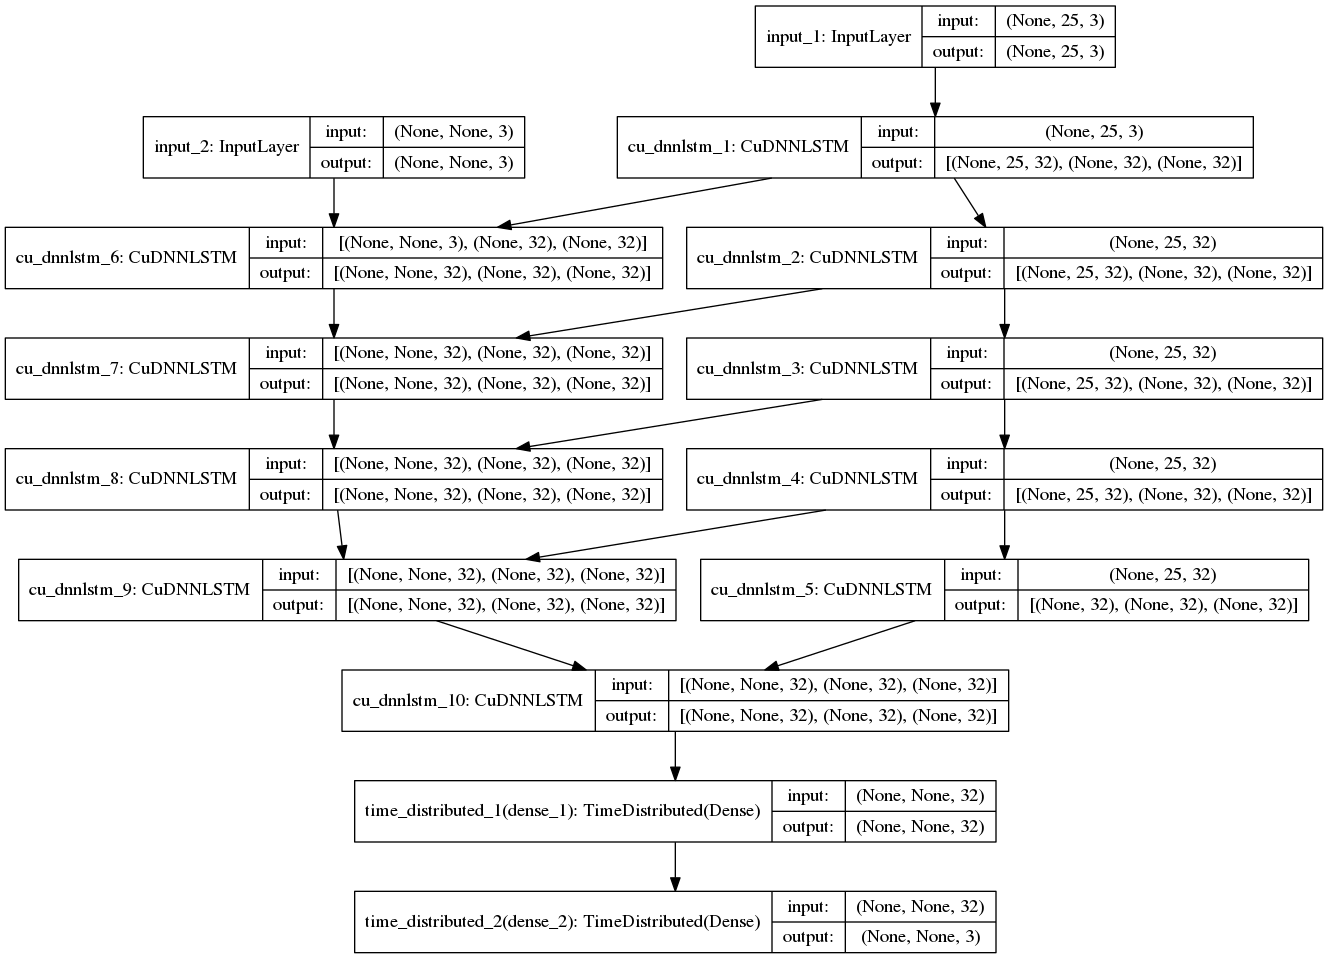

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(inputs=[encoder_inputs], outputs=encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h1 = Input(shape=(latent_dim,))
decoder_state_input_c1 = Input(shape=(latent_dim,))
decoder_state_input_h2 = Input(shape=(latent_dim,))
decoder_state_input_c2 = Input(shape=(latent_dim,))
decoder_state_input_h3 = Input(shape=(latent_dim,))
decoder_state_input_c3 = Input(shape=(latent_dim,))
decoder_state_input_h4 = Input(shape=(latent_dim,))
decoder_state_input_c4 = Input(shape=(latent_dim,))
decoder_state_input_h5 = Input(shape=(latent_dim,))
decoder_state_input_c5 = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h1, decoder_state_input_c1,
                         decoder_state_input_h2, decoder_state_input_c2,
                         decoder_state_input_h3, decoder_state_input_c3,
                         decoder_state_input_h4, decoder_state_input_c4,
                         decoder_state_input_h5, decoder_state_input_c5]

decoder_outputs_1, state_h1, state_c1 = decoder_1(decoder_inputs, initial_state=decoder_states_inputs[0:2])
decoder_outputs_2, state_h2, state_c2 = decoder_2(decoder_outputs_1, initial_state=decoder_states_inputs[2:4])
decoder_outputs_3, state_h3, state_c3 = decoder_3(decoder_outputs_2, initial_state=decoder_states_inputs[4:6])
decoder_outputs_4, state_h4, state_c4 = decoder_4(decoder_outputs_3, initial_state=decoder_states_inputs[6:8])
decoder_outputs_5, state_h5, state_c5 = decoder_4(decoder_outputs_4, initial_state=decoder_states_inputs[8:10])

decoder_states = [state_h1, state_c1,
                  state_h2, state_c2,
                  state_h3, state_c3,
                  state_h4, state_c4,
                  state_h5, state_c5,
                 ]

dense_output_1 = dense_1(decoder_outputs_5)
decoder_outputs = dense_2(dense_output_1)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs,
                      outputs=[decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((len(input_seq), 1, 3))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[:, 0, :] = np.sum(input_seq[:, -n_delay:, :], axis=1)

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((len(input_seq), len_delay, 3))
    
    for i in range(len_delay):
        output, h1, c1, h2, c2, h3, c3, h4, c4, h5, c5 = decoder_model.predict([target_seq] + states_value)

        # Update the target sequence (of length 1).
        target_seq = np.zeros((len(input_seq), 1, 3))
        target_seq[:, 0, :] = output[:,0,:]
        decoded_seq[:,i,:] = output[:,0,:]

        # Update states
        states_value = [h1, c1,
                        h2, c2,
                        h3, c3,
                        h4, c4,
                        h5, c5]

    return decoded_seq

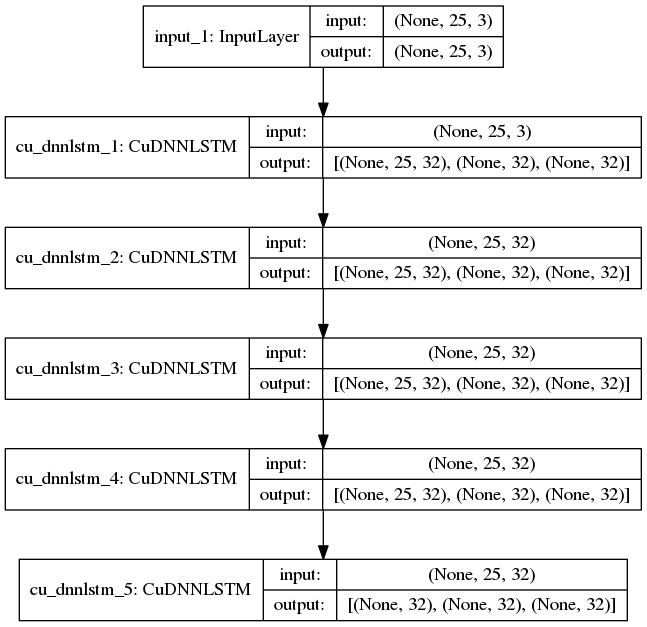

In [7]:
plot_model(encoder_model, to_file=experiment_name+'.png', show_shapes=True)

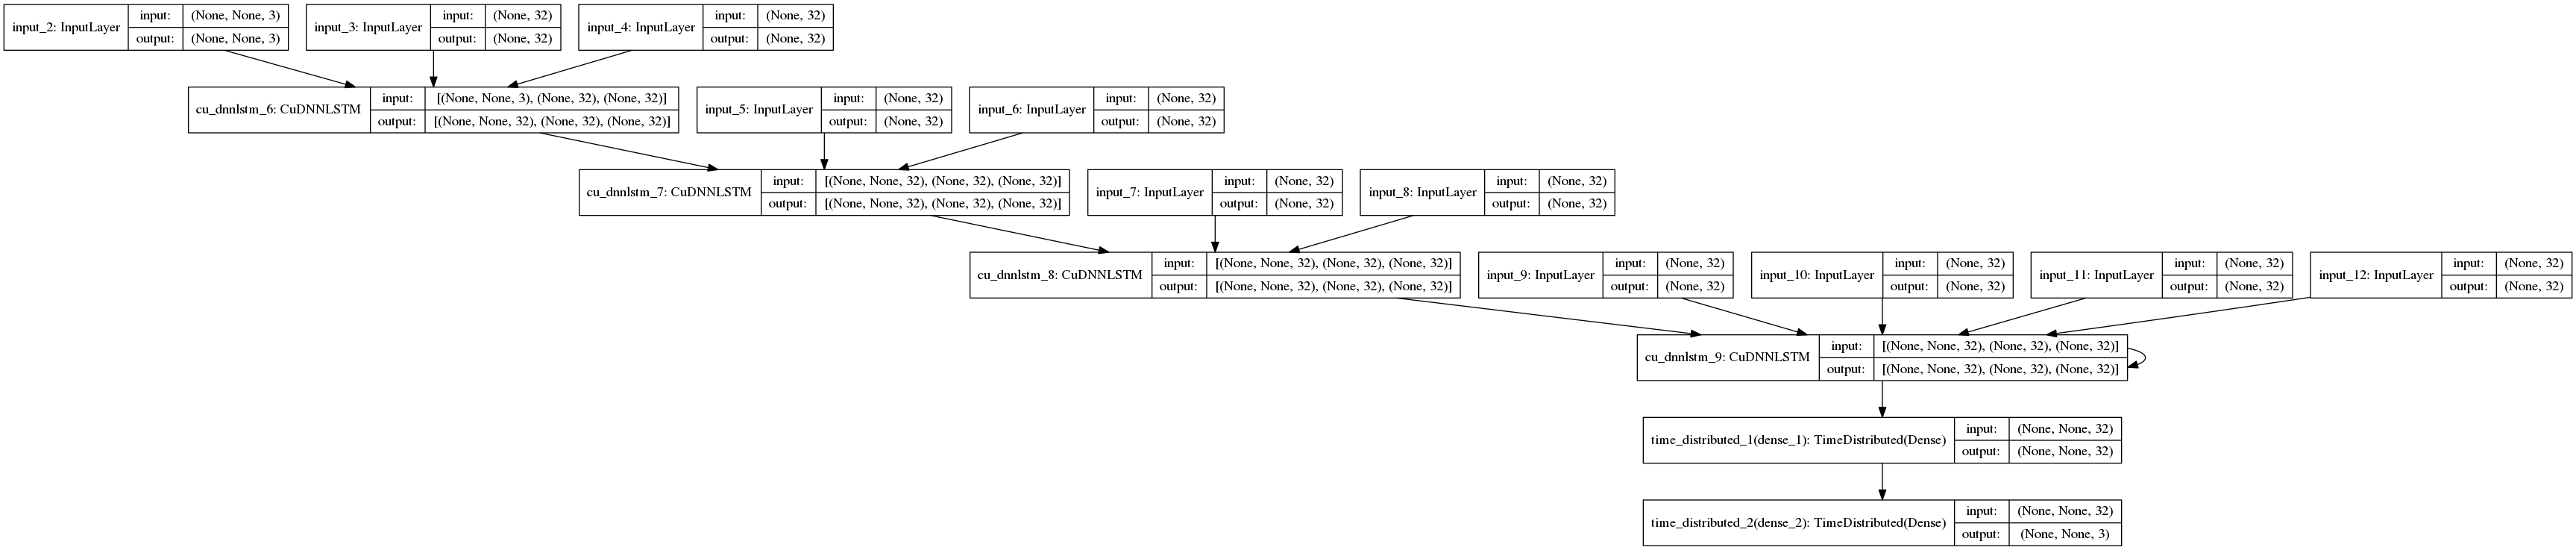

In [8]:
plot_model(decoder_model, to_file=experiment_name+'.png', show_shapes=True)

In [9]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [10]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [11]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

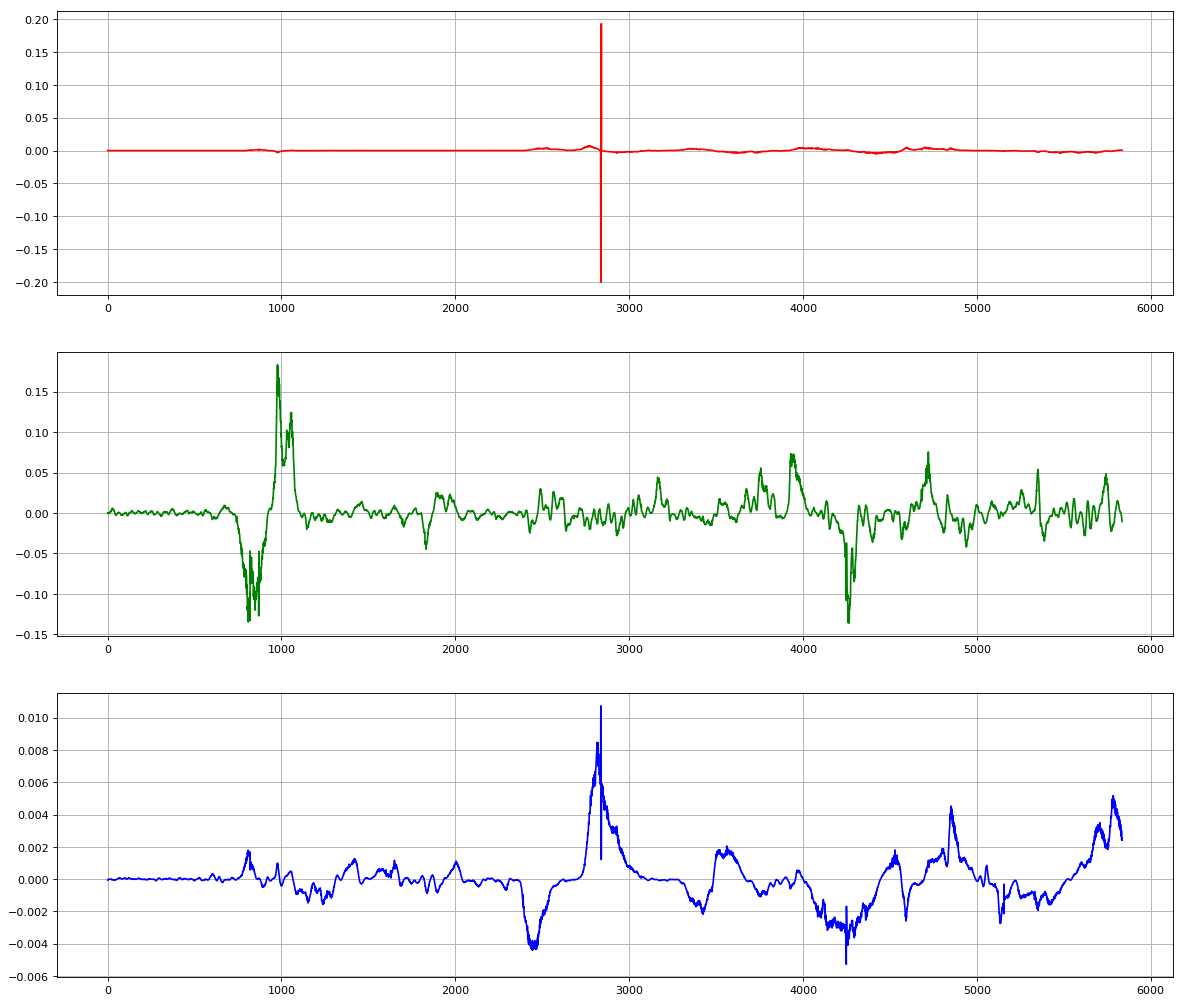

In [12]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [13]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/542 [..............................] - ETA: 14:06 - loss: 0.0225 - rmse: 0.0536

  2/542 [..............................] - ETA: 7:18 - loss: 0.0434 - rmse: 0.1383 

  3/542 [..............................] - ETA: 5:03 - loss: 0.0545 - rmse: 0.1555

  4/542 [..............................] - ETA: 3:54 - loss: 0.0497 - rmse: 0.1478

  5/542 [..............................] - ETA: 3:14 - loss: 0.0448 - rmse: 0.1409

  6/542 [..............................] - ETA: 2:47 - loss: 0.0424 - rmse: 0.1319

  7/542 [..............................] - ETA: 2:27 - loss: 0.0421 - rmse: 0.1298

  8/542 [..............................] - ETA: 2:12 - loss: 0.0531 - rmse: 0.1533

  9/542 [..............................] - ETA: 2:00 - loss: 0.0565 - rmse: 0.1596

 10/542 [..............................] - ETA: 1:51 - loss: 0.0635 - rmse: 0.1733

 11/542 [..............................] - ETA: 1:44 - loss: 0.0649 - rmse: 0.1770

 12/542 [..............................] - ETA: 1:38 - loss: 0.0672 - rmse: 0.1865

 13/542 [..............................] - ETA: 1:32 - loss: 0.0646 - rmse: 0.1801

 14/542 [..............................] - ETA: 1:28 - loss: 0.0637 - rmse: 0.1772

 16/542 [..............................] - ETA: 1:20 - loss: 0.0599 - rmse: 0.1654

 17/542 [..............................] - ETA: 1:17 - loss: 0.0620 - rmse: 0.1725

 18/542 [..............................] - ETA: 1:14 - loss: 0.0614 - rmse: 0.1719

 19/542 [>.............................] - ETA: 1:12 - loss: 0.0607 - rmse: 0.1700

 21/542 [>.............................] - ETA: 1:08 - loss: 0.0593 - rmse: 0.1664

 22/542 [>.............................] - ETA: 1:06 - loss: 0.0598 - rmse: 0.1675

 23/542 [>.............................] - ETA: 1:04 - loss: 0.0604 - rmse: 0.1682

 24/542 [>.............................] - ETA: 1:03 - loss: 0.0592 - rmse: 0.1643

 25/542 [>.............................] - ETA: 1:01 - loss: 0.0592 - rmse: 0.1636

 27/542 [>.............................] - ETA: 58s - loss: 0.0600 - rmse: 0.1651 

 28/542 [>.............................] - ETA: 57s - loss: 0.0595 - rmse: 0.1643

 29/542 [>.............................] - ETA: 56s - loss: 0.0593 - rmse: 0.1632

 30/542 [>.............................] - ETA: 55s - loss: 0.0594 - rmse: 0.1643

 31/542 [>.............................] - ETA: 54s - loss: 0.0607 - rmse: 0.1675

 33/542 [>.............................] - ETA: 53s - loss: 0.0605 - rmse: 0.1669

 34/542 [>.............................] - ETA: 52s - loss: 0.0598 - rmse: 0.1647

 35/542 [>.............................] - ETA: 51s - loss: 0.0610 - rmse: 0.1672

 36/542 [>.............................] - ETA: 50s - loss: 0.0619 - rmse: 0.1692

 37/542 [=>............................] - ETA: 50s - loss: 0.0612 - rmse: 0.1667

 38/542 [=>............................] - ETA: 49s - loss: 0.0623 - rmse: 0.1683

 39/542 [=>............................] - ETA: 49s - loss: 0.0613 - rmse: 0.1660

 40/542 [=>............................] - ETA: 48s - loss: 0.0612 - rmse: 0.1659

 41/542 [=>............................] - ETA: 48s - loss: 0.0613 - rmse: 0.1662

 42/542 [=>............................] - ETA: 47s - loss: 0.0618 - rmse: 0.1664

 43/542 [=>............................] - ETA: 46s - loss: 0.0621 - rmse: 0.1673

 44/542 [=>............................] - ETA: 46s - loss: 0.0628 - rmse: 0.1683

 45/542 [=>............................] - ETA: 46s - loss: 0.0634 - rmse: 0.1694

 46/542 [=>............................] - ETA: 45s - loss: 0.0642 - rmse: 0.1709

 47/542 [=>............................] - ETA: 45s - loss: 0.0640 - rmse: 0.1702

 48/542 [=>............................] - ETA: 44s - loss: 0.0634 - rmse: 0.1685

 49/542 [=>............................] - ETA: 44s - loss: 0.0632 - rmse: 0.1677

 50/542 [=>............................] - ETA: 43s - loss: 0.0629 - rmse: 0.1674

 51/542 [=>............................] - ETA: 43s - loss: 0.0620 - rmse: 0.1656

 52/542 [=>............................] - ETA: 43s - loss: 0.0612 - rmse: 0.1632

 53/542 [=>............................] - ETA: 42s - loss: 0.0611 - rmse: 0.1633

 54/542 [=>............................] - ETA: 42s - loss: 0.0614 - rmse: 0.1637

 55/542 [==>...........................] - ETA: 42s - loss: 0.0612 - rmse: 0.1629

 56/542 [==>...........................] - ETA: 41s - loss: 0.0603 - rmse: 0.1605

 57/542 [==>...........................] - ETA: 41s - loss: 0.0613 - rmse: 0.1628

 58/542 [==>...........................] - ETA: 41s - loss: 0.0613 - rmse: 0.1631

 59/542 [==>...........................] - ETA: 40s - loss: 0.0616 - rmse: 0.1640

 60/542 [==>...........................] - ETA: 40s - loss: 0.0615 - rmse: 0.1639

 61/542 [==>...........................] - ETA: 40s - loss: 0.0617 - rmse: 0.1644

 62/542 [==>...........................] - ETA: 40s - loss: 0.0625 - rmse: 0.1663

 63/542 [==>...........................] - ETA: 39s - loss: 0.0620 - rmse: 0.1652

 64/542 [==>...........................] - ETA: 39s - loss: 0.0622 - rmse: 0.1664

 65/542 [==>...........................] - ETA: 39s - loss: 0.0619 - rmse: 0.1660

 66/542 [==>...........................] - ETA: 39s - loss: 0.0627 - rmse: 0.1679

 67/542 [==>...........................] - ETA: 38s - loss: 0.0635 - rmse: 0.1696

 68/542 [==>...........................] - ETA: 38s - loss: 0.0634 - rmse: 0.1689

 69/542 [==>...........................] - ETA: 38s - loss: 0.0638 - rmse: 0.1693

 70/542 [==>...........................] - ETA: 38s - loss: 0.0642 - rmse: 0.1704

 71/542 [==>...........................] - ETA: 37s - loss: 0.0646 - rmse: 0.1711

 72/542 [==>...........................] - ETA: 37s - loss: 0.0642 - rmse: 0.1707

 73/542 [===>..........................] - ETA: 37s - loss: 0.0639 - rmse: 0.1700

 74/542 [===>..........................] - ETA: 37s - loss: 0.0632 - rmse: 0.1683

 75/542 [===>..........................] - ETA: 37s - loss: 0.0632 - rmse: 0.1686

 77/542 [===>..........................] - ETA: 36s - loss: 0.0640 - rmse: 0.1710

 78/542 [===>..........................] - ETA: 36s - loss: 0.0641 - rmse: 0.1723

 79/542 [===>..........................] - ETA: 36s - loss: 0.0641 - rmse: 0.1730

 80/542 [===>..........................] - ETA: 36s - loss: 0.0641 - rmse: 0.1740

 81/542 [===>..........................] - ETA: 35s - loss: 0.0645 - rmse: 0.1748

 82/542 [===>..........................] - ETA: 35s - loss: 0.0647 - rmse: 0.1754

 83/542 [===>..........................] - ETA: 35s - loss: 0.0652 - rmse: 0.1768

 84/542 [===>..........................] - ETA: 35s - loss: 0.0655 - rmse: 0.1777

 85/542 [===>..........................] - ETA: 35s - loss: 0.0654 - rmse: 0.1780

 86/542 [===>..........................] - ETA: 35s - loss: 0.0653 - rmse: 0.1778

 87/542 [===>..........................] - ETA: 34s - loss: 0.0653 - rmse: 0.1776

 88/542 [===>..........................] - ETA: 34s - loss: 0.0655 - rmse: 0.1784

 89/542 [===>..........................] - ETA: 34s - loss: 0.0654 - rmse: 0.1780

 90/542 [===>..........................] - ETA: 34s - loss: 0.0650 - rmse: 0.1777

 91/542 [====>.........................] - ETA: 34s - loss: 0.0650 - rmse: 0.1776

 92/542 [====>.........................] - ETA: 34s - loss: 0.0650 - rmse: 0.1783

 93/542 [====>.........................] - ETA: 33s - loss: 0.0646 - rmse: 0.1770

 94/542 [====>.........................] - ETA: 33s - loss: 0.0642 - rmse: 0.1759

 95/542 [====>.........................] - ETA: 33s - loss: 0.0641 - rmse: 0.1764

 96/542 [====>.........................] - ETA: 33s - loss: 0.0639 - rmse: 0.1757

 97/542 [====>.........................] - ETA: 33s - loss: 0.0634 - rmse: 0.1743

 98/542 [====>.........................] - ETA: 33s - loss: 0.0636 - rmse: 0.1746

 99/542 [====>.........................] - ETA: 33s - loss: 0.0637 - rmse: 0.1747

100/542 [====>.........................] - ETA: 32s - loss: 0.0637 - rmse: 0.1749

101/542 [====>.........................] - ETA: 32s - loss: 0.0641 - rmse: 0.1759

102/542 [====>.........................] - ETA: 32s - loss: 0.0639 - rmse: 0.1754

103/542 [====>.........................] - ETA: 32s - loss: 0.0636 - rmse: 0.1745

104/542 [====>.........................] - ETA: 32s - loss: 0.0637 - rmse: 0.1746

105/542 [====>.........................] - ETA: 32s - loss: 0.0637 - rmse: 0.1746

106/542 [====>.........................] - ETA: 32s - loss: 0.0637 - rmse: 0.1746

107/542 [====>.........................] - ETA: 32s - loss: 0.0636 - rmse: 0.1740

108/542 [====>.........................] - ETA: 31s - loss: 0.0637 - rmse: 0.1742

109/542 [=====>........................] - ETA: 31s - loss: 0.0640 - rmse: 0.1754

110/542 [=====>........................] - ETA: 31s - loss: 0.0641 - rmse: 0.1756

111/542 [=====>........................] - ETA: 31s - loss: 0.0643 - rmse: 0.1758

112/542 [=====>........................] - ETA: 31s - loss: 0.0643 - rmse: 0.1758

113/542 [=====>........................] - ETA: 31s - loss: 0.0642 - rmse: 0.1756

114/542 [=====>........................] - ETA: 31s - loss: 0.0641 - rmse: 0.1754

115/542 [=====>........................] - ETA: 31s - loss: 0.0642 - rmse: 0.1755

116/542 [=====>........................] - ETA: 30s - loss: 0.0640 - rmse: 0.1747

117/542 [=====>........................] - ETA: 30s - loss: 0.0635 - rmse: 0.1735

118/542 [=====>........................] - ETA: 30s - loss: 0.0635 - rmse: 0.1736

119/542 [=====>........................] - ETA: 30s - loss: 0.0638 - rmse: 0.1745

120/542 [=====>........................] - ETA: 30s - loss: 0.0634 - rmse: 0.1735

121/542 [=====>........................] - ETA: 30s - loss: 0.0633 - rmse: 0.1731

122/542 [=====>........................] - ETA: 30s - loss: 0.0633 - rmse: 0.1732

123/542 [=====>........................] - ETA: 30s - loss: 0.0630 - rmse: 0.1724

124/542 [=====>........................] - ETA: 30s - loss: 0.0630 - rmse: 0.1726

125/542 [=====>........................] - ETA: 29s - loss: 0.0628 - rmse: 0.1726

126/542 [=====>........................] - ETA: 29s - loss: 0.0629 - rmse: 0.1727

127/542 [======>.......................] - ETA: 29s - loss: 0.0629 - rmse: 0.1725

129/542 [======>.......................] - ETA: 29s - loss: 0.0630 - rmse: 0.1728

130/542 [======>.......................] - ETA: 29s - loss: 0.0627 - rmse: 0.1719

131/542 [======>.......................] - ETA: 29s - loss: 0.0627 - rmse: 0.1721

132/542 [======>.......................] - ETA: 29s - loss: 0.0627 - rmse: 0.1722

133/542 [======>.......................] - ETA: 28s - loss: 0.0628 - rmse: 0.1731

134/542 [======>.......................] - ETA: 28s - loss: 0.0632 - rmse: 0.1745

135/542 [======>.......................] - ETA: 28s - loss: 0.0634 - rmse: 0.1747

136/542 [======>.......................] - ETA: 28s - loss: 0.0631 - rmse: 0.1739

137/542 [======>.......................] - ETA: 28s - loss: 0.0632 - rmse: 0.1742

138/542 [======>.......................] - ETA: 28s - loss: 0.0631 - rmse: 0.1738

139/542 [======>.......................] - ETA: 28s - loss: 0.0632 - rmse: 0.1740

140/542 [======>.......................] - ETA: 28s - loss: 0.0629 - rmse: 0.1731

141/542 [======>.......................] - ETA: 28s - loss: 0.0629 - rmse: 0.1733

142/542 [======>.......................] - ETA: 28s - loss: 0.0626 - rmse: 0.1725

143/542 [======>.......................] - ETA: 27s - loss: 0.0627 - rmse: 0.1726

144/542 [======>.......................] - ETA: 27s - loss: 0.0628 - rmse: 0.1727

145/542 [=======>......................] - ETA: 27s - loss: 0.0630 - rmse: 0.1732

146/542 [=======>......................] - ETA: 27s - loss: 0.0629 - rmse: 0.1727

147/542 [=======>......................] - ETA: 27s - loss: 0.0628 - rmse: 0.1727

149/542 [=======>......................] - ETA: 27s - loss: 0.0627 - rmse: 0.1729

150/542 [=======>......................] - ETA: 27s - loss: 0.0627 - rmse: 0.1729

151/542 [=======>......................] - ETA: 27s - loss: 0.0626 - rmse: 0.1726

152/542 [=======>......................] - ETA: 27s - loss: 0.0626 - rmse: 0.1725

153/542 [=======>......................] - ETA: 26s - loss: 0.0625 - rmse: 0.1723

154/542 [=======>......................] - ETA: 26s - loss: 0.0626 - rmse: 0.1729

155/542 [=======>......................] - ETA: 26s - loss: 0.0623 - rmse: 0.1720

156/542 [=======>......................] - ETA: 26s - loss: 0.0626 - rmse: 0.1728

157/542 [=======>......................] - ETA: 26s - loss: 0.0627 - rmse: 0.1729

158/542 [=======>......................] - ETA: 26s - loss: 0.0626 - rmse: 0.1724

159/542 [=======>......................] - ETA: 26s - loss: 0.0625 - rmse: 0.1721

160/542 [=======>......................] - ETA: 26s - loss: 0.0623 - rmse: 0.1716

161/542 [=======>......................] - ETA: 26s - loss: 0.0620 - rmse: 0.1708

162/542 [=======>......................] - ETA: 26s - loss: 0.0622 - rmse: 0.1711

163/542 [========>.....................] - ETA: 26s - loss: 0.0621 - rmse: 0.1708

164/542 [========>.....................] - ETA: 25s - loss: 0.0621 - rmse: 0.1711

165/542 [========>.....................] - ETA: 25s - loss: 0.0622 - rmse: 0.1712

166/542 [========>.....................] - ETA: 25s - loss: 0.0622 - rmse: 0.1711

167/542 [========>.....................] - ETA: 25s - loss: 0.0621 - rmse: 0.1710

168/542 [========>.....................] - ETA: 25s - loss: 0.0620 - rmse: 0.1708

169/542 [========>.....................] - ETA: 25s - loss: 0.0623 - rmse: 0.1714

170/542 [========>.....................] - ETA: 25s - loss: 0.0626 - rmse: 0.1721

171/542 [========>.....................] - ETA: 25s - loss: 0.0628 - rmse: 0.1725

172/542 [========>.....................] - ETA: 25s - loss: 0.0629 - rmse: 0.1727

173/542 [========>.....................] - ETA: 25s - loss: 0.0628 - rmse: 0.1722

175/542 [========>.....................] - ETA: 24s - loss: 0.0629 - rmse: 0.1724

176/542 [========>.....................] - ETA: 24s - loss: 0.0630 - rmse: 0.1725

177/542 [========>.....................] - ETA: 24s - loss: 0.0631 - rmse: 0.1730

178/542 [========>.....................] - ETA: 24s - loss: 0.0631 - rmse: 0.1729

179/542 [========>.....................] - ETA: 24s - loss: 0.0630 - rmse: 0.1727

180/542 [========>.....................] - ETA: 24s - loss: 0.0630 - rmse: 0.1726

181/542 [=========>....................] - ETA: 24s - loss: 0.0629 - rmse: 0.1720

182/542 [=========>....................] - ETA: 24s - loss: 0.0628 - rmse: 0.1718

183/542 [=========>....................] - ETA: 24s - loss: 0.0629 - rmse: 0.1718

184/542 [=========>....................] - ETA: 24s - loss: 0.0631 - rmse: 0.1724

185/542 [=========>....................] - ETA: 24s - loss: 0.0632 - rmse: 0.1725

186/542 [=========>....................] - ETA: 24s - loss: 0.0634 - rmse: 0.1729

187/542 [=========>....................] - ETA: 23s - loss: 0.0632 - rmse: 0.1723

188/542 [=========>....................] - ETA: 23s - loss: 0.0630 - rmse: 0.1718

189/542 [=========>....................] - ETA: 23s - loss: 0.0629 - rmse: 0.1715

190/542 [=========>....................] - ETA: 23s - loss: 0.0628 - rmse: 0.1712

191/542 [=========>....................] - ETA: 23s - loss: 0.0628 - rmse: 0.1709

192/542 [=========>....................] - ETA: 23s - loss: 0.0627 - rmse: 0.1705

193/542 [=========>....................] - ETA: 23s - loss: 0.0630 - rmse: 0.1711

194/542 [=========>....................] - ETA: 23s - loss: 0.0629 - rmse: 0.1709

195/542 [=========>....................] - ETA: 23s - loss: 0.0631 - rmse: 0.1714

196/542 [=========>....................] - ETA: 23s - loss: 0.0630 - rmse: 0.1710

197/542 [=========>....................] - ETA: 23s - loss: 0.0630 - rmse: 0.1711

198/542 [=========>....................] - ETA: 23s - loss: 0.0630 - rmse: 0.1711

199/542 [==========>...................] - ETA: 22s - loss: 0.0628 - rmse: 0.1705

200/542 [==========>...................] - ETA: 22s - loss: 0.0627 - rmse: 0.1702

201/542 [==========>...................] - ETA: 22s - loss: 0.0624 - rmse: 0.1695

202/542 [==========>...................] - ETA: 22s - loss: 0.0626 - rmse: 0.1696

203/542 [==========>...................] - ETA: 22s - loss: 0.0624 - rmse: 0.1691

204/542 [==========>...................] - ETA: 22s - loss: 0.0623 - rmse: 0.1689

205/542 [==========>...................] - ETA: 22s - loss: 0.0624 - rmse: 0.1690

206/542 [==========>...................] - ETA: 22s - loss: 0.0623 - rmse: 0.1685

207/542 [==========>...................] - ETA: 22s - loss: 0.0621 - rmse: 0.1681

208/542 [==========>...................] - ETA: 22s - loss: 0.0620 - rmse: 0.1678

209/542 [==========>...................] - ETA: 22s - loss: 0.0618 - rmse: 0.1674

210/542 [==========>...................] - ETA: 22s - loss: 0.0616 - rmse: 0.1668

211/542 [==========>...................] - ETA: 22s - loss: 0.0615 - rmse: 0.1663

212/542 [==========>...................] - ETA: 21s - loss: 0.0616 - rmse: 0.1665

213/542 [==========>...................] - ETA: 21s - loss: 0.0616 - rmse: 0.1668

214/542 [==========>...................] - ETA: 21s - loss: 0.0615 - rmse: 0.1664

215/542 [==========>...................] - ETA: 21s - loss: 0.0615 - rmse: 0.1668

216/542 [==========>...................] - ETA: 21s - loss: 0.0613 - rmse: 0.1663

217/542 [===========>..................] - ETA: 21s - loss: 0.0612 - rmse: 0.1660

218/542 [===========>..................] - ETA: 21s - loss: 0.0611 - rmse: 0.1655

219/542 [===========>..................] - ETA: 21s - loss: 0.0609 - rmse: 0.1651

220/542 [===========>..................] - ETA: 21s - loss: 0.0608 - rmse: 0.1647

221/542 [===========>..................] - ETA: 21s - loss: 0.0606 - rmse: 0.1641

222/542 [===========>..................] - ETA: 21s - loss: 0.0606 - rmse: 0.1641

223/542 [===========>..................] - ETA: 21s - loss: 0.0605 - rmse: 0.1637

224/542 [===========>..................] - ETA: 21s - loss: 0.0605 - rmse: 0.1639

225/542 [===========>..................] - ETA: 21s - loss: 0.0605 - rmse: 0.1639

226/542 [===========>..................] - ETA: 20s - loss: 0.0606 - rmse: 0.1640

227/542 [===========>..................] - ETA: 20s - loss: 0.0605 - rmse: 0.1639

228/542 [===========>..................] - ETA: 20s - loss: 0.0605 - rmse: 0.1638

229/542 [===========>..................] - ETA: 20s - loss: 0.0603 - rmse: 0.1637

230/542 [===========>..................] - ETA: 20s - loss: 0.0604 - rmse: 0.1636

231/542 [===========>..................] - ETA: 20s - loss: 0.0603 - rmse: 0.1634

232/542 [===========>..................] - ETA: 20s - loss: 0.0603 - rmse: 0.1632

233/542 [===========>..................] - ETA: 20s - loss: 0.0601 - rmse: 0.1628

234/542 [===========>..................] - ETA: 20s - loss: 0.0600 - rmse: 0.1626

235/542 [============>.................] - ETA: 20s - loss: 0.0600 - rmse: 0.1626

236/542 [============>.................] - ETA: 20s - loss: 0.0599 - rmse: 0.1623

237/542 [============>.................] - ETA: 20s - loss: 0.0597 - rmse: 0.1617

238/542 [============>.................] - ETA: 20s - loss: 0.0595 - rmse: 0.1613

239/542 [============>.................] - ETA: 19s - loss: 0.0595 - rmse: 0.1612

240/542 [============>.................] - ETA: 19s - loss: 0.0594 - rmse: 0.1607

241/542 [============>.................] - ETA: 19s - loss: 0.0592 - rmse: 0.1604

242/542 [============>.................] - ETA: 19s - loss: 0.0592 - rmse: 0.1601

243/542 [============>.................] - ETA: 19s - loss: 0.0591 - rmse: 0.1598

244/542 [============>.................] - ETA: 19s - loss: 0.0590 - rmse: 0.1596

245/542 [============>.................] - ETA: 19s - loss: 0.0589 - rmse: 0.1593

246/542 [============>.................] - ETA: 19s - loss: 0.0588 - rmse: 0.1588

247/542 [============>.................] - ETA: 19s - loss: 0.0587 - rmse: 0.1585

248/542 [============>.................] - ETA: 19s - loss: 0.0585 - rmse: 0.1581

249/542 [============>.................] - ETA: 19s - loss: 0.0584 - rmse: 0.1576

250/542 [============>.................] - ETA: 19s - loss: 0.0582 - rmse: 0.1571

251/542 [============>.................] - ETA: 19s - loss: 0.0581 - rmse: 0.1568

252/542 [============>.................] - ETA: 19s - loss: 0.0581 - rmse: 0.1567

253/542 [=============>................] - ETA: 18s - loss: 0.0579 - rmse: 0.1563

254/542 [=============>................] - ETA: 18s - loss: 0.0579 - rmse: 0.1562

255/542 [=============>................] - ETA: 18s - loss: 0.0578 - rmse: 0.1560

257/542 [=============>................] - ETA: 18s - loss: 0.0578 - rmse: 0.1557

258/542 [=============>................] - ETA: 18s - loss: 0.0577 - rmse: 0.1554

259/542 [=============>................] - ETA: 18s - loss: 0.0576 - rmse: 0.1550

261/542 [=============>................] - ETA: 18s - loss: 0.0576 - rmse: 0.1551

262/542 [=============>................] - ETA: 18s - loss: 0.0576 - rmse: 0.1549

263/542 [=============>................] - ETA: 18s - loss: 0.0574 - rmse: 0.1545

264/542 [=============>................] - ETA: 18s - loss: 0.0574 - rmse: 0.1544

266/542 [=============>................] - ETA: 17s - loss: 0.0572 - rmse: 0.1538

267/542 [=============>................] - ETA: 17s - loss: 0.0571 - rmse: 0.1535

268/542 [=============>................] - ETA: 17s - loss: 0.0571 - rmse: 0.1533

269/542 [=============>................] - ETA: 17s - loss: 0.0569 - rmse: 0.1530

271/542 [==============>...............] - ETA: 17s - loss: 0.0568 - rmse: 0.1525

272/542 [==============>...............] - ETA: 17s - loss: 0.0567 - rmse: 0.1523

273/542 [==============>...............] - ETA: 17s - loss: 0.0566 - rmse: 0.1522

274/542 [==============>...............] - ETA: 17s - loss: 0.0565 - rmse: 0.1519

275/542 [==============>...............] - ETA: 17s - loss: 0.0565 - rmse: 0.1519

277/542 [==============>...............] - ETA: 17s - loss: 0.0563 - rmse: 0.1515

278/542 [==============>...............] - ETA: 17s - loss: 0.0563 - rmse: 0.1515

280/542 [==============>...............] - ETA: 16s - loss: 0.0562 - rmse: 0.1510

281/542 [==============>...............] - ETA: 16s - loss: 0.0562 - rmse: 0.1509

282/542 [==============>...............] - ETA: 16s - loss: 0.0562 - rmse: 0.1508

283/542 [==============>...............] - ETA: 16s - loss: 0.0560 - rmse: 0.1505

284/542 [==============>...............] - ETA: 16s - loss: 0.0561 - rmse: 0.1506

285/542 [==============>...............] - ETA: 16s - loss: 0.0559 - rmse: 0.1502

286/542 [==============>...............] - ETA: 16s - loss: 0.0558 - rmse: 0.1499

287/542 [==============>...............] - ETA: 16s - loss: 0.0557 - rmse: 0.1496

288/542 [==============>...............] - ETA: 16s - loss: 0.0557 - rmse: 0.1493

289/542 [==============>...............] - ETA: 16s - loss: 0.0555 - rmse: 0.1489

290/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1489

291/542 [===============>..............] - ETA: 16s - loss: 0.0555 - rmse: 0.1487

292/542 [===============>..............] - ETA: 16s - loss: 0.0554 - rmse: 0.1485

293/542 [===============>..............] - ETA: 16s - loss: 0.0553 - rmse: 0.1483

294/542 [===============>..............] - ETA: 15s - loss: 0.0552 - rmse: 0.1480

295/542 [===============>..............] - ETA: 15s - loss: 0.0551 - rmse: 0.1478

296/542 [===============>..............] - ETA: 15s - loss: 0.0550 - rmse: 0.1475

297/542 [===============>..............] - ETA: 15s - loss: 0.0549 - rmse: 0.1472

298/542 [===============>..............] - ETA: 15s - loss: 0.0549 - rmse: 0.1471

299/542 [===============>..............] - ETA: 15s - loss: 0.0548 - rmse: 0.1467

300/542 [===============>..............] - ETA: 15s - loss: 0.0547 - rmse: 0.1465

301/542 [===============>..............] - ETA: 15s - loss: 0.0546 - rmse: 0.1462

302/542 [===============>..............] - ETA: 15s - loss: 0.0545 - rmse: 0.1459

304/542 [===============>..............] - ETA: 15s - loss: 0.0544 - rmse: 0.1455

305/542 [===============>..............] - ETA: 15s - loss: 0.0544 - rmse: 0.1453

306/542 [===============>..............] - ETA: 15s - loss: 0.0543 - rmse: 0.1452

307/542 [===============>..............] - ETA: 15s - loss: 0.0543 - rmse: 0.1451

308/542 [================>.............] - ETA: 15s - loss: 0.0542 - rmse: 0.1449

309/542 [================>.............] - ETA: 14s - loss: 0.0542 - rmse: 0.1448

310/542 [================>.............] - ETA: 14s - loss: 0.0541 - rmse: 0.1445

311/542 [================>.............] - ETA: 14s - loss: 0.0540 - rmse: 0.1443

312/542 [================>.............] - ETA: 14s - loss: 0.0540 - rmse: 0.1443

313/542 [================>.............] - ETA: 14s - loss: 0.0540 - rmse: 0.1441

314/542 [================>.............] - ETA: 14s - loss: 0.0539 - rmse: 0.1440

315/542 [================>.............] - ETA: 14s - loss: 0.0539 - rmse: 0.1437

316/542 [================>.............] - ETA: 14s - loss: 0.0538 - rmse: 0.1435

317/542 [================>.............] - ETA: 14s - loss: 0.0537 - rmse: 0.1433

318/542 [================>.............] - ETA: 14s - loss: 0.0537 - rmse: 0.1433

319/542 [================>.............] - ETA: 14s - loss: 0.0537 - rmse: 0.1432

320/542 [================>.............] - ETA: 14s - loss: 0.0536 - rmse: 0.1430

321/542 [================>.............] - ETA: 14s - loss: 0.0536 - rmse: 0.1428

323/542 [================>.............] - ETA: 14s - loss: 0.0534 - rmse: 0.1423

324/542 [================>.............] - ETA: 13s - loss: 0.0533 - rmse: 0.1422

325/542 [================>.............] - ETA: 13s - loss: 0.0532 - rmse: 0.1418

326/542 [=================>............] - ETA: 13s - loss: 0.0531 - rmse: 0.1415

327/542 [=================>............] - ETA: 13s - loss: 0.0530 - rmse: 0.1413

328/542 [=================>............] - ETA: 13s - loss: 0.0529 - rmse: 0.1409

329/542 [=================>............] - ETA: 13s - loss: 0.0528 - rmse: 0.1407

331/542 [=================>............] - ETA: 13s - loss: 0.0526 - rmse: 0.1402

332/542 [=================>............] - ETA: 13s - loss: 0.0526 - rmse: 0.1400

333/542 [=================>............] - ETA: 13s - loss: 0.0525 - rmse: 0.1398

334/542 [=================>............] - ETA: 13s - loss: 0.0525 - rmse: 0.1396

335/542 [=================>............] - ETA: 13s - loss: 0.0524 - rmse: 0.1394

337/542 [=================>............] - ETA: 13s - loss: 0.0523 - rmse: 0.1390

338/542 [=================>............] - ETA: 13s - loss: 0.0523 - rmse: 0.1390

339/542 [=================>............] - ETA: 12s - loss: 0.0522 - rmse: 0.1389

340/542 [=================>............] - ETA: 12s - loss: 0.0522 - rmse: 0.1387

341/542 [=================>............] - ETA: 12s - loss: 0.0521 - rmse: 0.1384

342/542 [=================>............] - ETA: 12s - loss: 0.0520 - rmse: 0.1383

343/542 [=================>............] - ETA: 12s - loss: 0.0520 - rmse: 0.1381

344/542 [==================>...........] - ETA: 12s - loss: 0.0519 - rmse: 0.1379

345/542 [==================>...........] - ETA: 12s - loss: 0.0518 - rmse: 0.1375

346/542 [==================>...........] - ETA: 12s - loss: 0.0517 - rmse: 0.1372

347/542 [==================>...........] - ETA: 12s - loss: 0.0516 - rmse: 0.1371

348/542 [==================>...........] - ETA: 12s - loss: 0.0517 - rmse: 0.1371

349/542 [==================>...........] - ETA: 12s - loss: 0.0517 - rmse: 0.1370

350/542 [==================>...........] - ETA: 12s - loss: 0.0516 - rmse: 0.1367

351/542 [==================>...........] - ETA: 12s - loss: 0.0515 - rmse: 0.1366

352/542 [==================>...........] - ETA: 12s - loss: 0.0515 - rmse: 0.1364

353/542 [==================>...........] - ETA: 12s - loss: 0.0514 - rmse: 0.1362

354/542 [==================>...........] - ETA: 11s - loss: 0.0514 - rmse: 0.1361

355/542 [==================>...........] - ETA: 11s - loss: 0.0514 - rmse: 0.1360

356/542 [==================>...........] - ETA: 11s - loss: 0.0514 - rmse: 0.1359

357/542 [==================>...........] - ETA: 11s - loss: 0.0513 - rmse: 0.1357

358/542 [==================>...........] - ETA: 11s - loss: 0.0513 - rmse: 0.1355

359/542 [==================>...........] - ETA: 11s - loss: 0.0513 - rmse: 0.1355

360/542 [==================>...........] - ETA: 11s - loss: 0.0512 - rmse: 0.1353

361/542 [==================>...........] - ETA: 11s - loss: 0.0512 - rmse: 0.1352

362/542 [===================>..........] - ETA: 11s - loss: 0.0512 - rmse: 0.1351

363/542 [===================>..........] - ETA: 11s - loss: 0.0511 - rmse: 0.1348

364/542 [===================>..........] - ETA: 11s - loss: 0.0510 - rmse: 0.1347

365/542 [===================>..........] - ETA: 11s - loss: 0.0509 - rmse: 0.1344

366/542 [===================>..........] - ETA: 11s - loss: 0.0509 - rmse: 0.1343

367/542 [===================>..........] - ETA: 11s - loss: 0.0508 - rmse: 0.1341

368/542 [===================>..........] - ETA: 11s - loss: 0.0508 - rmse: 0.1341

369/542 [===================>..........] - ETA: 10s - loss: 0.0508 - rmse: 0.1339

370/542 [===================>..........] - ETA: 10s - loss: 0.0508 - rmse: 0.1339

372/542 [===================>..........] - ETA: 10s - loss: 0.0506 - rmse: 0.1335

373/542 [===================>..........] - ETA: 10s - loss: 0.0506 - rmse: 0.1333

374/542 [===================>..........] - ETA: 10s - loss: 0.0505 - rmse: 0.1331

375/542 [===================>..........] - ETA: 10s - loss: 0.0505 - rmse: 0.1330

376/542 [===================>..........] - ETA: 10s - loss: 0.0504 - rmse: 0.1329

377/542 [===================>..........] - ETA: 10s - loss: 0.0504 - rmse: 0.1328

378/542 [===================>..........] - ETA: 10s - loss: 0.0503 - rmse: 0.1326

379/542 [===================>..........] - ETA: 10s - loss: 0.0503 - rmse: 0.1324

380/542 [====================>.........] - ETA: 10s - loss: 0.0502 - rmse: 0.1324

381/542 [====================>.........] - ETA: 10s - loss: 0.0502 - rmse: 0.1323

382/542 [====================>.........] - ETA: 10s - loss: 0.0502 - rmse: 0.1322

383/542 [====================>.........] - ETA: 10s - loss: 0.0501 - rmse: 0.1321

384/542 [====================>.........] - ETA: 9s - loss: 0.0501 - rmse: 0.1320 

385/542 [====================>.........] - ETA: 9s - loss: 0.0501 - rmse: 0.1319

386/542 [====================>.........] - ETA: 9s - loss: 0.0501 - rmse: 0.1320

387/542 [====================>.........] - ETA: 9s - loss: 0.0501 - rmse: 0.1319

388/542 [====================>.........] - ETA: 9s - loss: 0.0501 - rmse: 0.1319

389/542 [====================>.........] - ETA: 9s - loss: 0.0501 - rmse: 0.1318

390/542 [====================>.........] - ETA: 9s - loss: 0.0501 - rmse: 0.1318

391/542 [====================>.........] - ETA: 9s - loss: 0.0500 - rmse: 0.1317

392/542 [====================>.........] - ETA: 9s - loss: 0.0500 - rmse: 0.1316

393/542 [====================>.........] - ETA: 9s - loss: 0.0499 - rmse: 0.1314

394/542 [====================>.........] - ETA: 9s - loss: 0.0499 - rmse: 0.1313

395/542 [====================>.........] - ETA: 9s - loss: 0.0499 - rmse: 0.1311

396/542 [====================>.........] - ETA: 9s - loss: 0.0498 - rmse: 0.1309

397/542 [====================>.........] - ETA: 9s - loss: 0.0497 - rmse: 0.1308

398/542 [=====================>........] - ETA: 9s - loss: 0.0497 - rmse: 0.1306

399/542 [=====================>........] - ETA: 9s - loss: 0.0496 - rmse: 0.1304

400/542 [=====================>........] - ETA: 8s - loss: 0.0495 - rmse: 0.1303

401/542 [=====================>........] - ETA: 8s - loss: 0.0495 - rmse: 0.1301

402/542 [=====================>........] - ETA: 8s - loss: 0.0495 - rmse: 0.1301

403/542 [=====================>........] - ETA: 8s - loss: 0.0494 - rmse: 0.1299

404/542 [=====================>........] - ETA: 8s - loss: 0.0494 - rmse: 0.1298

405/542 [=====================>........] - ETA: 8s - loss: 0.0493 - rmse: 0.1296

406/542 [=====================>........] - ETA: 8s - loss: 0.0493 - rmse: 0.1295

408/542 [=====================>........] - ETA: 8s - loss: 0.0493 - rmse: 0.1296

409/542 [=====================>........] - ETA: 8s - loss: 0.0493 - rmse: 0.1298

410/542 [=====================>........] - ETA: 8s - loss: 0.0493 - rmse: 0.1297

411/542 [=====================>........] - ETA: 8s - loss: 0.0493 - rmse: 0.1295

413/542 [=====================>........] - ETA: 8s - loss: 0.0493 - rmse: 0.1294

414/542 [=====================>........] - ETA: 8s - loss: 0.0493 - rmse: 0.1293

415/542 [=====================>........] - ETA: 7s - loss: 0.0492 - rmse: 0.1292

416/542 [======================>.......] - ETA: 7s - loss: 0.0492 - rmse: 0.1291

417/542 [======================>.......] - ETA: 7s - loss: 0.0492 - rmse: 0.1290

418/542 [======================>.......] - ETA: 7s - loss: 0.0492 - rmse: 0.1289

419/542 [======================>.......] - ETA: 7s - loss: 0.0492 - rmse: 0.1289

420/542 [======================>.......] - ETA: 7s - loss: 0.0491 - rmse: 0.1287

421/542 [======================>.......] - ETA: 7s - loss: 0.0491 - rmse: 0.1286

422/542 [======================>.......] - ETA: 7s - loss: 0.0490 - rmse: 0.1284

423/542 [======================>.......] - ETA: 7s - loss: 0.0490 - rmse: 0.1283

424/542 [======================>.......] - ETA: 7s - loss: 0.0490 - rmse: 0.1283

426/542 [======================>.......] - ETA: 7s - loss: 0.0490 - rmse: 0.1281

427/542 [======================>.......] - ETA: 7s - loss: 0.0489 - rmse: 0.1281

428/542 [======================>.......] - ETA: 7s - loss: 0.0489 - rmse: 0.1280

429/542 [======================>.......] - ETA: 7s - loss: 0.0489 - rmse: 0.1279

430/542 [======================>.......] - ETA: 7s - loss: 0.0488 - rmse: 0.1278

431/542 [======================>.......] - ETA: 6s - loss: 0.0488 - rmse: 0.1276

432/542 [======================>.......] - ETA: 6s - loss: 0.0487 - rmse: 0.1275

433/542 [======================>.......] - ETA: 6s - loss: 0.0487 - rmse: 0.1273

434/542 [=======================>......] - ETA: 6s - loss: 0.0487 - rmse: 0.1274

435/542 [=======================>......] - ETA: 6s - loss: 0.0487 - rmse: 0.1273

436/542 [=======================>......] - ETA: 6s - loss: 0.0487 - rmse: 0.1272

437/542 [=======================>......] - ETA: 6s - loss: 0.0486 - rmse: 0.1270

438/542 [=======================>......] - ETA: 6s - loss: 0.0486 - rmse: 0.1269

439/542 [=======================>......] - ETA: 6s - loss: 0.0485 - rmse: 0.1268

440/542 [=======================>......] - ETA: 6s - loss: 0.0486 - rmse: 0.1268

441/542 [=======================>......] - ETA: 6s - loss: 0.0486 - rmse: 0.1269

442/542 [=======================>......] - ETA: 6s - loss: 0.0486 - rmse: 0.1269

443/542 [=======================>......] - ETA: 6s - loss: 0.0486 - rmse: 0.1269

444/542 [=======================>......] - ETA: 6s - loss: 0.0486 - rmse: 0.1268

445/542 [=======================>......] - ETA: 6s - loss: 0.0485 - rmse: 0.1266

446/542 [=======================>......] - ETA: 6s - loss: 0.0486 - rmse: 0.1267

447/542 [=======================>......] - ETA: 5s - loss: 0.0485 - rmse: 0.1266

448/542 [=======================>......] - ETA: 5s - loss: 0.0485 - rmse: 0.1264

449/542 [=======================>......] - ETA: 5s - loss: 0.0484 - rmse: 0.1262

450/542 [=======================>......] - ETA: 5s - loss: 0.0484 - rmse: 0.1261

451/542 [=======================>......] - ETA: 5s - loss: 0.0484 - rmse: 0.1261

452/542 [========================>.....] - ETA: 5s - loss: 0.0483 - rmse: 0.1259

453/542 [========================>.....] - ETA: 5s - loss: 0.0483 - rmse: 0.1258

454/542 [========================>.....] - ETA: 5s - loss: 0.0482 - rmse: 0.1257

455/542 [========================>.....] - ETA: 5s - loss: 0.0482 - rmse: 0.1256

456/542 [========================>.....] - ETA: 5s - loss: 0.0482 - rmse: 0.1255

457/542 [========================>.....] - ETA: 5s - loss: 0.0482 - rmse: 0.1255

458/542 [========================>.....] - ETA: 5s - loss: 0.0481 - rmse: 0.1255

459/542 [========================>.....] - ETA: 5s - loss: 0.0481 - rmse: 0.1255

460/542 [========================>.....] - ETA: 5s - loss: 0.0481 - rmse: 0.1254

461/542 [========================>.....] - ETA: 5s - loss: 0.0480 - rmse: 0.1252

462/542 [========================>.....] - ETA: 5s - loss: 0.0480 - rmse: 0.1251

464/542 [========================>.....] - ETA: 4s - loss: 0.0480 - rmse: 0.1250

465/542 [========================>.....] - ETA: 4s - loss: 0.0479 - rmse: 0.1249

466/542 [========================>.....] - ETA: 4s - loss: 0.0479 - rmse: 0.1248

468/542 [========================>.....] - ETA: 4s - loss: 0.0478 - rmse: 0.1246

469/542 [========================>.....] - ETA: 4s - loss: 0.0478 - rmse: 0.1244

470/542 [=========================>....] - ETA: 4s - loss: 0.0477 - rmse: 0.1243

471/542 [=========================>....] - ETA: 4s - loss: 0.0477 - rmse: 0.1241

472/542 [=========================>....] - ETA: 4s - loss: 0.0477 - rmse: 0.1242

473/542 [=========================>....] - ETA: 4s - loss: 0.0477 - rmse: 0.1241

474/542 [=========================>....] - ETA: 4s - loss: 0.0477 - rmse: 0.1241

475/542 [=========================>....] - ETA: 4s - loss: 0.0476 - rmse: 0.1239

476/542 [=========================>....] - ETA: 4s - loss: 0.0476 - rmse: 0.1238

477/542 [=========================>....] - ETA: 4s - loss: 0.0476 - rmse: 0.1237

478/542 [=========================>....] - ETA: 3s - loss: 0.0476 - rmse: 0.1237

479/542 [=========================>....] - ETA: 3s - loss: 0.0476 - rmse: 0.1236

480/542 [=========================>....] - ETA: 3s - loss: 0.0475 - rmse: 0.1236

481/542 [=========================>....] - ETA: 3s - loss: 0.0475 - rmse: 0.1236

482/542 [=========================>....] - ETA: 3s - loss: 0.0475 - rmse: 0.1234

484/542 [=========================>....] - ETA: 3s - loss: 0.0474 - rmse: 0.1232

485/542 [=========================>....] - ETA: 3s - loss: 0.0474 - rmse: 0.1231

486/542 [=========================>....] - ETA: 3s - loss: 0.0473 - rmse: 0.1230

487/542 [=========================>....] - ETA: 3s - loss: 0.0473 - rmse: 0.1229

488/542 [==========================>...] - ETA: 3s - loss: 0.0473 - rmse: 0.1228

489/542 [==========================>...] - ETA: 3s - loss: 0.0473 - rmse: 0.1227

490/542 [==========================>...] - ETA: 3s - loss: 0.0472 - rmse: 0.1225

491/542 [==========================>...] - ETA: 3s - loss: 0.0472 - rmse: 0.1225

492/542 [==========================>...] - ETA: 3s - loss: 0.0472 - rmse: 0.1224

493/542 [==========================>...] - ETA: 3s - loss: 0.0472 - rmse: 0.1224

494/542 [==========================>...] - ETA: 2s - loss: 0.0472 - rmse: 0.1224

495/542 [==========================>...] - ETA: 2s - loss: 0.0471 - rmse: 0.1222

496/542 [==========================>...] - ETA: 2s - loss: 0.0471 - rmse: 0.1221

498/542 [==========================>...] - ETA: 2s - loss: 0.0470 - rmse: 0.1219

499/542 [==========================>...] - ETA: 2s - loss: 0.0470 - rmse: 0.1218

500/542 [==========================>...] - ETA: 2s - loss: 0.0470 - rmse: 0.1217

501/542 [==========================>...] - ETA: 2s - loss: 0.0469 - rmse: 0.1215

502/542 [==========================>...] - ETA: 2s - loss: 0.0468 - rmse: 0.1214

503/542 [==========================>...] - ETA: 2s - loss: 0.0468 - rmse: 0.1213

504/542 [==========================>...] - ETA: 2s - loss: 0.0468 - rmse: 0.1213

506/542 [===========================>..] - ETA: 2s - loss: 0.0467 - rmse: 0.1212

508/542 [===========================>..] - ETA: 2s - loss: 0.0467 - rmse: 0.1210

509/542 [===========================>..] - ETA: 2s - loss: 0.0467 - rmse: 0.1210

511/542 [===========================>..] - ETA: 1s - loss: 0.0467 - rmse: 0.1209

512/542 [===========================>..] - ETA: 1s - loss: 0.0466 - rmse: 0.1208

513/542 [===========================>..] - ETA: 1s - loss: 0.0466 - rmse: 0.1206

514/542 [===========================>..] - ETA: 1s - loss: 0.0466 - rmse: 0.1206

515/542 [===========================>..] - ETA: 1s - loss: 0.0465 - rmse: 0.1204

516/542 [===========================>..] - ETA: 1s - loss: 0.0465 - rmse: 0.1203

517/542 [===========================>..] - ETA: 1s - loss: 0.0465 - rmse: 0.1203

518/542 [===========================>..] - ETA: 1s - loss: 0.0464 - rmse: 0.1202

519/542 [===========================>..] - ETA: 1s - loss: 0.0464 - rmse: 0.1201

520/542 [===========================>..] - ETA: 1s - loss: 0.0464 - rmse: 0.1200

521/542 [===========================>..] - ETA: 1s - loss: 0.0464 - rmse: 0.1199

522/542 [===========================>..] - ETA: 1s - loss: 0.0463 - rmse: 0.1199

523/542 [===========================>..] - ETA: 1s - loss: 0.0463 - rmse: 0.1197

524/542 [============================>.] - ETA: 1s - loss: 0.0463 - rmse: 0.1197

525/542 [============================>.] - ETA: 1s - loss: 0.0463 - rmse: 0.1196

526/542 [============================>.] - ETA: 0s - loss: 0.0463 - rmse: 0.1195

527/542 [============================>.] - ETA: 0s - loss: 0.0462 - rmse: 0.1194

528/542 [============================>.] - ETA: 0s - loss: 0.0462 - rmse: 0.1193

529/542 [============================>.] - ETA: 0s - loss: 0.0461 - rmse: 0.1193

530/542 [============================>.] - ETA: 0s - loss: 0.0461 - rmse: 0.1193

531/542 [============================>.] - ETA: 0s - loss: 0.0461 - rmse: 0.1192

532/542 [============================>.] - ETA: 0s - loss: 0.0461 - rmse: 0.1191

533/542 [============================>.] - ETA: 0s - loss: 0.0461 - rmse: 0.1191

534/542 [============================>.] - ETA: 0s - loss: 0.0461 - rmse: 0.1190

535/542 [============================>.] - ETA: 0s - loss: 0.0460 - rmse: 0.1188

536/542 [============================>.] - ETA: 0s - loss: 0.0459 - rmse: 0.1186

537/542 [============================>.] - ETA: 0s - loss: 0.0459 - rmse: 0.1185

538/542 [============================>.] - ETA: 0s - loss: 0.0458 - rmse: 0.1184

539/542 [============================>.] - ETA: 0s - loss: 0.0458 - rmse: 0.1183

540/542 [============================>.] - ETA: 0s - loss: 0.0458 - rmse: 0.1182

541/542 [============================>.] - ETA: 0s - loss: 0.0457 - rmse: 0.1181

542/542 [==============================] - 38s 71ms/step - loss: 0.0457 - rmse: 0.1179 - val_loss: 0.0349 - val_rmse: 0.0880


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_7 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4

Epoch 2/150
  1/542 [..............................] - ETA: 31s - loss: 0.0347 - rmse: 0.0794

  3/542 [..............................] - ETA: 29s - loss: 0.0277 - rmse: 0.0684

  4/542 [..............................] - ETA: 30s - loss: 0.0303 - rmse: 0.0789

  5/542 [..............................] - ETA: 31s - loss: 0.0354 - rmse: 0.0913

  6/542 [..............................] - ETA: 31s - loss: 0.0325 - rmse: 0.0846

  7/542 [..............................] - ETA: 31s - loss: 0.0347 - rmse: 0.0940

  8/542 [..............................] - ETA: 32s - loss: 0.0333 - rmse: 0.0879

  9/542 [..............................] - ETA: 32s - loss: 0.0331 - rmse: 0.0874

 10/542 [..............................] - ETA: 32s - loss: 0.0335 - rmse: 0.0866

 11/542 [..............................] - ETA: 32s - loss: 0.0326 - rmse: 0.0842

 12/542 [..............................] - ETA: 32s - loss: 0.0320 - rmse: 0.0822

 13/542 [..............................] - ETA: 32s - loss: 0.0322 - rmse: 0.0828

 14/542 [..............................] - ETA: 32s - loss: 0.0317 - rmse: 0.0830

 15/542 [..............................] - ETA: 32s - loss: 0.0323 - rmse: 0.0841

 16/542 [..............................] - ETA: 32s - loss: 0.0308 - rmse: 0.0813

 17/542 [..............................] - ETA: 32s - loss: 0.0317 - rmse: 0.0828

 18/542 [..............................] - ETA: 31s - loss: 0.0317 - rmse: 0.0829

 19/542 [>.............................] - ETA: 31s - loss: 0.0311 - rmse: 0.0812

 20/542 [>.............................] - ETA: 31s - loss: 0.0324 - rmse: 0.0835

 21/542 [>.............................] - ETA: 31s - loss: 0.0316 - rmse: 0.0812

 22/542 [>.............................] - ETA: 31s - loss: 0.0315 - rmse: 0.0805

 24/542 [>.............................] - ETA: 31s - loss: 0.0326 - rmse: 0.0824

 25/542 [>.............................] - ETA: 31s - loss: 0.0325 - rmse: 0.0820

 26/542 [>.............................] - ETA: 31s - loss: 0.0326 - rmse: 0.0817

 27/542 [>.............................] - ETA: 30s - loss: 0.0331 - rmse: 0.0831

 28/542 [>.............................] - ETA: 30s - loss: 0.0333 - rmse: 0.0831

 29/542 [>.............................] - ETA: 30s - loss: 0.0331 - rmse: 0.0820

 31/542 [>.............................] - ETA: 30s - loss: 0.0317 - rmse: 0.0787

 32/542 [>.............................] - ETA: 30s - loss: 0.0317 - rmse: 0.0787

 33/542 [>.............................] - ETA: 30s - loss: 0.0316 - rmse: 0.0784

 34/542 [>.............................] - ETA: 30s - loss: 0.0317 - rmse: 0.0799

 35/542 [>.............................] - ETA: 30s - loss: 0.0314 - rmse: 0.0792

 36/542 [>.............................] - ETA: 30s - loss: 0.0314 - rmse: 0.0788

 37/542 [=>............................] - ETA: 30s - loss: 0.0320 - rmse: 0.0799

 38/542 [=>............................] - ETA: 30s - loss: 0.0317 - rmse: 0.0790

 39/542 [=>............................] - ETA: 30s - loss: 0.0319 - rmse: 0.0794

 41/542 [=>............................] - ETA: 29s - loss: 0.0313 - rmse: 0.0775

 42/542 [=>............................] - ETA: 29s - loss: 0.0316 - rmse: 0.0779

 43/542 [=>............................] - ETA: 29s - loss: 0.0324 - rmse: 0.0791

 44/542 [=>............................] - ETA: 29s - loss: 0.0328 - rmse: 0.0806

 45/542 [=>............................] - ETA: 29s - loss: 0.0325 - rmse: 0.0801

 46/542 [=>............................] - ETA: 29s - loss: 0.0325 - rmse: 0.0801

 47/542 [=>............................] - ETA: 29s - loss: 0.0323 - rmse: 0.0794

 48/542 [=>............................] - ETA: 29s - loss: 0.0324 - rmse: 0.0793

 49/542 [=>............................] - ETA: 29s - loss: 0.0320 - rmse: 0.0784

 50/542 [=>............................] - ETA: 29s - loss: 0.0315 - rmse: 0.0772

 51/542 [=>............................] - ETA: 29s - loss: 0.0311 - rmse: 0.0761

 52/542 [=>............................] - ETA: 29s - loss: 0.0309 - rmse: 0.0758

 53/542 [=>............................] - ETA: 29s - loss: 0.0311 - rmse: 0.0759

 54/542 [=>............................] - ETA: 28s - loss: 0.0313 - rmse: 0.0769

 55/542 [==>...........................] - ETA: 28s - loss: 0.0313 - rmse: 0.0772

 56/542 [==>...........................] - ETA: 28s - loss: 0.0314 - rmse: 0.0775

 57/542 [==>...........................] - ETA: 28s - loss: 0.0314 - rmse: 0.0774

 59/542 [==>...........................] - ETA: 28s - loss: 0.0309 - rmse: 0.0763

 60/542 [==>...........................] - ETA: 28s - loss: 0.0308 - rmse: 0.0757

 61/542 [==>...........................] - ETA: 28s - loss: 0.0308 - rmse: 0.0755

 62/542 [==>...........................] - ETA: 28s - loss: 0.0309 - rmse: 0.0755

 63/542 [==>...........................] - ETA: 28s - loss: 0.0310 - rmse: 0.0758

 64/542 [==>...........................] - ETA: 28s - loss: 0.0309 - rmse: 0.0758

 65/542 [==>...........................] - ETA: 28s - loss: 0.0310 - rmse: 0.0760

 66/542 [==>...........................] - ETA: 28s - loss: 0.0310 - rmse: 0.0758

 67/542 [==>...........................] - ETA: 28s - loss: 0.0316 - rmse: 0.0773

 68/542 [==>...........................] - ETA: 28s - loss: 0.0317 - rmse: 0.0775

 69/542 [==>...........................] - ETA: 27s - loss: 0.0319 - rmse: 0.0781

 70/542 [==>...........................] - ETA: 27s - loss: 0.0320 - rmse: 0.0781

 71/542 [==>...........................] - ETA: 27s - loss: 0.0319 - rmse: 0.0779

 72/542 [==>...........................] - ETA: 27s - loss: 0.0318 - rmse: 0.0776

 73/542 [===>..........................] - ETA: 27s - loss: 0.0319 - rmse: 0.0776

 74/542 [===>..........................] - ETA: 27s - loss: 0.0318 - rmse: 0.0773

 75/542 [===>..........................] - ETA: 27s - loss: 0.0321 - rmse: 0.0780

 76/542 [===>..........................] - ETA: 27s - loss: 0.0321 - rmse: 0.0780

 77/542 [===>..........................] - ETA: 27s - loss: 0.0321 - rmse: 0.0777

 78/542 [===>..........................] - ETA: 27s - loss: 0.0319 - rmse: 0.0774

 79/542 [===>..........................] - ETA: 27s - loss: 0.0319 - rmse: 0.0772

 80/542 [===>..........................] - ETA: 27s - loss: 0.0317 - rmse: 0.0766

 81/542 [===>..........................] - ETA: 27s - loss: 0.0316 - rmse: 0.0764

 82/542 [===>..........................] - ETA: 27s - loss: 0.0316 - rmse: 0.0763

 83/542 [===>..........................] - ETA: 27s - loss: 0.0315 - rmse: 0.0759

 84/542 [===>..........................] - ETA: 27s - loss: 0.0316 - rmse: 0.0761

 86/542 [===>..........................] - ETA: 26s - loss: 0.0318 - rmse: 0.0769

 87/542 [===>..........................] - ETA: 26s - loss: 0.0323 - rmse: 0.0779

 88/542 [===>..........................] - ETA: 26s - loss: 0.0324 - rmse: 0.0779

 89/542 [===>..........................] - ETA: 26s - loss: 0.0325 - rmse: 0.0780

 90/542 [===>..........................] - ETA: 26s - loss: 0.0326 - rmse: 0.0781

 91/542 [====>.........................] - ETA: 26s - loss: 0.0325 - rmse: 0.0778

 92/542 [====>.........................] - ETA: 26s - loss: 0.0325 - rmse: 0.0779

 93/542 [====>.........................] - ETA: 26s - loss: 0.0327 - rmse: 0.0782

 94/542 [====>.........................] - ETA: 26s - loss: 0.0328 - rmse: 0.0783

 95/542 [====>.........................] - ETA: 26s - loss: 0.0326 - rmse: 0.0779

 96/542 [====>.........................] - ETA: 26s - loss: 0.0325 - rmse: 0.0778

 97/542 [====>.........................] - ETA: 26s - loss: 0.0323 - rmse: 0.0772

 98/542 [====>.........................] - ETA: 26s - loss: 0.0323 - rmse: 0.0772

 99/542 [====>.........................] - ETA: 26s - loss: 0.0323 - rmse: 0.0771

100/542 [====>.........................] - ETA: 26s - loss: 0.0322 - rmse: 0.0770

101/542 [====>.........................] - ETA: 26s - loss: 0.0320 - rmse: 0.0768

102/542 [====>.........................] - ETA: 26s - loss: 0.0322 - rmse: 0.0774

103/542 [====>.........................] - ETA: 26s - loss: 0.0323 - rmse: 0.0775

104/542 [====>.........................] - ETA: 25s - loss: 0.0322 - rmse: 0.0773

105/542 [====>.........................] - ETA: 25s - loss: 0.0321 - rmse: 0.0771

106/542 [====>.........................] - ETA: 25s - loss: 0.0321 - rmse: 0.0771

107/542 [====>.........................] - ETA: 25s - loss: 0.0321 - rmse: 0.0772

108/542 [====>.........................] - ETA: 25s - loss: 0.0321 - rmse: 0.0771

109/542 [=====>........................] - ETA: 25s - loss: 0.0321 - rmse: 0.0771

110/542 [=====>........................] - ETA: 25s - loss: 0.0322 - rmse: 0.0770

111/542 [=====>........................] - ETA: 25s - loss: 0.0322 - rmse: 0.0770

112/542 [=====>........................] - ETA: 25s - loss: 0.0321 - rmse: 0.0768

113/542 [=====>........................] - ETA: 25s - loss: 0.0323 - rmse: 0.0771

114/542 [=====>........................] - ETA: 25s - loss: 0.0326 - rmse: 0.0776

115/542 [=====>........................] - ETA: 25s - loss: 0.0325 - rmse: 0.0774

116/542 [=====>........................] - ETA: 25s - loss: 0.0324 - rmse: 0.0771

117/542 [=====>........................] - ETA: 25s - loss: 0.0326 - rmse: 0.0775

118/542 [=====>........................] - ETA: 25s - loss: 0.0325 - rmse: 0.0772

119/542 [=====>........................] - ETA: 25s - loss: 0.0325 - rmse: 0.0772

120/542 [=====>........................] - ETA: 25s - loss: 0.0323 - rmse: 0.0771

121/542 [=====>........................] - ETA: 25s - loss: 0.0324 - rmse: 0.0773

122/542 [=====>........................] - ETA: 24s - loss: 0.0324 - rmse: 0.0773

123/542 [=====>........................] - ETA: 24s - loss: 0.0324 - rmse: 0.0776

124/542 [=====>........................] - ETA: 24s - loss: 0.0325 - rmse: 0.0776

125/542 [=====>........................] - ETA: 24s - loss: 0.0326 - rmse: 0.0778

126/542 [=====>........................] - ETA: 24s - loss: 0.0326 - rmse: 0.0778

127/542 [======>.......................] - ETA: 24s - loss: 0.0327 - rmse: 0.0778

128/542 [======>.......................] - ETA: 24s - loss: 0.0327 - rmse: 0.0778

129/542 [======>.......................] - ETA: 24s - loss: 0.0327 - rmse: 0.0779

130/542 [======>.......................] - ETA: 24s - loss: 0.0327 - rmse: 0.0779

131/542 [======>.......................] - ETA: 24s - loss: 0.0328 - rmse: 0.0782

132/542 [======>.......................] - ETA: 24s - loss: 0.0328 - rmse: 0.0782

133/542 [======>.......................] - ETA: 24s - loss: 0.0329 - rmse: 0.0785

134/542 [======>.......................] - ETA: 24s - loss: 0.0329 - rmse: 0.0785

135/542 [======>.......................] - ETA: 24s - loss: 0.0329 - rmse: 0.0786

136/542 [======>.......................] - ETA: 24s - loss: 0.0329 - rmse: 0.0785

137/542 [======>.......................] - ETA: 24s - loss: 0.0329 - rmse: 0.0783

138/542 [======>.......................] - ETA: 24s - loss: 0.0330 - rmse: 0.0786

140/542 [======>.......................] - ETA: 23s - loss: 0.0331 - rmse: 0.0791

141/542 [======>.......................] - ETA: 23s - loss: 0.0330 - rmse: 0.0788

142/542 [======>.......................] - ETA: 23s - loss: 0.0329 - rmse: 0.0786

143/542 [======>.......................] - ETA: 23s - loss: 0.0329 - rmse: 0.0788

145/542 [=======>......................] - ETA: 23s - loss: 0.0331 - rmse: 0.0788

146/542 [=======>......................] - ETA: 23s - loss: 0.0329 - rmse: 0.0785

147/542 [=======>......................] - ETA: 23s - loss: 0.0330 - rmse: 0.0789

148/542 [=======>......................] - ETA: 23s - loss: 0.0330 - rmse: 0.0790

150/542 [=======>......................] - ETA: 23s - loss: 0.0332 - rmse: 0.0795

151/542 [=======>......................] - ETA: 23s - loss: 0.0332 - rmse: 0.0798

152/542 [=======>......................] - ETA: 23s - loss: 0.0332 - rmse: 0.0798

153/542 [=======>......................] - ETA: 23s - loss: 0.0332 - rmse: 0.0802

154/542 [=======>......................] - ETA: 23s - loss: 0.0332 - rmse: 0.0802

155/542 [=======>......................] - ETA: 23s - loss: 0.0332 - rmse: 0.0803

156/542 [=======>......................] - ETA: 22s - loss: 0.0333 - rmse: 0.0805

157/542 [=======>......................] - ETA: 22s - loss: 0.0332 - rmse: 0.0802

158/542 [=======>......................] - ETA: 22s - loss: 0.0332 - rmse: 0.0802

159/542 [=======>......................] - ETA: 22s - loss: 0.0332 - rmse: 0.0800

160/542 [=======>......................] - ETA: 22s - loss: 0.0334 - rmse: 0.0806

161/542 [=======>......................] - ETA: 22s - loss: 0.0334 - rmse: 0.0809

162/542 [=======>......................] - ETA: 22s - loss: 0.0334 - rmse: 0.0809

163/542 [========>.....................] - ETA: 22s - loss: 0.0334 - rmse: 0.0809

165/542 [========>.....................] - ETA: 22s - loss: 0.0335 - rmse: 0.0811

166/542 [========>.....................] - ETA: 22s - loss: 0.0335 - rmse: 0.0811

167/542 [========>.....................] - ETA: 22s - loss: 0.0335 - rmse: 0.0810

168/542 [========>.....................] - ETA: 22s - loss: 0.0335 - rmse: 0.0809

169/542 [========>.....................] - ETA: 22s - loss: 0.0334 - rmse: 0.0808

170/542 [========>.....................] - ETA: 22s - loss: 0.0333 - rmse: 0.0806

171/542 [========>.....................] - ETA: 22s - loss: 0.0334 - rmse: 0.0808

172/542 [========>.....................] - ETA: 22s - loss: 0.0333 - rmse: 0.0807

173/542 [========>.....................] - ETA: 21s - loss: 0.0332 - rmse: 0.0804

174/542 [========>.....................] - ETA: 21s - loss: 0.0331 - rmse: 0.0802

175/542 [========>.....................] - ETA: 21s - loss: 0.0332 - rmse: 0.0803

176/542 [========>.....................] - ETA: 21s - loss: 0.0332 - rmse: 0.0803

177/542 [========>.....................] - ETA: 21s - loss: 0.0333 - rmse: 0.0806

178/542 [========>.....................] - ETA: 21s - loss: 0.0333 - rmse: 0.0804

179/542 [========>.....................] - ETA: 21s - loss: 0.0333 - rmse: 0.0803

180/542 [========>.....................] - ETA: 21s - loss: 0.0333 - rmse: 0.0803

181/542 [=========>....................] - ETA: 21s - loss: 0.0333 - rmse: 0.0804

182/542 [=========>....................] - ETA: 21s - loss: 0.0333 - rmse: 0.0803

183/542 [=========>....................] - ETA: 21s - loss: 0.0333 - rmse: 0.0804

184/542 [=========>....................] - ETA: 21s - loss: 0.0333 - rmse: 0.0805

185/542 [=========>....................] - ETA: 21s - loss: 0.0333 - rmse: 0.0805

186/542 [=========>....................] - ETA: 21s - loss: 0.0333 - rmse: 0.0805

187/542 [=========>....................] - ETA: 21s - loss: 0.0332 - rmse: 0.0801

188/542 [=========>....................] - ETA: 21s - loss: 0.0332 - rmse: 0.0802

189/542 [=========>....................] - ETA: 21s - loss: 0.0331 - rmse: 0.0800

190/542 [=========>....................] - ETA: 20s - loss: 0.0332 - rmse: 0.0802

191/542 [=========>....................] - ETA: 20s - loss: 0.0332 - rmse: 0.0802

193/542 [=========>....................] - ETA: 20s - loss: 0.0333 - rmse: 0.0802

194/542 [=========>....................] - ETA: 20s - loss: 0.0333 - rmse: 0.0801

195/542 [=========>....................] - ETA: 20s - loss: 0.0334 - rmse: 0.0805

196/542 [=========>....................] - ETA: 20s - loss: 0.0335 - rmse: 0.0806

197/542 [=========>....................] - ETA: 20s - loss: 0.0335 - rmse: 0.0806

198/542 [=========>....................] - ETA: 20s - loss: 0.0335 - rmse: 0.0807

199/542 [==========>...................] - ETA: 20s - loss: 0.0335 - rmse: 0.0806

200/542 [==========>...................] - ETA: 20s - loss: 0.0334 - rmse: 0.0804

201/542 [==========>...................] - ETA: 20s - loss: 0.0335 - rmse: 0.0807

202/542 [==========>...................] - ETA: 20s - loss: 0.0335 - rmse: 0.0805

204/542 [==========>...................] - ETA: 20s - loss: 0.0334 - rmse: 0.0803

205/542 [==========>...................] - ETA: 20s - loss: 0.0334 - rmse: 0.0803

206/542 [==========>...................] - ETA: 19s - loss: 0.0333 - rmse: 0.0801

207/542 [==========>...................] - ETA: 19s - loss: 0.0332 - rmse: 0.0800

208/542 [==========>...................] - ETA: 19s - loss: 0.0333 - rmse: 0.0800

209/542 [==========>...................] - ETA: 19s - loss: 0.0333 - rmse: 0.0801

210/542 [==========>...................] - ETA: 19s - loss: 0.0334 - rmse: 0.0802

211/542 [==========>...................] - ETA: 19s - loss: 0.0334 - rmse: 0.0801

212/542 [==========>...................] - ETA: 19s - loss: 0.0334 - rmse: 0.0801

213/542 [==========>...................] - ETA: 19s - loss: 0.0334 - rmse: 0.0800

214/542 [==========>...................] - ETA: 19s - loss: 0.0335 - rmse: 0.0803

215/542 [==========>...................] - ETA: 19s - loss: 0.0334 - rmse: 0.0802

216/542 [==========>...................] - ETA: 19s - loss: 0.0334 - rmse: 0.0804

217/542 [===========>..................] - ETA: 19s - loss: 0.0335 - rmse: 0.0804

219/542 [===========>..................] - ETA: 19s - loss: 0.0336 - rmse: 0.0807

221/542 [===========>..................] - ETA: 19s - loss: 0.0335 - rmse: 0.0806

222/542 [===========>..................] - ETA: 18s - loss: 0.0336 - rmse: 0.0806

223/542 [===========>..................] - ETA: 18s - loss: 0.0336 - rmse: 0.0806

224/542 [===========>..................] - ETA: 18s - loss: 0.0336 - rmse: 0.0807

225/542 [===========>..................] - ETA: 18s - loss: 0.0336 - rmse: 0.0805

226/542 [===========>..................] - ETA: 18s - loss: 0.0335 - rmse: 0.0804

227/542 [===========>..................] - ETA: 18s - loss: 0.0336 - rmse: 0.0805

228/542 [===========>..................] - ETA: 18s - loss: 0.0335 - rmse: 0.0805

229/542 [===========>..................] - ETA: 18s - loss: 0.0336 - rmse: 0.0807

230/542 [===========>..................] - ETA: 18s - loss: 0.0336 - rmse: 0.0807

231/542 [===========>..................] - ETA: 18s - loss: 0.0336 - rmse: 0.0806

232/542 [===========>..................] - ETA: 18s - loss: 0.0336 - rmse: 0.0807

233/542 [===========>..................] - ETA: 18s - loss: 0.0335 - rmse: 0.0806

234/542 [===========>..................] - ETA: 18s - loss: 0.0336 - rmse: 0.0808

235/542 [============>.................] - ETA: 18s - loss: 0.0335 - rmse: 0.0806

236/542 [============>.................] - ETA: 18s - loss: 0.0336 - rmse: 0.0807

237/542 [============>.................] - ETA: 18s - loss: 0.0335 - rmse: 0.0805

238/542 [============>.................] - ETA: 18s - loss: 0.0335 - rmse: 0.0804

239/542 [============>.................] - ETA: 17s - loss: 0.0335 - rmse: 0.0805

240/542 [============>.................] - ETA: 17s - loss: 0.0336 - rmse: 0.0806

241/542 [============>.................] - ETA: 17s - loss: 0.0335 - rmse: 0.0805

243/542 [============>.................] - ETA: 17s - loss: 0.0336 - rmse: 0.0805

244/542 [============>.................] - ETA: 17s - loss: 0.0335 - rmse: 0.0805

245/542 [============>.................] - ETA: 17s - loss: 0.0334 - rmse: 0.0803

246/542 [============>.................] - ETA: 17s - loss: 0.0334 - rmse: 0.0803

247/542 [============>.................] - ETA: 17s - loss: 0.0335 - rmse: 0.0804

248/542 [============>.................] - ETA: 17s - loss: 0.0336 - rmse: 0.0805

249/542 [============>.................] - ETA: 17s - loss: 0.0335 - rmse: 0.0805

250/542 [============>.................] - ETA: 17s - loss: 0.0335 - rmse: 0.0805

251/542 [============>.................] - ETA: 17s - loss: 0.0335 - rmse: 0.0805

252/542 [============>.................] - ETA: 17s - loss: 0.0334 - rmse: 0.0804

253/542 [=============>................] - ETA: 17s - loss: 0.0335 - rmse: 0.0805

254/542 [=============>................] - ETA: 17s - loss: 0.0334 - rmse: 0.0803

255/542 [=============>................] - ETA: 17s - loss: 0.0334 - rmse: 0.0803

256/542 [=============>................] - ETA: 16s - loss: 0.0334 - rmse: 0.0802

258/542 [=============>................] - ETA: 16s - loss: 0.0334 - rmse: 0.0800

259/542 [=============>................] - ETA: 16s - loss: 0.0334 - rmse: 0.0801

260/542 [=============>................] - ETA: 16s - loss: 0.0333 - rmse: 0.0800

261/542 [=============>................] - ETA: 16s - loss: 0.0334 - rmse: 0.0801

262/542 [=============>................] - ETA: 16s - loss: 0.0335 - rmse: 0.0803

263/542 [=============>................] - ETA: 16s - loss: 0.0334 - rmse: 0.0801

264/542 [=============>................] - ETA: 16s - loss: 0.0334 - rmse: 0.0801

265/542 [=============>................] - ETA: 16s - loss: 0.0333 - rmse: 0.0799

266/542 [=============>................] - ETA: 16s - loss: 0.0333 - rmse: 0.0799

267/542 [=============>................] - ETA: 16s - loss: 0.0333 - rmse: 0.0798

268/542 [=============>................] - ETA: 16s - loss: 0.0333 - rmse: 0.0798

269/542 [=============>................] - ETA: 16s - loss: 0.0332 - rmse: 0.0797

270/542 [=============>................] - ETA: 16s - loss: 0.0333 - rmse: 0.0797

271/542 [==============>...............] - ETA: 16s - loss: 0.0332 - rmse: 0.0796

272/542 [==============>...............] - ETA: 16s - loss: 0.0332 - rmse: 0.0796

273/542 [==============>...............] - ETA: 15s - loss: 0.0333 - rmse: 0.0798

274/542 [==============>...............] - ETA: 15s - loss: 0.0333 - rmse: 0.0797

275/542 [==============>...............] - ETA: 15s - loss: 0.0333 - rmse: 0.0799

277/542 [==============>...............] - ETA: 15s - loss: 0.0335 - rmse: 0.0801

278/542 [==============>...............] - ETA: 15s - loss: 0.0335 - rmse: 0.0802

279/542 [==============>...............] - ETA: 15s - loss: 0.0335 - rmse: 0.0801

280/542 [==============>...............] - ETA: 15s - loss: 0.0335 - rmse: 0.0801

281/542 [==============>...............] - ETA: 15s - loss: 0.0335 - rmse: 0.0803

282/542 [==============>...............] - ETA: 15s - loss: 0.0336 - rmse: 0.0803

283/542 [==============>...............] - ETA: 15s - loss: 0.0335 - rmse: 0.0802

284/542 [==============>...............] - ETA: 15s - loss: 0.0335 - rmse: 0.0802

285/542 [==============>...............] - ETA: 15s - loss: 0.0335 - rmse: 0.0802

286/542 [==============>...............] - ETA: 15s - loss: 0.0335 - rmse: 0.0802

287/542 [==============>...............] - ETA: 15s - loss: 0.0335 - rmse: 0.0802

288/542 [==============>...............] - ETA: 15s - loss: 0.0335 - rmse: 0.0802

289/542 [==============>...............] - ETA: 15s - loss: 0.0335 - rmse: 0.0802

290/542 [===============>..............] - ETA: 14s - loss: 0.0335 - rmse: 0.0801

291/542 [===============>..............] - ETA: 14s - loss: 0.0335 - rmse: 0.0801

292/542 [===============>..............] - ETA: 14s - loss: 0.0335 - rmse: 0.0801

293/542 [===============>..............] - ETA: 14s - loss: 0.0335 - rmse: 0.0801

294/542 [===============>..............] - ETA: 14s - loss: 0.0335 - rmse: 0.0800

295/542 [===============>..............] - ETA: 14s - loss: 0.0334 - rmse: 0.0800

296/542 [===============>..............] - ETA: 14s - loss: 0.0335 - rmse: 0.0800

297/542 [===============>..............] - ETA: 14s - loss: 0.0334 - rmse: 0.0799

298/542 [===============>..............] - ETA: 14s - loss: 0.0334 - rmse: 0.0799

299/542 [===============>..............] - ETA: 14s - loss: 0.0334 - rmse: 0.0799

300/542 [===============>..............] - ETA: 14s - loss: 0.0334 - rmse: 0.0799

301/542 [===============>..............] - ETA: 14s - loss: 0.0334 - rmse: 0.0798

302/542 [===============>..............] - ETA: 14s - loss: 0.0334 - rmse: 0.0797

303/542 [===============>..............] - ETA: 14s - loss: 0.0333 - rmse: 0.0797

304/542 [===============>..............] - ETA: 14s - loss: 0.0333 - rmse: 0.0796

305/542 [===============>..............] - ETA: 14s - loss: 0.0333 - rmse: 0.0796

306/542 [===============>..............] - ETA: 14s - loss: 0.0333 - rmse: 0.0796

307/542 [===============>..............] - ETA: 13s - loss: 0.0333 - rmse: 0.0795

308/542 [================>.............] - ETA: 13s - loss: 0.0333 - rmse: 0.0795

310/542 [================>.............] - ETA: 13s - loss: 0.0333 - rmse: 0.0795

311/542 [================>.............] - ETA: 13s - loss: 0.0333 - rmse: 0.0795

312/542 [================>.............] - ETA: 13s - loss: 0.0333 - rmse: 0.0796

313/542 [================>.............] - ETA: 13s - loss: 0.0333 - rmse: 0.0796

314/542 [================>.............] - ETA: 13s - loss: 0.0333 - rmse: 0.0796

315/542 [================>.............] - ETA: 13s - loss: 0.0334 - rmse: 0.0797

316/542 [================>.............] - ETA: 13s - loss: 0.0333 - rmse: 0.0796

317/542 [================>.............] - ETA: 13s - loss: 0.0333 - rmse: 0.0795

318/542 [================>.............] - ETA: 13s - loss: 0.0333 - rmse: 0.0796

319/542 [================>.............] - ETA: 13s - loss: 0.0333 - rmse: 0.0795

320/542 [================>.............] - ETA: 13s - loss: 0.0333 - rmse: 0.0795

321/542 [================>.............] - ETA: 13s - loss: 0.0333 - rmse: 0.0794

322/542 [================>.............] - ETA: 13s - loss: 0.0332 - rmse: 0.0794

323/542 [================>.............] - ETA: 13s - loss: 0.0333 - rmse: 0.0795

324/542 [================>.............] - ETA: 12s - loss: 0.0333 - rmse: 0.0796

325/542 [================>.............] - ETA: 12s - loss: 0.0333 - rmse: 0.0796

326/542 [=================>............] - ETA: 12s - loss: 0.0332 - rmse: 0.0796

327/542 [=================>............] - ETA: 12s - loss: 0.0333 - rmse: 0.0797

328/542 [=================>............] - ETA: 12s - loss: 0.0332 - rmse: 0.0796

329/542 [=================>............] - ETA: 12s - loss: 0.0333 - rmse: 0.0799

331/542 [=================>............] - ETA: 12s - loss: 0.0334 - rmse: 0.0799

332/542 [=================>............] - ETA: 12s - loss: 0.0334 - rmse: 0.0799

333/542 [=================>............] - ETA: 12s - loss: 0.0334 - rmse: 0.0798

334/542 [=================>............] - ETA: 12s - loss: 0.0334 - rmse: 0.0799

335/542 [=================>............] - ETA: 12s - loss: 0.0333 - rmse: 0.0799

336/542 [=================>............] - ETA: 12s - loss: 0.0333 - rmse: 0.0801

337/542 [=================>............] - ETA: 12s - loss: 0.0333 - rmse: 0.0802

338/542 [=================>............] - ETA: 12s - loss: 0.0333 - rmse: 0.0801

339/542 [=================>............] - ETA: 12s - loss: 0.0333 - rmse: 0.0800

340/542 [=================>............] - ETA: 12s - loss: 0.0333 - rmse: 0.0801

341/542 [=================>............] - ETA: 11s - loss: 0.0332 - rmse: 0.0799

342/542 [=================>............] - ETA: 11s - loss: 0.0332 - rmse: 0.0799

343/542 [=================>............] - ETA: 11s - loss: 0.0332 - rmse: 0.0798

344/542 [==================>...........] - ETA: 11s - loss: 0.0332 - rmse: 0.0799

345/542 [==================>...........] - ETA: 11s - loss: 0.0333 - rmse: 0.0800

346/542 [==================>...........] - ETA: 11s - loss: 0.0332 - rmse: 0.0799

347/542 [==================>...........] - ETA: 11s - loss: 0.0333 - rmse: 0.0799

348/542 [==================>...........] - ETA: 11s - loss: 0.0332 - rmse: 0.0799

349/542 [==================>...........] - ETA: 11s - loss: 0.0332 - rmse: 0.0798

350/542 [==================>...........] - ETA: 11s - loss: 0.0332 - rmse: 0.0799

351/542 [==================>...........] - ETA: 11s - loss: 0.0332 - rmse: 0.0798

353/542 [==================>...........] - ETA: 11s - loss: 0.0331 - rmse: 0.0796

354/542 [==================>...........] - ETA: 11s - loss: 0.0332 - rmse: 0.0797

355/542 [==================>...........] - ETA: 11s - loss: 0.0332 - rmse: 0.0797

356/542 [==================>...........] - ETA: 11s - loss: 0.0333 - rmse: 0.0798

357/542 [==================>...........] - ETA: 10s - loss: 0.0332 - rmse: 0.0798

358/542 [==================>...........] - ETA: 10s - loss: 0.0333 - rmse: 0.0800

359/542 [==================>...........] - ETA: 10s - loss: 0.0333 - rmse: 0.0800

360/542 [==================>...........] - ETA: 10s - loss: 0.0334 - rmse: 0.0801

361/542 [==================>...........] - ETA: 10s - loss: 0.0334 - rmse: 0.0801

362/542 [===================>..........] - ETA: 10s - loss: 0.0333 - rmse: 0.0799

363/542 [===================>..........] - ETA: 10s - loss: 0.0333 - rmse: 0.0798

364/542 [===================>..........] - ETA: 10s - loss: 0.0333 - rmse: 0.0797

365/542 [===================>..........] - ETA: 10s - loss: 0.0332 - rmse: 0.0797

366/542 [===================>..........] - ETA: 10s - loss: 0.0332 - rmse: 0.0796

367/542 [===================>..........] - ETA: 10s - loss: 0.0332 - rmse: 0.0796

368/542 [===================>..........] - ETA: 10s - loss: 0.0332 - rmse: 0.0796

369/542 [===================>..........] - ETA: 10s - loss: 0.0333 - rmse: 0.0797

370/542 [===================>..........] - ETA: 10s - loss: 0.0333 - rmse: 0.0797

371/542 [===================>..........] - ETA: 10s - loss: 0.0332 - rmse: 0.0796

372/542 [===================>..........] - ETA: 10s - loss: 0.0332 - rmse: 0.0795

373/542 [===================>..........] - ETA: 10s - loss: 0.0332 - rmse: 0.0796

374/542 [===================>..........] - ETA: 9s - loss: 0.0332 - rmse: 0.0795 

375/542 [===================>..........] - ETA: 9s - loss: 0.0332 - rmse: 0.0795

376/542 [===================>..........] - ETA: 9s - loss: 0.0332 - rmse: 0.0795

377/542 [===================>..........] - ETA: 9s - loss: 0.0332 - rmse: 0.0795

378/542 [===================>..........] - ETA: 9s - loss: 0.0332 - rmse: 0.0794

379/542 [===================>..........] - ETA: 9s - loss: 0.0332 - rmse: 0.0795

380/542 [====================>.........] - ETA: 9s - loss: 0.0331 - rmse: 0.0794

381/542 [====================>.........] - ETA: 9s - loss: 0.0331 - rmse: 0.0792

382/542 [====================>.........] - ETA: 9s - loss: 0.0331 - rmse: 0.0794

383/542 [====================>.........] - ETA: 9s - loss: 0.0331 - rmse: 0.0795

384/542 [====================>.........] - ETA: 9s - loss: 0.0332 - rmse: 0.0795

385/542 [====================>.........] - ETA: 9s - loss: 0.0332 - rmse: 0.0795

386/542 [====================>.........] - ETA: 9s - loss: 0.0332 - rmse: 0.0795

387/542 [====================>.........] - ETA: 9s - loss: 0.0332 - rmse: 0.0796

388/542 [====================>.........] - ETA: 9s - loss: 0.0332 - rmse: 0.0796

389/542 [====================>.........] - ETA: 9s - loss: 0.0331 - rmse: 0.0795

390/542 [====================>.........] - ETA: 9s - loss: 0.0332 - rmse: 0.0795

391/542 [====================>.........] - ETA: 8s - loss: 0.0331 - rmse: 0.0794

392/542 [====================>.........] - ETA: 8s - loss: 0.0332 - rmse: 0.0795

393/542 [====================>.........] - ETA: 8s - loss: 0.0331 - rmse: 0.0795

394/542 [====================>.........] - ETA: 8s - loss: 0.0331 - rmse: 0.0794

395/542 [====================>.........] - ETA: 8s - loss: 0.0331 - rmse: 0.0794

396/542 [====================>.........] - ETA: 8s - loss: 0.0331 - rmse: 0.0793

397/542 [====================>.........] - ETA: 8s - loss: 0.0331 - rmse: 0.0793

398/542 [=====================>........] - ETA: 8s - loss: 0.0330 - rmse: 0.0791

399/542 [=====================>........] - ETA: 8s - loss: 0.0330 - rmse: 0.0791

400/542 [=====================>........] - ETA: 8s - loss: 0.0330 - rmse: 0.0791

401/542 [=====================>........] - ETA: 8s - loss: 0.0330 - rmse: 0.0791

402/542 [=====================>........] - ETA: 8s - loss: 0.0330 - rmse: 0.0791

403/542 [=====================>........] - ETA: 8s - loss: 0.0330 - rmse: 0.0791

404/542 [=====================>........] - ETA: 8s - loss: 0.0330 - rmse: 0.0792

405/542 [=====================>........] - ETA: 8s - loss: 0.0330 - rmse: 0.0792

406/542 [=====================>........] - ETA: 8s - loss: 0.0330 - rmse: 0.0790

407/542 [=====================>........] - ETA: 8s - loss: 0.0330 - rmse: 0.0791

408/542 [=====================>........] - ETA: 7s - loss: 0.0330 - rmse: 0.0790

409/542 [=====================>........] - ETA: 7s - loss: 0.0330 - rmse: 0.0792

410/542 [=====================>........] - ETA: 7s - loss: 0.0330 - rmse: 0.0791

411/542 [=====================>........] - ETA: 7s - loss: 0.0330 - rmse: 0.0791

412/542 [=====================>........] - ETA: 7s - loss: 0.0330 - rmse: 0.0791

413/542 [=====================>........] - ETA: 7s - loss: 0.0331 - rmse: 0.0792

414/542 [=====================>........] - ETA: 7s - loss: 0.0331 - rmse: 0.0793

415/542 [=====================>........] - ETA: 7s - loss: 0.0331 - rmse: 0.0792

416/542 [======================>.......] - ETA: 7s - loss: 0.0331 - rmse: 0.0793

417/542 [======================>.......] - ETA: 7s - loss: 0.0331 - rmse: 0.0793

418/542 [======================>.......] - ETA: 7s - loss: 0.0331 - rmse: 0.0793

419/542 [======================>.......] - ETA: 7s - loss: 0.0331 - rmse: 0.0792

420/542 [======================>.......] - ETA: 7s - loss: 0.0331 - rmse: 0.0793

421/542 [======================>.......] - ETA: 7s - loss: 0.0331 - rmse: 0.0792

422/542 [======================>.......] - ETA: 7s - loss: 0.0331 - rmse: 0.0792

423/542 [======================>.......] - ETA: 7s - loss: 0.0331 - rmse: 0.0793

424/542 [======================>.......] - ETA: 7s - loss: 0.0331 - rmse: 0.0793

425/542 [======================>.......] - ETA: 6s - loss: 0.0331 - rmse: 0.0793

426/542 [======================>.......] - ETA: 6s - loss: 0.0331 - rmse: 0.0792

427/542 [======================>.......] - ETA: 6s - loss: 0.0331 - rmse: 0.0792

428/542 [======================>.......] - ETA: 6s - loss: 0.0331 - rmse: 0.0791

429/542 [======================>.......] - ETA: 6s - loss: 0.0331 - rmse: 0.0792

430/542 [======================>.......] - ETA: 6s - loss: 0.0331 - rmse: 0.0791

431/542 [======================>.......] - ETA: 6s - loss: 0.0331 - rmse: 0.0790

432/542 [======================>.......] - ETA: 6s - loss: 0.0331 - rmse: 0.0791

433/542 [======================>.......] - ETA: 6s - loss: 0.0331 - rmse: 0.0791

435/542 [=======================>......] - ETA: 6s - loss: 0.0331 - rmse: 0.0791

436/542 [=======================>......] - ETA: 6s - loss: 0.0331 - rmse: 0.0791

437/542 [=======================>......] - ETA: 6s - loss: 0.0332 - rmse: 0.0793

438/542 [=======================>......] - ETA: 6s - loss: 0.0332 - rmse: 0.0792

439/542 [=======================>......] - ETA: 6s - loss: 0.0332 - rmse: 0.0792

440/542 [=======================>......] - ETA: 6s - loss: 0.0332 - rmse: 0.0792

441/542 [=======================>......] - ETA: 6s - loss: 0.0332 - rmse: 0.0792

442/542 [=======================>......] - ETA: 5s - loss: 0.0332 - rmse: 0.0792

443/542 [=======================>......] - ETA: 5s - loss: 0.0332 - rmse: 0.0791

444/542 [=======================>......] - ETA: 5s - loss: 0.0331 - rmse: 0.0790

445/542 [=======================>......] - ETA: 5s - loss: 0.0331 - rmse: 0.0790

446/542 [=======================>......] - ETA: 5s - loss: 0.0331 - rmse: 0.0790

447/542 [=======================>......] - ETA: 5s - loss: 0.0331 - rmse: 0.0789

449/542 [=======================>......] - ETA: 5s - loss: 0.0330 - rmse: 0.0788

450/542 [=======================>......] - ETA: 5s - loss: 0.0331 - rmse: 0.0788

451/542 [=======================>......] - ETA: 5s - loss: 0.0331 - rmse: 0.0789

452/542 [========================>.....] - ETA: 5s - loss: 0.0331 - rmse: 0.0788

453/542 [========================>.....] - ETA: 5s - loss: 0.0331 - rmse: 0.0789

454/542 [========================>.....] - ETA: 5s - loss: 0.0331 - rmse: 0.0789

455/542 [========================>.....] - ETA: 5s - loss: 0.0331 - rmse: 0.0789

456/542 [========================>.....] - ETA: 5s - loss: 0.0331 - rmse: 0.0789

457/542 [========================>.....] - ETA: 5s - loss: 0.0331 - rmse: 0.0788

458/542 [========================>.....] - ETA: 5s - loss: 0.0331 - rmse: 0.0788

459/542 [========================>.....] - ETA: 4s - loss: 0.0331 - rmse: 0.0789

460/542 [========================>.....] - ETA: 4s - loss: 0.0331 - rmse: 0.0788

461/542 [========================>.....] - ETA: 4s - loss: 0.0331 - rmse: 0.0787

462/542 [========================>.....] - ETA: 4s - loss: 0.0331 - rmse: 0.0788

463/542 [========================>.....] - ETA: 4s - loss: 0.0331 - rmse: 0.0788

464/542 [========================>.....] - ETA: 4s - loss: 0.0331 - rmse: 0.0788

465/542 [========================>.....] - ETA: 4s - loss: 0.0331 - rmse: 0.0789

466/542 [========================>.....] - ETA: 4s - loss: 0.0331 - rmse: 0.0789

467/542 [========================>.....] - ETA: 4s - loss: 0.0331 - rmse: 0.0790

469/542 [========================>.....] - ETA: 4s - loss: 0.0331 - rmse: 0.0790

470/542 [=========================>....] - ETA: 4s - loss: 0.0331 - rmse: 0.0789

471/542 [=========================>....] - ETA: 4s - loss: 0.0331 - rmse: 0.0789

472/542 [=========================>....] - ETA: 4s - loss: 0.0331 - rmse: 0.0789

473/542 [=========================>....] - ETA: 4s - loss: 0.0331 - rmse: 0.0789

474/542 [=========================>....] - ETA: 4s - loss: 0.0331 - rmse: 0.0790

475/542 [=========================>....] - ETA: 4s - loss: 0.0331 - rmse: 0.0789

476/542 [=========================>....] - ETA: 3s - loss: 0.0331 - rmse: 0.0789

477/542 [=========================>....] - ETA: 3s - loss: 0.0330 - rmse: 0.0788

478/542 [=========================>....] - ETA: 3s - loss: 0.0331 - rmse: 0.0789

479/542 [=========================>....] - ETA: 3s - loss: 0.0330 - rmse: 0.0788

480/542 [=========================>....] - ETA: 3s - loss: 0.0330 - rmse: 0.0788

481/542 [=========================>....] - ETA: 3s - loss: 0.0330 - rmse: 0.0788

482/542 [=========================>....] - ETA: 3s - loss: 0.0330 - rmse: 0.0789

483/542 [=========================>....] - ETA: 3s - loss: 0.0330 - rmse: 0.0789

484/542 [=========================>....] - ETA: 3s - loss: 0.0330 - rmse: 0.0788

485/542 [=========================>....] - ETA: 3s - loss: 0.0330 - rmse: 0.0788

486/542 [=========================>....] - ETA: 3s - loss: 0.0330 - rmse: 0.0789

487/542 [=========================>....] - ETA: 3s - loss: 0.0331 - rmse: 0.0789

488/542 [==========================>...] - ETA: 3s - loss: 0.0331 - rmse: 0.0789

489/542 [==========================>...] - ETA: 3s - loss: 0.0331 - rmse: 0.0789

490/542 [==========================>...] - ETA: 3s - loss: 0.0331 - rmse: 0.0788

491/542 [==========================>...] - ETA: 3s - loss: 0.0331 - rmse: 0.0789

492/542 [==========================>...] - ETA: 2s - loss: 0.0330 - rmse: 0.0788

493/542 [==========================>...] - ETA: 2s - loss: 0.0330 - rmse: 0.0787

494/542 [==========================>...] - ETA: 2s - loss: 0.0330 - rmse: 0.0787

495/542 [==========================>...] - ETA: 2s - loss: 0.0330 - rmse: 0.0787

496/542 [==========================>...] - ETA: 2s - loss: 0.0330 - rmse: 0.0787

497/542 [==========================>...] - ETA: 2s - loss: 0.0330 - rmse: 0.0787

498/542 [==========================>...] - ETA: 2s - loss: 0.0331 - rmse: 0.0788

499/542 [==========================>...] - ETA: 2s - loss: 0.0331 - rmse: 0.0789

500/542 [==========================>...] - ETA: 2s - loss: 0.0331 - rmse: 0.0789

501/542 [==========================>...] - ETA: 2s - loss: 0.0331 - rmse: 0.0788

502/542 [==========================>...] - ETA: 2s - loss: 0.0331 - rmse: 0.0789

503/542 [==========================>...] - ETA: 2s - loss: 0.0331 - rmse: 0.0789

504/542 [==========================>...] - ETA: 2s - loss: 0.0332 - rmse: 0.0790

505/542 [==========================>...] - ETA: 2s - loss: 0.0331 - rmse: 0.0790

506/542 [===========================>..] - ETA: 2s - loss: 0.0331 - rmse: 0.0790

507/542 [===========================>..] - ETA: 2s - loss: 0.0332 - rmse: 0.0790

508/542 [===========================>..] - ETA: 2s - loss: 0.0331 - rmse: 0.0790

509/542 [===========================>..] - ETA: 1s - loss: 0.0332 - rmse: 0.0790

510/542 [===========================>..] - ETA: 1s - loss: 0.0332 - rmse: 0.0791

511/542 [===========================>..] - ETA: 1s - loss: 0.0331 - rmse: 0.0790

512/542 [===========================>..] - ETA: 1s - loss: 0.0332 - rmse: 0.0791

513/542 [===========================>..] - ETA: 1s - loss: 0.0331 - rmse: 0.0790

514/542 [===========================>..] - ETA: 1s - loss: 0.0331 - rmse: 0.0790

516/542 [===========================>..] - ETA: 1s - loss: 0.0331 - rmse: 0.0791

517/542 [===========================>..] - ETA: 1s - loss: 0.0332 - rmse: 0.0792

518/542 [===========================>..] - ETA: 1s - loss: 0.0331 - rmse: 0.0791

519/542 [===========================>..] - ETA: 1s - loss: 0.0331 - rmse: 0.0791

520/542 [===========================>..] - ETA: 1s - loss: 0.0331 - rmse: 0.0791

521/542 [===========================>..] - ETA: 1s - loss: 0.0332 - rmse: 0.0791

522/542 [===========================>..] - ETA: 1s - loss: 0.0332 - rmse: 0.0792

523/542 [===========================>..] - ETA: 1s - loss: 0.0332 - rmse: 0.0792

524/542 [============================>.] - ETA: 1s - loss: 0.0332 - rmse: 0.0793

525/542 [============================>.] - ETA: 1s - loss: 0.0333 - rmse: 0.0793

526/542 [============================>.] - ETA: 0s - loss: 0.0333 - rmse: 0.0794

527/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0793

528/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0793

529/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0793

530/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0792

531/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0793

532/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0793

533/542 [============================>.] - ETA: 0s - loss: 0.0331 - rmse: 0.0792

534/542 [============================>.] - ETA: 0s - loss: 0.0331 - rmse: 0.0791

535/542 [============================>.] - ETA: 0s - loss: 0.0331 - rmse: 0.0792

536/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0793

537/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0793

538/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0793

539/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0793

540/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0792

541/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0793

542/542 [==============================] - 37s 69ms/step - loss: 0.0332 - rmse: 0.0794 - val_loss: 0.0338 - val_rmse: 0.0837


Epoch 3/150
  1/542 [..............................] - ETA: 33s - loss: 0.0364 - rmse: 0.1015

  2/542 [..............................] - ETA: 34s - loss: 0.0403 - rmse: 0.1003

  3/542 [..............................] - ETA: 34s - loss: 0.0394 - rmse: 0.1005

  4/542 [..............................] - ETA: 34s - loss: 0.0383 - rmse: 0.0964

  5/542 [..............................] - ETA: 33s - loss: 0.0368 - rmse: 0.0924

  6/542 [..............................] - ETA: 33s - loss: 0.0333 - rmse: 0.0837

  7/542 [..............................] - ETA: 33s - loss: 0.0319 - rmse: 0.0788

  8/542 [..............................] - ETA: 33s - loss: 0.0303 - rmse: 0.0747

  9/542 [..............................] - ETA: 32s - loss: 0.0303 - rmse: 0.0729

 10/542 [..............................] - ETA: 32s - loss: 0.0321 - rmse: 0.0757

 11/542 [..............................] - ETA: 32s - loss: 0.0301 - rmse: 0.0708

 12/542 [..............................] - ETA: 33s - loss: 0.0297 - rmse: 0.0694

 13/542 [..............................] - ETA: 32s - loss: 0.0305 - rmse: 0.0707

 14/542 [..............................] - ETA: 32s - loss: 0.0307 - rmse: 0.0702

 15/542 [..............................] - ETA: 33s - loss: 0.0301 - rmse: 0.0693

 16/542 [..............................] - ETA: 33s - loss: 0.0306 - rmse: 0.0728

 17/542 [..............................] - ETA: 32s - loss: 0.0300 - rmse: 0.0720

 18/542 [..............................] - ETA: 32s - loss: 0.0307 - rmse: 0.0729

 19/542 [>.............................] - ETA: 33s - loss: 0.0305 - rmse: 0.0722

 20/542 [>.............................] - ETA: 35s - loss: 0.0311 - rmse: 0.0735

 21/542 [>.............................] - ETA: 36s - loss: 0.0303 - rmse: 0.0714

 22/542 [>.............................] - ETA: 37s - loss: 0.0305 - rmse: 0.0711

 24/542 [>.............................] - ETA: 37s - loss: 0.0318 - rmse: 0.0737

 25/542 [>.............................] - ETA: 36s - loss: 0.0319 - rmse: 0.0739

 26/542 [>.............................] - ETA: 36s - loss: 0.0319 - rmse: 0.0738

 27/542 [>.............................] - ETA: 36s - loss: 0.0328 - rmse: 0.0757

 28/542 [>.............................] - ETA: 36s - loss: 0.0334 - rmse: 0.0778

 29/542 [>.............................] - ETA: 36s - loss: 0.0336 - rmse: 0.0784

 30/542 [>.............................] - ETA: 35s - loss: 0.0339 - rmse: 0.0790

 31/542 [>.............................] - ETA: 35s - loss: 0.0340 - rmse: 0.0790

 32/542 [>.............................] - ETA: 35s - loss: 0.0340 - rmse: 0.0788

 33/542 [>.............................] - ETA: 35s - loss: 0.0334 - rmse: 0.0774

 34/542 [>.............................] - ETA: 35s - loss: 0.0335 - rmse: 0.0788

 35/542 [>.............................] - ETA: 35s - loss: 0.0337 - rmse: 0.0787

 36/542 [>.............................] - ETA: 34s - loss: 0.0339 - rmse: 0.0789

 37/542 [=>............................] - ETA: 34s - loss: 0.0348 - rmse: 0.0812

 38/542 [=>............................] - ETA: 34s - loss: 0.0350 - rmse: 0.0814

 39/542 [=>............................] - ETA: 34s - loss: 0.0353 - rmse: 0.0821

 40/542 [=>............................] - ETA: 34s - loss: 0.0348 - rmse: 0.0809

 41/542 [=>............................] - ETA: 34s - loss: 0.0347 - rmse: 0.0809

 42/542 [=>............................] - ETA: 33s - loss: 0.0348 - rmse: 0.0813

 43/542 [=>............................] - ETA: 33s - loss: 0.0352 - rmse: 0.0822

 44/542 [=>............................] - ETA: 33s - loss: 0.0351 - rmse: 0.0823

 45/542 [=>............................] - ETA: 33s - loss: 0.0353 - rmse: 0.0830

 46/542 [=>............................] - ETA: 33s - loss: 0.0357 - rmse: 0.0838

 47/542 [=>............................] - ETA: 33s - loss: 0.0352 - rmse: 0.0828

 48/542 [=>............................] - ETA: 33s - loss: 0.0352 - rmse: 0.0827

 49/542 [=>............................] - ETA: 32s - loss: 0.0353 - rmse: 0.0836

 50/542 [=>............................] - ETA: 32s - loss: 0.0351 - rmse: 0.0832

 51/542 [=>............................] - ETA: 32s - loss: 0.0352 - rmse: 0.0834

 52/542 [=>............................] - ETA: 32s - loss: 0.0354 - rmse: 0.0837

 54/542 [=>............................] - ETA: 32s - loss: 0.0354 - rmse: 0.0835

 55/542 [==>...........................] - ETA: 32s - loss: 0.0351 - rmse: 0.0830

 56/542 [==>...........................] - ETA: 32s - loss: 0.0355 - rmse: 0.0840

 57/542 [==>...........................] - ETA: 31s - loss: 0.0354 - rmse: 0.0838

 58/542 [==>...........................] - ETA: 31s - loss: 0.0351 - rmse: 0.0832

 59/542 [==>...........................] - ETA: 31s - loss: 0.0347 - rmse: 0.0826

 60/542 [==>...........................] - ETA: 31s - loss: 0.0346 - rmse: 0.0823

 61/542 [==>...........................] - ETA: 31s - loss: 0.0345 - rmse: 0.0821

 62/542 [==>...........................] - ETA: 31s - loss: 0.0348 - rmse: 0.0833

 63/542 [==>...........................] - ETA: 31s - loss: 0.0349 - rmse: 0.0835

 64/542 [==>...........................] - ETA: 31s - loss: 0.0346 - rmse: 0.0827

 65/542 [==>...........................] - ETA: 31s - loss: 0.0347 - rmse: 0.0829

 67/542 [==>...........................] - ETA: 30s - loss: 0.0345 - rmse: 0.0821

 68/542 [==>...........................] - ETA: 30s - loss: 0.0346 - rmse: 0.0821

 69/542 [==>...........................] - ETA: 30s - loss: 0.0346 - rmse: 0.0820

 70/542 [==>...........................] - ETA: 30s - loss: 0.0348 - rmse: 0.0824

 71/542 [==>...........................] - ETA: 30s - loss: 0.0349 - rmse: 0.0828

 72/542 [==>...........................] - ETA: 30s - loss: 0.0348 - rmse: 0.0828

 73/542 [===>..........................] - ETA: 30s - loss: 0.0349 - rmse: 0.0829

 74/542 [===>..........................] - ETA: 30s - loss: 0.0348 - rmse: 0.0827

 75/542 [===>..........................] - ETA: 30s - loss: 0.0348 - rmse: 0.0826

 76/542 [===>..........................] - ETA: 29s - loss: 0.0349 - rmse: 0.0826

 77/542 [===>..........................] - ETA: 29s - loss: 0.0349 - rmse: 0.0827

 78/542 [===>..........................] - ETA: 29s - loss: 0.0348 - rmse: 0.0822

 79/542 [===>..........................] - ETA: 29s - loss: 0.0347 - rmse: 0.0821

 80/542 [===>..........................] - ETA: 29s - loss: 0.0348 - rmse: 0.0823

 81/542 [===>..........................] - ETA: 29s - loss: 0.0350 - rmse: 0.0831

 82/542 [===>..........................] - ETA: 29s - loss: 0.0351 - rmse: 0.0834

 83/542 [===>..........................] - ETA: 29s - loss: 0.0352 - rmse: 0.0836

 84/542 [===>..........................] - ETA: 29s - loss: 0.0351 - rmse: 0.0832

 85/542 [===>..........................] - ETA: 29s - loss: 0.0351 - rmse: 0.0831

 86/542 [===>..........................] - ETA: 29s - loss: 0.0351 - rmse: 0.0833

 87/542 [===>..........................] - ETA: 28s - loss: 0.0355 - rmse: 0.0841

 89/542 [===>..........................] - ETA: 28s - loss: 0.0352 - rmse: 0.0832

 90/542 [===>..........................] - ETA: 28s - loss: 0.0349 - rmse: 0.0828

 91/542 [====>.........................] - ETA: 28s - loss: 0.0348 - rmse: 0.0826

 92/542 [====>.........................] - ETA: 28s - loss: 0.0351 - rmse: 0.0832

 93/542 [====>.........................] - ETA: 28s - loss: 0.0351 - rmse: 0.0832

 94/542 [====>.........................] - ETA: 28s - loss: 0.0350 - rmse: 0.0829

 95/542 [====>.........................] - ETA: 28s - loss: 0.0348 - rmse: 0.0826

 96/542 [====>.........................] - ETA: 28s - loss: 0.0349 - rmse: 0.0826

 97/542 [====>.........................] - ETA: 28s - loss: 0.0350 - rmse: 0.0828

 98/542 [====>.........................] - ETA: 28s - loss: 0.0349 - rmse: 0.0825

 99/542 [====>.........................] - ETA: 27s - loss: 0.0350 - rmse: 0.0826

100/542 [====>.........................] - ETA: 27s - loss: 0.0350 - rmse: 0.0824

101/542 [====>.........................] - ETA: 27s - loss: 0.0352 - rmse: 0.0829

102/542 [====>.........................] - ETA: 27s - loss: 0.0351 - rmse: 0.0827

103/542 [====>.........................] - ETA: 27s - loss: 0.0351 - rmse: 0.0826

104/542 [====>.........................] - ETA: 27s - loss: 0.0351 - rmse: 0.0825

105/542 [====>.........................] - ETA: 27s - loss: 0.0351 - rmse: 0.0824

106/542 [====>.........................] - ETA: 27s - loss: 0.0350 - rmse: 0.0823

107/542 [====>.........................] - ETA: 27s - loss: 0.0349 - rmse: 0.0821

108/542 [====>.........................] - ETA: 27s - loss: 0.0350 - rmse: 0.0821

109/542 [=====>........................] - ETA: 27s - loss: 0.0352 - rmse: 0.0826

110/542 [=====>........................] - ETA: 27s - loss: 0.0350 - rmse: 0.0823

112/542 [=====>........................] - ETA: 26s - loss: 0.0350 - rmse: 0.0820

113/542 [=====>........................] - ETA: 26s - loss: 0.0350 - rmse: 0.0820

114/542 [=====>........................] - ETA: 26s - loss: 0.0351 - rmse: 0.0824

115/542 [=====>........................] - ETA: 26s - loss: 0.0353 - rmse: 0.0828

116/542 [=====>........................] - ETA: 26s - loss: 0.0353 - rmse: 0.0828

117/542 [=====>........................] - ETA: 26s - loss: 0.0354 - rmse: 0.0833

118/542 [=====>........................] - ETA: 26s - loss: 0.0354 - rmse: 0.0832

119/542 [=====>........................] - ETA: 26s - loss: 0.0353 - rmse: 0.0830

120/542 [=====>........................] - ETA: 26s - loss: 0.0351 - rmse: 0.0825

121/542 [=====>........................] - ETA: 26s - loss: 0.0351 - rmse: 0.0825

122/542 [=====>........................] - ETA: 26s - loss: 0.0350 - rmse: 0.0822

123/542 [=====>........................] - ETA: 26s - loss: 0.0351 - rmse: 0.0823

125/542 [=====>........................] - ETA: 25s - loss: 0.0350 - rmse: 0.0820

126/542 [=====>........................] - ETA: 25s - loss: 0.0348 - rmse: 0.0815

127/542 [======>.......................] - ETA: 25s - loss: 0.0346 - rmse: 0.0812

128/542 [======>.......................] - ETA: 25s - loss: 0.0347 - rmse: 0.0813

129/542 [======>.......................] - ETA: 25s - loss: 0.0347 - rmse: 0.0812

130/542 [======>.......................] - ETA: 25s - loss: 0.0345 - rmse: 0.0809

131/542 [======>.......................] - ETA: 25s - loss: 0.0343 - rmse: 0.0807

132/542 [======>.......................] - ETA: 25s - loss: 0.0343 - rmse: 0.0808

133/542 [======>.......................] - ETA: 25s - loss: 0.0345 - rmse: 0.0810

134/542 [======>.......................] - ETA: 25s - loss: 0.0344 - rmse: 0.0810

135/542 [======>.......................] - ETA: 25s - loss: 0.0343 - rmse: 0.0811

136/542 [======>.......................] - ETA: 25s - loss: 0.0342 - rmse: 0.0808

137/542 [======>.......................] - ETA: 25s - loss: 0.0342 - rmse: 0.0808

138/542 [======>.......................] - ETA: 25s - loss: 0.0343 - rmse: 0.0809

139/542 [======>.......................] - ETA: 25s - loss: 0.0343 - rmse: 0.0809

140/542 [======>.......................] - ETA: 24s - loss: 0.0342 - rmse: 0.0806

141/542 [======>.......................] - ETA: 24s - loss: 0.0340 - rmse: 0.0803

142/542 [======>.......................] - ETA: 24s - loss: 0.0340 - rmse: 0.0802

143/542 [======>.......................] - ETA: 24s - loss: 0.0339 - rmse: 0.0800

144/542 [======>.......................] - ETA: 24s - loss: 0.0337 - rmse: 0.0796

145/542 [=======>......................] - ETA: 24s - loss: 0.0336 - rmse: 0.0794

146/542 [=======>......................] - ETA: 24s - loss: 0.0337 - rmse: 0.0795

147/542 [=======>......................] - ETA: 24s - loss: 0.0336 - rmse: 0.0795

148/542 [=======>......................] - ETA: 24s - loss: 0.0336 - rmse: 0.0794

149/542 [=======>......................] - ETA: 24s - loss: 0.0336 - rmse: 0.0792

150/542 [=======>......................] - ETA: 24s - loss: 0.0335 - rmse: 0.0792

151/542 [=======>......................] - ETA: 24s - loss: 0.0336 - rmse: 0.0792

152/542 [=======>......................] - ETA: 24s - loss: 0.0334 - rmse: 0.0790

153/542 [=======>......................] - ETA: 24s - loss: 0.0334 - rmse: 0.0790

154/542 [=======>......................] - ETA: 24s - loss: 0.0333 - rmse: 0.0787

155/542 [=======>......................] - ETA: 23s - loss: 0.0332 - rmse: 0.0785

156/542 [=======>......................] - ETA: 23s - loss: 0.0333 - rmse: 0.0785

157/542 [=======>......................] - ETA: 23s - loss: 0.0333 - rmse: 0.0785

158/542 [=======>......................] - ETA: 23s - loss: 0.0333 - rmse: 0.0785

159/542 [=======>......................] - ETA: 23s - loss: 0.0334 - rmse: 0.0788

160/542 [=======>......................] - ETA: 23s - loss: 0.0333 - rmse: 0.0787

161/542 [=======>......................] - ETA: 23s - loss: 0.0331 - rmse: 0.0783

162/542 [=======>......................] - ETA: 23s - loss: 0.0331 - rmse: 0.0782

163/542 [========>.....................] - ETA: 23s - loss: 0.0332 - rmse: 0.0784

164/542 [========>.....................] - ETA: 23s - loss: 0.0331 - rmse: 0.0784

165/542 [========>.....................] - ETA: 23s - loss: 0.0331 - rmse: 0.0783

166/542 [========>.....................] - ETA: 23s - loss: 0.0330 - rmse: 0.0780

167/542 [========>.....................] - ETA: 23s - loss: 0.0328 - rmse: 0.0778

168/542 [========>.....................] - ETA: 23s - loss: 0.0328 - rmse: 0.0778

169/542 [========>.....................] - ETA: 23s - loss: 0.0328 - rmse: 0.0778

170/542 [========>.....................] - ETA: 22s - loss: 0.0329 - rmse: 0.0778

171/542 [========>.....................] - ETA: 22s - loss: 0.0329 - rmse: 0.0778

172/542 [========>.....................] - ETA: 22s - loss: 0.0328 - rmse: 0.0777

173/542 [========>.....................] - ETA: 22s - loss: 0.0327 - rmse: 0.0776

174/542 [========>.....................] - ETA: 22s - loss: 0.0326 - rmse: 0.0774

175/542 [========>.....................] - ETA: 22s - loss: 0.0326 - rmse: 0.0773

176/542 [========>.....................] - ETA: 22s - loss: 0.0325 - rmse: 0.0773

177/542 [========>.....................] - ETA: 22s - loss: 0.0326 - rmse: 0.0775

178/542 [========>.....................] - ETA: 22s - loss: 0.0326 - rmse: 0.0775

179/542 [========>.....................] - ETA: 22s - loss: 0.0326 - rmse: 0.0775

180/542 [========>.....................] - ETA: 22s - loss: 0.0325 - rmse: 0.0775

181/542 [=========>....................] - ETA: 22s - loss: 0.0326 - rmse: 0.0777

182/542 [=========>....................] - ETA: 22s - loss: 0.0326 - rmse: 0.0776

183/542 [=========>....................] - ETA: 22s - loss: 0.0326 - rmse: 0.0776

185/542 [=========>....................] - ETA: 21s - loss: 0.0326 - rmse: 0.0775

186/542 [=========>....................] - ETA: 21s - loss: 0.0326 - rmse: 0.0777

187/542 [=========>....................] - ETA: 21s - loss: 0.0326 - rmse: 0.0776

188/542 [=========>....................] - ETA: 21s - loss: 0.0326 - rmse: 0.0775

189/542 [=========>....................] - ETA: 21s - loss: 0.0326 - rmse: 0.0776

190/542 [=========>....................] - ETA: 21s - loss: 0.0326 - rmse: 0.0777

192/542 [=========>....................] - ETA: 21s - loss: 0.0326 - rmse: 0.0775

193/542 [=========>....................] - ETA: 21s - loss: 0.0327 - rmse: 0.0776

194/542 [=========>....................] - ETA: 21s - loss: 0.0326 - rmse: 0.0776

195/542 [=========>....................] - ETA: 21s - loss: 0.0327 - rmse: 0.0776

196/542 [=========>....................] - ETA: 21s - loss: 0.0327 - rmse: 0.0776

197/542 [=========>....................] - ETA: 21s - loss: 0.0327 - rmse: 0.0775

198/542 [=========>....................] - ETA: 21s - loss: 0.0327 - rmse: 0.0775

199/542 [==========>...................] - ETA: 21s - loss: 0.0326 - rmse: 0.0773

200/542 [==========>...................] - ETA: 20s - loss: 0.0326 - rmse: 0.0772

201/542 [==========>...................] - ETA: 20s - loss: 0.0326 - rmse: 0.0771

202/542 [==========>...................] - ETA: 20s - loss: 0.0325 - rmse: 0.0770

203/542 [==========>...................] - ETA: 20s - loss: 0.0325 - rmse: 0.0772

204/542 [==========>...................] - ETA: 20s - loss: 0.0325 - rmse: 0.0771

205/542 [==========>...................] - ETA: 20s - loss: 0.0324 - rmse: 0.0770

206/542 [==========>...................] - ETA: 20s - loss: 0.0325 - rmse: 0.0771

207/542 [==========>...................] - ETA: 20s - loss: 0.0324 - rmse: 0.0771

208/542 [==========>...................] - ETA: 20s - loss: 0.0324 - rmse: 0.0771

209/542 [==========>...................] - ETA: 20s - loss: 0.0325 - rmse: 0.0771

210/542 [==========>...................] - ETA: 20s - loss: 0.0324 - rmse: 0.0770

211/542 [==========>...................] - ETA: 20s - loss: 0.0324 - rmse: 0.0770

212/542 [==========>...................] - ETA: 20s - loss: 0.0324 - rmse: 0.0770

213/542 [==========>...................] - ETA: 20s - loss: 0.0324 - rmse: 0.0769

214/542 [==========>...................] - ETA: 20s - loss: 0.0324 - rmse: 0.0770

215/542 [==========>...................] - ETA: 20s - loss: 0.0325 - rmse: 0.0771

216/542 [==========>...................] - ETA: 19s - loss: 0.0325 - rmse: 0.0771

217/542 [===========>..................] - ETA: 19s - loss: 0.0325 - rmse: 0.0770

218/542 [===========>..................] - ETA: 19s - loss: 0.0325 - rmse: 0.0771

219/542 [===========>..................] - ETA: 19s - loss: 0.0325 - rmse: 0.0772

220/542 [===========>..................] - ETA: 19s - loss: 0.0325 - rmse: 0.0772

221/542 [===========>..................] - ETA: 19s - loss: 0.0325 - rmse: 0.0770

222/542 [===========>..................] - ETA: 19s - loss: 0.0324 - rmse: 0.0769

223/542 [===========>..................] - ETA: 19s - loss: 0.0324 - rmse: 0.0769

224/542 [===========>..................] - ETA: 19s - loss: 0.0325 - rmse: 0.0769

225/542 [===========>..................] - ETA: 19s - loss: 0.0325 - rmse: 0.0770

226/542 [===========>..................] - ETA: 19s - loss: 0.0325 - rmse: 0.0769

227/542 [===========>..................] - ETA: 19s - loss: 0.0325 - rmse: 0.0770

228/542 [===========>..................] - ETA: 19s - loss: 0.0325 - rmse: 0.0769

229/542 [===========>..................] - ETA: 19s - loss: 0.0325 - rmse: 0.0769

230/542 [===========>..................] - ETA: 19s - loss: 0.0324 - rmse: 0.0768

231/542 [===========>..................] - ETA: 19s - loss: 0.0325 - rmse: 0.0769

232/542 [===========>..................] - ETA: 18s - loss: 0.0324 - rmse: 0.0768

233/542 [===========>..................] - ETA: 18s - loss: 0.0324 - rmse: 0.0768

234/542 [===========>..................] - ETA: 18s - loss: 0.0324 - rmse: 0.0767

235/542 [============>.................] - ETA: 18s - loss: 0.0323 - rmse: 0.0766

236/542 [============>.................] - ETA: 18s - loss: 0.0322 - rmse: 0.0763

237/542 [============>.................] - ETA: 18s - loss: 0.0322 - rmse: 0.0765

238/542 [============>.................] - ETA: 18s - loss: 0.0323 - rmse: 0.0766

239/542 [============>.................] - ETA: 18s - loss: 0.0323 - rmse: 0.0767

240/542 [============>.................] - ETA: 18s - loss: 0.0323 - rmse: 0.0766

241/542 [============>.................] - ETA: 18s - loss: 0.0322 - rmse: 0.0765

242/542 [============>.................] - ETA: 18s - loss: 0.0321 - rmse: 0.0764

243/542 [============>.................] - ETA: 18s - loss: 0.0322 - rmse: 0.0764

244/542 [============>.................] - ETA: 18s - loss: 0.0322 - rmse: 0.0765

245/542 [============>.................] - ETA: 18s - loss: 0.0322 - rmse: 0.0764

246/542 [============>.................] - ETA: 18s - loss: 0.0321 - rmse: 0.0763

247/542 [============>.................] - ETA: 18s - loss: 0.0321 - rmse: 0.0763

248/542 [============>.................] - ETA: 17s - loss: 0.0322 - rmse: 0.0765

249/542 [============>.................] - ETA: 17s - loss: 0.0323 - rmse: 0.0767

250/542 [============>.................] - ETA: 17s - loss: 0.0324 - rmse: 0.0769

251/542 [============>.................] - ETA: 17s - loss: 0.0323 - rmse: 0.0767

252/542 [============>.................] - ETA: 17s - loss: 0.0323 - rmse: 0.0767

253/542 [=============>................] - ETA: 17s - loss: 0.0323 - rmse: 0.0768

254/542 [=============>................] - ETA: 17s - loss: 0.0323 - rmse: 0.0767

255/542 [=============>................] - ETA: 17s - loss: 0.0324 - rmse: 0.0770

256/542 [=============>................] - ETA: 17s - loss: 0.0325 - rmse: 0.0772

257/542 [=============>................] - ETA: 17s - loss: 0.0324 - rmse: 0.0770

259/542 [=============>................] - ETA: 17s - loss: 0.0323 - rmse: 0.0767

260/542 [=============>................] - ETA: 17s - loss: 0.0323 - rmse: 0.0767

261/542 [=============>................] - ETA: 17s - loss: 0.0322 - rmse: 0.0766

262/542 [=============>................] - ETA: 17s - loss: 0.0323 - rmse: 0.0767

263/542 [=============>................] - ETA: 17s - loss: 0.0324 - rmse: 0.0769

264/542 [=============>................] - ETA: 16s - loss: 0.0323 - rmse: 0.0767

265/542 [=============>................] - ETA: 16s - loss: 0.0322 - rmse: 0.0766

267/542 [=============>................] - ETA: 16s - loss: 0.0323 - rmse: 0.0767

268/542 [=============>................] - ETA: 16s - loss: 0.0323 - rmse: 0.0767

269/542 [=============>................] - ETA: 16s - loss: 0.0324 - rmse: 0.0768

270/542 [=============>................] - ETA: 16s - loss: 0.0324 - rmse: 0.0768

271/542 [==============>...............] - ETA: 16s - loss: 0.0323 - rmse: 0.0767

272/542 [==============>...............] - ETA: 16s - loss: 0.0323 - rmse: 0.0767

273/542 [==============>...............] - ETA: 16s - loss: 0.0322 - rmse: 0.0766

274/542 [==============>...............] - ETA: 16s - loss: 0.0322 - rmse: 0.0766

275/542 [==============>...............] - ETA: 16s - loss: 0.0323 - rmse: 0.0766

276/542 [==============>...............] - ETA: 16s - loss: 0.0322 - rmse: 0.0766

277/542 [==============>...............] - ETA: 16s - loss: 0.0323 - rmse: 0.0768

278/542 [==============>...............] - ETA: 16s - loss: 0.0324 - rmse: 0.0770

279/542 [==============>...............] - ETA: 16s - loss: 0.0324 - rmse: 0.0771

280/542 [==============>...............] - ETA: 15s - loss: 0.0324 - rmse: 0.0770

281/542 [==============>...............] - ETA: 15s - loss: 0.0325 - rmse: 0.0771

282/542 [==============>...............] - ETA: 15s - loss: 0.0324 - rmse: 0.0770

283/542 [==============>...............] - ETA: 15s - loss: 0.0324 - rmse: 0.0770

284/542 [==============>...............] - ETA: 15s - loss: 0.0323 - rmse: 0.0768

286/542 [==============>...............] - ETA: 15s - loss: 0.0323 - rmse: 0.0766

288/542 [==============>...............] - ETA: 15s - loss: 0.0324 - rmse: 0.0770

289/542 [==============>...............] - ETA: 15s - loss: 0.0324 - rmse: 0.0769

290/542 [===============>..............] - ETA: 15s - loss: 0.0324 - rmse: 0.0769

291/542 [===============>..............] - ETA: 15s - loss: 0.0324 - rmse: 0.0769

292/542 [===============>..............] - ETA: 15s - loss: 0.0324 - rmse: 0.0769

293/542 [===============>..............] - ETA: 15s - loss: 0.0324 - rmse: 0.0769

294/542 [===============>..............] - ETA: 15s - loss: 0.0324 - rmse: 0.0768

295/542 [===============>..............] - ETA: 15s - loss: 0.0323 - rmse: 0.0767

296/542 [===============>..............] - ETA: 14s - loss: 0.0323 - rmse: 0.0767

297/542 [===============>..............] - ETA: 14s - loss: 0.0324 - rmse: 0.0768

298/542 [===============>..............] - ETA: 14s - loss: 0.0323 - rmse: 0.0767

299/542 [===============>..............] - ETA: 14s - loss: 0.0324 - rmse: 0.0768

300/542 [===============>..............] - ETA: 14s - loss: 0.0323 - rmse: 0.0767

301/542 [===============>..............] - ETA: 14s - loss: 0.0324 - rmse: 0.0769

302/542 [===============>..............] - ETA: 14s - loss: 0.0323 - rmse: 0.0768

303/542 [===============>..............] - ETA: 14s - loss: 0.0323 - rmse: 0.0767

304/542 [===============>..............] - ETA: 14s - loss: 0.0322 - rmse: 0.0767

305/542 [===============>..............] - ETA: 14s - loss: 0.0323 - rmse: 0.0767

306/542 [===============>..............] - ETA: 14s - loss: 0.0324 - rmse: 0.0770

307/542 [===============>..............] - ETA: 14s - loss: 0.0324 - rmse: 0.0770

308/542 [================>.............] - ETA: 14s - loss: 0.0324 - rmse: 0.0770

309/542 [================>.............] - ETA: 14s - loss: 0.0324 - rmse: 0.0770

311/542 [================>.............] - ETA: 14s - loss: 0.0324 - rmse: 0.0771

312/542 [================>.............] - ETA: 13s - loss: 0.0324 - rmse: 0.0771

313/542 [================>.............] - ETA: 13s - loss: 0.0324 - rmse: 0.0770

314/542 [================>.............] - ETA: 13s - loss: 0.0324 - rmse: 0.0770

315/542 [================>.............] - ETA: 13s - loss: 0.0323 - rmse: 0.0769

316/542 [================>.............] - ETA: 13s - loss: 0.0323 - rmse: 0.0769

317/542 [================>.............] - ETA: 13s - loss: 0.0323 - rmse: 0.0769

318/542 [================>.............] - ETA: 13s - loss: 0.0324 - rmse: 0.0770

319/542 [================>.............] - ETA: 13s - loss: 0.0324 - rmse: 0.0770

320/542 [================>.............] - ETA: 13s - loss: 0.0324 - rmse: 0.0770

321/542 [================>.............] - ETA: 13s - loss: 0.0324 - rmse: 0.0770

322/542 [================>.............] - ETA: 13s - loss: 0.0323 - rmse: 0.0769

323/542 [================>.............] - ETA: 13s - loss: 0.0324 - rmse: 0.0769

324/542 [================>.............] - ETA: 13s - loss: 0.0324 - rmse: 0.0770

325/542 [================>.............] - ETA: 13s - loss: 0.0324 - rmse: 0.0770

326/542 [=================>............] - ETA: 13s - loss: 0.0325 - rmse: 0.0771

327/542 [=================>............] - ETA: 13s - loss: 0.0325 - rmse: 0.0772

328/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0772

329/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0773

330/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0772

331/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0772

332/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0771

333/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0771

334/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0771

335/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0771

336/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0772

337/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0771

338/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0772

339/542 [=================>............] - ETA: 12s - loss: 0.0326 - rmse: 0.0773

340/542 [=================>............] - ETA: 12s - loss: 0.0326 - rmse: 0.0773

341/542 [=================>............] - ETA: 12s - loss: 0.0326 - rmse: 0.0772

342/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0772

343/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0772

344/542 [==================>...........] - ETA: 12s - loss: 0.0326 - rmse: 0.0772

345/542 [==================>...........] - ETA: 11s - loss: 0.0325 - rmse: 0.0772

346/542 [==================>...........] - ETA: 11s - loss: 0.0325 - rmse: 0.0772

347/542 [==================>...........] - ETA: 11s - loss: 0.0326 - rmse: 0.0772

348/542 [==================>...........] - ETA: 11s - loss: 0.0325 - rmse: 0.0772

349/542 [==================>...........] - ETA: 11s - loss: 0.0325 - rmse: 0.0770

350/542 [==================>...........] - ETA: 11s - loss: 0.0324 - rmse: 0.0770

351/542 [==================>...........] - ETA: 11s - loss: 0.0325 - rmse: 0.0772

352/542 [==================>...........] - ETA: 11s - loss: 0.0325 - rmse: 0.0772

353/542 [==================>...........] - ETA: 11s - loss: 0.0326 - rmse: 0.0772

354/542 [==================>...........] - ETA: 11s - loss: 0.0326 - rmse: 0.0773

355/542 [==================>...........] - ETA: 11s - loss: 0.0326 - rmse: 0.0773

356/542 [==================>...........] - ETA: 11s - loss: 0.0326 - rmse: 0.0772

357/542 [==================>...........] - ETA: 11s - loss: 0.0326 - rmse: 0.0771

358/542 [==================>...........] - ETA: 11s - loss: 0.0326 - rmse: 0.0772

359/542 [==================>...........] - ETA: 11s - loss: 0.0326 - rmse: 0.0771

360/542 [==================>...........] - ETA: 11s - loss: 0.0326 - rmse: 0.0771

361/542 [==================>...........] - ETA: 10s - loss: 0.0326 - rmse: 0.0772

362/542 [===================>..........] - ETA: 10s - loss: 0.0326 - rmse: 0.0771

363/542 [===================>..........] - ETA: 10s - loss: 0.0326 - rmse: 0.0771

364/542 [===================>..........] - ETA: 10s - loss: 0.0326 - rmse: 0.0771

365/542 [===================>..........] - ETA: 10s - loss: 0.0327 - rmse: 0.0772

366/542 [===================>..........] - ETA: 10s - loss: 0.0326 - rmse: 0.0771

367/542 [===================>..........] - ETA: 10s - loss: 0.0326 - rmse: 0.0770

368/542 [===================>..........] - ETA: 10s - loss: 0.0326 - rmse: 0.0770

369/542 [===================>..........] - ETA: 10s - loss: 0.0326 - rmse: 0.0772

370/542 [===================>..........] - ETA: 10s - loss: 0.0326 - rmse: 0.0772

371/542 [===================>..........] - ETA: 10s - loss: 0.0326 - rmse: 0.0771

372/542 [===================>..........] - ETA: 10s - loss: 0.0326 - rmse: 0.0771

373/542 [===================>..........] - ETA: 10s - loss: 0.0326 - rmse: 0.0770

375/542 [===================>..........] - ETA: 10s - loss: 0.0326 - rmse: 0.0771

376/542 [===================>..........] - ETA: 10s - loss: 0.0326 - rmse: 0.0771

377/542 [===================>..........] - ETA: 9s - loss: 0.0326 - rmse: 0.0771 

378/542 [===================>..........] - ETA: 9s - loss: 0.0326 - rmse: 0.0772

379/542 [===================>..........] - ETA: 9s - loss: 0.0326 - rmse: 0.0772

380/542 [====================>.........] - ETA: 9s - loss: 0.0326 - rmse: 0.0772

381/542 [====================>.........] - ETA: 9s - loss: 0.0325 - rmse: 0.0771

382/542 [====================>.........] - ETA: 9s - loss: 0.0326 - rmse: 0.0772

383/542 [====================>.........] - ETA: 9s - loss: 0.0326 - rmse: 0.0771

384/542 [====================>.........] - ETA: 9s - loss: 0.0325 - rmse: 0.0770

385/542 [====================>.........] - ETA: 9s - loss: 0.0325 - rmse: 0.0770

386/542 [====================>.........] - ETA: 9s - loss: 0.0325 - rmse: 0.0770

387/542 [====================>.........] - ETA: 9s - loss: 0.0325 - rmse: 0.0770

388/542 [====================>.........] - ETA: 9s - loss: 0.0325 - rmse: 0.0770

389/542 [====================>.........] - ETA: 9s - loss: 0.0325 - rmse: 0.0769

390/542 [====================>.........] - ETA: 9s - loss: 0.0325 - rmse: 0.0770

391/542 [====================>.........] - ETA: 9s - loss: 0.0325 - rmse: 0.0769

392/542 [====================>.........] - ETA: 9s - loss: 0.0325 - rmse: 0.0770

393/542 [====================>.........] - ETA: 9s - loss: 0.0325 - rmse: 0.0769

394/542 [====================>.........] - ETA: 8s - loss: 0.0325 - rmse: 0.0769

395/542 [====================>.........] - ETA: 8s - loss: 0.0325 - rmse: 0.0769

396/542 [====================>.........] - ETA: 8s - loss: 0.0325 - rmse: 0.0770

397/542 [====================>.........] - ETA: 8s - loss: 0.0324 - rmse: 0.0769

398/542 [=====================>........] - ETA: 8s - loss: 0.0324 - rmse: 0.0769

399/542 [=====================>........] - ETA: 8s - loss: 0.0324 - rmse: 0.0769

400/542 [=====================>........] - ETA: 8s - loss: 0.0324 - rmse: 0.0768

401/542 [=====================>........] - ETA: 8s - loss: 0.0323 - rmse: 0.0767

402/542 [=====================>........] - ETA: 8s - loss: 0.0324 - rmse: 0.0768

403/542 [=====================>........] - ETA: 8s - loss: 0.0323 - rmse: 0.0767

404/542 [=====================>........] - ETA: 8s - loss: 0.0323 - rmse: 0.0767

405/542 [=====================>........] - ETA: 8s - loss: 0.0323 - rmse: 0.0767

406/542 [=====================>........] - ETA: 8s - loss: 0.0323 - rmse: 0.0767

407/542 [=====================>........] - ETA: 8s - loss: 0.0323 - rmse: 0.0767

408/542 [=====================>........] - ETA: 8s - loss: 0.0323 - rmse: 0.0766

409/542 [=====================>........] - ETA: 8s - loss: 0.0323 - rmse: 0.0767

410/542 [=====================>........] - ETA: 7s - loss: 0.0323 - rmse: 0.0767

411/542 [=====================>........] - ETA: 7s - loss: 0.0323 - rmse: 0.0767

412/542 [=====================>........] - ETA: 7s - loss: 0.0323 - rmse: 0.0768

413/542 [=====================>........] - ETA: 7s - loss: 0.0323 - rmse: 0.0767

414/542 [=====================>........] - ETA: 7s - loss: 0.0323 - rmse: 0.0769

415/542 [=====================>........] - ETA: 7s - loss: 0.0323 - rmse: 0.0769

416/542 [======================>.......] - ETA: 7s - loss: 0.0324 - rmse: 0.0771

417/542 [======================>.......] - ETA: 7s - loss: 0.0323 - rmse: 0.0770

418/542 [======================>.......] - ETA: 7s - loss: 0.0323 - rmse: 0.0770

419/542 [======================>.......] - ETA: 7s - loss: 0.0323 - rmse: 0.0769

420/542 [======================>.......] - ETA: 7s - loss: 0.0323 - rmse: 0.0769

421/542 [======================>.......] - ETA: 7s - loss: 0.0323 - rmse: 0.0770

422/542 [======================>.......] - ETA: 7s - loss: 0.0324 - rmse: 0.0770

423/542 [======================>.......] - ETA: 7s - loss: 0.0323 - rmse: 0.0770

424/542 [======================>.......] - ETA: 7s - loss: 0.0324 - rmse: 0.0771

425/542 [======================>.......] - ETA: 7s - loss: 0.0323 - rmse: 0.0769

426/542 [======================>.......] - ETA: 7s - loss: 0.0323 - rmse: 0.0769

427/542 [======================>.......] - ETA: 6s - loss: 0.0323 - rmse: 0.0769

429/542 [======================>.......] - ETA: 6s - loss: 0.0324 - rmse: 0.0770

430/542 [======================>.......] - ETA: 6s - loss: 0.0324 - rmse: 0.0769

431/542 [======================>.......] - ETA: 6s - loss: 0.0323 - rmse: 0.0769

432/542 [======================>.......] - ETA: 6s - loss: 0.0323 - rmse: 0.0768

433/542 [======================>.......] - ETA: 6s - loss: 0.0323 - rmse: 0.0768

434/542 [=======================>......] - ETA: 6s - loss: 0.0323 - rmse: 0.0769

435/542 [=======================>......] - ETA: 6s - loss: 0.0323 - rmse: 0.0769

437/542 [=======================>......] - ETA: 6s - loss: 0.0324 - rmse: 0.0771

438/542 [=======================>......] - ETA: 6s - loss: 0.0324 - rmse: 0.0771

439/542 [=======================>......] - ETA: 6s - loss: 0.0325 - rmse: 0.0772

440/542 [=======================>......] - ETA: 6s - loss: 0.0325 - rmse: 0.0774

441/542 [=======================>......] - ETA: 6s - loss: 0.0325 - rmse: 0.0774

442/542 [=======================>......] - ETA: 6s - loss: 0.0325 - rmse: 0.0774

443/542 [=======================>......] - ETA: 5s - loss: 0.0325 - rmse: 0.0775

444/542 [=======================>......] - ETA: 5s - loss: 0.0326 - rmse: 0.0776

445/542 [=======================>......] - ETA: 5s - loss: 0.0326 - rmse: 0.0775

446/542 [=======================>......] - ETA: 5s - loss: 0.0325 - rmse: 0.0774

447/542 [=======================>......] - ETA: 5s - loss: 0.0325 - rmse: 0.0773

448/542 [=======================>......] - ETA: 5s - loss: 0.0325 - rmse: 0.0773

449/542 [=======================>......] - ETA: 5s - loss: 0.0325 - rmse: 0.0773

450/542 [=======================>......] - ETA: 5s - loss: 0.0325 - rmse: 0.0773

451/542 [=======================>......] - ETA: 5s - loss: 0.0325 - rmse: 0.0773

452/542 [========================>.....] - ETA: 5s - loss: 0.0326 - rmse: 0.0774

453/542 [========================>.....] - ETA: 5s - loss: 0.0326 - rmse: 0.0774

454/542 [========================>.....] - ETA: 5s - loss: 0.0326 - rmse: 0.0775

455/542 [========================>.....] - ETA: 5s - loss: 0.0326 - rmse: 0.0775

456/542 [========================>.....] - ETA: 5s - loss: 0.0325 - rmse: 0.0774

457/542 [========================>.....] - ETA: 5s - loss: 0.0326 - rmse: 0.0775

458/542 [========================>.....] - ETA: 5s - loss: 0.0326 - rmse: 0.0774

459/542 [========================>.....] - ETA: 5s - loss: 0.0326 - rmse: 0.0775

460/542 [========================>.....] - ETA: 4s - loss: 0.0326 - rmse: 0.0774

461/542 [========================>.....] - ETA: 4s - loss: 0.0326 - rmse: 0.0775

462/542 [========================>.....] - ETA: 4s - loss: 0.0326 - rmse: 0.0775

463/542 [========================>.....] - ETA: 4s - loss: 0.0325 - rmse: 0.0774

464/542 [========================>.....] - ETA: 4s - loss: 0.0326 - rmse: 0.0775

465/542 [========================>.....] - ETA: 4s - loss: 0.0326 - rmse: 0.0774

466/542 [========================>.....] - ETA: 4s - loss: 0.0326 - rmse: 0.0774

467/542 [========================>.....] - ETA: 4s - loss: 0.0325 - rmse: 0.0774

469/542 [========================>.....] - ETA: 4s - loss: 0.0326 - rmse: 0.0774

470/542 [=========================>....] - ETA: 4s - loss: 0.0326 - rmse: 0.0774

471/542 [=========================>....] - ETA: 4s - loss: 0.0325 - rmse: 0.0773

472/542 [=========================>....] - ETA: 4s - loss: 0.0326 - rmse: 0.0774

473/542 [=========================>....] - ETA: 4s - loss: 0.0325 - rmse: 0.0774

474/542 [=========================>....] - ETA: 4s - loss: 0.0325 - rmse: 0.0774

475/542 [=========================>....] - ETA: 4s - loss: 0.0325 - rmse: 0.0775

476/542 [=========================>....] - ETA: 3s - loss: 0.0325 - rmse: 0.0775

477/542 [=========================>....] - ETA: 3s - loss: 0.0326 - rmse: 0.0776

478/542 [=========================>....] - ETA: 3s - loss: 0.0326 - rmse: 0.0775

479/542 [=========================>....] - ETA: 3s - loss: 0.0326 - rmse: 0.0775

480/542 [=========================>....] - ETA: 3s - loss: 0.0325 - rmse: 0.0773

481/542 [=========================>....] - ETA: 3s - loss: 0.0325 - rmse: 0.0773

482/542 [=========================>....] - ETA: 3s - loss: 0.0326 - rmse: 0.0775

483/542 [=========================>....] - ETA: 3s - loss: 0.0325 - rmse: 0.0774

484/542 [=========================>....] - ETA: 3s - loss: 0.0325 - rmse: 0.0774

486/542 [=========================>....] - ETA: 3s - loss: 0.0325 - rmse: 0.0774

487/542 [=========================>....] - ETA: 3s - loss: 0.0325 - rmse: 0.0774

488/542 [==========================>...] - ETA: 3s - loss: 0.0325 - rmse: 0.0774

489/542 [==========================>...] - ETA: 3s - loss: 0.0326 - rmse: 0.0774

490/542 [==========================>...] - ETA: 3s - loss: 0.0326 - rmse: 0.0774

491/542 [==========================>...] - ETA: 3s - loss: 0.0325 - rmse: 0.0773

493/542 [==========================>...] - ETA: 2s - loss: 0.0325 - rmse: 0.0772

494/542 [==========================>...] - ETA: 2s - loss: 0.0325 - rmse: 0.0773

495/542 [==========================>...] - ETA: 2s - loss: 0.0325 - rmse: 0.0773

496/542 [==========================>...] - ETA: 2s - loss: 0.0326 - rmse: 0.0775

497/542 [==========================>...] - ETA: 2s - loss: 0.0326 - rmse: 0.0774

498/542 [==========================>...] - ETA: 2s - loss: 0.0325 - rmse: 0.0773

499/542 [==========================>...] - ETA: 2s - loss: 0.0325 - rmse: 0.0773

500/542 [==========================>...] - ETA: 2s - loss: 0.0326 - rmse: 0.0774

501/542 [==========================>...] - ETA: 2s - loss: 0.0326 - rmse: 0.0774

502/542 [==========================>...] - ETA: 2s - loss: 0.0326 - rmse: 0.0774

503/542 [==========================>...] - ETA: 2s - loss: 0.0326 - rmse: 0.0774

504/542 [==========================>...] - ETA: 2s - loss: 0.0326 - rmse: 0.0773

505/542 [==========================>...] - ETA: 2s - loss: 0.0325 - rmse: 0.0773

507/542 [===========================>..] - ETA: 2s - loss: 0.0326 - rmse: 0.0775

508/542 [===========================>..] - ETA: 2s - loss: 0.0326 - rmse: 0.0776

509/542 [===========================>..] - ETA: 1s - loss: 0.0327 - rmse: 0.0776

510/542 [===========================>..] - ETA: 1s - loss: 0.0327 - rmse: 0.0776

511/542 [===========================>..] - ETA: 1s - loss: 0.0326 - rmse: 0.0775

512/542 [===========================>..] - ETA: 1s - loss: 0.0326 - rmse: 0.0776

513/542 [===========================>..] - ETA: 1s - loss: 0.0326 - rmse: 0.0776

514/542 [===========================>..] - ETA: 1s - loss: 0.0326 - rmse: 0.0775

515/542 [===========================>..] - ETA: 1s - loss: 0.0326 - rmse: 0.0775

516/542 [===========================>..] - ETA: 1s - loss: 0.0326 - rmse: 0.0776

517/542 [===========================>..] - ETA: 1s - loss: 0.0326 - rmse: 0.0776

518/542 [===========================>..] - ETA: 1s - loss: 0.0327 - rmse: 0.0777

519/542 [===========================>..] - ETA: 1s - loss: 0.0326 - rmse: 0.0777

520/542 [===========================>..] - ETA: 1s - loss: 0.0327 - rmse: 0.0777

521/542 [===========================>..] - ETA: 1s - loss: 0.0327 - rmse: 0.0777

522/542 [===========================>..] - ETA: 1s - loss: 0.0327 - rmse: 0.0777

523/542 [===========================>..] - ETA: 1s - loss: 0.0326 - rmse: 0.0777

524/542 [============================>.] - ETA: 1s - loss: 0.0326 - rmse: 0.0777

525/542 [============================>.] - ETA: 1s - loss: 0.0326 - rmse: 0.0776

526/542 [============================>.] - ETA: 0s - loss: 0.0326 - rmse: 0.0775

527/542 [============================>.] - ETA: 0s - loss: 0.0326 - rmse: 0.0776

528/542 [============================>.] - ETA: 0s - loss: 0.0326 - rmse: 0.0776

529/542 [============================>.] - ETA: 0s - loss: 0.0326 - rmse: 0.0775

530/542 [============================>.] - ETA: 0s - loss: 0.0326 - rmse: 0.0775

531/542 [============================>.] - ETA: 0s - loss: 0.0326 - rmse: 0.0775

532/542 [============================>.] - ETA: 0s - loss: 0.0326 - rmse: 0.0775

533/542 [============================>.] - ETA: 0s - loss: 0.0326 - rmse: 0.0774

534/542 [============================>.] - ETA: 0s - loss: 0.0325 - rmse: 0.0774

535/542 [============================>.] - ETA: 0s - loss: 0.0325 - rmse: 0.0774

536/542 [============================>.] - ETA: 0s - loss: 0.0325 - rmse: 0.0775

537/542 [============================>.] - ETA: 0s - loss: 0.0325 - rmse: 0.0775

538/542 [============================>.] - ETA: 0s - loss: 0.0326 - rmse: 0.0775

539/542 [============================>.] - ETA: 0s - loss: 0.0325 - rmse: 0.0775

540/542 [============================>.] - ETA: 0s - loss: 0.0326 - rmse: 0.0775

542/542 [==============================] - 37s 69ms/step - loss: 0.0325 - rmse: 0.0775 - val_loss: 0.0334 - val_rmse: 0.0828


Epoch 4/150
  1/542 [..............................] - ETA: 28s - loss: 0.0316 - rmse: 0.0864

  2/542 [..............................] - ETA: 30s - loss: 0.0294 - rmse: 0.0844

  3/542 [..............................] - ETA: 31s - loss: 0.0303 - rmse: 0.0792

  4/542 [..............................] - ETA: 31s - loss: 0.0336 - rmse: 0.0848

  5/542 [..............................] - ETA: 30s - loss: 0.0334 - rmse: 0.0842

  6/542 [..............................] - ETA: 31s - loss: 0.0331 - rmse: 0.0821

  7/542 [..............................] - ETA: 31s - loss: 0.0328 - rmse: 0.0813

  8/542 [..............................] - ETA: 31s - loss: 0.0310 - rmse: 0.0758

 10/542 [..............................] - ETA: 30s - loss: 0.0315 - rmse: 0.0749

 11/542 [..............................] - ETA: 30s - loss: 0.0309 - rmse: 0.0729

 12/542 [..............................] - ETA: 30s - loss: 0.0303 - rmse: 0.0717

 13/542 [..............................] - ETA: 30s - loss: 0.0297 - rmse: 0.0708

 14/542 [..............................] - ETA: 30s - loss: 0.0296 - rmse: 0.0738

 15/542 [..............................] - ETA: 30s - loss: 0.0292 - rmse: 0.0737

 16/542 [..............................] - ETA: 30s - loss: 0.0295 - rmse: 0.0738

 17/542 [..............................] - ETA: 30s - loss: 0.0291 - rmse: 0.0723

 18/542 [..............................] - ETA: 30s - loss: 0.0295 - rmse: 0.0737

 19/542 [>.............................] - ETA: 32s - loss: 0.0303 - rmse: 0.0747

 20/542 [>.............................] - ETA: 35s - loss: 0.0307 - rmse: 0.0754

 21/542 [>.............................] - ETA: 36s - loss: 0.0306 - rmse: 0.0744

 22/542 [>.............................] - ETA: 36s - loss: 0.0310 - rmse: 0.0751

 23/542 [>.............................] - ETA: 35s - loss: 0.0314 - rmse: 0.0767

 25/542 [>.............................] - ETA: 35s - loss: 0.0315 - rmse: 0.0759

 26/542 [>.............................] - ETA: 35s - loss: 0.0316 - rmse: 0.0757

 27/542 [>.............................] - ETA: 34s - loss: 0.0310 - rmse: 0.0747

 28/542 [>.............................] - ETA: 34s - loss: 0.0306 - rmse: 0.0735

 29/542 [>.............................] - ETA: 34s - loss: 0.0309 - rmse: 0.0740

 30/542 [>.............................] - ETA: 34s - loss: 0.0307 - rmse: 0.0742

 31/542 [>.............................] - ETA: 34s - loss: 0.0308 - rmse: 0.0741

 32/542 [>.............................] - ETA: 34s - loss: 0.0311 - rmse: 0.0742

 33/542 [>.............................] - ETA: 34s - loss: 0.0312 - rmse: 0.0747

 34/542 [>.............................] - ETA: 34s - loss: 0.0312 - rmse: 0.0742

 35/542 [>.............................] - ETA: 34s - loss: 0.0311 - rmse: 0.0744

 36/542 [>.............................] - ETA: 33s - loss: 0.0313 - rmse: 0.0745

 37/542 [=>............................] - ETA: 33s - loss: 0.0315 - rmse: 0.0748

 38/542 [=>............................] - ETA: 33s - loss: 0.0314 - rmse: 0.0747

 39/542 [=>............................] - ETA: 33s - loss: 0.0317 - rmse: 0.0749

 40/542 [=>............................] - ETA: 33s - loss: 0.0319 - rmse: 0.0754

 41/542 [=>............................] - ETA: 33s - loss: 0.0316 - rmse: 0.0748

 42/542 [=>............................] - ETA: 33s - loss: 0.0317 - rmse: 0.0748

 43/542 [=>............................] - ETA: 33s - loss: 0.0319 - rmse: 0.0748

 44/542 [=>............................] - ETA: 32s - loss: 0.0318 - rmse: 0.0745

 45/542 [=>............................] - ETA: 32s - loss: 0.0319 - rmse: 0.0745

 46/542 [=>............................] - ETA: 32s - loss: 0.0320 - rmse: 0.0752

 47/542 [=>............................] - ETA: 32s - loss: 0.0318 - rmse: 0.0751

 48/542 [=>............................] - ETA: 32s - loss: 0.0318 - rmse: 0.0751

 49/542 [=>............................] - ETA: 32s - loss: 0.0317 - rmse: 0.0749

 50/542 [=>............................] - ETA: 32s - loss: 0.0322 - rmse: 0.0758

 51/542 [=>............................] - ETA: 32s - loss: 0.0322 - rmse: 0.0758

 52/542 [=>............................] - ETA: 32s - loss: 0.0319 - rmse: 0.0751

 53/542 [=>............................] - ETA: 31s - loss: 0.0322 - rmse: 0.0755

 54/542 [=>............................] - ETA: 31s - loss: 0.0320 - rmse: 0.0754

 55/542 [==>...........................] - ETA: 31s - loss: 0.0322 - rmse: 0.0755

 56/542 [==>...........................] - ETA: 31s - loss: 0.0324 - rmse: 0.0764

 57/542 [==>...........................] - ETA: 31s - loss: 0.0323 - rmse: 0.0760

 58/542 [==>...........................] - ETA: 31s - loss: 0.0323 - rmse: 0.0759

 59/542 [==>...........................] - ETA: 31s - loss: 0.0325 - rmse: 0.0762

 60/542 [==>...........................] - ETA: 31s - loss: 0.0325 - rmse: 0.0763

 61/542 [==>...........................] - ETA: 31s - loss: 0.0326 - rmse: 0.0767

 63/542 [==>...........................] - ETA: 30s - loss: 0.0322 - rmse: 0.0758

 64/542 [==>...........................] - ETA: 30s - loss: 0.0318 - rmse: 0.0750

 65/542 [==>...........................] - ETA: 30s - loss: 0.0318 - rmse: 0.0750

 66/542 [==>...........................] - ETA: 30s - loss: 0.0316 - rmse: 0.0746

 67/542 [==>...........................] - ETA: 30s - loss: 0.0316 - rmse: 0.0745

 68/542 [==>...........................] - ETA: 30s - loss: 0.0317 - rmse: 0.0748

 69/542 [==>...........................] - ETA: 30s - loss: 0.0318 - rmse: 0.0749

 70/542 [==>...........................] - ETA: 30s - loss: 0.0318 - rmse: 0.0750

 71/542 [==>...........................] - ETA: 30s - loss: 0.0316 - rmse: 0.0747

 72/542 [==>...........................] - ETA: 29s - loss: 0.0315 - rmse: 0.0746

 73/542 [===>..........................] - ETA: 29s - loss: 0.0317 - rmse: 0.0749

 74/542 [===>..........................] - ETA: 29s - loss: 0.0319 - rmse: 0.0752

 75/542 [===>..........................] - ETA: 29s - loss: 0.0320 - rmse: 0.0754

 76/542 [===>..........................] - ETA: 29s - loss: 0.0320 - rmse: 0.0753

 77/542 [===>..........................] - ETA: 29s - loss: 0.0322 - rmse: 0.0757

 78/542 [===>..........................] - ETA: 29s - loss: 0.0320 - rmse: 0.0755

 79/542 [===>..........................] - ETA: 29s - loss: 0.0317 - rmse: 0.0748

 80/542 [===>..........................] - ETA: 29s - loss: 0.0319 - rmse: 0.0756

 81/542 [===>..........................] - ETA: 29s - loss: 0.0318 - rmse: 0.0752

 82/542 [===>..........................] - ETA: 29s - loss: 0.0318 - rmse: 0.0752

 83/542 [===>..........................] - ETA: 29s - loss: 0.0319 - rmse: 0.0752

 84/542 [===>..........................] - ETA: 29s - loss: 0.0316 - rmse: 0.0747

 85/542 [===>..........................] - ETA: 28s - loss: 0.0315 - rmse: 0.0744

 86/542 [===>..........................] - ETA: 28s - loss: 0.0314 - rmse: 0.0743

 87/542 [===>..........................] - ETA: 28s - loss: 0.0314 - rmse: 0.0741

 88/542 [===>..........................] - ETA: 28s - loss: 0.0314 - rmse: 0.0740

 89/542 [===>..........................] - ETA: 28s - loss: 0.0312 - rmse: 0.0734

 90/542 [===>..........................] - ETA: 28s - loss: 0.0310 - rmse: 0.0731

 91/542 [====>.........................] - ETA: 28s - loss: 0.0309 - rmse: 0.0729

 92/542 [====>.........................] - ETA: 28s - loss: 0.0310 - rmse: 0.0729

 93/542 [====>.........................] - ETA: 28s - loss: 0.0311 - rmse: 0.0732

 94/542 [====>.........................] - ETA: 28s - loss: 0.0311 - rmse: 0.0731

 95/542 [====>.........................] - ETA: 28s - loss: 0.0310 - rmse: 0.0730

 96/542 [====>.........................] - ETA: 28s - loss: 0.0309 - rmse: 0.0728

 97/542 [====>.........................] - ETA: 28s - loss: 0.0307 - rmse: 0.0724

 98/542 [====>.........................] - ETA: 27s - loss: 0.0307 - rmse: 0.0724

100/542 [====>.........................] - ETA: 27s - loss: 0.0305 - rmse: 0.0719

102/542 [====>.........................] - ETA: 27s - loss: 0.0302 - rmse: 0.0712

103/542 [====>.........................] - ETA: 27s - loss: 0.0301 - rmse: 0.0711

104/542 [====>.........................] - ETA: 27s - loss: 0.0300 - rmse: 0.0710

105/542 [====>.........................] - ETA: 27s - loss: 0.0299 - rmse: 0.0707

106/542 [====>.........................] - ETA: 27s - loss: 0.0298 - rmse: 0.0706

107/542 [====>.........................] - ETA: 27s - loss: 0.0300 - rmse: 0.0710

108/542 [====>.........................] - ETA: 27s - loss: 0.0300 - rmse: 0.0710

109/542 [=====>........................] - ETA: 27s - loss: 0.0299 - rmse: 0.0710

110/542 [=====>........................] - ETA: 26s - loss: 0.0298 - rmse: 0.0711

111/542 [=====>........................] - ETA: 26s - loss: 0.0299 - rmse: 0.0714

112/542 [=====>........................] - ETA: 26s - loss: 0.0301 - rmse: 0.0719

113/542 [=====>........................] - ETA: 26s - loss: 0.0300 - rmse: 0.0716

114/542 [=====>........................] - ETA: 26s - loss: 0.0299 - rmse: 0.0717

115/542 [=====>........................] - ETA: 26s - loss: 0.0301 - rmse: 0.0720

116/542 [=====>........................] - ETA: 26s - loss: 0.0301 - rmse: 0.0720

117/542 [=====>........................] - ETA: 26s - loss: 0.0301 - rmse: 0.0719

118/542 [=====>........................] - ETA: 26s - loss: 0.0302 - rmse: 0.0720

119/542 [=====>........................] - ETA: 26s - loss: 0.0301 - rmse: 0.0719

120/542 [=====>........................] - ETA: 26s - loss: 0.0303 - rmse: 0.0722

121/542 [=====>........................] - ETA: 26s - loss: 0.0304 - rmse: 0.0726

123/542 [=====>........................] - ETA: 26s - loss: 0.0304 - rmse: 0.0726

124/542 [=====>........................] - ETA: 25s - loss: 0.0304 - rmse: 0.0725

125/542 [=====>........................] - ETA: 25s - loss: 0.0304 - rmse: 0.0726

126/542 [=====>........................] - ETA: 25s - loss: 0.0304 - rmse: 0.0726

128/542 [======>.......................] - ETA: 25s - loss: 0.0305 - rmse: 0.0727

129/542 [======>.......................] - ETA: 25s - loss: 0.0305 - rmse: 0.0728

130/542 [======>.......................] - ETA: 25s - loss: 0.0306 - rmse: 0.0730

131/542 [======>.......................] - ETA: 25s - loss: 0.0307 - rmse: 0.0732

132/542 [======>.......................] - ETA: 25s - loss: 0.0309 - rmse: 0.0739

133/542 [======>.......................] - ETA: 25s - loss: 0.0308 - rmse: 0.0738

134/542 [======>.......................] - ETA: 25s - loss: 0.0310 - rmse: 0.0740

135/542 [======>.......................] - ETA: 25s - loss: 0.0309 - rmse: 0.0737

136/542 [======>.......................] - ETA: 25s - loss: 0.0308 - rmse: 0.0736

137/542 [======>.......................] - ETA: 25s - loss: 0.0310 - rmse: 0.0740

138/542 [======>.......................] - ETA: 24s - loss: 0.0311 - rmse: 0.0744

139/542 [======>.......................] - ETA: 24s - loss: 0.0313 - rmse: 0.0747

140/542 [======>.......................] - ETA: 24s - loss: 0.0313 - rmse: 0.0747

141/542 [======>.......................] - ETA: 24s - loss: 0.0313 - rmse: 0.0746

142/542 [======>.......................] - ETA: 24s - loss: 0.0313 - rmse: 0.0746

143/542 [======>.......................] - ETA: 24s - loss: 0.0313 - rmse: 0.0747

144/542 [======>.......................] - ETA: 24s - loss: 0.0313 - rmse: 0.0746

145/542 [=======>......................] - ETA: 24s - loss: 0.0312 - rmse: 0.0746

147/542 [=======>......................] - ETA: 24s - loss: 0.0315 - rmse: 0.0753

148/542 [=======>......................] - ETA: 24s - loss: 0.0318 - rmse: 0.0758

149/542 [=======>......................] - ETA: 24s - loss: 0.0316 - rmse: 0.0756

150/542 [=======>......................] - ETA: 24s - loss: 0.0317 - rmse: 0.0758

151/542 [=======>......................] - ETA: 24s - loss: 0.0318 - rmse: 0.0759

152/542 [=======>......................] - ETA: 24s - loss: 0.0318 - rmse: 0.0759

153/542 [=======>......................] - ETA: 23s - loss: 0.0319 - rmse: 0.0759

154/542 [=======>......................] - ETA: 23s - loss: 0.0318 - rmse: 0.0758

155/542 [=======>......................] - ETA: 23s - loss: 0.0317 - rmse: 0.0755

156/542 [=======>......................] - ETA: 23s - loss: 0.0317 - rmse: 0.0756

158/542 [=======>......................] - ETA: 23s - loss: 0.0317 - rmse: 0.0756

159/542 [=======>......................] - ETA: 23s - loss: 0.0317 - rmse: 0.0756

160/542 [=======>......................] - ETA: 23s - loss: 0.0318 - rmse: 0.0757

161/542 [=======>......................] - ETA: 23s - loss: 0.0318 - rmse: 0.0756

162/542 [=======>......................] - ETA: 23s - loss: 0.0317 - rmse: 0.0755

163/542 [========>.....................] - ETA: 23s - loss: 0.0317 - rmse: 0.0754

164/542 [========>.....................] - ETA: 23s - loss: 0.0317 - rmse: 0.0755

165/542 [========>.....................] - ETA: 23s - loss: 0.0318 - rmse: 0.0756

166/542 [========>.....................] - ETA: 23s - loss: 0.0318 - rmse: 0.0755

167/542 [========>.....................] - ETA: 22s - loss: 0.0317 - rmse: 0.0754

168/542 [========>.....................] - ETA: 22s - loss: 0.0316 - rmse: 0.0752

169/542 [========>.....................] - ETA: 22s - loss: 0.0317 - rmse: 0.0753

170/542 [========>.....................] - ETA: 22s - loss: 0.0316 - rmse: 0.0754

171/542 [========>.....................] - ETA: 22s - loss: 0.0316 - rmse: 0.0753

172/542 [========>.....................] - ETA: 22s - loss: 0.0317 - rmse: 0.0755

173/542 [========>.....................] - ETA: 22s - loss: 0.0316 - rmse: 0.0753

174/542 [========>.....................] - ETA: 22s - loss: 0.0315 - rmse: 0.0750

175/542 [========>.....................] - ETA: 22s - loss: 0.0316 - rmse: 0.0754

176/542 [========>.....................] - ETA: 22s - loss: 0.0316 - rmse: 0.0754

177/542 [========>.....................] - ETA: 22s - loss: 0.0316 - rmse: 0.0754

178/542 [========>.....................] - ETA: 22s - loss: 0.0315 - rmse: 0.0752

179/542 [========>.....................] - ETA: 22s - loss: 0.0316 - rmse: 0.0753

180/542 [========>.....................] - ETA: 22s - loss: 0.0316 - rmse: 0.0755

181/542 [=========>....................] - ETA: 22s - loss: 0.0317 - rmse: 0.0755

182/542 [=========>....................] - ETA: 22s - loss: 0.0318 - rmse: 0.0758

183/542 [=========>....................] - ETA: 21s - loss: 0.0318 - rmse: 0.0758

184/542 [=========>....................] - ETA: 21s - loss: 0.0319 - rmse: 0.0761

185/542 [=========>....................] - ETA: 21s - loss: 0.0319 - rmse: 0.0760

186/542 [=========>....................] - ETA: 21s - loss: 0.0319 - rmse: 0.0763

187/542 [=========>....................] - ETA: 21s - loss: 0.0318 - rmse: 0.0761

188/542 [=========>....................] - ETA: 21s - loss: 0.0318 - rmse: 0.0762

189/542 [=========>....................] - ETA: 21s - loss: 0.0318 - rmse: 0.0762

190/542 [=========>....................] - ETA: 21s - loss: 0.0319 - rmse: 0.0762

191/542 [=========>....................] - ETA: 21s - loss: 0.0319 - rmse: 0.0761

192/542 [=========>....................] - ETA: 21s - loss: 0.0318 - rmse: 0.0760

193/542 [=========>....................] - ETA: 21s - loss: 0.0318 - rmse: 0.0760

194/542 [=========>....................] - ETA: 21s - loss: 0.0318 - rmse: 0.0760

195/542 [=========>....................] - ETA: 21s - loss: 0.0319 - rmse: 0.0761

196/542 [=========>....................] - ETA: 21s - loss: 0.0320 - rmse: 0.0764

197/542 [=========>....................] - ETA: 21s - loss: 0.0321 - rmse: 0.0766

199/542 [==========>...................] - ETA: 20s - loss: 0.0322 - rmse: 0.0767

200/542 [==========>...................] - ETA: 20s - loss: 0.0321 - rmse: 0.0765

201/542 [==========>...................] - ETA: 20s - loss: 0.0321 - rmse: 0.0765

202/542 [==========>...................] - ETA: 20s - loss: 0.0321 - rmse: 0.0764

203/542 [==========>...................] - ETA: 20s - loss: 0.0320 - rmse: 0.0763

205/542 [==========>...................] - ETA: 20s - loss: 0.0320 - rmse: 0.0761

206/542 [==========>...................] - ETA: 20s - loss: 0.0320 - rmse: 0.0763

207/542 [==========>...................] - ETA: 20s - loss: 0.0320 - rmse: 0.0763

208/542 [==========>...................] - ETA: 20s - loss: 0.0320 - rmse: 0.0762

209/542 [==========>...................] - ETA: 20s - loss: 0.0320 - rmse: 0.0762

210/542 [==========>...................] - ETA: 20s - loss: 0.0320 - rmse: 0.0764

211/542 [==========>...................] - ETA: 20s - loss: 0.0321 - rmse: 0.0765

212/542 [==========>...................] - ETA: 20s - loss: 0.0322 - rmse: 0.0767

214/542 [==========>...................] - ETA: 20s - loss: 0.0321 - rmse: 0.0765

215/542 [==========>...................] - ETA: 19s - loss: 0.0322 - rmse: 0.0768

216/542 [==========>...................] - ETA: 19s - loss: 0.0323 - rmse: 0.0769

217/542 [===========>..................] - ETA: 19s - loss: 0.0323 - rmse: 0.0771

218/542 [===========>..................] - ETA: 19s - loss: 0.0323 - rmse: 0.0770

219/542 [===========>..................] - ETA: 19s - loss: 0.0323 - rmse: 0.0770

220/542 [===========>..................] - ETA: 19s - loss: 0.0324 - rmse: 0.0772

221/542 [===========>..................] - ETA: 19s - loss: 0.0324 - rmse: 0.0772

222/542 [===========>..................] - ETA: 19s - loss: 0.0323 - rmse: 0.0770

223/542 [===========>..................] - ETA: 19s - loss: 0.0322 - rmse: 0.0769

224/542 [===========>..................] - ETA: 19s - loss: 0.0322 - rmse: 0.0769

225/542 [===========>..................] - ETA: 19s - loss: 0.0323 - rmse: 0.0770

226/542 [===========>..................] - ETA: 19s - loss: 0.0323 - rmse: 0.0770

227/542 [===========>..................] - ETA: 19s - loss: 0.0322 - rmse: 0.0769

228/542 [===========>..................] - ETA: 19s - loss: 0.0322 - rmse: 0.0768

229/542 [===========>..................] - ETA: 19s - loss: 0.0321 - rmse: 0.0767

230/542 [===========>..................] - ETA: 19s - loss: 0.0320 - rmse: 0.0766

231/542 [===========>..................] - ETA: 18s - loss: 0.0320 - rmse: 0.0767

232/542 [===========>..................] - ETA: 18s - loss: 0.0321 - rmse: 0.0769

233/542 [===========>..................] - ETA: 18s - loss: 0.0321 - rmse: 0.0769

234/542 [===========>..................] - ETA: 18s - loss: 0.0321 - rmse: 0.0771

235/542 [============>.................] - ETA: 18s - loss: 0.0320 - rmse: 0.0769

236/542 [============>.................] - ETA: 18s - loss: 0.0320 - rmse: 0.0767

237/542 [============>.................] - ETA: 18s - loss: 0.0320 - rmse: 0.0766

238/542 [============>.................] - ETA: 18s - loss: 0.0320 - rmse: 0.0768

239/542 [============>.................] - ETA: 18s - loss: 0.0321 - rmse: 0.0772

240/542 [============>.................] - ETA: 18s - loss: 0.0321 - rmse: 0.0772

241/542 [============>.................] - ETA: 18s - loss: 0.0321 - rmse: 0.0772

242/542 [============>.................] - ETA: 18s - loss: 0.0321 - rmse: 0.0772

243/542 [============>.................] - ETA: 18s - loss: 0.0322 - rmse: 0.0772

244/542 [============>.................] - ETA: 18s - loss: 0.0322 - rmse: 0.0772

245/542 [============>.................] - ETA: 18s - loss: 0.0321 - rmse: 0.0771

246/542 [============>.................] - ETA: 18s - loss: 0.0320 - rmse: 0.0769

247/542 [============>.................] - ETA: 17s - loss: 0.0320 - rmse: 0.0768

248/542 [============>.................] - ETA: 17s - loss: 0.0320 - rmse: 0.0767

249/542 [============>.................] - ETA: 17s - loss: 0.0320 - rmse: 0.0768

250/542 [============>.................] - ETA: 17s - loss: 0.0320 - rmse: 0.0767

251/542 [============>.................] - ETA: 17s - loss: 0.0320 - rmse: 0.0768

252/542 [============>.................] - ETA: 17s - loss: 0.0322 - rmse: 0.0771

253/542 [=============>................] - ETA: 17s - loss: 0.0322 - rmse: 0.0771

254/542 [=============>................] - ETA: 17s - loss: 0.0322 - rmse: 0.0771

255/542 [=============>................] - ETA: 17s - loss: 0.0321 - rmse: 0.0770

256/542 [=============>................] - ETA: 17s - loss: 0.0321 - rmse: 0.0769

257/542 [=============>................] - ETA: 17s - loss: 0.0320 - rmse: 0.0768

258/542 [=============>................] - ETA: 17s - loss: 0.0320 - rmse: 0.0769

259/542 [=============>................] - ETA: 17s - loss: 0.0321 - rmse: 0.0769

260/542 [=============>................] - ETA: 17s - loss: 0.0321 - rmse: 0.0769

261/542 [=============>................] - ETA: 17s - loss: 0.0321 - rmse: 0.0770

262/542 [=============>................] - ETA: 17s - loss: 0.0322 - rmse: 0.0772

263/542 [=============>................] - ETA: 16s - loss: 0.0322 - rmse: 0.0773

264/542 [=============>................] - ETA: 16s - loss: 0.0321 - rmse: 0.0771

265/542 [=============>................] - ETA: 16s - loss: 0.0321 - rmse: 0.0770

266/542 [=============>................] - ETA: 16s - loss: 0.0321 - rmse: 0.0770

267/542 [=============>................] - ETA: 16s - loss: 0.0321 - rmse: 0.0770

268/542 [=============>................] - ETA: 16s - loss: 0.0321 - rmse: 0.0769

269/542 [=============>................] - ETA: 16s - loss: 0.0320 - rmse: 0.0768

270/542 [=============>................] - ETA: 16s - loss: 0.0320 - rmse: 0.0767

271/542 [==============>...............] - ETA: 16s - loss: 0.0321 - rmse: 0.0768

272/542 [==============>...............] - ETA: 16s - loss: 0.0320 - rmse: 0.0769

273/542 [==============>...............] - ETA: 16s - loss: 0.0320 - rmse: 0.0769

274/542 [==============>...............] - ETA: 16s - loss: 0.0321 - rmse: 0.0770

275/542 [==============>...............] - ETA: 16s - loss: 0.0320 - rmse: 0.0768

276/542 [==============>...............] - ETA: 16s - loss: 0.0321 - rmse: 0.0770

277/542 [==============>...............] - ETA: 16s - loss: 0.0322 - rmse: 0.0771

278/542 [==============>...............] - ETA: 16s - loss: 0.0322 - rmse: 0.0772

279/542 [==============>...............] - ETA: 15s - loss: 0.0322 - rmse: 0.0772

280/542 [==============>...............] - ETA: 15s - loss: 0.0322 - rmse: 0.0771

281/542 [==============>...............] - ETA: 15s - loss: 0.0322 - rmse: 0.0770

282/542 [==============>...............] - ETA: 15s - loss: 0.0321 - rmse: 0.0768

283/542 [==============>...............] - ETA: 15s - loss: 0.0320 - rmse: 0.0767

284/542 [==============>...............] - ETA: 15s - loss: 0.0320 - rmse: 0.0766

285/542 [==============>...............] - ETA: 15s - loss: 0.0320 - rmse: 0.0767

286/542 [==============>...............] - ETA: 15s - loss: 0.0320 - rmse: 0.0767

287/542 [==============>...............] - ETA: 15s - loss: 0.0320 - rmse: 0.0767

288/542 [==============>...............] - ETA: 15s - loss: 0.0321 - rmse: 0.0767

289/542 [==============>...............] - ETA: 15s - loss: 0.0321 - rmse: 0.0769

290/542 [===============>..............] - ETA: 15s - loss: 0.0321 - rmse: 0.0769

291/542 [===============>..............] - ETA: 15s - loss: 0.0321 - rmse: 0.0770

292/542 [===============>..............] - ETA: 15s - loss: 0.0321 - rmse: 0.0769

294/542 [===============>..............] - ETA: 15s - loss: 0.0321 - rmse: 0.0769

295/542 [===============>..............] - ETA: 14s - loss: 0.0321 - rmse: 0.0769

296/542 [===============>..............] - ETA: 14s - loss: 0.0322 - rmse: 0.0771

297/542 [===============>..............] - ETA: 14s - loss: 0.0323 - rmse: 0.0773

298/542 [===============>..............] - ETA: 14s - loss: 0.0322 - rmse: 0.0772

299/542 [===============>..............] - ETA: 14s - loss: 0.0322 - rmse: 0.0772

300/542 [===============>..............] - ETA: 14s - loss: 0.0322 - rmse: 0.0772

301/542 [===============>..............] - ETA: 14s - loss: 0.0322 - rmse: 0.0771

302/542 [===============>..............] - ETA: 14s - loss: 0.0322 - rmse: 0.0771

303/542 [===============>..............] - ETA: 14s - loss: 0.0322 - rmse: 0.0771

304/542 [===============>..............] - ETA: 14s - loss: 0.0322 - rmse: 0.0770

305/542 [===============>..............] - ETA: 14s - loss: 0.0321 - rmse: 0.0768

306/542 [===============>..............] - ETA: 14s - loss: 0.0321 - rmse: 0.0769

307/542 [===============>..............] - ETA: 14s - loss: 0.0321 - rmse: 0.0768

308/542 [================>.............] - ETA: 14s - loss: 0.0320 - rmse: 0.0767

309/542 [================>.............] - ETA: 14s - loss: 0.0321 - rmse: 0.0767

310/542 [================>.............] - ETA: 14s - loss: 0.0321 - rmse: 0.0769

311/542 [================>.............] - ETA: 14s - loss: 0.0321 - rmse: 0.0769

312/542 [================>.............] - ETA: 13s - loss: 0.0321 - rmse: 0.0770

313/542 [================>.............] - ETA: 13s - loss: 0.0321 - rmse: 0.0769

314/542 [================>.............] - ETA: 13s - loss: 0.0321 - rmse: 0.0769

315/542 [================>.............] - ETA: 13s - loss: 0.0321 - rmse: 0.0769

316/542 [================>.............] - ETA: 13s - loss: 0.0321 - rmse: 0.0768

317/542 [================>.............] - ETA: 13s - loss: 0.0320 - rmse: 0.0768

318/542 [================>.............] - ETA: 13s - loss: 0.0321 - rmse: 0.0769

319/542 [================>.............] - ETA: 13s - loss: 0.0321 - rmse: 0.0769

320/542 [================>.............] - ETA: 13s - loss: 0.0321 - rmse: 0.0769

321/542 [================>.............] - ETA: 13s - loss: 0.0321 - rmse: 0.0769

322/542 [================>.............] - ETA: 13s - loss: 0.0321 - rmse: 0.0769

323/542 [================>.............] - ETA: 13s - loss: 0.0321 - rmse: 0.0770

324/542 [================>.............] - ETA: 13s - loss: 0.0321 - rmse: 0.0769

325/542 [================>.............] - ETA: 13s - loss: 0.0321 - rmse: 0.0770

326/542 [=================>............] - ETA: 13s - loss: 0.0322 - rmse: 0.0770

328/542 [=================>............] - ETA: 12s - loss: 0.0323 - rmse: 0.0774

329/542 [=================>............] - ETA: 12s - loss: 0.0323 - rmse: 0.0774

330/542 [=================>............] - ETA: 12s - loss: 0.0324 - rmse: 0.0775

331/542 [=================>............] - ETA: 12s - loss: 0.0323 - rmse: 0.0774

332/542 [=================>............] - ETA: 12s - loss: 0.0323 - rmse: 0.0774

333/542 [=================>............] - ETA: 12s - loss: 0.0323 - rmse: 0.0774

334/542 [=================>............] - ETA: 12s - loss: 0.0323 - rmse: 0.0774

335/542 [=================>............] - ETA: 12s - loss: 0.0324 - rmse: 0.0775

336/542 [=================>............] - ETA: 12s - loss: 0.0324 - rmse: 0.0775

337/542 [=================>............] - ETA: 12s - loss: 0.0324 - rmse: 0.0775

339/542 [=================>............] - ETA: 12s - loss: 0.0324 - rmse: 0.0776

340/542 [=================>............] - ETA: 12s - loss: 0.0324 - rmse: 0.0775

341/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0776

342/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0777

343/542 [=================>............] - ETA: 12s - loss: 0.0325 - rmse: 0.0777

344/542 [==================>...........] - ETA: 12s - loss: 0.0325 - rmse: 0.0778

345/542 [==================>...........] - ETA: 11s - loss: 0.0325 - rmse: 0.0778

346/542 [==================>...........] - ETA: 11s - loss: 0.0325 - rmse: 0.0777

347/542 [==================>...........] - ETA: 11s - loss: 0.0325 - rmse: 0.0778

348/542 [==================>...........] - ETA: 11s - loss: 0.0325 - rmse: 0.0778

349/542 [==================>...........] - ETA: 11s - loss: 0.0325 - rmse: 0.0777

350/542 [==================>...........] - ETA: 11s - loss: 0.0324 - rmse: 0.0776

351/542 [==================>...........] - ETA: 11s - loss: 0.0324 - rmse: 0.0775

352/542 [==================>...........] - ETA: 11s - loss: 0.0324 - rmse: 0.0775

353/542 [==================>...........] - ETA: 11s - loss: 0.0324 - rmse: 0.0774

354/542 [==================>...........] - ETA: 11s - loss: 0.0323 - rmse: 0.0773

355/542 [==================>...........] - ETA: 11s - loss: 0.0323 - rmse: 0.0773

356/542 [==================>...........] - ETA: 11s - loss: 0.0323 - rmse: 0.0773

357/542 [==================>...........] - ETA: 11s - loss: 0.0323 - rmse: 0.0773

358/542 [==================>...........] - ETA: 11s - loss: 0.0323 - rmse: 0.0772

359/542 [==================>...........] - ETA: 11s - loss: 0.0323 - rmse: 0.0772

360/542 [==================>...........] - ETA: 11s - loss: 0.0323 - rmse: 0.0773

361/542 [==================>...........] - ETA: 10s - loss: 0.0323 - rmse: 0.0772

362/542 [===================>..........] - ETA: 10s - loss: 0.0323 - rmse: 0.0771

363/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0771

364/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0771

365/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0771

366/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0771

367/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0770

368/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0769

369/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0769

370/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0769

371/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0770

372/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0769

373/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0769

374/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0770

375/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0768

376/542 [===================>..........] - ETA: 10s - loss: 0.0322 - rmse: 0.0769

377/542 [===================>..........] - ETA: 9s - loss: 0.0322 - rmse: 0.0769 

378/542 [===================>..........] - ETA: 9s - loss: 0.0322 - rmse: 0.0770

379/542 [===================>..........] - ETA: 9s - loss: 0.0322 - rmse: 0.0769

380/542 [====================>.........] - ETA: 9s - loss: 0.0322 - rmse: 0.0770

381/542 [====================>.........] - ETA: 9s - loss: 0.0322 - rmse: 0.0770

382/542 [====================>.........] - ETA: 9s - loss: 0.0322 - rmse: 0.0770

383/542 [====================>.........] - ETA: 9s - loss: 0.0322 - rmse: 0.0770

384/542 [====================>.........] - ETA: 9s - loss: 0.0323 - rmse: 0.0771

385/542 [====================>.........] - ETA: 9s - loss: 0.0323 - rmse: 0.0772

386/542 [====================>.........] - ETA: 9s - loss: 0.0323 - rmse: 0.0772

387/542 [====================>.........] - ETA: 9s - loss: 0.0323 - rmse: 0.0772

388/542 [====================>.........] - ETA: 9s - loss: 0.0323 - rmse: 0.0771

389/542 [====================>.........] - ETA: 9s - loss: 0.0323 - rmse: 0.0771

390/542 [====================>.........] - ETA: 9s - loss: 0.0322 - rmse: 0.0770

391/542 [====================>.........] - ETA: 9s - loss: 0.0322 - rmse: 0.0769

392/542 [====================>.........] - ETA: 9s - loss: 0.0322 - rmse: 0.0769

393/542 [====================>.........] - ETA: 9s - loss: 0.0322 - rmse: 0.0770

394/542 [====================>.........] - ETA: 8s - loss: 0.0322 - rmse: 0.0770

395/542 [====================>.........] - ETA: 8s - loss: 0.0323 - rmse: 0.0770

396/542 [====================>.........] - ETA: 8s - loss: 0.0322 - rmse: 0.0770

397/542 [====================>.........] - ETA: 8s - loss: 0.0323 - rmse: 0.0770

398/542 [=====================>........] - ETA: 8s - loss: 0.0323 - rmse: 0.0771

399/542 [=====================>........] - ETA: 8s - loss: 0.0323 - rmse: 0.0771

400/542 [=====================>........] - ETA: 8s - loss: 0.0324 - rmse: 0.0772

401/542 [=====================>........] - ETA: 8s - loss: 0.0324 - rmse: 0.0774

402/542 [=====================>........] - ETA: 8s - loss: 0.0325 - rmse: 0.0775

404/542 [=====================>........] - ETA: 8s - loss: 0.0325 - rmse: 0.0776

405/542 [=====================>........] - ETA: 8s - loss: 0.0325 - rmse: 0.0775

406/542 [=====================>........] - ETA: 8s - loss: 0.0325 - rmse: 0.0776

407/542 [=====================>........] - ETA: 8s - loss: 0.0326 - rmse: 0.0776

408/542 [=====================>........] - ETA: 8s - loss: 0.0325 - rmse: 0.0776

409/542 [=====================>........] - ETA: 8s - loss: 0.0325 - rmse: 0.0775

410/542 [=====================>........] - ETA: 7s - loss: 0.0325 - rmse: 0.0775

411/542 [=====================>........] - ETA: 7s - loss: 0.0325 - rmse: 0.0775

412/542 [=====================>........] - ETA: 7s - loss: 0.0325 - rmse: 0.0777

413/542 [=====================>........] - ETA: 7s - loss: 0.0325 - rmse: 0.0776

414/542 [=====================>........] - ETA: 7s - loss: 0.0325 - rmse: 0.0775

415/542 [=====================>........] - ETA: 7s - loss: 0.0325 - rmse: 0.0776

416/542 [======================>.......] - ETA: 7s - loss: 0.0325 - rmse: 0.0776

417/542 [======================>.......] - ETA: 7s - loss: 0.0325 - rmse: 0.0775

418/542 [======================>.......] - ETA: 7s - loss: 0.0325 - rmse: 0.0775

419/542 [======================>.......] - ETA: 7s - loss: 0.0325 - rmse: 0.0775

420/542 [======================>.......] - ETA: 7s - loss: 0.0324 - rmse: 0.0774

421/542 [======================>.......] - ETA: 7s - loss: 0.0324 - rmse: 0.0773

422/542 [======================>.......] - ETA: 7s - loss: 0.0324 - rmse: 0.0774

423/542 [======================>.......] - ETA: 7s - loss: 0.0324 - rmse: 0.0773

424/542 [======================>.......] - ETA: 7s - loss: 0.0324 - rmse: 0.0775

425/542 [======================>.......] - ETA: 7s - loss: 0.0324 - rmse: 0.0774

426/542 [======================>.......] - ETA: 7s - loss: 0.0324 - rmse: 0.0773

427/542 [======================>.......] - ETA: 6s - loss: 0.0324 - rmse: 0.0773

428/542 [======================>.......] - ETA: 6s - loss: 0.0323 - rmse: 0.0772

429/542 [======================>.......] - ETA: 6s - loss: 0.0324 - rmse: 0.0772

430/542 [======================>.......] - ETA: 6s - loss: 0.0323 - rmse: 0.0771

431/542 [======================>.......] - ETA: 6s - loss: 0.0323 - rmse: 0.0771

432/542 [======================>.......] - ETA: 6s - loss: 0.0323 - rmse: 0.0771

433/542 [======================>.......] - ETA: 6s - loss: 0.0323 - rmse: 0.0770

434/542 [=======================>......] - ETA: 6s - loss: 0.0323 - rmse: 0.0771

436/542 [=======================>......] - ETA: 6s - loss: 0.0323 - rmse: 0.0770

437/542 [=======================>......] - ETA: 6s - loss: 0.0322 - rmse: 0.0769

438/542 [=======================>......] - ETA: 6s - loss: 0.0322 - rmse: 0.0768

439/542 [=======================>......] - ETA: 6s - loss: 0.0323 - rmse: 0.0769

440/542 [=======================>......] - ETA: 6s - loss: 0.0323 - rmse: 0.0770

441/542 [=======================>......] - ETA: 6s - loss: 0.0322 - rmse: 0.0769

442/542 [=======================>......] - ETA: 6s - loss: 0.0322 - rmse: 0.0768

443/542 [=======================>......] - ETA: 5s - loss: 0.0322 - rmse: 0.0770

444/542 [=======================>......] - ETA: 5s - loss: 0.0322 - rmse: 0.0769

445/542 [=======================>......] - ETA: 5s - loss: 0.0322 - rmse: 0.0768

447/542 [=======================>......] - ETA: 5s - loss: 0.0322 - rmse: 0.0770

448/542 [=======================>......] - ETA: 5s - loss: 0.0323 - rmse: 0.0771

449/542 [=======================>......] - ETA: 5s - loss: 0.0323 - rmse: 0.0771

450/542 [=======================>......] - ETA: 5s - loss: 0.0323 - rmse: 0.0772

451/542 [=======================>......] - ETA: 5s - loss: 0.0323 - rmse: 0.0771

452/542 [========================>.....] - ETA: 5s - loss: 0.0323 - rmse: 0.0772

453/542 [========================>.....] - ETA: 5s - loss: 0.0323 - rmse: 0.0772

454/542 [========================>.....] - ETA: 5s - loss: 0.0323 - rmse: 0.0771

455/542 [========================>.....] - ETA: 5s - loss: 0.0323 - rmse: 0.0771

456/542 [========================>.....] - ETA: 5s - loss: 0.0323 - rmse: 0.0771

457/542 [========================>.....] - ETA: 5s - loss: 0.0324 - rmse: 0.0772

458/542 [========================>.....] - ETA: 5s - loss: 0.0324 - rmse: 0.0772

459/542 [========================>.....] - ETA: 5s - loss: 0.0323 - rmse: 0.0771

461/542 [========================>.....] - ETA: 4s - loss: 0.0324 - rmse: 0.0773

462/542 [========================>.....] - ETA: 4s - loss: 0.0325 - rmse: 0.0774

463/542 [========================>.....] - ETA: 4s - loss: 0.0325 - rmse: 0.0774

464/542 [========================>.....] - ETA: 4s - loss: 0.0325 - rmse: 0.0775

465/542 [========================>.....] - ETA: 4s - loss: 0.0325 - rmse: 0.0774

466/542 [========================>.....] - ETA: 4s - loss: 0.0324 - rmse: 0.0774

467/542 [========================>.....] - ETA: 4s - loss: 0.0324 - rmse: 0.0774

468/542 [========================>.....] - ETA: 4s - loss: 0.0324 - rmse: 0.0774

469/542 [========================>.....] - ETA: 4s - loss: 0.0324 - rmse: 0.0774

470/542 [=========================>....] - ETA: 4s - loss: 0.0324 - rmse: 0.0774

471/542 [=========================>....] - ETA: 4s - loss: 0.0324 - rmse: 0.0773

472/542 [=========================>....] - ETA: 4s - loss: 0.0324 - rmse: 0.0773

473/542 [=========================>....] - ETA: 4s - loss: 0.0324 - rmse: 0.0773

474/542 [=========================>....] - ETA: 4s - loss: 0.0323 - rmse: 0.0773

475/542 [=========================>....] - ETA: 4s - loss: 0.0324 - rmse: 0.0773

476/542 [=========================>....] - ETA: 3s - loss: 0.0323 - rmse: 0.0772

477/542 [=========================>....] - ETA: 3s - loss: 0.0323 - rmse: 0.0772

478/542 [=========================>....] - ETA: 3s - loss: 0.0323 - rmse: 0.0770

479/542 [=========================>....] - ETA: 3s - loss: 0.0323 - rmse: 0.0771

480/542 [=========================>....] - ETA: 3s - loss: 0.0323 - rmse: 0.0771

481/542 [=========================>....] - ETA: 3s - loss: 0.0322 - rmse: 0.0771

482/542 [=========================>....] - ETA: 3s - loss: 0.0322 - rmse: 0.0769

483/542 [=========================>....] - ETA: 3s - loss: 0.0322 - rmse: 0.0770

484/542 [=========================>....] - ETA: 3s - loss: 0.0322 - rmse: 0.0770

485/542 [=========================>....] - ETA: 3s - loss: 0.0322 - rmse: 0.0769

487/542 [=========================>....] - ETA: 3s - loss: 0.0322 - rmse: 0.0769

488/542 [==========================>...] - ETA: 3s - loss: 0.0322 - rmse: 0.0769

489/542 [==========================>...] - ETA: 3s - loss: 0.0322 - rmse: 0.0769

490/542 [==========================>...] - ETA: 3s - loss: 0.0322 - rmse: 0.0769

491/542 [==========================>...] - ETA: 3s - loss: 0.0322 - rmse: 0.0770

492/542 [==========================>...] - ETA: 3s - loss: 0.0322 - rmse: 0.0769

493/542 [==========================>...] - ETA: 2s - loss: 0.0322 - rmse: 0.0770

494/542 [==========================>...] - ETA: 2s - loss: 0.0323 - rmse: 0.0772

495/542 [==========================>...] - ETA: 2s - loss: 0.0323 - rmse: 0.0772

496/542 [==========================>...] - ETA: 2s - loss: 0.0323 - rmse: 0.0773

497/542 [==========================>...] - ETA: 2s - loss: 0.0322 - rmse: 0.0772

498/542 [==========================>...] - ETA: 2s - loss: 0.0322 - rmse: 0.0772

499/542 [==========================>...] - ETA: 2s - loss: 0.0322 - rmse: 0.0771

500/542 [==========================>...] - ETA: 2s - loss: 0.0322 - rmse: 0.0770

501/542 [==========================>...] - ETA: 2s - loss: 0.0322 - rmse: 0.0771

502/542 [==========================>...] - ETA: 2s - loss: 0.0322 - rmse: 0.0770

503/542 [==========================>...] - ETA: 2s - loss: 0.0322 - rmse: 0.0770

504/542 [==========================>...] - ETA: 2s - loss: 0.0322 - rmse: 0.0771

505/542 [==========================>...] - ETA: 2s - loss: 0.0323 - rmse: 0.0772

506/542 [===========================>..] - ETA: 2s - loss: 0.0322 - rmse: 0.0771

507/542 [===========================>..] - ETA: 2s - loss: 0.0322 - rmse: 0.0771

508/542 [===========================>..] - ETA: 2s - loss: 0.0322 - rmse: 0.0770

509/542 [===========================>..] - ETA: 2s - loss: 0.0322 - rmse: 0.0771

510/542 [===========================>..] - ETA: 1s - loss: 0.0322 - rmse: 0.0770

511/542 [===========================>..] - ETA: 1s - loss: 0.0321 - rmse: 0.0769

512/542 [===========================>..] - ETA: 1s - loss: 0.0322 - rmse: 0.0770

513/542 [===========================>..] - ETA: 1s - loss: 0.0322 - rmse: 0.0770

514/542 [===========================>..] - ETA: 1s - loss: 0.0321 - rmse: 0.0769

515/542 [===========================>..] - ETA: 1s - loss: 0.0322 - rmse: 0.0770

516/542 [===========================>..] - ETA: 1s - loss: 0.0322 - rmse: 0.0769

517/542 [===========================>..] - ETA: 1s - loss: 0.0322 - rmse: 0.0769

518/542 [===========================>..] - ETA: 1s - loss: 0.0322 - rmse: 0.0769

519/542 [===========================>..] - ETA: 1s - loss: 0.0321 - rmse: 0.0769

520/542 [===========================>..] - ETA: 1s - loss: 0.0322 - rmse: 0.0770

522/542 [===========================>..] - ETA: 1s - loss: 0.0322 - rmse: 0.0770

523/542 [===========================>..] - ETA: 1s - loss: 0.0321 - rmse: 0.0770

524/542 [============================>.] - ETA: 1s - loss: 0.0321 - rmse: 0.0769

525/542 [============================>.] - ETA: 1s - loss: 0.0321 - rmse: 0.0768

526/542 [============================>.] - ETA: 0s - loss: 0.0321 - rmse: 0.0768

527/542 [============================>.] - ETA: 0s - loss: 0.0321 - rmse: 0.0768

528/542 [============================>.] - ETA: 0s - loss: 0.0321 - rmse: 0.0768

529/542 [============================>.] - ETA: 0s - loss: 0.0321 - rmse: 0.0769

530/542 [============================>.] - ETA: 0s - loss: 0.0321 - rmse: 0.0768

531/542 [============================>.] - ETA: 0s - loss: 0.0321 - rmse: 0.0768

532/542 [============================>.] - ETA: 0s - loss: 0.0321 - rmse: 0.0767

533/542 [============================>.] - ETA: 0s - loss: 0.0321 - rmse: 0.0767

534/542 [============================>.] - ETA: 0s - loss: 0.0321 - rmse: 0.0768

535/542 [============================>.] - ETA: 0s - loss: 0.0322 - rmse: 0.0769

536/542 [============================>.] - ETA: 0s - loss: 0.0322 - rmse: 0.0769

538/542 [============================>.] - ETA: 0s - loss: 0.0322 - rmse: 0.0769

539/542 [============================>.] - ETA: 0s - loss: 0.0322 - rmse: 0.0769

540/542 [============================>.] - ETA: 0s - loss: 0.0322 - rmse: 0.0769

541/542 [============================>.] - ETA: 0s - loss: 0.0322 - rmse: 0.0769

542/542 [==============================] - 38s 69ms/step - loss: 0.0322 - rmse: 0.0769 - val_loss: 0.0329 - val_rmse: 0.0817


Epoch 5/150
  1/542 [..............................] - ETA: 29s - loss: 0.0167 - rmse: 0.0437

  2/542 [..............................] - ETA: 30s - loss: 0.0354 - rmse: 0.0836

  3/542 [..............................] - ETA: 31s - loss: 0.0360 - rmse: 0.0836

  4/542 [..............................] - ETA: 32s - loss: 0.0326 - rmse: 0.0774

  5/542 [..............................] - ETA: 32s - loss: 0.0340 - rmse: 0.0801

  6/542 [..............................] - ETA: 32s - loss: 0.0347 - rmse: 0.0825

  7/542 [..............................] - ETA: 32s - loss: 0.0340 - rmse: 0.0811

  8/542 [..............................] - ETA: 32s - loss: 0.0349 - rmse: 0.0837

  9/542 [..............................] - ETA: 32s - loss: 0.0326 - rmse: 0.0778

 10/542 [..............................] - ETA: 32s - loss: 0.0339 - rmse: 0.0812

 11/542 [..............................] - ETA: 32s - loss: 0.0331 - rmse: 0.0784

 12/542 [..............................] - ETA: 32s - loss: 0.0342 - rmse: 0.0807

 13/542 [..............................] - ETA: 32s - loss: 0.0348 - rmse: 0.0814

 14/542 [..............................] - ETA: 32s - loss: 0.0355 - rmse: 0.0824

 15/542 [..............................] - ETA: 32s - loss: 0.0357 - rmse: 0.0827

 16/542 [..............................] - ETA: 32s - loss: 0.0359 - rmse: 0.0841

 17/542 [..............................] - ETA: 32s - loss: 0.0366 - rmse: 0.0850

 18/542 [..............................] - ETA: 33s - loss: 0.0361 - rmse: 0.0830

 19/542 [>.............................] - ETA: 35s - loss: 0.0349 - rmse: 0.0801

 20/542 [>.............................] - ETA: 36s - loss: 0.0348 - rmse: 0.0800

 21/542 [>.............................] - ETA: 38s - loss: 0.0341 - rmse: 0.0785

 22/542 [>.............................] - ETA: 38s - loss: 0.0339 - rmse: 0.0778

 23/542 [>.............................] - ETA: 37s - loss: 0.0342 - rmse: 0.0782

 24/542 [>.............................] - ETA: 37s - loss: 0.0340 - rmse: 0.0783

 25/542 [>.............................] - ETA: 37s - loss: 0.0337 - rmse: 0.0773

 26/542 [>.............................] - ETA: 36s - loss: 0.0338 - rmse: 0.0780

 27/542 [>.............................] - ETA: 36s - loss: 0.0334 - rmse: 0.0769

 28/542 [>.............................] - ETA: 36s - loss: 0.0329 - rmse: 0.0756

 29/542 [>.............................] - ETA: 36s - loss: 0.0331 - rmse: 0.0762

 30/542 [>.............................] - ETA: 36s - loss: 0.0335 - rmse: 0.0772

 31/542 [>.............................] - ETA: 35s - loss: 0.0331 - rmse: 0.0769

 32/542 [>.............................] - ETA: 35s - loss: 0.0323 - rmse: 0.0752

 33/542 [>.............................] - ETA: 35s - loss: 0.0321 - rmse: 0.0755

 34/542 [>.............................] - ETA: 35s - loss: 0.0321 - rmse: 0.0755

 35/542 [>.............................] - ETA: 35s - loss: 0.0320 - rmse: 0.0752

 36/542 [>.............................] - ETA: 34s - loss: 0.0322 - rmse: 0.0758

 37/542 [=>............................] - ETA: 34s - loss: 0.0320 - rmse: 0.0752

 38/542 [=>............................] - ETA: 34s - loss: 0.0320 - rmse: 0.0751

 39/542 [=>............................] - ETA: 34s - loss: 0.0321 - rmse: 0.0752

 40/542 [=>............................] - ETA: 34s - loss: 0.0322 - rmse: 0.0757

 41/542 [=>............................] - ETA: 33s - loss: 0.0317 - rmse: 0.0751

 42/542 [=>............................] - ETA: 33s - loss: 0.0317 - rmse: 0.0753

 44/542 [=>............................] - ETA: 33s - loss: 0.0319 - rmse: 0.0757

 45/542 [=>............................] - ETA: 33s - loss: 0.0315 - rmse: 0.0748

 46/542 [=>............................] - ETA: 32s - loss: 0.0313 - rmse: 0.0742

 47/542 [=>............................] - ETA: 32s - loss: 0.0317 - rmse: 0.0748

 48/542 [=>............................] - ETA: 32s - loss: 0.0313 - rmse: 0.0742

 49/542 [=>............................] - ETA: 32s - loss: 0.0309 - rmse: 0.0736

 50/542 [=>............................] - ETA: 32s - loss: 0.0308 - rmse: 0.0733

 52/542 [=>............................] - ETA: 32s - loss: 0.0306 - rmse: 0.0726

 53/542 [=>............................] - ETA: 31s - loss: 0.0308 - rmse: 0.0730

 54/542 [=>............................] - ETA: 31s - loss: 0.0310 - rmse: 0.0732

 55/542 [==>...........................] - ETA: 31s - loss: 0.0307 - rmse: 0.0728

 56/542 [==>...........................] - ETA: 31s - loss: 0.0309 - rmse: 0.0729

 57/542 [==>...........................] - ETA: 31s - loss: 0.0309 - rmse: 0.0730

 58/542 [==>...........................] - ETA: 31s - loss: 0.0311 - rmse: 0.0733

 59/542 [==>...........................] - ETA: 31s - loss: 0.0311 - rmse: 0.0733

 60/542 [==>...........................] - ETA: 31s - loss: 0.0311 - rmse: 0.0733

 61/542 [==>...........................] - ETA: 31s - loss: 0.0311 - rmse: 0.0733

 62/542 [==>...........................] - ETA: 31s - loss: 0.0313 - rmse: 0.0742

 63/542 [==>...........................] - ETA: 30s - loss: 0.0311 - rmse: 0.0741

 64/542 [==>...........................] - ETA: 30s - loss: 0.0310 - rmse: 0.0740

 65/542 [==>...........................] - ETA: 30s - loss: 0.0311 - rmse: 0.0742

 66/542 [==>...........................] - ETA: 30s - loss: 0.0309 - rmse: 0.0736

 67/542 [==>...........................] - ETA: 30s - loss: 0.0310 - rmse: 0.0738

 68/542 [==>...........................] - ETA: 30s - loss: 0.0310 - rmse: 0.0737

 69/542 [==>...........................] - ETA: 30s - loss: 0.0309 - rmse: 0.0736

 70/542 [==>...........................] - ETA: 30s - loss: 0.0310 - rmse: 0.0736

 71/542 [==>...........................] - ETA: 30s - loss: 0.0310 - rmse: 0.0736

 72/542 [==>...........................] - ETA: 30s - loss: 0.0311 - rmse: 0.0738

 73/542 [===>..........................] - ETA: 30s - loss: 0.0309 - rmse: 0.0735

 74/542 [===>..........................] - ETA: 29s - loss: 0.0308 - rmse: 0.0730

 75/542 [===>..........................] - ETA: 29s - loss: 0.0306 - rmse: 0.0724

 77/542 [===>..........................] - ETA: 29s - loss: 0.0305 - rmse: 0.0722

 78/542 [===>..........................] - ETA: 29s - loss: 0.0305 - rmse: 0.0722

 79/542 [===>..........................] - ETA: 29s - loss: 0.0304 - rmse: 0.0718

 80/542 [===>..........................] - ETA: 29s - loss: 0.0304 - rmse: 0.0718

 81/542 [===>..........................] - ETA: 29s - loss: 0.0305 - rmse: 0.0721

 82/542 [===>..........................] - ETA: 29s - loss: 0.0307 - rmse: 0.0725

 83/542 [===>..........................] - ETA: 29s - loss: 0.0305 - rmse: 0.0722

 84/542 [===>..........................] - ETA: 29s - loss: 0.0302 - rmse: 0.0715

 85/542 [===>..........................] - ETA: 29s - loss: 0.0302 - rmse: 0.0714

 86/542 [===>..........................] - ETA: 28s - loss: 0.0305 - rmse: 0.0721

 87/542 [===>..........................] - ETA: 28s - loss: 0.0306 - rmse: 0.0722

 88/542 [===>..........................] - ETA: 28s - loss: 0.0305 - rmse: 0.0721

 89/542 [===>..........................] - ETA: 28s - loss: 0.0305 - rmse: 0.0720

 90/542 [===>..........................] - ETA: 28s - loss: 0.0308 - rmse: 0.0725

 91/542 [====>.........................] - ETA: 28s - loss: 0.0307 - rmse: 0.0724

 93/542 [====>.........................] - ETA: 28s - loss: 0.0311 - rmse: 0.0730

 94/542 [====>.........................] - ETA: 28s - loss: 0.0310 - rmse: 0.0729

 95/542 [====>.........................] - ETA: 28s - loss: 0.0308 - rmse: 0.0726

 96/542 [====>.........................] - ETA: 28s - loss: 0.0308 - rmse: 0.0726

 97/542 [====>.........................] - ETA: 27s - loss: 0.0310 - rmse: 0.0730

 98/542 [====>.........................] - ETA: 27s - loss: 0.0310 - rmse: 0.0731

 99/542 [====>.........................] - ETA: 27s - loss: 0.0310 - rmse: 0.0730

100/542 [====>.........................] - ETA: 27s - loss: 0.0310 - rmse: 0.0729

101/542 [====>.........................] - ETA: 27s - loss: 0.0310 - rmse: 0.0731

102/542 [====>.........................] - ETA: 27s - loss: 0.0310 - rmse: 0.0730

103/542 [====>.........................] - ETA: 27s - loss: 0.0310 - rmse: 0.0731

104/542 [====>.........................] - ETA: 27s - loss: 0.0308 - rmse: 0.0725

105/542 [====>.........................] - ETA: 27s - loss: 0.0309 - rmse: 0.0731

106/542 [====>.........................] - ETA: 27s - loss: 0.0309 - rmse: 0.0731

107/542 [====>.........................] - ETA: 27s - loss: 0.0310 - rmse: 0.0731

108/542 [====>.........................] - ETA: 27s - loss: 0.0309 - rmse: 0.0730

109/542 [=====>........................] - ETA: 27s - loss: 0.0310 - rmse: 0.0730

110/542 [=====>........................] - ETA: 27s - loss: 0.0309 - rmse: 0.0729

111/542 [=====>........................] - ETA: 26s - loss: 0.0310 - rmse: 0.0732

112/542 [=====>........................] - ETA: 26s - loss: 0.0309 - rmse: 0.0732

113/542 [=====>........................] - ETA: 26s - loss: 0.0309 - rmse: 0.0729

114/542 [=====>........................] - ETA: 26s - loss: 0.0310 - rmse: 0.0733

115/542 [=====>........................] - ETA: 26s - loss: 0.0308 - rmse: 0.0730

116/542 [=====>........................] - ETA: 26s - loss: 0.0309 - rmse: 0.0730

117/542 [=====>........................] - ETA: 26s - loss: 0.0308 - rmse: 0.0728

118/542 [=====>........................] - ETA: 26s - loss: 0.0309 - rmse: 0.0734

119/542 [=====>........................] - ETA: 26s - loss: 0.0309 - rmse: 0.0732

120/542 [=====>........................] - ETA: 26s - loss: 0.0309 - rmse: 0.0734

121/542 [=====>........................] - ETA: 26s - loss: 0.0310 - rmse: 0.0739

122/542 [=====>........................] - ETA: 26s - loss: 0.0309 - rmse: 0.0736

123/542 [=====>........................] - ETA: 26s - loss: 0.0307 - rmse: 0.0731

124/542 [=====>........................] - ETA: 26s - loss: 0.0306 - rmse: 0.0728

125/542 [=====>........................] - ETA: 26s - loss: 0.0307 - rmse: 0.0730

126/542 [=====>........................] - ETA: 25s - loss: 0.0308 - rmse: 0.0730

127/542 [======>.......................] - ETA: 25s - loss: 0.0309 - rmse: 0.0733

128/542 [======>.......................] - ETA: 25s - loss: 0.0308 - rmse: 0.0730

129/542 [======>.......................] - ETA: 25s - loss: 0.0309 - rmse: 0.0732

131/542 [======>.......................] - ETA: 25s - loss: 0.0307 - rmse: 0.0727

132/542 [======>.......................] - ETA: 25s - loss: 0.0308 - rmse: 0.0729

133/542 [======>.......................] - ETA: 25s - loss: 0.0309 - rmse: 0.0732

134/542 [======>.......................] - ETA: 25s - loss: 0.0308 - rmse: 0.0731

135/542 [======>.......................] - ETA: 25s - loss: 0.0308 - rmse: 0.0730

136/542 [======>.......................] - ETA: 25s - loss: 0.0308 - rmse: 0.0732

138/542 [======>.......................] - ETA: 25s - loss: 0.0309 - rmse: 0.0732

139/542 [======>.......................] - ETA: 24s - loss: 0.0311 - rmse: 0.0735

140/542 [======>.......................] - ETA: 24s - loss: 0.0311 - rmse: 0.0735

142/542 [======>.......................] - ETA: 24s - loss: 0.0311 - rmse: 0.0734

143/542 [======>.......................] - ETA: 24s - loss: 0.0310 - rmse: 0.0731

145/542 [=======>......................] - ETA: 24s - loss: 0.0311 - rmse: 0.0734

146/542 [=======>......................] - ETA: 24s - loss: 0.0312 - rmse: 0.0734

147/542 [=======>......................] - ETA: 24s - loss: 0.0311 - rmse: 0.0732

149/542 [=======>......................] - ETA: 24s - loss: 0.0314 - rmse: 0.0737

150/542 [=======>......................] - ETA: 24s - loss: 0.0314 - rmse: 0.0741

151/542 [=======>......................] - ETA: 24s - loss: 0.0314 - rmse: 0.0742

152/542 [=======>......................] - ETA: 24s - loss: 0.0314 - rmse: 0.0741

153/542 [=======>......................] - ETA: 23s - loss: 0.0312 - rmse: 0.0738

154/542 [=======>......................] - ETA: 23s - loss: 0.0312 - rmse: 0.0736

155/542 [=======>......................] - ETA: 23s - loss: 0.0313 - rmse: 0.0738

156/542 [=======>......................] - ETA: 23s - loss: 0.0312 - rmse: 0.0736

157/542 [=======>......................] - ETA: 23s - loss: 0.0312 - rmse: 0.0736

158/542 [=======>......................] - ETA: 23s - loss: 0.0312 - rmse: 0.0735

159/542 [=======>......................] - ETA: 23s - loss: 0.0312 - rmse: 0.0735

160/542 [=======>......................] - ETA: 23s - loss: 0.0312 - rmse: 0.0735

161/542 [=======>......................] - ETA: 23s - loss: 0.0311 - rmse: 0.0735

162/542 [=======>......................] - ETA: 23s - loss: 0.0312 - rmse: 0.0737

163/542 [========>.....................] - ETA: 23s - loss: 0.0311 - rmse: 0.0736

164/542 [========>.....................] - ETA: 23s - loss: 0.0311 - rmse: 0.0735

165/542 [========>.....................] - ETA: 23s - loss: 0.0312 - rmse: 0.0736

166/542 [========>.....................] - ETA: 23s - loss: 0.0311 - rmse: 0.0735

167/542 [========>.....................] - ETA: 23s - loss: 0.0312 - rmse: 0.0737

168/542 [========>.....................] - ETA: 22s - loss: 0.0313 - rmse: 0.0738

169/542 [========>.....................] - ETA: 22s - loss: 0.0314 - rmse: 0.0739

170/542 [========>.....................] - ETA: 22s - loss: 0.0314 - rmse: 0.0740

171/542 [========>.....................] - ETA: 22s - loss: 0.0313 - rmse: 0.0740

172/542 [========>.....................] - ETA: 22s - loss: 0.0313 - rmse: 0.0739

173/542 [========>.....................] - ETA: 22s - loss: 0.0313 - rmse: 0.0738

174/542 [========>.....................] - ETA: 22s - loss: 0.0313 - rmse: 0.0740

176/542 [========>.....................] - ETA: 22s - loss: 0.0311 - rmse: 0.0736

177/542 [========>.....................] - ETA: 22s - loss: 0.0312 - rmse: 0.0738

178/542 [========>.....................] - ETA: 22s - loss: 0.0312 - rmse: 0.0738

180/542 [========>.....................] - ETA: 22s - loss: 0.0312 - rmse: 0.0738

181/542 [=========>....................] - ETA: 22s - loss: 0.0311 - rmse: 0.0736

182/542 [=========>....................] - ETA: 22s - loss: 0.0312 - rmse: 0.0738

183/542 [=========>....................] - ETA: 21s - loss: 0.0312 - rmse: 0.0738

184/542 [=========>....................] - ETA: 21s - loss: 0.0312 - rmse: 0.0738

185/542 [=========>....................] - ETA: 21s - loss: 0.0311 - rmse: 0.0736

186/542 [=========>....................] - ETA: 21s - loss: 0.0310 - rmse: 0.0735

187/542 [=========>....................] - ETA: 21s - loss: 0.0310 - rmse: 0.0734

188/542 [=========>....................] - ETA: 21s - loss: 0.0311 - rmse: 0.0735

189/542 [=========>....................] - ETA: 21s - loss: 0.0310 - rmse: 0.0734

190/542 [=========>....................] - ETA: 21s - loss: 0.0310 - rmse: 0.0732

191/542 [=========>....................] - ETA: 21s - loss: 0.0310 - rmse: 0.0733

192/542 [=========>....................] - ETA: 21s - loss: 0.0310 - rmse: 0.0734

193/542 [=========>....................] - ETA: 21s - loss: 0.0311 - rmse: 0.0735

194/542 [=========>....................] - ETA: 21s - loss: 0.0312 - rmse: 0.0738

195/542 [=========>....................] - ETA: 21s - loss: 0.0312 - rmse: 0.0738

196/542 [=========>....................] - ETA: 21s - loss: 0.0312 - rmse: 0.0740

197/542 [=========>....................] - ETA: 21s - loss: 0.0312 - rmse: 0.0739

198/542 [=========>....................] - ETA: 21s - loss: 0.0311 - rmse: 0.0739

199/542 [==========>...................] - ETA: 20s - loss: 0.0312 - rmse: 0.0740

200/542 [==========>...................] - ETA: 20s - loss: 0.0311 - rmse: 0.0738

201/542 [==========>...................] - ETA: 20s - loss: 0.0310 - rmse: 0.0736

202/542 [==========>...................] - ETA: 20s - loss: 0.0311 - rmse: 0.0739

203/542 [==========>...................] - ETA: 20s - loss: 0.0313 - rmse: 0.0742

204/542 [==========>...................] - ETA: 20s - loss: 0.0313 - rmse: 0.0743

205/542 [==========>...................] - ETA: 20s - loss: 0.0313 - rmse: 0.0741

206/542 [==========>...................] - ETA: 20s - loss: 0.0313 - rmse: 0.0742

207/542 [==========>...................] - ETA: 20s - loss: 0.0313 - rmse: 0.0740

208/542 [==========>...................] - ETA: 20s - loss: 0.0313 - rmse: 0.0740

209/542 [==========>...................] - ETA: 20s - loss: 0.0313 - rmse: 0.0740

210/542 [==========>...................] - ETA: 20s - loss: 0.0313 - rmse: 0.0740

211/542 [==========>...................] - ETA: 20s - loss: 0.0314 - rmse: 0.0742

212/542 [==========>...................] - ETA: 20s - loss: 0.0313 - rmse: 0.0741

213/542 [==========>...................] - ETA: 20s - loss: 0.0313 - rmse: 0.0740

214/542 [==========>...................] - ETA: 20s - loss: 0.0312 - rmse: 0.0740

215/542 [==========>...................] - ETA: 19s - loss: 0.0313 - rmse: 0.0743

216/542 [==========>...................] - ETA: 19s - loss: 0.0314 - rmse: 0.0744

217/542 [===========>..................] - ETA: 19s - loss: 0.0314 - rmse: 0.0746

218/542 [===========>..................] - ETA: 19s - loss: 0.0314 - rmse: 0.0746

219/542 [===========>..................] - ETA: 19s - loss: 0.0313 - rmse: 0.0744

220/542 [===========>..................] - ETA: 19s - loss: 0.0314 - rmse: 0.0746

221/542 [===========>..................] - ETA: 19s - loss: 0.0313 - rmse: 0.0746

223/542 [===========>..................] - ETA: 19s - loss: 0.0313 - rmse: 0.0746

224/542 [===========>..................] - ETA: 19s - loss: 0.0315 - rmse: 0.0750

225/542 [===========>..................] - ETA: 19s - loss: 0.0315 - rmse: 0.0750

226/542 [===========>..................] - ETA: 19s - loss: 0.0315 - rmse: 0.0752

228/542 [===========>..................] - ETA: 19s - loss: 0.0316 - rmse: 0.0752

229/542 [===========>..................] - ETA: 19s - loss: 0.0316 - rmse: 0.0753

230/542 [===========>..................] - ETA: 19s - loss: 0.0316 - rmse: 0.0754

231/542 [===========>..................] - ETA: 18s - loss: 0.0317 - rmse: 0.0755

232/542 [===========>..................] - ETA: 18s - loss: 0.0316 - rmse: 0.0754

233/542 [===========>..................] - ETA: 18s - loss: 0.0316 - rmse: 0.0754

234/542 [===========>..................] - ETA: 18s - loss: 0.0317 - rmse: 0.0756

235/542 [============>.................] - ETA: 18s - loss: 0.0317 - rmse: 0.0758

236/542 [============>.................] - ETA: 18s - loss: 0.0317 - rmse: 0.0757

237/542 [============>.................] - ETA: 18s - loss: 0.0316 - rmse: 0.0755

238/542 [============>.................] - ETA: 18s - loss: 0.0316 - rmse: 0.0757

239/542 [============>.................] - ETA: 18s - loss: 0.0316 - rmse: 0.0757

240/542 [============>.................] - ETA: 18s - loss: 0.0315 - rmse: 0.0755

241/542 [============>.................] - ETA: 18s - loss: 0.0316 - rmse: 0.0757

243/542 [============>.................] - ETA: 18s - loss: 0.0316 - rmse: 0.0757

244/542 [============>.................] - ETA: 18s - loss: 0.0316 - rmse: 0.0758

245/542 [============>.................] - ETA: 18s - loss: 0.0316 - rmse: 0.0758

246/542 [============>.................] - ETA: 17s - loss: 0.0317 - rmse: 0.0758

247/542 [============>.................] - ETA: 17s - loss: 0.0317 - rmse: 0.0759

248/542 [============>.................] - ETA: 17s - loss: 0.0316 - rmse: 0.0759

249/542 [============>.................] - ETA: 17s - loss: 0.0316 - rmse: 0.0758

250/542 [============>.................] - ETA: 17s - loss: 0.0316 - rmse: 0.0758

251/542 [============>.................] - ETA: 17s - loss: 0.0316 - rmse: 0.0758

252/542 [============>.................] - ETA: 17s - loss: 0.0316 - rmse: 0.0757

253/542 [=============>................] - ETA: 17s - loss: 0.0315 - rmse: 0.0756

254/542 [=============>................] - ETA: 17s - loss: 0.0316 - rmse: 0.0757

255/542 [=============>................] - ETA: 17s - loss: 0.0315 - rmse: 0.0756

256/542 [=============>................] - ETA: 17s - loss: 0.0315 - rmse: 0.0755

257/542 [=============>................] - ETA: 17s - loss: 0.0315 - rmse: 0.0756

258/542 [=============>................] - ETA: 17s - loss: 0.0315 - rmse: 0.0757

259/542 [=============>................] - ETA: 17s - loss: 0.0315 - rmse: 0.0755

260/542 [=============>................] - ETA: 17s - loss: 0.0315 - rmse: 0.0755

261/542 [=============>................] - ETA: 17s - loss: 0.0315 - rmse: 0.0757

262/542 [=============>................] - ETA: 17s - loss: 0.0315 - rmse: 0.0755

264/542 [=============>................] - ETA: 16s - loss: 0.0315 - rmse: 0.0758

265/542 [=============>................] - ETA: 16s - loss: 0.0316 - rmse: 0.0757

266/542 [=============>................] - ETA: 16s - loss: 0.0316 - rmse: 0.0758

267/542 [=============>................] - ETA: 16s - loss: 0.0316 - rmse: 0.0759

268/542 [=============>................] - ETA: 16s - loss: 0.0316 - rmse: 0.0759

269/542 [=============>................] - ETA: 16s - loss: 0.0317 - rmse: 0.0759

270/542 [=============>................] - ETA: 16s - loss: 0.0316 - rmse: 0.0759

271/542 [==============>...............] - ETA: 16s - loss: 0.0317 - rmse: 0.0759

272/542 [==============>...............] - ETA: 16s - loss: 0.0317 - rmse: 0.0759

273/542 [==============>...............] - ETA: 16s - loss: 0.0317 - rmse: 0.0760

274/542 [==============>...............] - ETA: 16s - loss: 0.0317 - rmse: 0.0760

275/542 [==============>...............] - ETA: 16s - loss: 0.0316 - rmse: 0.0759

276/542 [==============>...............] - ETA: 16s - loss: 0.0315 - rmse: 0.0756

277/542 [==============>...............] - ETA: 16s - loss: 0.0315 - rmse: 0.0755

278/542 [==============>...............] - ETA: 16s - loss: 0.0314 - rmse: 0.0754

279/542 [==============>...............] - ETA: 15s - loss: 0.0315 - rmse: 0.0756

280/542 [==============>...............] - ETA: 15s - loss: 0.0315 - rmse: 0.0756

281/542 [==============>...............] - ETA: 15s - loss: 0.0315 - rmse: 0.0756

282/542 [==============>...............] - ETA: 15s - loss: 0.0315 - rmse: 0.0756

283/542 [==============>...............] - ETA: 15s - loss: 0.0315 - rmse: 0.0756

284/542 [==============>...............] - ETA: 15s - loss: 0.0315 - rmse: 0.0757

285/542 [==============>...............] - ETA: 15s - loss: 0.0315 - rmse: 0.0757

286/542 [==============>...............] - ETA: 15s - loss: 0.0315 - rmse: 0.0759

287/542 [==============>...............] - ETA: 15s - loss: 0.0315 - rmse: 0.0758

288/542 [==============>...............] - ETA: 15s - loss: 0.0315 - rmse: 0.0757

289/542 [==============>...............] - ETA: 15s - loss: 0.0314 - rmse: 0.0757

290/542 [===============>..............] - ETA: 15s - loss: 0.0314 - rmse: 0.0756

291/542 [===============>..............] - ETA: 15s - loss: 0.0314 - rmse: 0.0756

292/542 [===============>..............] - ETA: 15s - loss: 0.0314 - rmse: 0.0756

293/542 [===============>..............] - ETA: 15s - loss: 0.0313 - rmse: 0.0754

295/542 [===============>..............] - ETA: 14s - loss: 0.0314 - rmse: 0.0756

296/542 [===============>..............] - ETA: 14s - loss: 0.0313 - rmse: 0.0755

297/542 [===============>..............] - ETA: 14s - loss: 0.0314 - rmse: 0.0757

298/542 [===============>..............] - ETA: 14s - loss: 0.0313 - rmse: 0.0756

299/542 [===============>..............] - ETA: 14s - loss: 0.0314 - rmse: 0.0758

300/542 [===============>..............] - ETA: 14s - loss: 0.0314 - rmse: 0.0758

301/542 [===============>..............] - ETA: 14s - loss: 0.0313 - rmse: 0.0757

302/542 [===============>..............] - ETA: 14s - loss: 0.0313 - rmse: 0.0757

304/542 [===============>..............] - ETA: 14s - loss: 0.0312 - rmse: 0.0755

305/542 [===============>..............] - ETA: 14s - loss: 0.0312 - rmse: 0.0755

306/542 [===============>..............] - ETA: 14s - loss: 0.0312 - rmse: 0.0755

307/542 [===============>..............] - ETA: 14s - loss: 0.0312 - rmse: 0.0755

308/542 [================>.............] - ETA: 14s - loss: 0.0311 - rmse: 0.0754

309/542 [================>.............] - ETA: 14s - loss: 0.0312 - rmse: 0.0757

310/542 [================>.............] - ETA: 14s - loss: 0.0312 - rmse: 0.0757

311/542 [================>.............] - ETA: 13s - loss: 0.0312 - rmse: 0.0759

312/542 [================>.............] - ETA: 13s - loss: 0.0313 - rmse: 0.0760

313/542 [================>.............] - ETA: 13s - loss: 0.0313 - rmse: 0.0760

314/542 [================>.............] - ETA: 13s - loss: 0.0312 - rmse: 0.0759

315/542 [================>.............] - ETA: 13s - loss: 0.0313 - rmse: 0.0759

316/542 [================>.............] - ETA: 13s - loss: 0.0313 - rmse: 0.0760

317/542 [================>.............] - ETA: 13s - loss: 0.0313 - rmse: 0.0759

318/542 [================>.............] - ETA: 13s - loss: 0.0313 - rmse: 0.0759

320/542 [================>.............] - ETA: 13s - loss: 0.0313 - rmse: 0.0759

321/542 [================>.............] - ETA: 13s - loss: 0.0313 - rmse: 0.0759

322/542 [================>.............] - ETA: 13s - loss: 0.0313 - rmse: 0.0758

323/542 [================>.............] - ETA: 13s - loss: 0.0313 - rmse: 0.0758

324/542 [================>.............] - ETA: 13s - loss: 0.0313 - rmse: 0.0758

325/542 [================>.............] - ETA: 13s - loss: 0.0313 - rmse: 0.0759

326/542 [=================>............] - ETA: 13s - loss: 0.0313 - rmse: 0.0759

327/542 [=================>............] - ETA: 12s - loss: 0.0313 - rmse: 0.0758

328/542 [=================>............] - ETA: 12s - loss: 0.0314 - rmse: 0.0761

329/542 [=================>............] - ETA: 12s - loss: 0.0314 - rmse: 0.0761

330/542 [=================>............] - ETA: 12s - loss: 0.0314 - rmse: 0.0760

331/542 [=================>............] - ETA: 12s - loss: 0.0314 - rmse: 0.0760

332/542 [=================>............] - ETA: 12s - loss: 0.0314 - rmse: 0.0762

333/542 [=================>............] - ETA: 12s - loss: 0.0314 - rmse: 0.0762

334/542 [=================>............] - ETA: 12s - loss: 0.0314 - rmse: 0.0762

335/542 [=================>............] - ETA: 12s - loss: 0.0314 - rmse: 0.0763

336/542 [=================>............] - ETA: 12s - loss: 0.0314 - rmse: 0.0762

337/542 [=================>............] - ETA: 12s - loss: 0.0313 - rmse: 0.0761

338/542 [=================>............] - ETA: 12s - loss: 0.0313 - rmse: 0.0760

339/542 [=================>............] - ETA: 12s - loss: 0.0313 - rmse: 0.0760

340/542 [=================>............] - ETA: 12s - loss: 0.0313 - rmse: 0.0760

341/542 [=================>............] - ETA: 12s - loss: 0.0313 - rmse: 0.0760

342/542 [=================>............] - ETA: 12s - loss: 0.0313 - rmse: 0.0761

343/542 [=================>............] - ETA: 12s - loss: 0.0313 - rmse: 0.0762

344/542 [==================>...........] - ETA: 11s - loss: 0.0312 - rmse: 0.0760

345/542 [==================>...........] - ETA: 11s - loss: 0.0312 - rmse: 0.0760

346/542 [==================>...........] - ETA: 11s - loss: 0.0312 - rmse: 0.0761

347/542 [==================>...........] - ETA: 11s - loss: 0.0312 - rmse: 0.0760

348/542 [==================>...........] - ETA: 11s - loss: 0.0312 - rmse: 0.0760

349/542 [==================>...........] - ETA: 11s - loss: 0.0312 - rmse: 0.0760

350/542 [==================>...........] - ETA: 11s - loss: 0.0313 - rmse: 0.0761

351/542 [==================>...........] - ETA: 11s - loss: 0.0313 - rmse: 0.0761

353/542 [==================>...........] - ETA: 11s - loss: 0.0312 - rmse: 0.0759

355/542 [==================>...........] - ETA: 11s - loss: 0.0312 - rmse: 0.0760

356/542 [==================>...........] - ETA: 11s - loss: 0.0313 - rmse: 0.0760

357/542 [==================>...........] - ETA: 11s - loss: 0.0313 - rmse: 0.0761

358/542 [==================>...........] - ETA: 11s - loss: 0.0313 - rmse: 0.0761

359/542 [==================>...........] - ETA: 11s - loss: 0.0313 - rmse: 0.0760

360/542 [==================>...........] - ETA: 10s - loss: 0.0312 - rmse: 0.0759

361/542 [==================>...........] - ETA: 10s - loss: 0.0312 - rmse: 0.0758

362/542 [===================>..........] - ETA: 10s - loss: 0.0312 - rmse: 0.0759

363/542 [===================>..........] - ETA: 10s - loss: 0.0312 - rmse: 0.0759

364/542 [===================>..........] - ETA: 10s - loss: 0.0312 - rmse: 0.0759

365/542 [===================>..........] - ETA: 10s - loss: 0.0312 - rmse: 0.0759

366/542 [===================>..........] - ETA: 10s - loss: 0.0312 - rmse: 0.0760

367/542 [===================>..........] - ETA: 10s - loss: 0.0312 - rmse: 0.0760

369/542 [===================>..........] - ETA: 10s - loss: 0.0313 - rmse: 0.0763

370/542 [===================>..........] - ETA: 10s - loss: 0.0313 - rmse: 0.0762

371/542 [===================>..........] - ETA: 10s - loss: 0.0313 - rmse: 0.0763

372/542 [===================>..........] - ETA: 10s - loss: 0.0313 - rmse: 0.0762

373/542 [===================>..........] - ETA: 10s - loss: 0.0313 - rmse: 0.0763

374/542 [===================>..........] - ETA: 10s - loss: 0.0313 - rmse: 0.0763

375/542 [===================>..........] - ETA: 10s - loss: 0.0313 - rmse: 0.0762

376/542 [===================>..........] - ETA: 10s - loss: 0.0313 - rmse: 0.0762

378/542 [===================>..........] - ETA: 9s - loss: 0.0313 - rmse: 0.0762 

379/542 [===================>..........] - ETA: 9s - loss: 0.0313 - rmse: 0.0762

380/542 [====================>.........] - ETA: 9s - loss: 0.0313 - rmse: 0.0762

381/542 [====================>.........] - ETA: 9s - loss: 0.0313 - rmse: 0.0763

382/542 [====================>.........] - ETA: 9s - loss: 0.0313 - rmse: 0.0762

383/542 [====================>.........] - ETA: 9s - loss: 0.0313 - rmse: 0.0763

384/542 [====================>.........] - ETA: 9s - loss: 0.0313 - rmse: 0.0762

385/542 [====================>.........] - ETA: 9s - loss: 0.0313 - rmse: 0.0762

386/542 [====================>.........] - ETA: 9s - loss: 0.0313 - rmse: 0.0761

387/542 [====================>.........] - ETA: 9s - loss: 0.0312 - rmse: 0.0761

388/542 [====================>.........] - ETA: 9s - loss: 0.0313 - rmse: 0.0764

389/542 [====================>.........] - ETA: 9s - loss: 0.0313 - rmse: 0.0765

390/542 [====================>.........] - ETA: 9s - loss: 0.0313 - rmse: 0.0765

391/542 [====================>.........] - ETA: 9s - loss: 0.0314 - rmse: 0.0767

392/542 [====================>.........] - ETA: 9s - loss: 0.0314 - rmse: 0.0767

393/542 [====================>.........] - ETA: 8s - loss: 0.0314 - rmse: 0.0767

394/542 [====================>.........] - ETA: 8s - loss: 0.0314 - rmse: 0.0768

395/542 [====================>.........] - ETA: 8s - loss: 0.0314 - rmse: 0.0768

396/542 [====================>.........] - ETA: 8s - loss: 0.0315 - rmse: 0.0768

397/542 [====================>.........] - ETA: 8s - loss: 0.0315 - rmse: 0.0770

398/542 [=====================>........] - ETA: 8s - loss: 0.0315 - rmse: 0.0769

399/542 [=====================>........] - ETA: 8s - loss: 0.0315 - rmse: 0.0769

400/542 [=====================>........] - ETA: 8s - loss: 0.0315 - rmse: 0.0768

401/542 [=====================>........] - ETA: 8s - loss: 0.0315 - rmse: 0.0768

402/542 [=====================>........] - ETA: 8s - loss: 0.0315 - rmse: 0.0768

403/542 [=====================>........] - ETA: 8s - loss: 0.0314 - rmse: 0.0768

404/542 [=====================>........] - ETA: 8s - loss: 0.0314 - rmse: 0.0768

405/542 [=====================>........] - ETA: 8s - loss: 0.0315 - rmse: 0.0768

406/542 [=====================>........] - ETA: 8s - loss: 0.0314 - rmse: 0.0768

407/542 [=====================>........] - ETA: 8s - loss: 0.0314 - rmse: 0.0768

408/542 [=====================>........] - ETA: 8s - loss: 0.0315 - rmse: 0.0767

409/542 [=====================>........] - ETA: 8s - loss: 0.0314 - rmse: 0.0767

410/542 [=====================>........] - ETA: 7s - loss: 0.0314 - rmse: 0.0767

411/542 [=====================>........] - ETA: 7s - loss: 0.0314 - rmse: 0.0767

412/542 [=====================>........] - ETA: 7s - loss: 0.0314 - rmse: 0.0767

413/542 [=====================>........] - ETA: 7s - loss: 0.0315 - rmse: 0.0768

414/542 [=====================>........] - ETA: 7s - loss: 0.0315 - rmse: 0.0768

415/542 [=====================>........] - ETA: 7s - loss: 0.0315 - rmse: 0.0768

416/542 [======================>.......] - ETA: 7s - loss: 0.0315 - rmse: 0.0767

417/542 [======================>.......] - ETA: 7s - loss: 0.0315 - rmse: 0.0767

418/542 [======================>.......] - ETA: 7s - loss: 0.0315 - rmse: 0.0768

420/542 [======================>.......] - ETA: 7s - loss: 0.0315 - rmse: 0.0768

421/542 [======================>.......] - ETA: 7s - loss: 0.0315 - rmse: 0.0769

422/542 [======================>.......] - ETA: 7s - loss: 0.0315 - rmse: 0.0769

423/542 [======================>.......] - ETA: 7s - loss: 0.0315 - rmse: 0.0768

424/542 [======================>.......] - ETA: 7s - loss: 0.0314 - rmse: 0.0767

425/542 [======================>.......] - ETA: 7s - loss: 0.0314 - rmse: 0.0767

426/542 [======================>.......] - ETA: 6s - loss: 0.0315 - rmse: 0.0768

427/542 [======================>.......] - ETA: 6s - loss: 0.0315 - rmse: 0.0767

428/542 [======================>.......] - ETA: 6s - loss: 0.0315 - rmse: 0.0767

429/542 [======================>.......] - ETA: 6s - loss: 0.0315 - rmse: 0.0767

430/542 [======================>.......] - ETA: 6s - loss: 0.0315 - rmse: 0.0767

431/542 [======================>.......] - ETA: 6s - loss: 0.0314 - rmse: 0.0766

432/542 [======================>.......] - ETA: 6s - loss: 0.0314 - rmse: 0.0766

433/542 [======================>.......] - ETA: 6s - loss: 0.0314 - rmse: 0.0765

434/542 [=======================>......] - ETA: 6s - loss: 0.0314 - rmse: 0.0765

435/542 [=======================>......] - ETA: 6s - loss: 0.0314 - rmse: 0.0764

436/542 [=======================>......] - ETA: 6s - loss: 0.0314 - rmse: 0.0764

437/542 [=======================>......] - ETA: 6s - loss: 0.0314 - rmse: 0.0764

438/542 [=======================>......] - ETA: 6s - loss: 0.0314 - rmse: 0.0765

439/542 [=======================>......] - ETA: 6s - loss: 0.0314 - rmse: 0.0764

440/542 [=======================>......] - ETA: 6s - loss: 0.0314 - rmse: 0.0764

441/542 [=======================>......] - ETA: 6s - loss: 0.0314 - rmse: 0.0764

442/542 [=======================>......] - ETA: 6s - loss: 0.0313 - rmse: 0.0763

443/542 [=======================>......] - ETA: 5s - loss: 0.0314 - rmse: 0.0764

444/542 [=======================>......] - ETA: 5s - loss: 0.0313 - rmse: 0.0763

445/542 [=======================>......] - ETA: 5s - loss: 0.0313 - rmse: 0.0762

446/542 [=======================>......] - ETA: 5s - loss: 0.0313 - rmse: 0.0762

447/542 [=======================>......] - ETA: 5s - loss: 0.0313 - rmse: 0.0762

448/542 [=======================>......] - ETA: 5s - loss: 0.0313 - rmse: 0.0762

449/542 [=======================>......] - ETA: 5s - loss: 0.0312 - rmse: 0.0762

450/542 [=======================>......] - ETA: 5s - loss: 0.0312 - rmse: 0.0761

451/542 [=======================>......] - ETA: 5s - loss: 0.0312 - rmse: 0.0760

452/542 [========================>.....] - ETA: 5s - loss: 0.0312 - rmse: 0.0760

453/542 [========================>.....] - ETA: 5s - loss: 0.0312 - rmse: 0.0759

454/542 [========================>.....] - ETA: 5s - loss: 0.0311 - rmse: 0.0759

455/542 [========================>.....] - ETA: 5s - loss: 0.0311 - rmse: 0.0759

456/542 [========================>.....] - ETA: 5s - loss: 0.0311 - rmse: 0.0758

457/542 [========================>.....] - ETA: 5s - loss: 0.0311 - rmse: 0.0758

458/542 [========================>.....] - ETA: 5s - loss: 0.0311 - rmse: 0.0758

459/542 [========================>.....] - ETA: 4s - loss: 0.0311 - rmse: 0.0758

460/542 [========================>.....] - ETA: 4s - loss: 0.0311 - rmse: 0.0759

461/542 [========================>.....] - ETA: 4s - loss: 0.0311 - rmse: 0.0758

462/542 [========================>.....] - ETA: 4s - loss: 0.0311 - rmse: 0.0757

463/542 [========================>.....] - ETA: 4s - loss: 0.0311 - rmse: 0.0757

464/542 [========================>.....] - ETA: 4s - loss: 0.0311 - rmse: 0.0758

466/542 [========================>.....] - ETA: 4s - loss: 0.0311 - rmse: 0.0758

467/542 [========================>.....] - ETA: 4s - loss: 0.0310 - rmse: 0.0758

468/542 [========================>.....] - ETA: 4s - loss: 0.0310 - rmse: 0.0757

469/542 [========================>.....] - ETA: 4s - loss: 0.0310 - rmse: 0.0757

470/542 [=========================>....] - ETA: 4s - loss: 0.0310 - rmse: 0.0757

471/542 [=========================>....] - ETA: 4s - loss: 0.0310 - rmse: 0.0758

472/542 [=========================>....] - ETA: 4s - loss: 0.0310 - rmse: 0.0758

473/542 [=========================>....] - ETA: 4s - loss: 0.0311 - rmse: 0.0758

474/542 [=========================>....] - ETA: 4s - loss: 0.0311 - rmse: 0.0758

475/542 [=========================>....] - ETA: 4s - loss: 0.0311 - rmse: 0.0759

476/542 [=========================>....] - ETA: 3s - loss: 0.0311 - rmse: 0.0760

477/542 [=========================>....] - ETA: 3s - loss: 0.0311 - rmse: 0.0759

478/542 [=========================>....] - ETA: 3s - loss: 0.0311 - rmse: 0.0758

479/542 [=========================>....] - ETA: 3s - loss: 0.0311 - rmse: 0.0759

480/542 [=========================>....] - ETA: 3s - loss: 0.0311 - rmse: 0.0759

481/542 [=========================>....] - ETA: 3s - loss: 0.0311 - rmse: 0.0758

482/542 [=========================>....] - ETA: 3s - loss: 0.0311 - rmse: 0.0759

483/542 [=========================>....] - ETA: 3s - loss: 0.0311 - rmse: 0.0759

484/542 [=========================>....] - ETA: 3s - loss: 0.0310 - rmse: 0.0758

485/542 [=========================>....] - ETA: 3s - loss: 0.0310 - rmse: 0.0758

486/542 [=========================>....] - ETA: 3s - loss: 0.0310 - rmse: 0.0758

487/542 [=========================>....] - ETA: 3s - loss: 0.0310 - rmse: 0.0758

489/542 [==========================>...] - ETA: 3s - loss: 0.0311 - rmse: 0.0759

490/542 [==========================>...] - ETA: 3s - loss: 0.0311 - rmse: 0.0759

491/542 [==========================>...] - ETA: 3s - loss: 0.0311 - rmse: 0.0759

492/542 [==========================>...] - ETA: 3s - loss: 0.0311 - rmse: 0.0759

493/542 [==========================>...] - ETA: 2s - loss: 0.0311 - rmse: 0.0759

494/542 [==========================>...] - ETA: 2s - loss: 0.0310 - rmse: 0.0758

496/542 [==========================>...] - ETA: 2s - loss: 0.0310 - rmse: 0.0758

497/542 [==========================>...] - ETA: 2s - loss: 0.0310 - rmse: 0.0758

498/542 [==========================>...] - ETA: 2s - loss: 0.0310 - rmse: 0.0757

499/542 [==========================>...] - ETA: 2s - loss: 0.0310 - rmse: 0.0757

500/542 [==========================>...] - ETA: 2s - loss: 0.0310 - rmse: 0.0757

501/542 [==========================>...] - ETA: 2s - loss: 0.0310 - rmse: 0.0757

502/542 [==========================>...] - ETA: 2s - loss: 0.0310 - rmse: 0.0756

503/542 [==========================>...] - ETA: 2s - loss: 0.0310 - rmse: 0.0756

504/542 [==========================>...] - ETA: 2s - loss: 0.0310 - rmse: 0.0756

505/542 [==========================>...] - ETA: 2s - loss: 0.0310 - rmse: 0.0756

506/542 [===========================>..] - ETA: 2s - loss: 0.0310 - rmse: 0.0756

507/542 [===========================>..] - ETA: 2s - loss: 0.0310 - rmse: 0.0756

508/542 [===========================>..] - ETA: 2s - loss: 0.0309 - rmse: 0.0755

509/542 [===========================>..] - ETA: 1s - loss: 0.0309 - rmse: 0.0755

510/542 [===========================>..] - ETA: 1s - loss: 0.0309 - rmse: 0.0755

511/542 [===========================>..] - ETA: 1s - loss: 0.0310 - rmse: 0.0756

512/542 [===========================>..] - ETA: 1s - loss: 0.0309 - rmse: 0.0756

513/542 [===========================>..] - ETA: 1s - loss: 0.0309 - rmse: 0.0756

514/542 [===========================>..] - ETA: 1s - loss: 0.0309 - rmse: 0.0756

515/542 [===========================>..] - ETA: 1s - loss: 0.0310 - rmse: 0.0758

516/542 [===========================>..] - ETA: 1s - loss: 0.0310 - rmse: 0.0757

517/542 [===========================>..] - ETA: 1s - loss: 0.0309 - rmse: 0.0757

518/542 [===========================>..] - ETA: 1s - loss: 0.0310 - rmse: 0.0758

520/542 [===========================>..] - ETA: 1s - loss: 0.0310 - rmse: 0.0758

521/542 [===========================>..] - ETA: 1s - loss: 0.0310 - rmse: 0.0758

522/542 [===========================>..] - ETA: 1s - loss: 0.0310 - rmse: 0.0758

523/542 [===========================>..] - ETA: 1s - loss: 0.0310 - rmse: 0.0758

524/542 [============================>.] - ETA: 1s - loss: 0.0310 - rmse: 0.0757

525/542 [============================>.] - ETA: 1s - loss: 0.0310 - rmse: 0.0758

526/542 [============================>.] - ETA: 0s - loss: 0.0310 - rmse: 0.0758

527/542 [============================>.] - ETA: 0s - loss: 0.0310 - rmse: 0.0759

528/542 [============================>.] - ETA: 0s - loss: 0.0310 - rmse: 0.0759

529/542 [============================>.] - ETA: 0s - loss: 0.0310 - rmse: 0.0759

530/542 [============================>.] - ETA: 0s - loss: 0.0310 - rmse: 0.0758

531/542 [============================>.] - ETA: 0s - loss: 0.0310 - rmse: 0.0758

533/542 [============================>.] - ETA: 0s - loss: 0.0310 - rmse: 0.0760

534/542 [============================>.] - ETA: 0s - loss: 0.0310 - rmse: 0.0759

535/542 [============================>.] - ETA: 0s - loss: 0.0311 - rmse: 0.0760

536/542 [============================>.] - ETA: 0s - loss: 0.0310 - rmse: 0.0760

537/542 [============================>.] - ETA: 0s - loss: 0.0310 - rmse: 0.0759

538/542 [============================>.] - ETA: 0s - loss: 0.0310 - rmse: 0.0760

539/542 [============================>.] - ETA: 0s - loss: 0.0311 - rmse: 0.0761

540/542 [============================>.] - ETA: 0s - loss: 0.0311 - rmse: 0.0761

542/542 [==============================] - 37s 69ms/step - loss: 0.0311 - rmse: 0.0761 - val_loss: 0.0318 - val_rmse: 0.0818


Epoch 6/150
  1/542 [..............................] - ETA: 34s - loss: 0.0203 - rmse: 0.0573

  2/542 [..............................] - ETA: 33s - loss: 0.0222 - rmse: 0.0542

  3/542 [..............................] - ETA: 33s - loss: 0.0209 - rmse: 0.0505

  4/542 [..............................] - ETA: 32s - loss: 0.0275 - rmse: 0.0647

  5/542 [..............................] - ETA: 32s - loss: 0.0273 - rmse: 0.0661

  6/542 [..............................] - ETA: 32s - loss: 0.0251 - rmse: 0.0618

  7/542 [..............................] - ETA: 32s - loss: 0.0265 - rmse: 0.0654

  8/542 [..............................] - ETA: 33s - loss: 0.0275 - rmse: 0.0672

  9/542 [..............................] - ETA: 33s - loss: 0.0288 - rmse: 0.0695

 10/542 [..............................] - ETA: 33s - loss: 0.0269 - rmse: 0.0648

 11/542 [..............................] - ETA: 33s - loss: 0.0275 - rmse: 0.0663

 12/542 [..............................] - ETA: 33s - loss: 0.0267 - rmse: 0.0648

 13/542 [..............................] - ETA: 33s - loss: 0.0270 - rmse: 0.0648

 14/542 [..............................] - ETA: 33s - loss: 0.0271 - rmse: 0.0642

 15/542 [..............................] - ETA: 33s - loss: 0.0262 - rmse: 0.0619

 16/542 [..............................] - ETA: 33s - loss: 0.0262 - rmse: 0.0618

 17/542 [..............................] - ETA: 32s - loss: 0.0270 - rmse: 0.0630

 18/542 [..............................] - ETA: 32s - loss: 0.0279 - rmse: 0.0664

 19/542 [>.............................] - ETA: 32s - loss: 0.0274 - rmse: 0.0658

 20/542 [>.............................] - ETA: 35s - loss: 0.0274 - rmse: 0.0661

 21/542 [>.............................] - ETA: 37s - loss: 0.0278 - rmse: 0.0668

 22/542 [>.............................] - ETA: 38s - loss: 0.0275 - rmse: 0.0657

 23/542 [>.............................] - ETA: 38s - loss: 0.0270 - rmse: 0.0648

 24/542 [>.............................] - ETA: 38s - loss: 0.0268 - rmse: 0.0645

 25/542 [>.............................] - ETA: 37s - loss: 0.0263 - rmse: 0.0639

 26/542 [>.............................] - ETA: 37s - loss: 0.0263 - rmse: 0.0636

 27/542 [>.............................] - ETA: 37s - loss: 0.0262 - rmse: 0.0631

 28/542 [>.............................] - ETA: 36s - loss: 0.0262 - rmse: 0.0633

 29/542 [>.............................] - ETA: 36s - loss: 0.0256 - rmse: 0.0618

 30/542 [>.............................] - ETA: 36s - loss: 0.0264 - rmse: 0.0636

 31/542 [>.............................] - ETA: 36s - loss: 0.0262 - rmse: 0.0635

 32/542 [>.............................] - ETA: 36s - loss: 0.0260 - rmse: 0.0633

 33/542 [>.............................] - ETA: 35s - loss: 0.0262 - rmse: 0.0638

 34/542 [>.............................] - ETA: 35s - loss: 0.0268 - rmse: 0.0649

 35/542 [>.............................] - ETA: 35s - loss: 0.0272 - rmse: 0.0657

 36/542 [>.............................] - ETA: 35s - loss: 0.0269 - rmse: 0.0649

 37/542 [=>............................] - ETA: 35s - loss: 0.0273 - rmse: 0.0659

 38/542 [=>............................] - ETA: 34s - loss: 0.0274 - rmse: 0.0658

 39/542 [=>............................] - ETA: 34s - loss: 0.0277 - rmse: 0.0666

 40/542 [=>............................] - ETA: 34s - loss: 0.0273 - rmse: 0.0658

 41/542 [=>............................] - ETA: 34s - loss: 0.0270 - rmse: 0.0650

 42/542 [=>............................] - ETA: 34s - loss: 0.0268 - rmse: 0.0644

 43/542 [=>............................] - ETA: 34s - loss: 0.0270 - rmse: 0.0647

 44/542 [=>............................] - ETA: 34s - loss: 0.0270 - rmse: 0.0649

 45/542 [=>............................] - ETA: 34s - loss: 0.0272 - rmse: 0.0652

 46/542 [=>............................] - ETA: 33s - loss: 0.0271 - rmse: 0.0649

 47/542 [=>............................] - ETA: 33s - loss: 0.0268 - rmse: 0.0642

 48/542 [=>............................] - ETA: 33s - loss: 0.0268 - rmse: 0.0643

 49/542 [=>............................] - ETA: 33s - loss: 0.0270 - rmse: 0.0648

 50/542 [=>............................] - ETA: 33s - loss: 0.0272 - rmse: 0.0660

 51/542 [=>............................] - ETA: 33s - loss: 0.0274 - rmse: 0.0664

 53/542 [=>............................] - ETA: 32s - loss: 0.0277 - rmse: 0.0671

 54/542 [=>............................] - ETA: 32s - loss: 0.0279 - rmse: 0.0677

 55/542 [==>...........................] - ETA: 32s - loss: 0.0282 - rmse: 0.0684

 56/542 [==>...........................] - ETA: 32s - loss: 0.0284 - rmse: 0.0688

 57/542 [==>...........................] - ETA: 32s - loss: 0.0283 - rmse: 0.0689

 58/542 [==>...........................] - ETA: 32s - loss: 0.0286 - rmse: 0.0697

 59/542 [==>...........................] - ETA: 32s - loss: 0.0290 - rmse: 0.0705

 60/542 [==>...........................] - ETA: 31s - loss: 0.0291 - rmse: 0.0711

 61/542 [==>...........................] - ETA: 31s - loss: 0.0292 - rmse: 0.0715

 62/542 [==>...........................] - ETA: 31s - loss: 0.0294 - rmse: 0.0725

 63/542 [==>...........................] - ETA: 31s - loss: 0.0299 - rmse: 0.0734

 64/542 [==>...........................] - ETA: 31s - loss: 0.0299 - rmse: 0.0735

 65/542 [==>...........................] - ETA: 31s - loss: 0.0299 - rmse: 0.0735

 66/542 [==>...........................] - ETA: 31s - loss: 0.0300 - rmse: 0.0735

 68/542 [==>...........................] - ETA: 31s - loss: 0.0297 - rmse: 0.0729

 69/542 [==>...........................] - ETA: 30s - loss: 0.0297 - rmse: 0.0730

 70/542 [==>...........................] - ETA: 30s - loss: 0.0297 - rmse: 0.0730

 71/542 [==>...........................] - ETA: 30s - loss: 0.0295 - rmse: 0.0727

 72/542 [==>...........................] - ETA: 30s - loss: 0.0295 - rmse: 0.0732

 73/542 [===>..........................] - ETA: 30s - loss: 0.0296 - rmse: 0.0736

 74/542 [===>..........................] - ETA: 30s - loss: 0.0295 - rmse: 0.0733

 75/542 [===>..........................] - ETA: 30s - loss: 0.0296 - rmse: 0.0736

 76/542 [===>..........................] - ETA: 30s - loss: 0.0297 - rmse: 0.0738

 77/542 [===>..........................] - ETA: 30s - loss: 0.0298 - rmse: 0.0741

 78/542 [===>..........................] - ETA: 30s - loss: 0.0298 - rmse: 0.0742

 79/542 [===>..........................] - ETA: 30s - loss: 0.0298 - rmse: 0.0744

 80/542 [===>..........................] - ETA: 29s - loss: 0.0299 - rmse: 0.0747

 81/542 [===>..........................] - ETA: 29s - loss: 0.0300 - rmse: 0.0750

 82/542 [===>..........................] - ETA: 29s - loss: 0.0299 - rmse: 0.0747

 83/542 [===>..........................] - ETA: 29s - loss: 0.0297 - rmse: 0.0742

 84/542 [===>..........................] - ETA: 29s - loss: 0.0299 - rmse: 0.0746

 85/542 [===>..........................] - ETA: 29s - loss: 0.0300 - rmse: 0.0752

 86/542 [===>..........................] - ETA: 29s - loss: 0.0299 - rmse: 0.0750

 87/542 [===>..........................] - ETA: 29s - loss: 0.0299 - rmse: 0.0750

 88/542 [===>..........................] - ETA: 29s - loss: 0.0298 - rmse: 0.0749

 89/542 [===>..........................] - ETA: 29s - loss: 0.0298 - rmse: 0.0747

 90/542 [===>..........................] - ETA: 29s - loss: 0.0297 - rmse: 0.0745

 91/542 [====>.........................] - ETA: 28s - loss: 0.0296 - rmse: 0.0744

 92/542 [====>.........................] - ETA: 28s - loss: 0.0297 - rmse: 0.0744

 94/542 [====>.........................] - ETA: 28s - loss: 0.0298 - rmse: 0.0744

 95/542 [====>.........................] - ETA: 28s - loss: 0.0300 - rmse: 0.0750

 96/542 [====>.........................] - ETA: 28s - loss: 0.0301 - rmse: 0.0753

 97/542 [====>.........................] - ETA: 28s - loss: 0.0300 - rmse: 0.0752

 98/542 [====>.........................] - ETA: 28s - loss: 0.0298 - rmse: 0.0748

 99/542 [====>.........................] - ETA: 28s - loss: 0.0298 - rmse: 0.0747

100/542 [====>.........................] - ETA: 28s - loss: 0.0297 - rmse: 0.0742

101/542 [====>.........................] - ETA: 28s - loss: 0.0296 - rmse: 0.0740

102/542 [====>.........................] - ETA: 28s - loss: 0.0296 - rmse: 0.0744

103/542 [====>.........................] - ETA: 27s - loss: 0.0296 - rmse: 0.0742

104/542 [====>.........................] - ETA: 27s - loss: 0.0298 - rmse: 0.0748

105/542 [====>.........................] - ETA: 27s - loss: 0.0297 - rmse: 0.0747

106/542 [====>.........................] - ETA: 27s - loss: 0.0296 - rmse: 0.0746

107/542 [====>.........................] - ETA: 27s - loss: 0.0295 - rmse: 0.0741

108/542 [====>.........................] - ETA: 27s - loss: 0.0294 - rmse: 0.0738

109/542 [=====>........................] - ETA: 27s - loss: 0.0297 - rmse: 0.0745

110/542 [=====>........................] - ETA: 27s - loss: 0.0296 - rmse: 0.0743

111/542 [=====>........................] - ETA: 27s - loss: 0.0296 - rmse: 0.0744

112/542 [=====>........................] - ETA: 27s - loss: 0.0297 - rmse: 0.0748

113/542 [=====>........................] - ETA: 27s - loss: 0.0299 - rmse: 0.0752

114/542 [=====>........................] - ETA: 27s - loss: 0.0298 - rmse: 0.0751

115/542 [=====>........................] - ETA: 27s - loss: 0.0297 - rmse: 0.0748

116/542 [=====>........................] - ETA: 26s - loss: 0.0297 - rmse: 0.0749

117/542 [=====>........................] - ETA: 26s - loss: 0.0296 - rmse: 0.0747

118/542 [=====>........................] - ETA: 26s - loss: 0.0298 - rmse: 0.0750

119/542 [=====>........................] - ETA: 26s - loss: 0.0298 - rmse: 0.0749

120/542 [=====>........................] - ETA: 26s - loss: 0.0298 - rmse: 0.0750

121/542 [=====>........................] - ETA: 26s - loss: 0.0297 - rmse: 0.0748

122/542 [=====>........................] - ETA: 26s - loss: 0.0298 - rmse: 0.0751

123/542 [=====>........................] - ETA: 26s - loss: 0.0298 - rmse: 0.0750

124/542 [=====>........................] - ETA: 26s - loss: 0.0299 - rmse: 0.0752

125/542 [=====>........................] - ETA: 26s - loss: 0.0298 - rmse: 0.0749

126/542 [=====>........................] - ETA: 26s - loss: 0.0297 - rmse: 0.0747

127/542 [======>.......................] - ETA: 26s - loss: 0.0297 - rmse: 0.0745

128/542 [======>.......................] - ETA: 26s - loss: 0.0297 - rmse: 0.0749

129/542 [======>.......................] - ETA: 26s - loss: 0.0298 - rmse: 0.0750

130/542 [======>.......................] - ETA: 25s - loss: 0.0298 - rmse: 0.0751

131/542 [======>.......................] - ETA: 25s - loss: 0.0299 - rmse: 0.0750

132/542 [======>.......................] - ETA: 25s - loss: 0.0298 - rmse: 0.0750

133/542 [======>.......................] - ETA: 25s - loss: 0.0299 - rmse: 0.0752

134/542 [======>.......................] - ETA: 25s - loss: 0.0299 - rmse: 0.0752

135/542 [======>.......................] - ETA: 25s - loss: 0.0298 - rmse: 0.0748

136/542 [======>.......................] - ETA: 25s - loss: 0.0297 - rmse: 0.0746

137/542 [======>.......................] - ETA: 25s - loss: 0.0299 - rmse: 0.0752

138/542 [======>.......................] - ETA: 25s - loss: 0.0298 - rmse: 0.0749

139/542 [======>.......................] - ETA: 25s - loss: 0.0298 - rmse: 0.0749

140/542 [======>.......................] - ETA: 25s - loss: 0.0298 - rmse: 0.0748

141/542 [======>.......................] - ETA: 25s - loss: 0.0298 - rmse: 0.0746

142/542 [======>.......................] - ETA: 25s - loss: 0.0298 - rmse: 0.0747

143/542 [======>.......................] - ETA: 25s - loss: 0.0298 - rmse: 0.0747

144/542 [======>.......................] - ETA: 25s - loss: 0.0298 - rmse: 0.0746

145/542 [=======>......................] - ETA: 24s - loss: 0.0298 - rmse: 0.0747

147/542 [=======>......................] - ETA: 24s - loss: 0.0297 - rmse: 0.0744

148/542 [=======>......................] - ETA: 24s - loss: 0.0298 - rmse: 0.0745

149/542 [=======>......................] - ETA: 24s - loss: 0.0298 - rmse: 0.0745

150/542 [=======>......................] - ETA: 24s - loss: 0.0298 - rmse: 0.0745

151/542 [=======>......................] - ETA: 24s - loss: 0.0297 - rmse: 0.0744

152/542 [=======>......................] - ETA: 24s - loss: 0.0297 - rmse: 0.0743

153/542 [=======>......................] - ETA: 24s - loss: 0.0298 - rmse: 0.0747

154/542 [=======>......................] - ETA: 24s - loss: 0.0298 - rmse: 0.0747

155/542 [=======>......................] - ETA: 24s - loss: 0.0298 - rmse: 0.0747

156/542 [=======>......................] - ETA: 24s - loss: 0.0298 - rmse: 0.0748

158/542 [=======>......................] - ETA: 24s - loss: 0.0299 - rmse: 0.0750

159/542 [=======>......................] - ETA: 24s - loss: 0.0299 - rmse: 0.0749

160/542 [=======>......................] - ETA: 23s - loss: 0.0298 - rmse: 0.0746

161/542 [=======>......................] - ETA: 23s - loss: 0.0297 - rmse: 0.0747

162/542 [=======>......................] - ETA: 23s - loss: 0.0297 - rmse: 0.0746

163/542 [========>.....................] - ETA: 23s - loss: 0.0296 - rmse: 0.0745

164/542 [========>.....................] - ETA: 23s - loss: 0.0295 - rmse: 0.0741

165/542 [========>.....................] - ETA: 23s - loss: 0.0296 - rmse: 0.0743

166/542 [========>.....................] - ETA: 23s - loss: 0.0295 - rmse: 0.0742

167/542 [========>.....................] - ETA: 23s - loss: 0.0296 - rmse: 0.0743

168/542 [========>.....................] - ETA: 23s - loss: 0.0297 - rmse: 0.0747

169/542 [========>.....................] - ETA: 23s - loss: 0.0297 - rmse: 0.0747

170/542 [========>.....................] - ETA: 23s - loss: 0.0297 - rmse: 0.0748

171/542 [========>.....................] - ETA: 23s - loss: 0.0297 - rmse: 0.0748

172/542 [========>.....................] - ETA: 23s - loss: 0.0298 - rmse: 0.0751

173/542 [========>.....................] - ETA: 23s - loss: 0.0298 - rmse: 0.0750

174/542 [========>.....................] - ETA: 23s - loss: 0.0300 - rmse: 0.0754

175/542 [========>.....................] - ETA: 23s - loss: 0.0300 - rmse: 0.0753

176/542 [========>.....................] - ETA: 22s - loss: 0.0299 - rmse: 0.0753

177/542 [========>.....................] - ETA: 22s - loss: 0.0299 - rmse: 0.0751

178/542 [========>.....................] - ETA: 22s - loss: 0.0298 - rmse: 0.0750

179/542 [========>.....................] - ETA: 22s - loss: 0.0297 - rmse: 0.0748

180/542 [========>.....................] - ETA: 22s - loss: 0.0298 - rmse: 0.0751

181/542 [=========>....................] - ETA: 22s - loss: 0.0299 - rmse: 0.0752

182/542 [=========>....................] - ETA: 22s - loss: 0.0299 - rmse: 0.0753

183/542 [=========>....................] - ETA: 22s - loss: 0.0299 - rmse: 0.0752

184/542 [=========>....................] - ETA: 22s - loss: 0.0298 - rmse: 0.0752

185/542 [=========>....................] - ETA: 22s - loss: 0.0298 - rmse: 0.0752

186/542 [=========>....................] - ETA: 22s - loss: 0.0298 - rmse: 0.0752

187/542 [=========>....................] - ETA: 22s - loss: 0.0298 - rmse: 0.0752

188/542 [=========>....................] - ETA: 22s - loss: 0.0298 - rmse: 0.0752

189/542 [=========>....................] - ETA: 22s - loss: 0.0298 - rmse: 0.0750

190/542 [=========>....................] - ETA: 22s - loss: 0.0297 - rmse: 0.0750

191/542 [=========>....................] - ETA: 21s - loss: 0.0297 - rmse: 0.0749

192/542 [=========>....................] - ETA: 21s - loss: 0.0298 - rmse: 0.0753

193/542 [=========>....................] - ETA: 21s - loss: 0.0300 - rmse: 0.0757

194/542 [=========>....................] - ETA: 21s - loss: 0.0300 - rmse: 0.0757

195/542 [=========>....................] - ETA: 21s - loss: 0.0300 - rmse: 0.0757

196/542 [=========>....................] - ETA: 21s - loss: 0.0301 - rmse: 0.0758

197/542 [=========>....................] - ETA: 21s - loss: 0.0300 - rmse: 0.0758

198/542 [=========>....................] - ETA: 21s - loss: 0.0300 - rmse: 0.0758

199/542 [==========>...................] - ETA: 21s - loss: 0.0300 - rmse: 0.0756

201/542 [==========>...................] - ETA: 21s - loss: 0.0300 - rmse: 0.0756

202/542 [==========>...................] - ETA: 21s - loss: 0.0300 - rmse: 0.0755

203/542 [==========>...................] - ETA: 21s - loss: 0.0300 - rmse: 0.0757

204/542 [==========>...................] - ETA: 21s - loss: 0.0301 - rmse: 0.0757

205/542 [==========>...................] - ETA: 20s - loss: 0.0301 - rmse: 0.0758

207/542 [==========>...................] - ETA: 20s - loss: 0.0301 - rmse: 0.0758

208/542 [==========>...................] - ETA: 20s - loss: 0.0301 - rmse: 0.0756

209/542 [==========>...................] - ETA: 20s - loss: 0.0300 - rmse: 0.0756

210/542 [==========>...................] - ETA: 20s - loss: 0.0299 - rmse: 0.0755

211/542 [==========>...................] - ETA: 20s - loss: 0.0299 - rmse: 0.0755

212/542 [==========>...................] - ETA: 20s - loss: 0.0299 - rmse: 0.0755

213/542 [==========>...................] - ETA: 20s - loss: 0.0300 - rmse: 0.0756

214/542 [==========>...................] - ETA: 20s - loss: 0.0300 - rmse: 0.0757

216/542 [==========>...................] - ETA: 20s - loss: 0.0300 - rmse: 0.0757

217/542 [===========>..................] - ETA: 20s - loss: 0.0299 - rmse: 0.0757

218/542 [===========>..................] - ETA: 20s - loss: 0.0300 - rmse: 0.0757

219/542 [===========>..................] - ETA: 20s - loss: 0.0299 - rmse: 0.0756

220/542 [===========>..................] - ETA: 19s - loss: 0.0298 - rmse: 0.0753

221/542 [===========>..................] - ETA: 19s - loss: 0.0297 - rmse: 0.0752

222/542 [===========>..................] - ETA: 19s - loss: 0.0297 - rmse: 0.0751

223/542 [===========>..................] - ETA: 19s - loss: 0.0297 - rmse: 0.0750

224/542 [===========>..................] - ETA: 19s - loss: 0.0297 - rmse: 0.0750

225/542 [===========>..................] - ETA: 19s - loss: 0.0297 - rmse: 0.0749

226/542 [===========>..................] - ETA: 19s - loss: 0.0296 - rmse: 0.0748

227/542 [===========>..................] - ETA: 19s - loss: 0.0296 - rmse: 0.0747

228/542 [===========>..................] - ETA: 19s - loss: 0.0297 - rmse: 0.0749

230/542 [===========>..................] - ETA: 19s - loss: 0.0295 - rmse: 0.0746

231/542 [===========>..................] - ETA: 19s - loss: 0.0295 - rmse: 0.0746

232/542 [===========>..................] - ETA: 19s - loss: 0.0295 - rmse: 0.0746

233/542 [===========>..................] - ETA: 19s - loss: 0.0295 - rmse: 0.0745

234/542 [===========>..................] - ETA: 19s - loss: 0.0295 - rmse: 0.0747

235/542 [============>.................] - ETA: 19s - loss: 0.0296 - rmse: 0.0747

236/542 [============>.................] - ETA: 18s - loss: 0.0296 - rmse: 0.0747

237/542 [============>.................] - ETA: 18s - loss: 0.0295 - rmse: 0.0747

238/542 [============>.................] - ETA: 18s - loss: 0.0295 - rmse: 0.0745

239/542 [============>.................] - ETA: 18s - loss: 0.0294 - rmse: 0.0744

240/542 [============>.................] - ETA: 18s - loss: 0.0294 - rmse: 0.0745

241/542 [============>.................] - ETA: 18s - loss: 0.0293 - rmse: 0.0742

242/542 [============>.................] - ETA: 18s - loss: 0.0293 - rmse: 0.0742

243/542 [============>.................] - ETA: 18s - loss: 0.0294 - rmse: 0.0743

244/542 [============>.................] - ETA: 18s - loss: 0.0294 - rmse: 0.0743

245/542 [============>.................] - ETA: 18s - loss: 0.0294 - rmse: 0.0744

246/542 [============>.................] - ETA: 18s - loss: 0.0294 - rmse: 0.0745

247/542 [============>.................] - ETA: 18s - loss: 0.0296 - rmse: 0.0748

248/542 [============>.................] - ETA: 18s - loss: 0.0296 - rmse: 0.0749

249/542 [============>.................] - ETA: 18s - loss: 0.0296 - rmse: 0.0750

250/542 [============>.................] - ETA: 18s - loss: 0.0296 - rmse: 0.0749

251/542 [============>.................] - ETA: 18s - loss: 0.0296 - rmse: 0.0750

252/542 [============>.................] - ETA: 17s - loss: 0.0297 - rmse: 0.0751

253/542 [=============>................] - ETA: 17s - loss: 0.0297 - rmse: 0.0751

254/542 [=============>................] - ETA: 17s - loss: 0.0297 - rmse: 0.0751

255/542 [=============>................] - ETA: 17s - loss: 0.0297 - rmse: 0.0751

256/542 [=============>................] - ETA: 17s - loss: 0.0298 - rmse: 0.0752

257/542 [=============>................] - ETA: 17s - loss: 0.0297 - rmse: 0.0752

258/542 [=============>................] - ETA: 17s - loss: 0.0298 - rmse: 0.0752

259/542 [=============>................] - ETA: 17s - loss: 0.0298 - rmse: 0.0752

260/542 [=============>................] - ETA: 17s - loss: 0.0297 - rmse: 0.0751

261/542 [=============>................] - ETA: 17s - loss: 0.0297 - rmse: 0.0750

262/542 [=============>................] - ETA: 17s - loss: 0.0297 - rmse: 0.0751

263/542 [=============>................] - ETA: 17s - loss: 0.0298 - rmse: 0.0752

264/542 [=============>................] - ETA: 17s - loss: 0.0298 - rmse: 0.0752

265/542 [=============>................] - ETA: 17s - loss: 0.0299 - rmse: 0.0754

266/542 [=============>................] - ETA: 17s - loss: 0.0299 - rmse: 0.0756

267/542 [=============>................] - ETA: 17s - loss: 0.0300 - rmse: 0.0757

268/542 [=============>................] - ETA: 16s - loss: 0.0299 - rmse: 0.0756

269/542 [=============>................] - ETA: 16s - loss: 0.0300 - rmse: 0.0757

270/542 [=============>................] - ETA: 16s - loss: 0.0299 - rmse: 0.0756

271/542 [==============>...............] - ETA: 16s - loss: 0.0300 - rmse: 0.0758

273/542 [==============>...............] - ETA: 16s - loss: 0.0300 - rmse: 0.0758

274/542 [==============>...............] - ETA: 16s - loss: 0.0301 - rmse: 0.0760

275/542 [==============>...............] - ETA: 16s - loss: 0.0301 - rmse: 0.0760

276/542 [==============>...............] - ETA: 16s - loss: 0.0300 - rmse: 0.0759

277/542 [==============>...............] - ETA: 16s - loss: 0.0301 - rmse: 0.0761

278/542 [==============>...............] - ETA: 16s - loss: 0.0300 - rmse: 0.0759

279/542 [==============>...............] - ETA: 16s - loss: 0.0299 - rmse: 0.0758

280/542 [==============>...............] - ETA: 16s - loss: 0.0299 - rmse: 0.0757

281/542 [==============>...............] - ETA: 16s - loss: 0.0299 - rmse: 0.0757

282/542 [==============>...............] - ETA: 16s - loss: 0.0299 - rmse: 0.0758

283/542 [==============>...............] - ETA: 15s - loss: 0.0300 - rmse: 0.0759

284/542 [==============>...............] - ETA: 15s - loss: 0.0300 - rmse: 0.0759

285/542 [==============>...............] - ETA: 15s - loss: 0.0300 - rmse: 0.0760

286/542 [==============>...............] - ETA: 15s - loss: 0.0300 - rmse: 0.0759

287/542 [==============>...............] - ETA: 15s - loss: 0.0299 - rmse: 0.0759

288/542 [==============>...............] - ETA: 15s - loss: 0.0300 - rmse: 0.0759

289/542 [==============>...............] - ETA: 15s - loss: 0.0299 - rmse: 0.0759

290/542 [===============>..............] - ETA: 15s - loss: 0.0300 - rmse: 0.0759

291/542 [===============>..............] - ETA: 15s - loss: 0.0300 - rmse: 0.0760

292/542 [===============>..............] - ETA: 15s - loss: 0.0299 - rmse: 0.0758

293/542 [===============>..............] - ETA: 15s - loss: 0.0300 - rmse: 0.0759

294/542 [===============>..............] - ETA: 15s - loss: 0.0300 - rmse: 0.0759

295/542 [===============>..............] - ETA: 15s - loss: 0.0300 - rmse: 0.0759

296/542 [===============>..............] - ETA: 15s - loss: 0.0299 - rmse: 0.0758

297/542 [===============>..............] - ETA: 15s - loss: 0.0299 - rmse: 0.0759

298/542 [===============>..............] - ETA: 15s - loss: 0.0299 - rmse: 0.0758

299/542 [===============>..............] - ETA: 14s - loss: 0.0299 - rmse: 0.0757

300/542 [===============>..............] - ETA: 14s - loss: 0.0298 - rmse: 0.0756

301/542 [===============>..............] - ETA: 14s - loss: 0.0298 - rmse: 0.0756

302/542 [===============>..............] - ETA: 14s - loss: 0.0298 - rmse: 0.0754

303/542 [===============>..............] - ETA: 14s - loss: 0.0298 - rmse: 0.0756

304/542 [===============>..............] - ETA: 14s - loss: 0.0297 - rmse: 0.0754

305/542 [===============>..............] - ETA: 14s - loss: 0.0297 - rmse: 0.0753

306/542 [===============>..............] - ETA: 14s - loss: 0.0297 - rmse: 0.0755

308/542 [================>.............] - ETA: 14s - loss: 0.0298 - rmse: 0.0757

309/542 [================>.............] - ETA: 14s - loss: 0.0298 - rmse: 0.0756

310/542 [================>.............] - ETA: 14s - loss: 0.0297 - rmse: 0.0755

311/542 [================>.............] - ETA: 14s - loss: 0.0298 - rmse: 0.0756

312/542 [================>.............] - ETA: 14s - loss: 0.0298 - rmse: 0.0756

313/542 [================>.............] - ETA: 14s - loss: 0.0297 - rmse: 0.0755

314/542 [================>.............] - ETA: 14s - loss: 0.0298 - rmse: 0.0756

315/542 [================>.............] - ETA: 13s - loss: 0.0297 - rmse: 0.0755

316/542 [================>.............] - ETA: 13s - loss: 0.0297 - rmse: 0.0755

317/542 [================>.............] - ETA: 13s - loss: 0.0297 - rmse: 0.0754

318/542 [================>.............] - ETA: 13s - loss: 0.0297 - rmse: 0.0755

319/542 [================>.............] - ETA: 13s - loss: 0.0298 - rmse: 0.0756

320/542 [================>.............] - ETA: 13s - loss: 0.0298 - rmse: 0.0756

321/542 [================>.............] - ETA: 13s - loss: 0.0298 - rmse: 0.0756

322/542 [================>.............] - ETA: 13s - loss: 0.0298 - rmse: 0.0756

323/542 [================>.............] - ETA: 13s - loss: 0.0298 - rmse: 0.0756

324/542 [================>.............] - ETA: 13s - loss: 0.0297 - rmse: 0.0755

325/542 [================>.............] - ETA: 13s - loss: 0.0297 - rmse: 0.0755

327/542 [=================>............] - ETA: 13s - loss: 0.0297 - rmse: 0.0754

328/542 [=================>............] - ETA: 13s - loss: 0.0297 - rmse: 0.0754

329/542 [=================>............] - ETA: 13s - loss: 0.0297 - rmse: 0.0752

330/542 [=================>............] - ETA: 13s - loss: 0.0297 - rmse: 0.0752

331/542 [=================>............] - ETA: 12s - loss: 0.0297 - rmse: 0.0752

332/542 [=================>............] - ETA: 12s - loss: 0.0297 - rmse: 0.0753

333/542 [=================>............] - ETA: 12s - loss: 0.0297 - rmse: 0.0753

334/542 [=================>............] - ETA: 12s - loss: 0.0297 - rmse: 0.0752

335/542 [=================>............] - ETA: 12s - loss: 0.0296 - rmse: 0.0751

336/542 [=================>............] - ETA: 12s - loss: 0.0297 - rmse: 0.0751

337/542 [=================>............] - ETA: 12s - loss: 0.0297 - rmse: 0.0752

338/542 [=================>............] - ETA: 12s - loss: 0.0297 - rmse: 0.0752

339/542 [=================>............] - ETA: 12s - loss: 0.0297 - rmse: 0.0754

340/542 [=================>............] - ETA: 12s - loss: 0.0297 - rmse: 0.0754

341/542 [=================>............] - ETA: 12s - loss: 0.0297 - rmse: 0.0754

342/542 [=================>............] - ETA: 12s - loss: 0.0297 - rmse: 0.0754

343/542 [=================>............] - ETA: 12s - loss: 0.0297 - rmse: 0.0756

344/542 [==================>...........] - ETA: 12s - loss: 0.0298 - rmse: 0.0757

346/542 [==================>...........] - ETA: 12s - loss: 0.0297 - rmse: 0.0756

347/542 [==================>...........] - ETA: 11s - loss: 0.0297 - rmse: 0.0755

348/542 [==================>...........] - ETA: 11s - loss: 0.0297 - rmse: 0.0756

349/542 [==================>...........] - ETA: 11s - loss: 0.0297 - rmse: 0.0755

350/542 [==================>...........] - ETA: 11s - loss: 0.0296 - rmse: 0.0754

351/542 [==================>...........] - ETA: 11s - loss: 0.0297 - rmse: 0.0755

352/542 [==================>...........] - ETA: 11s - loss: 0.0297 - rmse: 0.0755

353/542 [==================>...........] - ETA: 11s - loss: 0.0296 - rmse: 0.0755

354/542 [==================>...........] - ETA: 11s - loss: 0.0296 - rmse: 0.0754

355/542 [==================>...........] - ETA: 11s - loss: 0.0296 - rmse: 0.0754

356/542 [==================>...........] - ETA: 11s - loss: 0.0296 - rmse: 0.0754

357/542 [==================>...........] - ETA: 11s - loss: 0.0296 - rmse: 0.0753

359/542 [==================>...........] - ETA: 11s - loss: 0.0296 - rmse: 0.0753

360/542 [==================>...........] - ETA: 11s - loss: 0.0296 - rmse: 0.0753

361/542 [==================>...........] - ETA: 11s - loss: 0.0296 - rmse: 0.0754

362/542 [===================>..........] - ETA: 11s - loss: 0.0296 - rmse: 0.0754

363/542 [===================>..........] - ETA: 10s - loss: 0.0295 - rmse: 0.0753

364/542 [===================>..........] - ETA: 10s - loss: 0.0296 - rmse: 0.0754

365/542 [===================>..........] - ETA: 10s - loss: 0.0296 - rmse: 0.0754

367/542 [===================>..........] - ETA: 10s - loss: 0.0296 - rmse: 0.0755

368/542 [===================>..........] - ETA: 10s - loss: 0.0296 - rmse: 0.0754

369/542 [===================>..........] - ETA: 10s - loss: 0.0296 - rmse: 0.0754

370/542 [===================>..........] - ETA: 10s - loss: 0.0296 - rmse: 0.0754

371/542 [===================>..........] - ETA: 10s - loss: 0.0296 - rmse: 0.0755

372/542 [===================>..........] - ETA: 10s - loss: 0.0296 - rmse: 0.0754

373/542 [===================>..........] - ETA: 10s - loss: 0.0296 - rmse: 0.0753

374/542 [===================>..........] - ETA: 10s - loss: 0.0295 - rmse: 0.0752

375/542 [===================>..........] - ETA: 10s - loss: 0.0295 - rmse: 0.0753

376/542 [===================>..........] - ETA: 10s - loss: 0.0295 - rmse: 0.0753

377/542 [===================>..........] - ETA: 10s - loss: 0.0295 - rmse: 0.0753

378/542 [===================>..........] - ETA: 10s - loss: 0.0295 - rmse: 0.0754

379/542 [===================>..........] - ETA: 9s - loss: 0.0295 - rmse: 0.0754 

380/542 [====================>.........] - ETA: 9s - loss: 0.0295 - rmse: 0.0753

381/542 [====================>.........] - ETA: 9s - loss: 0.0295 - rmse: 0.0754

382/542 [====================>.........] - ETA: 9s - loss: 0.0295 - rmse: 0.0754

384/542 [====================>.........] - ETA: 9s - loss: 0.0295 - rmse: 0.0753

386/542 [====================>.........] - ETA: 9s - loss: 0.0296 - rmse: 0.0755

387/542 [====================>.........] - ETA: 9s - loss: 0.0296 - rmse: 0.0755

388/542 [====================>.........] - ETA: 9s - loss: 0.0296 - rmse: 0.0756

389/542 [====================>.........] - ETA: 9s - loss: 0.0296 - rmse: 0.0757

390/542 [====================>.........] - ETA: 9s - loss: 0.0296 - rmse: 0.0756

391/542 [====================>.........] - ETA: 9s - loss: 0.0296 - rmse: 0.0757

392/542 [====================>.........] - ETA: 9s - loss: 0.0296 - rmse: 0.0756

393/542 [====================>.........] - ETA: 9s - loss: 0.0295 - rmse: 0.0755

394/542 [====================>.........] - ETA: 9s - loss: 0.0296 - rmse: 0.0757

395/542 [====================>.........] - ETA: 8s - loss: 0.0296 - rmse: 0.0756

396/542 [====================>.........] - ETA: 8s - loss: 0.0296 - rmse: 0.0756

397/542 [====================>.........] - ETA: 8s - loss: 0.0295 - rmse: 0.0756

398/542 [=====================>........] - ETA: 8s - loss: 0.0296 - rmse: 0.0756

399/542 [=====================>........] - ETA: 8s - loss: 0.0296 - rmse: 0.0758

400/542 [=====================>........] - ETA: 8s - loss: 0.0295 - rmse: 0.0756

402/542 [=====================>........] - ETA: 8s - loss: 0.0295 - rmse: 0.0754

403/542 [=====================>........] - ETA: 8s - loss: 0.0295 - rmse: 0.0754

404/542 [=====================>........] - ETA: 8s - loss: 0.0294 - rmse: 0.0754

405/542 [=====================>........] - ETA: 8s - loss: 0.0295 - rmse: 0.0754

406/542 [=====================>........] - ETA: 8s - loss: 0.0295 - rmse: 0.0754

407/542 [=====================>........] - ETA: 8s - loss: 0.0295 - rmse: 0.0755

408/542 [=====================>........] - ETA: 8s - loss: 0.0295 - rmse: 0.0756

409/542 [=====================>........] - ETA: 8s - loss: 0.0295 - rmse: 0.0756

410/542 [=====================>........] - ETA: 8s - loss: 0.0295 - rmse: 0.0756

411/542 [=====================>........] - ETA: 8s - loss: 0.0295 - rmse: 0.0754

412/542 [=====================>........] - ETA: 7s - loss: 0.0294 - rmse: 0.0754

413/542 [=====================>........] - ETA: 7s - loss: 0.0294 - rmse: 0.0753

414/542 [=====================>........] - ETA: 7s - loss: 0.0294 - rmse: 0.0754

415/542 [=====================>........] - ETA: 7s - loss: 0.0294 - rmse: 0.0754

416/542 [======================>.......] - ETA: 7s - loss: 0.0294 - rmse: 0.0754

417/542 [======================>.......] - ETA: 7s - loss: 0.0295 - rmse: 0.0755

418/542 [======================>.......] - ETA: 7s - loss: 0.0295 - rmse: 0.0756

419/542 [======================>.......] - ETA: 7s - loss: 0.0295 - rmse: 0.0756

420/542 [======================>.......] - ETA: 7s - loss: 0.0295 - rmse: 0.0755

421/542 [======================>.......] - ETA: 7s - loss: 0.0296 - rmse: 0.0757

422/542 [======================>.......] - ETA: 7s - loss: 0.0296 - rmse: 0.0757

423/542 [======================>.......] - ETA: 7s - loss: 0.0296 - rmse: 0.0757

424/542 [======================>.......] - ETA: 7s - loss: 0.0296 - rmse: 0.0757

425/542 [======================>.......] - ETA: 7s - loss: 0.0295 - rmse: 0.0757

426/542 [======================>.......] - ETA: 7s - loss: 0.0296 - rmse: 0.0756

427/542 [======================>.......] - ETA: 7s - loss: 0.0295 - rmse: 0.0756

428/542 [======================>.......] - ETA: 6s - loss: 0.0295 - rmse: 0.0755

429/542 [======================>.......] - ETA: 6s - loss: 0.0295 - rmse: 0.0755

430/542 [======================>.......] - ETA: 6s - loss: 0.0295 - rmse: 0.0756

431/542 [======================>.......] - ETA: 6s - loss: 0.0295 - rmse: 0.0756

432/542 [======================>.......] - ETA: 6s - loss: 0.0295 - rmse: 0.0756

433/542 [======================>.......] - ETA: 6s - loss: 0.0295 - rmse: 0.0755

434/542 [=======================>......] - ETA: 6s - loss: 0.0295 - rmse: 0.0755

435/542 [=======================>......] - ETA: 6s - loss: 0.0295 - rmse: 0.0755

436/542 [=======================>......] - ETA: 6s - loss: 0.0295 - rmse: 0.0754

437/542 [=======================>......] - ETA: 6s - loss: 0.0295 - rmse: 0.0757

438/542 [=======================>......] - ETA: 6s - loss: 0.0295 - rmse: 0.0755

439/542 [=======================>......] - ETA: 6s - loss: 0.0294 - rmse: 0.0755

440/542 [=======================>......] - ETA: 6s - loss: 0.0294 - rmse: 0.0755

441/542 [=======================>......] - ETA: 6s - loss: 0.0294 - rmse: 0.0754

442/542 [=======================>......] - ETA: 6s - loss: 0.0294 - rmse: 0.0754

443/542 [=======================>......] - ETA: 6s - loss: 0.0294 - rmse: 0.0753

444/542 [=======================>......] - ETA: 6s - loss: 0.0294 - rmse: 0.0753

445/542 [=======================>......] - ETA: 5s - loss: 0.0294 - rmse: 0.0753

446/542 [=======================>......] - ETA: 5s - loss: 0.0294 - rmse: 0.0755

447/542 [=======================>......] - ETA: 5s - loss: 0.0294 - rmse: 0.0754

448/542 [=======================>......] - ETA: 5s - loss: 0.0294 - rmse: 0.0754

449/542 [=======================>......] - ETA: 5s - loss: 0.0294 - rmse: 0.0755

450/542 [=======================>......] - ETA: 5s - loss: 0.0294 - rmse: 0.0755

451/542 [=======================>......] - ETA: 5s - loss: 0.0294 - rmse: 0.0755

452/542 [========================>.....] - ETA: 5s - loss: 0.0294 - rmse: 0.0754

453/542 [========================>.....] - ETA: 5s - loss: 0.0294 - rmse: 0.0754

454/542 [========================>.....] - ETA: 5s - loss: 0.0294 - rmse: 0.0756

455/542 [========================>.....] - ETA: 5s - loss: 0.0294 - rmse: 0.0755

456/542 [========================>.....] - ETA: 5s - loss: 0.0294 - rmse: 0.0755

457/542 [========================>.....] - ETA: 5s - loss: 0.0294 - rmse: 0.0756

458/542 [========================>.....] - ETA: 5s - loss: 0.0294 - rmse: 0.0755

459/542 [========================>.....] - ETA: 5s - loss: 0.0294 - rmse: 0.0756

460/542 [========================>.....] - ETA: 5s - loss: 0.0294 - rmse: 0.0755

461/542 [========================>.....] - ETA: 4s - loss: 0.0294 - rmse: 0.0755

462/542 [========================>.....] - ETA: 4s - loss: 0.0294 - rmse: 0.0755

463/542 [========================>.....] - ETA: 4s - loss: 0.0294 - rmse: 0.0754

464/542 [========================>.....] - ETA: 4s - loss: 0.0294 - rmse: 0.0755

465/542 [========================>.....] - ETA: 4s - loss: 0.0293 - rmse: 0.0754

466/542 [========================>.....] - ETA: 4s - loss: 0.0293 - rmse: 0.0753

467/542 [========================>.....] - ETA: 4s - loss: 0.0293 - rmse: 0.0752

468/542 [========================>.....] - ETA: 4s - loss: 0.0293 - rmse: 0.0752

469/542 [========================>.....] - ETA: 4s - loss: 0.0293 - rmse: 0.0753

470/542 [=========================>....] - ETA: 4s - loss: 0.0293 - rmse: 0.0752

471/542 [=========================>....] - ETA: 4s - loss: 0.0293 - rmse: 0.0752

472/542 [=========================>....] - ETA: 4s - loss: 0.0293 - rmse: 0.0752

473/542 [=========================>....] - ETA: 4s - loss: 0.0292 - rmse: 0.0751

474/542 [=========================>....] - ETA: 4s - loss: 0.0293 - rmse: 0.0753

475/542 [=========================>....] - ETA: 4s - loss: 0.0293 - rmse: 0.0753

476/542 [=========================>....] - ETA: 4s - loss: 0.0293 - rmse: 0.0753

477/542 [=========================>....] - ETA: 3s - loss: 0.0293 - rmse: 0.0752

478/542 [=========================>....] - ETA: 3s - loss: 0.0293 - rmse: 0.0754

479/542 [=========================>....] - ETA: 3s - loss: 0.0293 - rmse: 0.0754

480/542 [=========================>....] - ETA: 3s - loss: 0.0293 - rmse: 0.0754

481/542 [=========================>....] - ETA: 3s - loss: 0.0293 - rmse: 0.0754

483/542 [=========================>....] - ETA: 3s - loss: 0.0293 - rmse: 0.0754

484/542 [=========================>....] - ETA: 3s - loss: 0.0293 - rmse: 0.0754

486/542 [=========================>....] - ETA: 3s - loss: 0.0293 - rmse: 0.0755

487/542 [=========================>....] - ETA: 3s - loss: 0.0293 - rmse: 0.0755

488/542 [==========================>...] - ETA: 3s - loss: 0.0293 - rmse: 0.0755

489/542 [==========================>...] - ETA: 3s - loss: 0.0293 - rmse: 0.0754

490/542 [==========================>...] - ETA: 3s - loss: 0.0293 - rmse: 0.0754

491/542 [==========================>...] - ETA: 3s - loss: 0.0293 - rmse: 0.0754

492/542 [==========================>...] - ETA: 3s - loss: 0.0293 - rmse: 0.0754

493/542 [==========================>...] - ETA: 2s - loss: 0.0293 - rmse: 0.0754

494/542 [==========================>...] - ETA: 2s - loss: 0.0293 - rmse: 0.0754

495/542 [==========================>...] - ETA: 2s - loss: 0.0293 - rmse: 0.0754

496/542 [==========================>...] - ETA: 2s - loss: 0.0293 - rmse: 0.0754

498/542 [==========================>...] - ETA: 2s - loss: 0.0293 - rmse: 0.0753

499/542 [==========================>...] - ETA: 2s - loss: 0.0292 - rmse: 0.0752

501/542 [==========================>...] - ETA: 2s - loss: 0.0293 - rmse: 0.0754

502/542 [==========================>...] - ETA: 2s - loss: 0.0293 - rmse: 0.0753

503/542 [==========================>...] - ETA: 2s - loss: 0.0292 - rmse: 0.0753

504/542 [==========================>...] - ETA: 2s - loss: 0.0292 - rmse: 0.0753

505/542 [==========================>...] - ETA: 2s - loss: 0.0292 - rmse: 0.0752

506/542 [===========================>..] - ETA: 2s - loss: 0.0292 - rmse: 0.0752

507/542 [===========================>..] - ETA: 2s - loss: 0.0293 - rmse: 0.0753

508/542 [===========================>..] - ETA: 2s - loss: 0.0292 - rmse: 0.0753

509/542 [===========================>..] - ETA: 2s - loss: 0.0292 - rmse: 0.0753

510/542 [===========================>..] - ETA: 1s - loss: 0.0292 - rmse: 0.0753

511/542 [===========================>..] - ETA: 1s - loss: 0.0292 - rmse: 0.0753

512/542 [===========================>..] - ETA: 1s - loss: 0.0292 - rmse: 0.0754

513/542 [===========================>..] - ETA: 1s - loss: 0.0293 - rmse: 0.0754

514/542 [===========================>..] - ETA: 1s - loss: 0.0293 - rmse: 0.0754

515/542 [===========================>..] - ETA: 1s - loss: 0.0292 - rmse: 0.0754

516/542 [===========================>..] - ETA: 1s - loss: 0.0292 - rmse: 0.0753

517/542 [===========================>..] - ETA: 1s - loss: 0.0292 - rmse: 0.0753

518/542 [===========================>..] - ETA: 1s - loss: 0.0292 - rmse: 0.0753

519/542 [===========================>..] - ETA: 1s - loss: 0.0292 - rmse: 0.0752

520/542 [===========================>..] - ETA: 1s - loss: 0.0292 - rmse: 0.0752

521/542 [===========================>..] - ETA: 1s - loss: 0.0292 - rmse: 0.0753

522/542 [===========================>..] - ETA: 1s - loss: 0.0292 - rmse: 0.0753

523/542 [===========================>..] - ETA: 1s - loss: 0.0292 - rmse: 0.0753

524/542 [============================>.] - ETA: 1s - loss: 0.0292 - rmse: 0.0753

525/542 [============================>.] - ETA: 1s - loss: 0.0292 - rmse: 0.0754

526/542 [============================>.] - ETA: 0s - loss: 0.0293 - rmse: 0.0754

527/542 [============================>.] - ETA: 0s - loss: 0.0292 - rmse: 0.0754

528/542 [============================>.] - ETA: 0s - loss: 0.0293 - rmse: 0.0754

529/542 [============================>.] - ETA: 0s - loss: 0.0293 - rmse: 0.0755

530/542 [============================>.] - ETA: 0s - loss: 0.0293 - rmse: 0.0755

531/542 [============================>.] - ETA: 0s - loss: 0.0293 - rmse: 0.0755

532/542 [============================>.] - ETA: 0s - loss: 0.0293 - rmse: 0.0755

533/542 [============================>.] - ETA: 0s - loss: 0.0293 - rmse: 0.0755

534/542 [============================>.] - ETA: 0s - loss: 0.0293 - rmse: 0.0755

535/542 [============================>.] - ETA: 0s - loss: 0.0293 - rmse: 0.0754

537/542 [============================>.] - ETA: 0s - loss: 0.0292 - rmse: 0.0753

538/542 [============================>.] - ETA: 0s - loss: 0.0292 - rmse: 0.0753

539/542 [============================>.] - ETA: 0s - loss: 0.0292 - rmse: 0.0754

540/542 [============================>.] - ETA: 0s - loss: 0.0292 - rmse: 0.0755

541/542 [============================>.] - ETA: 0s - loss: 0.0293 - rmse: 0.0755

542/542 [==============================] - 38s 70ms/step - loss: 0.0293 - rmse: 0.0756 - val_loss: 0.0305 - val_rmse: 0.0824


Epoch 7/150
  1/542 [..............................] - ETA: 32s - loss: 0.0350 - rmse: 0.0869

  2/542 [..............................] - ETA: 32s - loss: 0.0344 - rmse: 0.0978

  3/542 [..............................] - ETA: 32s - loss: 0.0316 - rmse: 0.0852

  4/542 [..............................] - ETA: 32s - loss: 0.0308 - rmse: 0.0818

  5/542 [..............................] - ETA: 31s - loss: 0.0303 - rmse: 0.0786

  6/542 [..............................] - ETA: 31s - loss: 0.0321 - rmse: 0.0823

  7/542 [..............................] - ETA: 31s - loss: 0.0322 - rmse: 0.0846

  8/542 [..............................] - ETA: 31s - loss: 0.0290 - rmse: 0.0763

  9/542 [..............................] - ETA: 31s - loss: 0.0287 - rmse: 0.0772

 10/542 [..............................] - ETA: 31s - loss: 0.0280 - rmse: 0.0760

 11/542 [..............................] - ETA: 32s - loss: 0.0276 - rmse: 0.0743

 12/542 [..............................] - ETA: 32s - loss: 0.0278 - rmse: 0.0765

 13/542 [..............................] - ETA: 32s - loss: 0.0282 - rmse: 0.0779

 14/542 [..............................] - ETA: 32s - loss: 0.0292 - rmse: 0.0814

 16/542 [..............................] - ETA: 31s - loss: 0.0276 - rmse: 0.0764

 17/542 [..............................] - ETA: 31s - loss: 0.0275 - rmse: 0.0760

 18/542 [..............................] - ETA: 32s - loss: 0.0280 - rmse: 0.0766

 19/542 [>.............................] - ETA: 34s - loss: 0.0287 - rmse: 0.0792

 20/542 [>.............................] - ETA: 36s - loss: 0.0291 - rmse: 0.0795

 21/542 [>.............................] - ETA: 37s - loss: 0.0302 - rmse: 0.0816

 22/542 [>.............................] - ETA: 38s - loss: 0.0297 - rmse: 0.0800

 23/542 [>.............................] - ETA: 38s - loss: 0.0292 - rmse: 0.0791

 24/542 [>.............................] - ETA: 37s - loss: 0.0302 - rmse: 0.0813

 25/542 [>.............................] - ETA: 37s - loss: 0.0301 - rmse: 0.0813

 26/542 [>.............................] - ETA: 37s - loss: 0.0301 - rmse: 0.0814

 27/542 [>.............................] - ETA: 36s - loss: 0.0303 - rmse: 0.0821

 28/542 [>.............................] - ETA: 36s - loss: 0.0302 - rmse: 0.0819

 29/542 [>.............................] - ETA: 36s - loss: 0.0299 - rmse: 0.0811

 30/542 [>.............................] - ETA: 36s - loss: 0.0297 - rmse: 0.0800

 31/542 [>.............................] - ETA: 35s - loss: 0.0298 - rmse: 0.0801

 32/542 [>.............................] - ETA: 35s - loss: 0.0300 - rmse: 0.0808

 33/542 [>.............................] - ETA: 35s - loss: 0.0301 - rmse: 0.0810

 34/542 [>.............................] - ETA: 35s - loss: 0.0302 - rmse: 0.0813

 36/542 [>.............................] - ETA: 34s - loss: 0.0294 - rmse: 0.0789

 37/542 [=>............................] - ETA: 34s - loss: 0.0290 - rmse: 0.0779

 38/542 [=>............................] - ETA: 34s - loss: 0.0292 - rmse: 0.0783

 39/542 [=>............................] - ETA: 34s - loss: 0.0288 - rmse: 0.0775

 40/542 [=>............................] - ETA: 33s - loss: 0.0287 - rmse: 0.0778

 41/542 [=>............................] - ETA: 33s - loss: 0.0287 - rmse: 0.0776

 42/542 [=>............................] - ETA: 33s - loss: 0.0286 - rmse: 0.0778

 43/542 [=>............................] - ETA: 33s - loss: 0.0287 - rmse: 0.0776

 44/542 [=>............................] - ETA: 33s - loss: 0.0285 - rmse: 0.0774

 45/542 [=>............................] - ETA: 33s - loss: 0.0285 - rmse: 0.0772

 46/542 [=>............................] - ETA: 33s - loss: 0.0285 - rmse: 0.0770

 47/542 [=>............................] - ETA: 32s - loss: 0.0290 - rmse: 0.0781

 48/542 [=>............................] - ETA: 32s - loss: 0.0292 - rmse: 0.0786

 49/542 [=>............................] - ETA: 32s - loss: 0.0292 - rmse: 0.0786

 50/542 [=>............................] - ETA: 32s - loss: 0.0293 - rmse: 0.0787

 51/542 [=>............................] - ETA: 32s - loss: 0.0293 - rmse: 0.0791

 52/542 [=>............................] - ETA: 32s - loss: 0.0294 - rmse: 0.0791

 53/542 [=>............................] - ETA: 32s - loss: 0.0290 - rmse: 0.0787

 54/542 [=>............................] - ETA: 32s - loss: 0.0288 - rmse: 0.0781

 55/542 [==>...........................] - ETA: 31s - loss: 0.0288 - rmse: 0.0780

 56/542 [==>...........................] - ETA: 31s - loss: 0.0288 - rmse: 0.0780

 57/542 [==>...........................] - ETA: 31s - loss: 0.0289 - rmse: 0.0783

 58/542 [==>...........................] - ETA: 31s - loss: 0.0290 - rmse: 0.0784

 59/542 [==>...........................] - ETA: 31s - loss: 0.0289 - rmse: 0.0786

 60/542 [==>...........................] - ETA: 31s - loss: 0.0286 - rmse: 0.0778

 61/542 [==>...........................] - ETA: 31s - loss: 0.0283 - rmse: 0.0770

 62/542 [==>...........................] - ETA: 31s - loss: 0.0284 - rmse: 0.0769

 63/542 [==>...........................] - ETA: 31s - loss: 0.0286 - rmse: 0.0773

 64/542 [==>...........................] - ETA: 31s - loss: 0.0283 - rmse: 0.0764

 65/542 [==>...........................] - ETA: 30s - loss: 0.0281 - rmse: 0.0761

 66/542 [==>...........................] - ETA: 30s - loss: 0.0279 - rmse: 0.0755

 67/542 [==>...........................] - ETA: 30s - loss: 0.0280 - rmse: 0.0757

 68/542 [==>...........................] - ETA: 30s - loss: 0.0279 - rmse: 0.0756

 69/542 [==>...........................] - ETA: 30s - loss: 0.0279 - rmse: 0.0756

 70/542 [==>...........................] - ETA: 30s - loss: 0.0279 - rmse: 0.0758

 71/542 [==>...........................] - ETA: 30s - loss: 0.0278 - rmse: 0.0756

 72/542 [==>...........................] - ETA: 30s - loss: 0.0277 - rmse: 0.0752

 73/542 [===>..........................] - ETA: 30s - loss: 0.0277 - rmse: 0.0749

 74/542 [===>..........................] - ETA: 30s - loss: 0.0276 - rmse: 0.0748

 75/542 [===>..........................] - ETA: 30s - loss: 0.0277 - rmse: 0.0749

 76/542 [===>..........................] - ETA: 29s - loss: 0.0278 - rmse: 0.0751

 77/542 [===>..........................] - ETA: 29s - loss: 0.0276 - rmse: 0.0746

 78/542 [===>..........................] - ETA: 29s - loss: 0.0277 - rmse: 0.0748

 79/542 [===>..........................] - ETA: 29s - loss: 0.0276 - rmse: 0.0747

 80/542 [===>..........................] - ETA: 29s - loss: 0.0275 - rmse: 0.0748

 81/542 [===>..........................] - ETA: 29s - loss: 0.0275 - rmse: 0.0747

 82/542 [===>..........................] - ETA: 29s - loss: 0.0274 - rmse: 0.0743

 83/542 [===>..........................] - ETA: 29s - loss: 0.0274 - rmse: 0.0744

 84/542 [===>..........................] - ETA: 29s - loss: 0.0275 - rmse: 0.0745

 85/542 [===>..........................] - ETA: 29s - loss: 0.0275 - rmse: 0.0745

 86/542 [===>..........................] - ETA: 29s - loss: 0.0273 - rmse: 0.0739

 87/542 [===>..........................] - ETA: 28s - loss: 0.0273 - rmse: 0.0738

 88/542 [===>..........................] - ETA: 28s - loss: 0.0273 - rmse: 0.0737

 89/542 [===>..........................] - ETA: 28s - loss: 0.0274 - rmse: 0.0739

 90/542 [===>..........................] - ETA: 28s - loss: 0.0275 - rmse: 0.0742

 91/542 [====>.........................] - ETA: 28s - loss: 0.0274 - rmse: 0.0738

 93/542 [====>.........................] - ETA: 28s - loss: 0.0274 - rmse: 0.0738

 94/542 [====>.........................] - ETA: 28s - loss: 0.0275 - rmse: 0.0741

 95/542 [====>.........................] - ETA: 28s - loss: 0.0275 - rmse: 0.0740

 96/542 [====>.........................] - ETA: 28s - loss: 0.0278 - rmse: 0.0748

 97/542 [====>.........................] - ETA: 28s - loss: 0.0278 - rmse: 0.0749

 98/542 [====>.........................] - ETA: 28s - loss: 0.0278 - rmse: 0.0750

 99/542 [====>.........................] - ETA: 27s - loss: 0.0277 - rmse: 0.0747

100/542 [====>.........................] - ETA: 27s - loss: 0.0278 - rmse: 0.0750

101/542 [====>.........................] - ETA: 27s - loss: 0.0278 - rmse: 0.0749

102/542 [====>.........................] - ETA: 27s - loss: 0.0278 - rmse: 0.0748

103/542 [====>.........................] - ETA: 27s - loss: 0.0278 - rmse: 0.0747

104/542 [====>.........................] - ETA: 27s - loss: 0.0277 - rmse: 0.0744

105/542 [====>.........................] - ETA: 27s - loss: 0.0278 - rmse: 0.0746

106/542 [====>.........................] - ETA: 27s - loss: 0.0279 - rmse: 0.0750

107/542 [====>.........................] - ETA: 27s - loss: 0.0279 - rmse: 0.0750

108/542 [====>.........................] - ETA: 27s - loss: 0.0277 - rmse: 0.0744

109/542 [=====>........................] - ETA: 27s - loss: 0.0277 - rmse: 0.0744

111/542 [=====>........................] - ETA: 27s - loss: 0.0278 - rmse: 0.0746

112/542 [=====>........................] - ETA: 26s - loss: 0.0279 - rmse: 0.0752

113/542 [=====>........................] - ETA: 26s - loss: 0.0279 - rmse: 0.0750

114/542 [=====>........................] - ETA: 26s - loss: 0.0280 - rmse: 0.0755

115/542 [=====>........................] - ETA: 26s - loss: 0.0281 - rmse: 0.0756

116/542 [=====>........................] - ETA: 26s - loss: 0.0282 - rmse: 0.0760

117/542 [=====>........................] - ETA: 26s - loss: 0.0280 - rmse: 0.0758

118/542 [=====>........................] - ETA: 26s - loss: 0.0281 - rmse: 0.0762

119/542 [=====>........................] - ETA: 26s - loss: 0.0281 - rmse: 0.0761

120/542 [=====>........................] - ETA: 26s - loss: 0.0282 - rmse: 0.0764

121/542 [=====>........................] - ETA: 26s - loss: 0.0282 - rmse: 0.0764

122/542 [=====>........................] - ETA: 26s - loss: 0.0281 - rmse: 0.0761

123/542 [=====>........................] - ETA: 26s - loss: 0.0281 - rmse: 0.0759

125/542 [=====>........................] - ETA: 26s - loss: 0.0282 - rmse: 0.0761

126/542 [=====>........................] - ETA: 25s - loss: 0.0282 - rmse: 0.0763

127/542 [======>.......................] - ETA: 25s - loss: 0.0280 - rmse: 0.0758

128/542 [======>.......................] - ETA: 25s - loss: 0.0280 - rmse: 0.0761

129/542 [======>.......................] - ETA: 25s - loss: 0.0281 - rmse: 0.0761

130/542 [======>.......................] - ETA: 25s - loss: 0.0280 - rmse: 0.0760

131/542 [======>.......................] - ETA: 25s - loss: 0.0279 - rmse: 0.0757

132/542 [======>.......................] - ETA: 25s - loss: 0.0278 - rmse: 0.0754

133/542 [======>.......................] - ETA: 25s - loss: 0.0277 - rmse: 0.0752

134/542 [======>.......................] - ETA: 25s - loss: 0.0277 - rmse: 0.0752

135/542 [======>.......................] - ETA: 25s - loss: 0.0278 - rmse: 0.0753

136/542 [======>.......................] - ETA: 25s - loss: 0.0276 - rmse: 0.0750

137/542 [======>.......................] - ETA: 25s - loss: 0.0277 - rmse: 0.0750

138/542 [======>.......................] - ETA: 25s - loss: 0.0276 - rmse: 0.0751

139/542 [======>.......................] - ETA: 25s - loss: 0.0276 - rmse: 0.0750

140/542 [======>.......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0750

141/542 [======>.......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0752

142/542 [======>.......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0752

143/542 [======>.......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0752

144/542 [======>.......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0750

145/542 [=======>......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0752

146/542 [=======>......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0751

147/542 [=======>......................] - ETA: 24s - loss: 0.0275 - rmse: 0.0749

148/542 [=======>......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0753

149/542 [=======>......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0756

150/542 [=======>......................] - ETA: 24s - loss: 0.0278 - rmse: 0.0757

151/542 [=======>......................] - ETA: 24s - loss: 0.0278 - rmse: 0.0756

152/542 [=======>......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0754

153/542 [=======>......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0751

154/542 [=======>......................] - ETA: 23s - loss: 0.0275 - rmse: 0.0749

155/542 [=======>......................] - ETA: 23s - loss: 0.0275 - rmse: 0.0751

156/542 [=======>......................] - ETA: 23s - loss: 0.0277 - rmse: 0.0754

157/542 [=======>......................] - ETA: 23s - loss: 0.0277 - rmse: 0.0755

158/542 [=======>......................] - ETA: 23s - loss: 0.0278 - rmse: 0.0758

159/542 [=======>......................] - ETA: 23s - loss: 0.0280 - rmse: 0.0762

160/542 [=======>......................] - ETA: 23s - loss: 0.0280 - rmse: 0.0762

161/542 [=======>......................] - ETA: 23s - loss: 0.0279 - rmse: 0.0758

162/542 [=======>......................] - ETA: 23s - loss: 0.0280 - rmse: 0.0760

163/542 [========>.....................] - ETA: 23s - loss: 0.0279 - rmse: 0.0759

164/542 [========>.....................] - ETA: 23s - loss: 0.0278 - rmse: 0.0758

165/542 [========>.....................] - ETA: 23s - loss: 0.0278 - rmse: 0.0756

166/542 [========>.....................] - ETA: 23s - loss: 0.0277 - rmse: 0.0755

167/542 [========>.....................] - ETA: 23s - loss: 0.0276 - rmse: 0.0753

168/542 [========>.....................] - ETA: 23s - loss: 0.0276 - rmse: 0.0753

169/542 [========>.....................] - ETA: 23s - loss: 0.0276 - rmse: 0.0750

170/542 [========>.....................] - ETA: 22s - loss: 0.0276 - rmse: 0.0751

171/542 [========>.....................] - ETA: 22s - loss: 0.0276 - rmse: 0.0752

172/542 [========>.....................] - ETA: 22s - loss: 0.0277 - rmse: 0.0753

173/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0750

174/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0749

175/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0749

176/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0748

178/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0748

179/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0747

180/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0747

181/542 [=========>....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0746

182/542 [=========>....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0746

183/542 [=========>....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0746

184/542 [=========>....................] - ETA: 21s - loss: 0.0275 - rmse: 0.0749

185/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0747

186/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0747

187/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0745

188/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0745

189/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0745

190/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0745

191/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0745

192/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0744

193/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0747

194/542 [=========>....................] - ETA: 21s - loss: 0.0275 - rmse: 0.0748

195/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0747

197/542 [=========>....................] - ETA: 21s - loss: 0.0275 - rmse: 0.0749

198/542 [=========>....................] - ETA: 21s - loss: 0.0275 - rmse: 0.0748

199/542 [==========>...................] - ETA: 21s - loss: 0.0275 - rmse: 0.0748

200/542 [==========>...................] - ETA: 20s - loss: 0.0275 - rmse: 0.0748

201/542 [==========>...................] - ETA: 20s - loss: 0.0275 - rmse: 0.0748

202/542 [==========>...................] - ETA: 20s - loss: 0.0275 - rmse: 0.0748

203/542 [==========>...................] - ETA: 20s - loss: 0.0275 - rmse: 0.0747

204/542 [==========>...................] - ETA: 20s - loss: 0.0275 - rmse: 0.0746

206/542 [==========>...................] - ETA: 20s - loss: 0.0275 - rmse: 0.0747

207/542 [==========>...................] - ETA: 20s - loss: 0.0275 - rmse: 0.0746

208/542 [==========>...................] - ETA: 20s - loss: 0.0275 - rmse: 0.0746

209/542 [==========>...................] - ETA: 20s - loss: 0.0275 - rmse: 0.0747

210/542 [==========>...................] - ETA: 20s - loss: 0.0276 - rmse: 0.0748

211/542 [==========>...................] - ETA: 20s - loss: 0.0276 - rmse: 0.0748

212/542 [==========>...................] - ETA: 20s - loss: 0.0276 - rmse: 0.0749

213/542 [==========>...................] - ETA: 20s - loss: 0.0277 - rmse: 0.0751

214/542 [==========>...................] - ETA: 20s - loss: 0.0277 - rmse: 0.0753

215/542 [==========>...................] - ETA: 19s - loss: 0.0276 - rmse: 0.0750

216/542 [==========>...................] - ETA: 19s - loss: 0.0275 - rmse: 0.0749

217/542 [===========>..................] - ETA: 19s - loss: 0.0276 - rmse: 0.0750

218/542 [===========>..................] - ETA: 19s - loss: 0.0275 - rmse: 0.0748

219/542 [===========>..................] - ETA: 19s - loss: 0.0274 - rmse: 0.0746

220/542 [===========>..................] - ETA: 19s - loss: 0.0274 - rmse: 0.0745

221/542 [===========>..................] - ETA: 19s - loss: 0.0274 - rmse: 0.0746

222/542 [===========>..................] - ETA: 19s - loss: 0.0274 - rmse: 0.0746

223/542 [===========>..................] - ETA: 19s - loss: 0.0274 - rmse: 0.0745

224/542 [===========>..................] - ETA: 19s - loss: 0.0274 - rmse: 0.0745

225/542 [===========>..................] - ETA: 19s - loss: 0.0273 - rmse: 0.0744

226/542 [===========>..................] - ETA: 19s - loss: 0.0273 - rmse: 0.0743

227/542 [===========>..................] - ETA: 19s - loss: 0.0272 - rmse: 0.0741

228/542 [===========>..................] - ETA: 19s - loss: 0.0272 - rmse: 0.0740

229/542 [===========>..................] - ETA: 19s - loss: 0.0273 - rmse: 0.0742

230/542 [===========>..................] - ETA: 19s - loss: 0.0272 - rmse: 0.0741

231/542 [===========>..................] - ETA: 18s - loss: 0.0273 - rmse: 0.0741

232/542 [===========>..................] - ETA: 18s - loss: 0.0272 - rmse: 0.0740

233/542 [===========>..................] - ETA: 18s - loss: 0.0272 - rmse: 0.0740

234/542 [===========>..................] - ETA: 18s - loss: 0.0272 - rmse: 0.0740

235/542 [============>.................] - ETA: 18s - loss: 0.0272 - rmse: 0.0741

236/542 [============>.................] - ETA: 18s - loss: 0.0273 - rmse: 0.0742

237/542 [============>.................] - ETA: 18s - loss: 0.0273 - rmse: 0.0741

238/542 [============>.................] - ETA: 18s - loss: 0.0274 - rmse: 0.0743

239/542 [============>.................] - ETA: 18s - loss: 0.0273 - rmse: 0.0743

240/542 [============>.................] - ETA: 18s - loss: 0.0273 - rmse: 0.0743

241/542 [============>.................] - ETA: 18s - loss: 0.0273 - rmse: 0.0743

242/542 [============>.................] - ETA: 18s - loss: 0.0274 - rmse: 0.0744

243/542 [============>.................] - ETA: 18s - loss: 0.0274 - rmse: 0.0745

244/542 [============>.................] - ETA: 18s - loss: 0.0274 - rmse: 0.0745

245/542 [============>.................] - ETA: 18s - loss: 0.0275 - rmse: 0.0745

246/542 [============>.................] - ETA: 18s - loss: 0.0275 - rmse: 0.0746

247/542 [============>.................] - ETA: 17s - loss: 0.0275 - rmse: 0.0746

248/542 [============>.................] - ETA: 17s - loss: 0.0275 - rmse: 0.0746

249/542 [============>.................] - ETA: 17s - loss: 0.0275 - rmse: 0.0745

251/542 [============>.................] - ETA: 17s - loss: 0.0275 - rmse: 0.0744

252/542 [============>.................] - ETA: 17s - loss: 0.0274 - rmse: 0.0743

253/542 [=============>................] - ETA: 17s - loss: 0.0274 - rmse: 0.0743

254/542 [=============>................] - ETA: 17s - loss: 0.0274 - rmse: 0.0746

255/542 [=============>................] - ETA: 17s - loss: 0.0274 - rmse: 0.0745

256/542 [=============>................] - ETA: 17s - loss: 0.0274 - rmse: 0.0744

257/542 [=============>................] - ETA: 17s - loss: 0.0274 - rmse: 0.0744

258/542 [=============>................] - ETA: 17s - loss: 0.0273 - rmse: 0.0742

259/542 [=============>................] - ETA: 17s - loss: 0.0273 - rmse: 0.0741

260/542 [=============>................] - ETA: 17s - loss: 0.0273 - rmse: 0.0743

261/542 [=============>................] - ETA: 17s - loss: 0.0273 - rmse: 0.0743

262/542 [=============>................] - ETA: 17s - loss: 0.0273 - rmse: 0.0742

264/542 [=============>................] - ETA: 16s - loss: 0.0272 - rmse: 0.0739

265/542 [=============>................] - ETA: 16s - loss: 0.0272 - rmse: 0.0740

266/542 [=============>................] - ETA: 16s - loss: 0.0272 - rmse: 0.0739

267/542 [=============>................] - ETA: 16s - loss: 0.0271 - rmse: 0.0738

269/542 [=============>................] - ETA: 16s - loss: 0.0272 - rmse: 0.0739

270/542 [=============>................] - ETA: 16s - loss: 0.0271 - rmse: 0.0738

271/542 [==============>...............] - ETA: 16s - loss: 0.0272 - rmse: 0.0741

272/542 [==============>...............] - ETA: 16s - loss: 0.0272 - rmse: 0.0742

274/542 [==============>...............] - ETA: 16s - loss: 0.0272 - rmse: 0.0741

275/542 [==============>...............] - ETA: 16s - loss: 0.0271 - rmse: 0.0739

276/542 [==============>...............] - ETA: 16s - loss: 0.0272 - rmse: 0.0741

277/542 [==============>...............] - ETA: 16s - loss: 0.0272 - rmse: 0.0740

278/542 [==============>...............] - ETA: 16s - loss: 0.0271 - rmse: 0.0739

279/542 [==============>...............] - ETA: 15s - loss: 0.0271 - rmse: 0.0738

280/542 [==============>...............] - ETA: 15s - loss: 0.0271 - rmse: 0.0738

281/542 [==============>...............] - ETA: 15s - loss: 0.0271 - rmse: 0.0738

282/542 [==============>...............] - ETA: 15s - loss: 0.0272 - rmse: 0.0739

283/542 [==============>...............] - ETA: 15s - loss: 0.0272 - rmse: 0.0740

284/542 [==============>...............] - ETA: 15s - loss: 0.0273 - rmse: 0.0741

285/542 [==============>...............] - ETA: 15s - loss: 0.0273 - rmse: 0.0742

286/542 [==============>...............] - ETA: 15s - loss: 0.0273 - rmse: 0.0742

287/542 [==============>...............] - ETA: 15s - loss: 0.0273 - rmse: 0.0743

288/542 [==============>...............] - ETA: 15s - loss: 0.0272 - rmse: 0.0741

289/542 [==============>...............] - ETA: 15s - loss: 0.0273 - rmse: 0.0743

291/542 [===============>..............] - ETA: 15s - loss: 0.0273 - rmse: 0.0745

292/542 [===============>..............] - ETA: 15s - loss: 0.0273 - rmse: 0.0745

294/542 [===============>..............] - ETA: 15s - loss: 0.0273 - rmse: 0.0745

295/542 [===============>..............] - ETA: 14s - loss: 0.0274 - rmse: 0.0745

296/542 [===============>..............] - ETA: 14s - loss: 0.0274 - rmse: 0.0746

297/542 [===============>..............] - ETA: 14s - loss: 0.0274 - rmse: 0.0746

298/542 [===============>..............] - ETA: 14s - loss: 0.0273 - rmse: 0.0745

299/542 [===============>..............] - ETA: 14s - loss: 0.0274 - rmse: 0.0746

300/542 [===============>..............] - ETA: 14s - loss: 0.0273 - rmse: 0.0745

301/542 [===============>..............] - ETA: 14s - loss: 0.0273 - rmse: 0.0745

302/542 [===============>..............] - ETA: 14s - loss: 0.0274 - rmse: 0.0746

303/542 [===============>..............] - ETA: 14s - loss: 0.0274 - rmse: 0.0745

304/542 [===============>..............] - ETA: 14s - loss: 0.0273 - rmse: 0.0743

305/542 [===============>..............] - ETA: 14s - loss: 0.0274 - rmse: 0.0745

307/542 [===============>..............] - ETA: 14s - loss: 0.0275 - rmse: 0.0749

308/542 [================>.............] - ETA: 14s - loss: 0.0275 - rmse: 0.0749

309/542 [================>.............] - ETA: 14s - loss: 0.0275 - rmse: 0.0750

310/542 [================>.............] - ETA: 14s - loss: 0.0275 - rmse: 0.0751

311/542 [================>.............] - ETA: 13s - loss: 0.0276 - rmse: 0.0751

312/542 [================>.............] - ETA: 13s - loss: 0.0276 - rmse: 0.0750

313/542 [================>.............] - ETA: 13s - loss: 0.0276 - rmse: 0.0750

314/542 [================>.............] - ETA: 13s - loss: 0.0275 - rmse: 0.0749

315/542 [================>.............] - ETA: 13s - loss: 0.0275 - rmse: 0.0749

316/542 [================>.............] - ETA: 13s - loss: 0.0275 - rmse: 0.0750

317/542 [================>.............] - ETA: 13s - loss: 0.0276 - rmse: 0.0751

319/542 [================>.............] - ETA: 13s - loss: 0.0276 - rmse: 0.0749

321/542 [================>.............] - ETA: 13s - loss: 0.0276 - rmse: 0.0750

322/542 [================>.............] - ETA: 13s - loss: 0.0276 - rmse: 0.0750

323/542 [================>.............] - ETA: 13s - loss: 0.0276 - rmse: 0.0751

324/542 [================>.............] - ETA: 13s - loss: 0.0276 - rmse: 0.0751

325/542 [================>.............] - ETA: 13s - loss: 0.0276 - rmse: 0.0751

326/542 [=================>............] - ETA: 13s - loss: 0.0276 - rmse: 0.0751

327/542 [=================>............] - ETA: 12s - loss: 0.0276 - rmse: 0.0751

328/542 [=================>............] - ETA: 12s - loss: 0.0275 - rmse: 0.0750

329/542 [=================>............] - ETA: 12s - loss: 0.0275 - rmse: 0.0750

330/542 [=================>............] - ETA: 12s - loss: 0.0276 - rmse: 0.0751

331/542 [=================>............] - ETA: 12s - loss: 0.0276 - rmse: 0.0753

333/542 [=================>............] - ETA: 12s - loss: 0.0276 - rmse: 0.0752

334/542 [=================>............] - ETA: 12s - loss: 0.0276 - rmse: 0.0753

335/542 [=================>............] - ETA: 12s - loss: 0.0276 - rmse: 0.0753

336/542 [=================>............] - ETA: 12s - loss: 0.0276 - rmse: 0.0754

337/542 [=================>............] - ETA: 12s - loss: 0.0276 - rmse: 0.0753

338/542 [=================>............] - ETA: 12s - loss: 0.0276 - rmse: 0.0753

339/542 [=================>............] - ETA: 12s - loss: 0.0276 - rmse: 0.0752

340/542 [=================>............] - ETA: 12s - loss: 0.0276 - rmse: 0.0753

341/542 [=================>............] - ETA: 12s - loss: 0.0276 - rmse: 0.0754

342/542 [=================>............] - ETA: 12s - loss: 0.0277 - rmse: 0.0754

343/542 [=================>............] - ETA: 12s - loss: 0.0276 - rmse: 0.0753

344/542 [==================>...........] - ETA: 11s - loss: 0.0276 - rmse: 0.0753

345/542 [==================>...........] - ETA: 11s - loss: 0.0276 - rmse: 0.0753

346/542 [==================>...........] - ETA: 11s - loss: 0.0276 - rmse: 0.0753

347/542 [==================>...........] - ETA: 11s - loss: 0.0276 - rmse: 0.0752

348/542 [==================>...........] - ETA: 11s - loss: 0.0276 - rmse: 0.0751

349/542 [==================>...........] - ETA: 11s - loss: 0.0275 - rmse: 0.0750

350/542 [==================>...........] - ETA: 11s - loss: 0.0276 - rmse: 0.0751

351/542 [==================>...........] - ETA: 11s - loss: 0.0276 - rmse: 0.0752

352/542 [==================>...........] - ETA: 11s - loss: 0.0276 - rmse: 0.0752

353/542 [==================>...........] - ETA: 11s - loss: 0.0276 - rmse: 0.0752

354/542 [==================>...........] - ETA: 11s - loss: 0.0276 - rmse: 0.0752

355/542 [==================>...........] - ETA: 11s - loss: 0.0276 - rmse: 0.0753

356/542 [==================>...........] - ETA: 11s - loss: 0.0277 - rmse: 0.0754

357/542 [==================>...........] - ETA: 11s - loss: 0.0277 - rmse: 0.0754

358/542 [==================>...........] - ETA: 11s - loss: 0.0277 - rmse: 0.0755

360/542 [==================>...........] - ETA: 10s - loss: 0.0277 - rmse: 0.0756

361/542 [==================>...........] - ETA: 10s - loss: 0.0278 - rmse: 0.0757

363/542 [===================>..........] - ETA: 10s - loss: 0.0278 - rmse: 0.0759

364/542 [===================>..........] - ETA: 10s - loss: 0.0278 - rmse: 0.0759

365/542 [===================>..........] - ETA: 10s - loss: 0.0278 - rmse: 0.0758

366/542 [===================>..........] - ETA: 10s - loss: 0.0278 - rmse: 0.0759

367/542 [===================>..........] - ETA: 10s - loss: 0.0278 - rmse: 0.0759

368/542 [===================>..........] - ETA: 10s - loss: 0.0278 - rmse: 0.0758

369/542 [===================>..........] - ETA: 10s - loss: 0.0278 - rmse: 0.0759

370/542 [===================>..........] - ETA: 10s - loss: 0.0279 - rmse: 0.0759

371/542 [===================>..........] - ETA: 10s - loss: 0.0278 - rmse: 0.0759

372/542 [===================>..........] - ETA: 10s - loss: 0.0278 - rmse: 0.0758

373/542 [===================>..........] - ETA: 10s - loss: 0.0279 - rmse: 0.0759

374/542 [===================>..........] - ETA: 10s - loss: 0.0279 - rmse: 0.0759

375/542 [===================>..........] - ETA: 10s - loss: 0.0278 - rmse: 0.0759

376/542 [===================>..........] - ETA: 10s - loss: 0.0279 - rmse: 0.0759

377/542 [===================>..........] - ETA: 9s - loss: 0.0278 - rmse: 0.0758 

378/542 [===================>..........] - ETA: 9s - loss: 0.0278 - rmse: 0.0759

379/542 [===================>..........] - ETA: 9s - loss: 0.0279 - rmse: 0.0760

380/542 [====================>.........] - ETA: 9s - loss: 0.0279 - rmse: 0.0760

381/542 [====================>.........] - ETA: 9s - loss: 0.0279 - rmse: 0.0760

382/542 [====================>.........] - ETA: 9s - loss: 0.0279 - rmse: 0.0759

383/542 [====================>.........] - ETA: 9s - loss: 0.0278 - rmse: 0.0759

384/542 [====================>.........] - ETA: 9s - loss: 0.0279 - rmse: 0.0759

385/542 [====================>.........] - ETA: 9s - loss: 0.0279 - rmse: 0.0759

386/542 [====================>.........] - ETA: 9s - loss: 0.0278 - rmse: 0.0758

387/542 [====================>.........] - ETA: 9s - loss: 0.0278 - rmse: 0.0758

388/542 [====================>.........] - ETA: 9s - loss: 0.0279 - rmse: 0.0760

389/542 [====================>.........] - ETA: 9s - loss: 0.0279 - rmse: 0.0760

390/542 [====================>.........] - ETA: 9s - loss: 0.0278 - rmse: 0.0759

391/542 [====================>.........] - ETA: 9s - loss: 0.0279 - rmse: 0.0759

392/542 [====================>.........] - ETA: 9s - loss: 0.0278 - rmse: 0.0758

393/542 [====================>.........] - ETA: 8s - loss: 0.0278 - rmse: 0.0759

394/542 [====================>.........] - ETA: 8s - loss: 0.0278 - rmse: 0.0758

395/542 [====================>.........] - ETA: 8s - loss: 0.0278 - rmse: 0.0758

396/542 [====================>.........] - ETA: 8s - loss: 0.0278 - rmse: 0.0758

397/542 [====================>.........] - ETA: 8s - loss: 0.0278 - rmse: 0.0759

398/542 [=====================>........] - ETA: 8s - loss: 0.0278 - rmse: 0.0759

399/542 [=====================>........] - ETA: 8s - loss: 0.0278 - rmse: 0.0759

400/542 [=====================>........] - ETA: 8s - loss: 0.0278 - rmse: 0.0758

401/542 [=====================>........] - ETA: 8s - loss: 0.0278 - rmse: 0.0758

402/542 [=====================>........] - ETA: 8s - loss: 0.0278 - rmse: 0.0758

404/542 [=====================>........] - ETA: 8s - loss: 0.0277 - rmse: 0.0757

405/542 [=====================>........] - ETA: 8s - loss: 0.0278 - rmse: 0.0758

406/542 [=====================>........] - ETA: 8s - loss: 0.0278 - rmse: 0.0758

407/542 [=====================>........] - ETA: 8s - loss: 0.0278 - rmse: 0.0758

409/542 [=====================>........] - ETA: 8s - loss: 0.0278 - rmse: 0.0757

410/542 [=====================>........] - ETA: 7s - loss: 0.0278 - rmse: 0.0758

411/542 [=====================>........] - ETA: 7s - loss: 0.0277 - rmse: 0.0757

412/542 [=====================>........] - ETA: 7s - loss: 0.0278 - rmse: 0.0758

413/542 [=====================>........] - ETA: 7s - loss: 0.0277 - rmse: 0.0757

414/542 [=====================>........] - ETA: 7s - loss: 0.0277 - rmse: 0.0757

415/542 [=====================>........] - ETA: 7s - loss: 0.0277 - rmse: 0.0756

416/542 [======================>.......] - ETA: 7s - loss: 0.0278 - rmse: 0.0757

417/542 [======================>.......] - ETA: 7s - loss: 0.0277 - rmse: 0.0757

418/542 [======================>.......] - ETA: 7s - loss: 0.0277 - rmse: 0.0757

419/542 [======================>.......] - ETA: 7s - loss: 0.0278 - rmse: 0.0758

420/542 [======================>.......] - ETA: 7s - loss: 0.0278 - rmse: 0.0758

421/542 [======================>.......] - ETA: 7s - loss: 0.0278 - rmse: 0.0757

422/542 [======================>.......] - ETA: 7s - loss: 0.0278 - rmse: 0.0758

423/542 [======================>.......] - ETA: 7s - loss: 0.0277 - rmse: 0.0757

424/542 [======================>.......] - ETA: 7s - loss: 0.0277 - rmse: 0.0757

425/542 [======================>.......] - ETA: 7s - loss: 0.0277 - rmse: 0.0757

426/542 [======================>.......] - ETA: 6s - loss: 0.0277 - rmse: 0.0757

427/542 [======================>.......] - ETA: 6s - loss: 0.0277 - rmse: 0.0757

428/542 [======================>.......] - ETA: 6s - loss: 0.0277 - rmse: 0.0757

429/542 [======================>.......] - ETA: 6s - loss: 0.0277 - rmse: 0.0757

430/542 [======================>.......] - ETA: 6s - loss: 0.0277 - rmse: 0.0756

431/542 [======================>.......] - ETA: 6s - loss: 0.0277 - rmse: 0.0757

432/542 [======================>.......] - ETA: 6s - loss: 0.0278 - rmse: 0.0758

433/542 [======================>.......] - ETA: 6s - loss: 0.0278 - rmse: 0.0758

434/542 [=======================>......] - ETA: 6s - loss: 0.0278 - rmse: 0.0758

435/542 [=======================>......] - ETA: 6s - loss: 0.0278 - rmse: 0.0757

436/542 [=======================>......] - ETA: 6s - loss: 0.0278 - rmse: 0.0757

437/542 [=======================>......] - ETA: 6s - loss: 0.0277 - rmse: 0.0756

438/542 [=======================>......] - ETA: 6s - loss: 0.0277 - rmse: 0.0756

439/542 [=======================>......] - ETA: 6s - loss: 0.0277 - rmse: 0.0755

440/542 [=======================>......] - ETA: 6s - loss: 0.0277 - rmse: 0.0757

441/542 [=======================>......] - ETA: 6s - loss: 0.0277 - rmse: 0.0756

442/542 [=======================>......] - ETA: 6s - loss: 0.0277 - rmse: 0.0757

443/542 [=======================>......] - ETA: 5s - loss: 0.0277 - rmse: 0.0756

444/542 [=======================>......] - ETA: 5s - loss: 0.0277 - rmse: 0.0755

445/542 [=======================>......] - ETA: 5s - loss: 0.0277 - rmse: 0.0755

446/542 [=======================>......] - ETA: 5s - loss: 0.0277 - rmse: 0.0755

448/542 [=======================>......] - ETA: 5s - loss: 0.0276 - rmse: 0.0753

449/542 [=======================>......] - ETA: 5s - loss: 0.0277 - rmse: 0.0754

450/542 [=======================>......] - ETA: 5s - loss: 0.0276 - rmse: 0.0754

451/542 [=======================>......] - ETA: 5s - loss: 0.0276 - rmse: 0.0753

452/542 [========================>.....] - ETA: 5s - loss: 0.0276 - rmse: 0.0752

453/542 [========================>.....] - ETA: 5s - loss: 0.0276 - rmse: 0.0753

454/542 [========================>.....] - ETA: 5s - loss: 0.0276 - rmse: 0.0753

455/542 [========================>.....] - ETA: 5s - loss: 0.0276 - rmse: 0.0753

456/542 [========================>.....] - ETA: 5s - loss: 0.0276 - rmse: 0.0754

457/542 [========================>.....] - ETA: 5s - loss: 0.0276 - rmse: 0.0753

458/542 [========================>.....] - ETA: 5s - loss: 0.0276 - rmse: 0.0753

459/542 [========================>.....] - ETA: 4s - loss: 0.0276 - rmse: 0.0754

460/542 [========================>.....] - ETA: 4s - loss: 0.0276 - rmse: 0.0754

461/542 [========================>.....] - ETA: 4s - loss: 0.0276 - rmse: 0.0753

462/542 [========================>.....] - ETA: 4s - loss: 0.0276 - rmse: 0.0752

463/542 [========================>.....] - ETA: 4s - loss: 0.0276 - rmse: 0.0752

464/542 [========================>.....] - ETA: 4s - loss: 0.0276 - rmse: 0.0753

466/542 [========================>.....] - ETA: 4s - loss: 0.0276 - rmse: 0.0752

467/542 [========================>.....] - ETA: 4s - loss: 0.0275 - rmse: 0.0751

468/542 [========================>.....] - ETA: 4s - loss: 0.0275 - rmse: 0.0751

469/542 [========================>.....] - ETA: 4s - loss: 0.0276 - rmse: 0.0751

470/542 [=========================>....] - ETA: 4s - loss: 0.0275 - rmse: 0.0752

471/542 [=========================>....] - ETA: 4s - loss: 0.0276 - rmse: 0.0753

472/542 [=========================>....] - ETA: 4s - loss: 0.0276 - rmse: 0.0753

473/542 [=========================>....] - ETA: 4s - loss: 0.0276 - rmse: 0.0752

474/542 [=========================>....] - ETA: 4s - loss: 0.0276 - rmse: 0.0753

475/542 [=========================>....] - ETA: 4s - loss: 0.0275 - rmse: 0.0751

476/542 [=========================>....] - ETA: 3s - loss: 0.0275 - rmse: 0.0752

477/542 [=========================>....] - ETA: 3s - loss: 0.0275 - rmse: 0.0751

478/542 [=========================>....] - ETA: 3s - loss: 0.0275 - rmse: 0.0751

479/542 [=========================>....] - ETA: 3s - loss: 0.0275 - rmse: 0.0751

480/542 [=========================>....] - ETA: 3s - loss: 0.0275 - rmse: 0.0751

481/542 [=========================>....] - ETA: 3s - loss: 0.0276 - rmse: 0.0752

482/542 [=========================>....] - ETA: 3s - loss: 0.0276 - rmse: 0.0751

483/542 [=========================>....] - ETA: 3s - loss: 0.0275 - rmse: 0.0751

484/542 [=========================>....] - ETA: 3s - loss: 0.0275 - rmse: 0.0751

485/542 [=========================>....] - ETA: 3s - loss: 0.0276 - rmse: 0.0752

486/542 [=========================>....] - ETA: 3s - loss: 0.0276 - rmse: 0.0752

487/542 [=========================>....] - ETA: 3s - loss: 0.0276 - rmse: 0.0752

488/542 [==========================>...] - ETA: 3s - loss: 0.0275 - rmse: 0.0752

489/542 [==========================>...] - ETA: 3s - loss: 0.0275 - rmse: 0.0752

490/542 [==========================>...] - ETA: 3s - loss: 0.0275 - rmse: 0.0751

491/542 [==========================>...] - ETA: 3s - loss: 0.0276 - rmse: 0.0752

492/542 [==========================>...] - ETA: 3s - loss: 0.0276 - rmse: 0.0753

493/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0752

494/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0752

495/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0751

496/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0751

497/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0752

498/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0753

499/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0752

500/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0752

501/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0752

502/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0751

504/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0752

505/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0752

506/542 [===========================>..] - ETA: 2s - loss: 0.0275 - rmse: 0.0752

507/542 [===========================>..] - ETA: 2s - loss: 0.0275 - rmse: 0.0752

508/542 [===========================>..] - ETA: 2s - loss: 0.0275 - rmse: 0.0752

509/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0752

510/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0752

511/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0751

512/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0751

513/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0750

514/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0750

515/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0750

516/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0751

517/542 [===========================>..] - ETA: 1s - loss: 0.0276 - rmse: 0.0752

518/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0752

519/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0751

520/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0751

521/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0751

522/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0750

523/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0750

524/542 [============================>.] - ETA: 1s - loss: 0.0275 - rmse: 0.0749

525/542 [============================>.] - ETA: 1s - loss: 0.0274 - rmse: 0.0749

526/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0748

527/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0748

528/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0748

529/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0747

530/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0747

531/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0748

533/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0747

534/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0747

535/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0747

536/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0747

537/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0746

538/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0748

539/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0747

540/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0749

541/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0749

542/542 [==============================] - 37s 69ms/step - loss: 0.0274 - rmse: 0.0749 - val_loss: 0.0284 - val_rmse: 0.0808


Epoch 8/150
  1/542 [..............................] - ETA: 32s - loss: 0.0222 - rmse: 0.0901

  2/542 [..............................] - ETA: 32s - loss: 0.0184 - rmse: 0.0673

  3/542 [..............................] - ETA: 32s - loss: 0.0198 - rmse: 0.0621

  4/542 [..............................] - ETA: 32s - loss: 0.0192 - rmse: 0.0573

  5/542 [..............................] - ETA: 32s - loss: 0.0179 - rmse: 0.0564

  6/542 [..............................] - ETA: 32s - loss: 0.0211 - rmse: 0.0628

  7/542 [..............................] - ETA: 32s - loss: 0.0235 - rmse: 0.0677

  8/542 [..............................] - ETA: 32s - loss: 0.0223 - rmse: 0.0650

  9/542 [..............................] - ETA: 32s - loss: 0.0244 - rmse: 0.0726

 10/542 [..............................] - ETA: 32s - loss: 0.0245 - rmse: 0.0719

 11/542 [..............................] - ETA: 32s - loss: 0.0260 - rmse: 0.0765

 12/542 [..............................] - ETA: 32s - loss: 0.0248 - rmse: 0.0724

 13/542 [..............................] - ETA: 32s - loss: 0.0248 - rmse: 0.0731

 14/542 [..............................] - ETA: 32s - loss: 0.0251 - rmse: 0.0735

 15/542 [..............................] - ETA: 32s - loss: 0.0248 - rmse: 0.0726

 16/542 [..............................] - ETA: 32s - loss: 0.0244 - rmse: 0.0717

 18/542 [..............................] - ETA: 33s - loss: 0.0251 - rmse: 0.0731

 19/542 [>.............................] - ETA: 36s - loss: 0.0248 - rmse: 0.0718

 20/542 [>.............................] - ETA: 38s - loss: 0.0251 - rmse: 0.0725

 21/542 [>.............................] - ETA: 38s - loss: 0.0251 - rmse: 0.0725

 22/542 [>.............................] - ETA: 37s - loss: 0.0245 - rmse: 0.0704

 23/542 [>.............................] - ETA: 37s - loss: 0.0243 - rmse: 0.0704

 24/542 [>.............................] - ETA: 37s - loss: 0.0252 - rmse: 0.0738

 25/542 [>.............................] - ETA: 36s - loss: 0.0251 - rmse: 0.0729

 26/542 [>.............................] - ETA: 36s - loss: 0.0249 - rmse: 0.0723

 27/542 [>.............................] - ETA: 36s - loss: 0.0249 - rmse: 0.0721

 28/542 [>.............................] - ETA: 36s - loss: 0.0250 - rmse: 0.0725

 29/542 [>.............................] - ETA: 35s - loss: 0.0247 - rmse: 0.0714

 30/542 [>.............................] - ETA: 35s - loss: 0.0249 - rmse: 0.0720

 31/542 [>.............................] - ETA: 35s - loss: 0.0253 - rmse: 0.0728

 32/542 [>.............................] - ETA: 35s - loss: 0.0250 - rmse: 0.0719

 33/542 [>.............................] - ETA: 34s - loss: 0.0251 - rmse: 0.0716

 34/542 [>.............................] - ETA: 34s - loss: 0.0248 - rmse: 0.0707

 35/542 [>.............................] - ETA: 34s - loss: 0.0249 - rmse: 0.0712

 36/542 [>.............................] - ETA: 34s - loss: 0.0253 - rmse: 0.0719

 37/542 [=>............................] - ETA: 34s - loss: 0.0251 - rmse: 0.0715

 38/542 [=>............................] - ETA: 34s - loss: 0.0252 - rmse: 0.0718

 39/542 [=>............................] - ETA: 33s - loss: 0.0249 - rmse: 0.0712

 40/542 [=>............................] - ETA: 33s - loss: 0.0251 - rmse: 0.0725

 41/542 [=>............................] - ETA: 33s - loss: 0.0254 - rmse: 0.0729

 42/542 [=>............................] - ETA: 33s - loss: 0.0251 - rmse: 0.0722

 43/542 [=>............................] - ETA: 33s - loss: 0.0251 - rmse: 0.0720

 45/542 [=>............................] - ETA: 32s - loss: 0.0254 - rmse: 0.0727

 46/542 [=>............................] - ETA: 32s - loss: 0.0256 - rmse: 0.0731

 47/542 [=>............................] - ETA: 32s - loss: 0.0254 - rmse: 0.0724

 48/542 [=>............................] - ETA: 32s - loss: 0.0258 - rmse: 0.0732

 49/542 [=>............................] - ETA: 32s - loss: 0.0256 - rmse: 0.0727

 50/542 [=>............................] - ETA: 32s - loss: 0.0255 - rmse: 0.0721

 51/542 [=>............................] - ETA: 32s - loss: 0.0258 - rmse: 0.0731

 52/542 [=>............................] - ETA: 31s - loss: 0.0257 - rmse: 0.0730

 53/542 [=>............................] - ETA: 31s - loss: 0.0259 - rmse: 0.0733

 54/542 [=>............................] - ETA: 31s - loss: 0.0257 - rmse: 0.0727

 55/542 [==>...........................] - ETA: 31s - loss: 0.0263 - rmse: 0.0740

 56/542 [==>...........................] - ETA: 31s - loss: 0.0262 - rmse: 0.0737

 57/542 [==>...........................] - ETA: 31s - loss: 0.0263 - rmse: 0.0737

 58/542 [==>...........................] - ETA: 31s - loss: 0.0261 - rmse: 0.0730

 59/542 [==>...........................] - ETA: 31s - loss: 0.0261 - rmse: 0.0728

 60/542 [==>...........................] - ETA: 31s - loss: 0.0259 - rmse: 0.0727

 61/542 [==>...........................] - ETA: 30s - loss: 0.0260 - rmse: 0.0729

 62/542 [==>...........................] - ETA: 30s - loss: 0.0262 - rmse: 0.0733

 63/542 [==>...........................] - ETA: 30s - loss: 0.0262 - rmse: 0.0732

 64/542 [==>...........................] - ETA: 30s - loss: 0.0263 - rmse: 0.0734

 65/542 [==>...........................] - ETA: 30s - loss: 0.0264 - rmse: 0.0735

 66/542 [==>...........................] - ETA: 30s - loss: 0.0263 - rmse: 0.0734

 67/542 [==>...........................] - ETA: 30s - loss: 0.0262 - rmse: 0.0730

 68/542 [==>...........................] - ETA: 30s - loss: 0.0260 - rmse: 0.0722

 69/542 [==>...........................] - ETA: 30s - loss: 0.0264 - rmse: 0.0735

 70/542 [==>...........................] - ETA: 30s - loss: 0.0265 - rmse: 0.0736

 72/542 [==>...........................] - ETA: 29s - loss: 0.0265 - rmse: 0.0736

 73/542 [===>..........................] - ETA: 29s - loss: 0.0264 - rmse: 0.0732

 74/542 [===>..........................] - ETA: 29s - loss: 0.0263 - rmse: 0.0733

 75/542 [===>..........................] - ETA: 29s - loss: 0.0261 - rmse: 0.0727

 76/542 [===>..........................] - ETA: 29s - loss: 0.0261 - rmse: 0.0725

 77/542 [===>..........................] - ETA: 29s - loss: 0.0262 - rmse: 0.0726

 78/542 [===>..........................] - ETA: 29s - loss: 0.0262 - rmse: 0.0728

 79/542 [===>..........................] - ETA: 29s - loss: 0.0262 - rmse: 0.0729

 80/542 [===>..........................] - ETA: 29s - loss: 0.0261 - rmse: 0.0726

 81/542 [===>..........................] - ETA: 29s - loss: 0.0262 - rmse: 0.0731

 82/542 [===>..........................] - ETA: 28s - loss: 0.0260 - rmse: 0.0728

 83/542 [===>..........................] - ETA: 28s - loss: 0.0262 - rmse: 0.0733

 84/542 [===>..........................] - ETA: 28s - loss: 0.0262 - rmse: 0.0733

 85/542 [===>..........................] - ETA: 28s - loss: 0.0264 - rmse: 0.0740

 86/542 [===>..........................] - ETA: 28s - loss: 0.0264 - rmse: 0.0741

 87/542 [===>..........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0739

 88/542 [===>..........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0738

 89/542 [===>..........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0737

 90/542 [===>..........................] - ETA: 28s - loss: 0.0262 - rmse: 0.0734

 92/542 [====>.........................] - ETA: 28s - loss: 0.0260 - rmse: 0.0729

 93/542 [====>.........................] - ETA: 28s - loss: 0.0260 - rmse: 0.0727

 94/542 [====>.........................] - ETA: 28s - loss: 0.0259 - rmse: 0.0726

 95/542 [====>.........................] - ETA: 27s - loss: 0.0258 - rmse: 0.0724

 96/542 [====>.........................] - ETA: 27s - loss: 0.0260 - rmse: 0.0727

 97/542 [====>.........................] - ETA: 27s - loss: 0.0260 - rmse: 0.0727

 98/542 [====>.........................] - ETA: 27s - loss: 0.0260 - rmse: 0.0727

 99/542 [====>.........................] - ETA: 27s - loss: 0.0260 - rmse: 0.0727

100/542 [====>.........................] - ETA: 27s - loss: 0.0259 - rmse: 0.0725

101/542 [====>.........................] - ETA: 27s - loss: 0.0260 - rmse: 0.0725

102/542 [====>.........................] - ETA: 27s - loss: 0.0260 - rmse: 0.0727

103/542 [====>.........................] - ETA: 27s - loss: 0.0259 - rmse: 0.0725

104/542 [====>.........................] - ETA: 27s - loss: 0.0260 - rmse: 0.0726

105/542 [====>.........................] - ETA: 27s - loss: 0.0259 - rmse: 0.0724

106/542 [====>.........................] - ETA: 27s - loss: 0.0259 - rmse: 0.0723

107/542 [====>.........................] - ETA: 27s - loss: 0.0258 - rmse: 0.0721

109/542 [=====>........................] - ETA: 26s - loss: 0.0259 - rmse: 0.0723

110/542 [=====>........................] - ETA: 26s - loss: 0.0259 - rmse: 0.0725

111/542 [=====>........................] - ETA: 26s - loss: 0.0260 - rmse: 0.0728

112/542 [=====>........................] - ETA: 26s - loss: 0.0260 - rmse: 0.0726

113/542 [=====>........................] - ETA: 26s - loss: 0.0259 - rmse: 0.0724

114/542 [=====>........................] - ETA: 26s - loss: 0.0260 - rmse: 0.0724

115/542 [=====>........................] - ETA: 26s - loss: 0.0259 - rmse: 0.0723

116/542 [=====>........................] - ETA: 26s - loss: 0.0260 - rmse: 0.0724

117/542 [=====>........................] - ETA: 26s - loss: 0.0261 - rmse: 0.0726

118/542 [=====>........................] - ETA: 26s - loss: 0.0261 - rmse: 0.0725

119/542 [=====>........................] - ETA: 26s - loss: 0.0261 - rmse: 0.0726

120/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0731

121/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0731

122/542 [=====>........................] - ETA: 25s - loss: 0.0263 - rmse: 0.0730

123/542 [=====>........................] - ETA: 25s - loss: 0.0263 - rmse: 0.0733

124/542 [=====>........................] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

125/542 [=====>........................] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

126/542 [=====>........................] - ETA: 25s - loss: 0.0261 - rmse: 0.0727

127/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0730

128/542 [======>.......................] - ETA: 25s - loss: 0.0263 - rmse: 0.0732

129/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0731

130/542 [======>.......................] - ETA: 25s - loss: 0.0263 - rmse: 0.0730

131/542 [======>.......................] - ETA: 25s - loss: 0.0264 - rmse: 0.0735

132/542 [======>.......................] - ETA: 25s - loss: 0.0264 - rmse: 0.0737

133/542 [======>.......................] - ETA: 25s - loss: 0.0264 - rmse: 0.0738

135/542 [======>.......................] - ETA: 25s - loss: 0.0265 - rmse: 0.0739

136/542 [======>.......................] - ETA: 25s - loss: 0.0263 - rmse: 0.0735

137/542 [======>.......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0736

138/542 [======>.......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0736

139/542 [======>.......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0736

140/542 [======>.......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0738

141/542 [======>.......................] - ETA: 24s - loss: 0.0265 - rmse: 0.0740

142/542 [======>.......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0746

143/542 [======>.......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0744

144/542 [======>.......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0745

145/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0747

146/542 [=======>......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0750

147/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0751

148/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0749

149/542 [=======>......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0750

150/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0750

151/542 [=======>......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0747

152/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0747

153/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0745

154/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0747

155/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0745

156/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0745

157/542 [=======>......................] - ETA: 23s - loss: 0.0265 - rmse: 0.0742

158/542 [=======>......................] - ETA: 23s - loss: 0.0266 - rmse: 0.0745

159/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0746

160/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0746

161/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0746

162/542 [=======>......................] - ETA: 23s - loss: 0.0268 - rmse: 0.0748

163/542 [========>.....................] - ETA: 23s - loss: 0.0267 - rmse: 0.0746

164/542 [========>.....................] - ETA: 23s - loss: 0.0266 - rmse: 0.0743

165/542 [========>.....................] - ETA: 23s - loss: 0.0267 - rmse: 0.0745

166/542 [========>.....................] - ETA: 23s - loss: 0.0266 - rmse: 0.0745

167/542 [========>.....................] - ETA: 23s - loss: 0.0266 - rmse: 0.0745

168/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0743

169/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0745

170/542 [========>.....................] - ETA: 22s - loss: 0.0267 - rmse: 0.0747

171/542 [========>.....................] - ETA: 22s - loss: 0.0267 - rmse: 0.0748

172/542 [========>.....................] - ETA: 22s - loss: 0.0267 - rmse: 0.0748

173/542 [========>.....................] - ETA: 22s - loss: 0.0267 - rmse: 0.0750

175/542 [========>.....................] - ETA: 22s - loss: 0.0267 - rmse: 0.0749

176/542 [========>.....................] - ETA: 22s - loss: 0.0268 - rmse: 0.0752

177/542 [========>.....................] - ETA: 22s - loss: 0.0267 - rmse: 0.0751

178/542 [========>.....................] - ETA: 22s - loss: 0.0267 - rmse: 0.0751

179/542 [========>.....................] - ETA: 22s - loss: 0.0267 - rmse: 0.0752

180/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0750

181/542 [=========>....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0748

182/542 [=========>....................] - ETA: 22s - loss: 0.0267 - rmse: 0.0751

183/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0750

184/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0750

185/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0749

186/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0749

187/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0747

188/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0749

189/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0752

190/542 [=========>....................] - ETA: 21s - loss: 0.0268 - rmse: 0.0753

191/542 [=========>....................] - ETA: 21s - loss: 0.0268 - rmse: 0.0753

193/542 [=========>....................] - ETA: 21s - loss: 0.0268 - rmse: 0.0754

194/542 [=========>....................] - ETA: 21s - loss: 0.0268 - rmse: 0.0753

195/542 [=========>....................] - ETA: 21s - loss: 0.0270 - rmse: 0.0755

196/542 [=========>....................] - ETA: 21s - loss: 0.0269 - rmse: 0.0754

197/542 [=========>....................] - ETA: 21s - loss: 0.0268 - rmse: 0.0751

198/542 [=========>....................] - ETA: 21s - loss: 0.0269 - rmse: 0.0752

199/542 [==========>...................] - ETA: 20s - loss: 0.0269 - rmse: 0.0753

200/542 [==========>...................] - ETA: 20s - loss: 0.0270 - rmse: 0.0754

202/542 [==========>...................] - ETA: 20s - loss: 0.0270 - rmse: 0.0755

203/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0757

204/542 [==========>...................] - ETA: 20s - loss: 0.0270 - rmse: 0.0755

205/542 [==========>...................] - ETA: 20s - loss: 0.0269 - rmse: 0.0752

206/542 [==========>...................] - ETA: 20s - loss: 0.0270 - rmse: 0.0753

207/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0757

208/542 [==========>...................] - ETA: 20s - loss: 0.0270 - rmse: 0.0755

209/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0756

210/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0756

211/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0756

212/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0756

213/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0755

214/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0757

215/542 [==========>...................] - ETA: 19s - loss: 0.0271 - rmse: 0.0756

216/542 [==========>...................] - ETA: 19s - loss: 0.0271 - rmse: 0.0756

217/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0755

218/542 [===========>..................] - ETA: 19s - loss: 0.0272 - rmse: 0.0757

219/542 [===========>..................] - ETA: 19s - loss: 0.0273 - rmse: 0.0759

220/542 [===========>..................] - ETA: 19s - loss: 0.0273 - rmse: 0.0759

221/542 [===========>..................] - ETA: 19s - loss: 0.0273 - rmse: 0.0758

222/542 [===========>..................] - ETA: 19s - loss: 0.0273 - rmse: 0.0760

223/542 [===========>..................] - ETA: 19s - loss: 0.0273 - rmse: 0.0758

224/542 [===========>..................] - ETA: 19s - loss: 0.0272 - rmse: 0.0756

225/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0754

226/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0752

228/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0752

229/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0751

230/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0749

231/542 [===========>..................] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

232/542 [===========>..................] - ETA: 18s - loss: 0.0270 - rmse: 0.0751

233/542 [===========>..................] - ETA: 18s - loss: 0.0270 - rmse: 0.0751

234/542 [===========>..................] - ETA: 18s - loss: 0.0270 - rmse: 0.0751

235/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

236/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

237/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0748

238/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

239/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

240/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0751

241/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

242/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

244/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0748

245/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0748

246/542 [============>.................] - ETA: 18s - loss: 0.0268 - rmse: 0.0746

247/542 [============>.................] - ETA: 17s - loss: 0.0268 - rmse: 0.0747

248/542 [============>.................] - ETA: 17s - loss: 0.0268 - rmse: 0.0747

249/542 [============>.................] - ETA: 17s - loss: 0.0268 - rmse: 0.0745

251/542 [============>.................] - ETA: 17s - loss: 0.0267 - rmse: 0.0743

252/542 [============>.................] - ETA: 17s - loss: 0.0267 - rmse: 0.0744

253/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0744

254/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0744

255/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0744

256/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0744

257/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0743

258/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0743

260/542 [=============>................] - ETA: 17s - loss: 0.0268 - rmse: 0.0744

261/542 [=============>................] - ETA: 17s - loss: 0.0268 - rmse: 0.0745

262/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0749

263/542 [=============>................] - ETA: 16s - loss: 0.0269 - rmse: 0.0749

264/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0747

265/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0746

266/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0748

267/542 [=============>................] - ETA: 16s - loss: 0.0267 - rmse: 0.0746

268/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0747

269/542 [=============>................] - ETA: 16s - loss: 0.0267 - rmse: 0.0746

270/542 [=============>................] - ETA: 16s - loss: 0.0267 - rmse: 0.0745

271/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0743

272/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0743

273/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0743

274/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0742

276/542 [==============>...............] - ETA: 16s - loss: 0.0267 - rmse: 0.0744

277/542 [==============>...............] - ETA: 16s - loss: 0.0267 - rmse: 0.0744

278/542 [==============>...............] - ETA: 16s - loss: 0.0267 - rmse: 0.0744

279/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0743

280/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

281/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

282/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

283/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

284/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

285/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

286/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

287/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

288/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

289/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

291/542 [===============>..............] - ETA: 15s - loss: 0.0268 - rmse: 0.0743

292/542 [===============>..............] - ETA: 15s - loss: 0.0267 - rmse: 0.0741

293/542 [===============>..............] - ETA: 15s - loss: 0.0266 - rmse: 0.0739

294/542 [===============>..............] - ETA: 15s - loss: 0.0267 - rmse: 0.0740

295/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0739

296/542 [===============>..............] - ETA: 14s - loss: 0.0267 - rmse: 0.0741

297/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0740

298/542 [===============>..............] - ETA: 14s - loss: 0.0267 - rmse: 0.0741

299/542 [===============>..............] - ETA: 14s - loss: 0.0267 - rmse: 0.0740

300/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0740

301/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0740

302/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0739

303/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0739

304/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0738

305/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0738

306/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0738

307/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

309/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0735

310/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0735

311/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0736

312/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0734

313/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0735

314/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

315/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0738

316/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

317/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0738

318/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0739

319/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

320/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

322/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

323/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

324/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0738

325/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

326/542 [=================>............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

327/542 [=================>............] - ETA: 13s - loss: 0.0266 - rmse: 0.0736

328/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0736

329/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0736

331/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

333/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0741

334/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0740

335/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0741

336/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0741

337/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0741

338/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0740

339/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0740

340/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

341/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0740

342/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0740

344/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0740

345/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

346/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

347/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

348/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

350/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0740

352/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0740

353/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

354/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

355/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0737

356/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

357/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

358/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0737

359/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0736

360/542 [==================>...........] - ETA: 10s - loss: 0.0266 - rmse: 0.0736

361/542 [==================>...........] - ETA: 10s - loss: 0.0266 - rmse: 0.0736

362/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

363/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

364/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

365/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0739

366/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

367/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0739

368/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0741

369/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0740

370/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0741

371/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0740

372/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0741

373/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0741

374/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0740

375/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0741

376/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0741

377/542 [===================>..........] - ETA: 9s - loss: 0.0268 - rmse: 0.0741 

378/542 [===================>..........] - ETA: 9s - loss: 0.0269 - rmse: 0.0741

379/542 [===================>..........] - ETA: 9s - loss: 0.0268 - rmse: 0.0741

380/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0739

381/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0739

382/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

383/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

384/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

385/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0740

386/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0741

387/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0741

388/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0741

389/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0740

390/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

391/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0739

392/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0738

393/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0738

394/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

395/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

396/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

397/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0738

398/542 [=====================>........] - ETA: 8s - loss: 0.0268 - rmse: 0.0738

399/542 [=====================>........] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

400/542 [=====================>........] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

401/542 [=====================>........] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

402/542 [=====================>........] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

403/542 [=====================>........] - ETA: 8s - loss: 0.0269 - rmse: 0.0741

404/542 [=====================>........] - ETA: 8s - loss: 0.0269 - rmse: 0.0741

405/542 [=====================>........] - ETA: 8s - loss: 0.0269 - rmse: 0.0741

406/542 [=====================>........] - ETA: 8s - loss: 0.0269 - rmse: 0.0741

407/542 [=====================>........] - ETA: 8s - loss: 0.0269 - rmse: 0.0741

409/542 [=====================>........] - ETA: 8s - loss: 0.0270 - rmse: 0.0742

410/542 [=====================>........] - ETA: 7s - loss: 0.0270 - rmse: 0.0743

411/542 [=====================>........] - ETA: 7s - loss: 0.0270 - rmse: 0.0744

412/542 [=====================>........] - ETA: 7s - loss: 0.0270 - rmse: 0.0744

413/542 [=====================>........] - ETA: 7s - loss: 0.0270 - rmse: 0.0743

414/542 [=====================>........] - ETA: 7s - loss: 0.0270 - rmse: 0.0744

415/542 [=====================>........] - ETA: 7s - loss: 0.0270 - rmse: 0.0744

416/542 [======================>.......] - ETA: 7s - loss: 0.0270 - rmse: 0.0744

417/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0746

418/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0747

419/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

420/542 [======================>.......] - ETA: 7s - loss: 0.0272 - rmse: 0.0749

421/542 [======================>.......] - ETA: 7s - loss: 0.0272 - rmse: 0.0749

422/542 [======================>.......] - ETA: 7s - loss: 0.0272 - rmse: 0.0749

423/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

424/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

425/542 [======================>.......] - ETA: 7s - loss: 0.0272 - rmse: 0.0749

427/542 [======================>.......] - ETA: 6s - loss: 0.0272 - rmse: 0.0749

428/542 [======================>.......] - ETA: 6s - loss: 0.0272 - rmse: 0.0749

429/542 [======================>.......] - ETA: 6s - loss: 0.0272 - rmse: 0.0749

430/542 [======================>.......] - ETA: 6s - loss: 0.0272 - rmse: 0.0748

431/542 [======================>.......] - ETA: 6s - loss: 0.0272 - rmse: 0.0749

432/542 [======================>.......] - ETA: 6s - loss: 0.0272 - rmse: 0.0749

433/542 [======================>.......] - ETA: 6s - loss: 0.0272 - rmse: 0.0748

434/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

435/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

436/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

437/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

438/542 [=======================>......] - ETA: 6s - loss: 0.0272 - rmse: 0.0749

439/542 [=======================>......] - ETA: 6s - loss: 0.0272 - rmse: 0.0749

440/542 [=======================>......] - ETA: 6s - loss: 0.0272 - rmse: 0.0750

441/542 [=======================>......] - ETA: 6s - loss: 0.0272 - rmse: 0.0750

442/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

443/542 [=======================>......] - ETA: 5s - loss: 0.0271 - rmse: 0.0747

444/542 [=======================>......] - ETA: 5s - loss: 0.0271 - rmse: 0.0747

445/542 [=======================>......] - ETA: 5s - loss: 0.0272 - rmse: 0.0749

446/542 [=======================>......] - ETA: 5s - loss: 0.0272 - rmse: 0.0749

447/542 [=======================>......] - ETA: 5s - loss: 0.0272 - rmse: 0.0749

449/542 [=======================>......] - ETA: 5s - loss: 0.0272 - rmse: 0.0749

450/542 [=======================>......] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

451/542 [=======================>......] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

452/542 [========================>.....] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

453/542 [========================>.....] - ETA: 5s - loss: 0.0271 - rmse: 0.0749

454/542 [========================>.....] - ETA: 5s - loss: 0.0272 - rmse: 0.0749

455/542 [========================>.....] - ETA: 5s - loss: 0.0272 - rmse: 0.0749

456/542 [========================>.....] - ETA: 5s - loss: 0.0272 - rmse: 0.0749

457/542 [========================>.....] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

458/542 [========================>.....] - ETA: 5s - loss: 0.0271 - rmse: 0.0747

460/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0747

461/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0746

462/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0746

463/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0746

464/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0746

465/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0746

466/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0745

467/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0746

468/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0745

469/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0745

470/542 [=========================>....] - ETA: 4s - loss: 0.0270 - rmse: 0.0745

471/542 [=========================>....] - ETA: 4s - loss: 0.0270 - rmse: 0.0746

472/542 [=========================>....] - ETA: 4s - loss: 0.0271 - rmse: 0.0747

473/542 [=========================>....] - ETA: 4s - loss: 0.0271 - rmse: 0.0747

475/542 [=========================>....] - ETA: 4s - loss: 0.0271 - rmse: 0.0748

476/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0748

477/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0748

478/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0748

479/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0748

481/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

482/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

483/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

484/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

485/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

486/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

487/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0745

488/542 [==========================>...] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

489/542 [==========================>...] - ETA: 3s - loss: 0.0271 - rmse: 0.0745

490/542 [==========================>...] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

491/542 [==========================>...] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

492/542 [==========================>...] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

493/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0746

494/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

495/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

496/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

498/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

499/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0746

500/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

501/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

502/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

503/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

504/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

505/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0746

506/542 [===========================>..] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

507/542 [===========================>..] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

508/542 [===========================>..] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

509/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

510/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

511/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

512/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0747

513/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0748

514/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0747

515/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

516/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

517/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

518/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0745

519/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

520/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

521/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

522/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

523/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

524/542 [============================>.] - ETA: 1s - loss: 0.0271 - rmse: 0.0747

525/542 [============================>.] - ETA: 1s - loss: 0.0271 - rmse: 0.0748

526/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0747

527/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0747

528/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

530/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0747

531/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0747

532/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0747

533/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

534/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

535/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

536/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

537/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

538/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

539/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0745

540/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

541/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

542/542 [==============================] - 37s 69ms/step - loss: 0.0270 - rmse: 0.0746 - val_loss: 0.0283 - val_rmse: 0.0804


Epoch 9/150
  1/542 [..............................] - ETA: 32s - loss: 0.0293 - rmse: 0.0691

  2/542 [..............................] - ETA: 32s - loss: 0.0288 - rmse: 0.0745

  3/542 [..............................] - ETA: 34s - loss: 0.0279 - rmse: 0.0791

  4/542 [..............................] - ETA: 33s - loss: 0.0258 - rmse: 0.0761

  5/542 [..............................] - ETA: 33s - loss: 0.0277 - rmse: 0.0823

  6/542 [..............................] - ETA: 33s - loss: 0.0265 - rmse: 0.0793

  7/542 [..............................] - ETA: 33s - loss: 0.0275 - rmse: 0.0815

  8/542 [..............................] - ETA: 33s - loss: 0.0285 - rmse: 0.0870

  9/542 [..............................] - ETA: 33s - loss: 0.0279 - rmse: 0.0842

 10/542 [..............................] - ETA: 32s - loss: 0.0280 - rmse: 0.0839

 11/542 [..............................] - ETA: 32s - loss: 0.0274 - rmse: 0.0813

 12/542 [..............................] - ETA: 32s - loss: 0.0272 - rmse: 0.0800

 13/542 [..............................] - ETA: 31s - loss: 0.0275 - rmse: 0.0802

 14/542 [..............................] - ETA: 31s - loss: 0.0279 - rmse: 0.0804

 15/542 [..............................] - ETA: 31s - loss: 0.0291 - rmse: 0.0833

 16/542 [..............................] - ETA: 31s - loss: 0.0280 - rmse: 0.0800

 17/542 [..............................] - ETA: 31s - loss: 0.0275 - rmse: 0.0787

 18/542 [..............................] - ETA: 31s - loss: 0.0285 - rmse: 0.0811

 19/542 [>.............................] - ETA: 32s - loss: 0.0279 - rmse: 0.0793

 20/542 [>.............................] - ETA: 33s - loss: 0.0273 - rmse: 0.0777

 21/542 [>.............................] - ETA: 36s - loss: 0.0276 - rmse: 0.0784

 22/542 [>.............................] - ETA: 37s - loss: 0.0272 - rmse: 0.0771

 23/542 [>.............................] - ETA: 37s - loss: 0.0268 - rmse: 0.0761

 24/542 [>.............................] - ETA: 37s - loss: 0.0270 - rmse: 0.0766

 26/542 [>.............................] - ETA: 36s - loss: 0.0273 - rmse: 0.0771

 27/542 [>.............................] - ETA: 36s - loss: 0.0270 - rmse: 0.0764

 28/542 [>.............................] - ETA: 35s - loss: 0.0273 - rmse: 0.0769

 29/542 [>.............................] - ETA: 35s - loss: 0.0272 - rmse: 0.0764

 30/542 [>.............................] - ETA: 35s - loss: 0.0273 - rmse: 0.0764

 31/542 [>.............................] - ETA: 35s - loss: 0.0274 - rmse: 0.0771

 32/542 [>.............................] - ETA: 34s - loss: 0.0272 - rmse: 0.0764

 33/542 [>.............................] - ETA: 34s - loss: 0.0273 - rmse: 0.0766

 34/542 [>.............................] - ETA: 34s - loss: 0.0277 - rmse: 0.0776

 35/542 [>.............................] - ETA: 34s - loss: 0.0273 - rmse: 0.0767

 36/542 [>.............................] - ETA: 34s - loss: 0.0269 - rmse: 0.0754

 37/542 [=>............................] - ETA: 34s - loss: 0.0269 - rmse: 0.0754

 38/542 [=>............................] - ETA: 33s - loss: 0.0267 - rmse: 0.0747

 39/542 [=>............................] - ETA: 33s - loss: 0.0269 - rmse: 0.0754

 40/542 [=>............................] - ETA: 33s - loss: 0.0271 - rmse: 0.0759

 41/542 [=>............................] - ETA: 33s - loss: 0.0271 - rmse: 0.0757

 42/542 [=>............................] - ETA: 33s - loss: 0.0277 - rmse: 0.0771

 43/542 [=>............................] - ETA: 33s - loss: 0.0275 - rmse: 0.0764

 44/542 [=>............................] - ETA: 33s - loss: 0.0275 - rmse: 0.0762

 45/542 [=>............................] - ETA: 32s - loss: 0.0272 - rmse: 0.0752

 46/542 [=>............................] - ETA: 32s - loss: 0.0273 - rmse: 0.0753

 47/542 [=>............................] - ETA: 32s - loss: 0.0275 - rmse: 0.0758

 48/542 [=>............................] - ETA: 32s - loss: 0.0274 - rmse: 0.0756

 49/542 [=>............................] - ETA: 32s - loss: 0.0272 - rmse: 0.0752

 50/542 [=>............................] - ETA: 32s - loss: 0.0271 - rmse: 0.0750

 51/542 [=>............................] - ETA: 32s - loss: 0.0271 - rmse: 0.0760

 52/542 [=>............................] - ETA: 32s - loss: 0.0272 - rmse: 0.0759

 53/542 [=>............................] - ETA: 31s - loss: 0.0269 - rmse: 0.0750

 54/542 [=>............................] - ETA: 31s - loss: 0.0267 - rmse: 0.0746

 55/542 [==>...........................] - ETA: 31s - loss: 0.0267 - rmse: 0.0744

 56/542 [==>...........................] - ETA: 31s - loss: 0.0264 - rmse: 0.0739

 57/542 [==>...........................] - ETA: 31s - loss: 0.0270 - rmse: 0.0754

 58/542 [==>...........................] - ETA: 31s - loss: 0.0272 - rmse: 0.0759

 59/542 [==>...........................] - ETA: 31s - loss: 0.0273 - rmse: 0.0759

 60/542 [==>...........................] - ETA: 31s - loss: 0.0273 - rmse: 0.0761

 61/542 [==>...........................] - ETA: 31s - loss: 0.0271 - rmse: 0.0757

 62/542 [==>...........................] - ETA: 31s - loss: 0.0271 - rmse: 0.0757

 63/542 [==>...........................] - ETA: 30s - loss: 0.0271 - rmse: 0.0757

 64/542 [==>...........................] - ETA: 30s - loss: 0.0270 - rmse: 0.0751

 65/542 [==>...........................] - ETA: 30s - loss: 0.0267 - rmse: 0.0746

 66/542 [==>...........................] - ETA: 30s - loss: 0.0264 - rmse: 0.0738

 67/542 [==>...........................] - ETA: 30s - loss: 0.0263 - rmse: 0.0733

 68/542 [==>...........................] - ETA: 30s - loss: 0.0262 - rmse: 0.0729

 69/542 [==>...........................] - ETA: 30s - loss: 0.0262 - rmse: 0.0736

 70/542 [==>...........................] - ETA: 30s - loss: 0.0262 - rmse: 0.0734

 71/542 [==>...........................] - ETA: 30s - loss: 0.0260 - rmse: 0.0727

 72/542 [==>...........................] - ETA: 30s - loss: 0.0262 - rmse: 0.0738

 73/542 [===>..........................] - ETA: 30s - loss: 0.0261 - rmse: 0.0734

 74/542 [===>..........................] - ETA: 29s - loss: 0.0262 - rmse: 0.0737

 75/542 [===>..........................] - ETA: 29s - loss: 0.0264 - rmse: 0.0742

 76/542 [===>..........................] - ETA: 29s - loss: 0.0265 - rmse: 0.0743

 77/542 [===>..........................] - ETA: 29s - loss: 0.0263 - rmse: 0.0741

 78/542 [===>..........................] - ETA: 29s - loss: 0.0263 - rmse: 0.0739

 79/542 [===>..........................] - ETA: 29s - loss: 0.0261 - rmse: 0.0735

 80/542 [===>..........................] - ETA: 29s - loss: 0.0259 - rmse: 0.0730

 81/542 [===>..........................] - ETA: 29s - loss: 0.0260 - rmse: 0.0732

 82/542 [===>..........................] - ETA: 29s - loss: 0.0262 - rmse: 0.0735

 83/542 [===>..........................] - ETA: 29s - loss: 0.0262 - rmse: 0.0738

 84/542 [===>..........................] - ETA: 29s - loss: 0.0262 - rmse: 0.0738

 85/542 [===>..........................] - ETA: 29s - loss: 0.0262 - rmse: 0.0739

 86/542 [===>..........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0739

 87/542 [===>..........................] - ETA: 28s - loss: 0.0264 - rmse: 0.0742

 88/542 [===>..........................] - ETA: 28s - loss: 0.0264 - rmse: 0.0740

 89/542 [===>..........................] - ETA: 28s - loss: 0.0264 - rmse: 0.0740

 90/542 [===>..........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0744

 91/542 [====>.........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0744

 93/542 [====>.........................] - ETA: 28s - loss: 0.0269 - rmse: 0.0752

 94/542 [====>.........................] - ETA: 28s - loss: 0.0272 - rmse: 0.0758

 95/542 [====>.........................] - ETA: 28s - loss: 0.0271 - rmse: 0.0757

 96/542 [====>.........................] - ETA: 28s - loss: 0.0271 - rmse: 0.0755

 98/542 [====>.........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0751

100/542 [====>.........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0752

101/542 [====>.........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0751

102/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0746

103/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0746

104/542 [====>.........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0751

105/542 [====>.........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0754

106/542 [====>.........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0755

107/542 [====>.........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0755

108/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0751

109/542 [=====>........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0755

110/542 [=====>........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0753

111/542 [=====>........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0753

112/542 [=====>........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0753

113/542 [=====>........................] - ETA: 26s - loss: 0.0268 - rmse: 0.0749

114/542 [=====>........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0746

115/542 [=====>........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0751

116/542 [=====>........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0747

117/542 [=====>........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0745

118/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0745

119/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0746

120/542 [=====>........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0744

121/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0746

122/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0745

123/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0746

124/542 [=====>........................] - ETA: 25s - loss: 0.0266 - rmse: 0.0744

125/542 [=====>........................] - ETA: 25s - loss: 0.0265 - rmse: 0.0741

126/542 [=====>........................] - ETA: 25s - loss: 0.0266 - rmse: 0.0744

127/542 [======>.......................] - ETA: 25s - loss: 0.0267 - rmse: 0.0746

128/542 [======>.......................] - ETA: 25s - loss: 0.0266 - rmse: 0.0746

129/542 [======>.......................] - ETA: 25s - loss: 0.0266 - rmse: 0.0745

130/542 [======>.......................] - ETA: 25s - loss: 0.0266 - rmse: 0.0744

131/542 [======>.......................] - ETA: 25s - loss: 0.0265 - rmse: 0.0742

132/542 [======>.......................] - ETA: 25s - loss: 0.0264 - rmse: 0.0739

133/542 [======>.......................] - ETA: 25s - loss: 0.0264 - rmse: 0.0739

134/542 [======>.......................] - ETA: 25s - loss: 0.0264 - rmse: 0.0738

135/542 [======>.......................] - ETA: 25s - loss: 0.0263 - rmse: 0.0736

136/542 [======>.......................] - ETA: 25s - loss: 0.0263 - rmse: 0.0734

137/542 [======>.......................] - ETA: 25s - loss: 0.0265 - rmse: 0.0741

138/542 [======>.......................] - ETA: 25s - loss: 0.0265 - rmse: 0.0740

139/542 [======>.......................] - ETA: 24s - loss: 0.0265 - rmse: 0.0741

140/542 [======>.......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0741

141/542 [======>.......................] - ETA: 24s - loss: 0.0265 - rmse: 0.0739

142/542 [======>.......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0746

143/542 [======>.......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0748

144/542 [======>.......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0748

145/542 [=======>......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0747

146/542 [=======>......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0745

148/542 [=======>......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0744

149/542 [=======>......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0746

150/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0749

151/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0748

152/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0748

153/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0747

154/542 [=======>......................] - ETA: 23s - loss: 0.0268 - rmse: 0.0748

155/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0747

156/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0745

157/542 [=======>......................] - ETA: 23s - loss: 0.0266 - rmse: 0.0743

158/542 [=======>......................] - ETA: 23s - loss: 0.0265 - rmse: 0.0742

159/542 [=======>......................] - ETA: 23s - loss: 0.0265 - rmse: 0.0742

160/542 [=======>......................] - ETA: 23s - loss: 0.0264 - rmse: 0.0739

161/542 [=======>......................] - ETA: 23s - loss: 0.0265 - rmse: 0.0742

162/542 [=======>......................] - ETA: 23s - loss: 0.0266 - rmse: 0.0745

164/542 [========>.....................] - ETA: 23s - loss: 0.0265 - rmse: 0.0742

165/542 [========>.....................] - ETA: 23s - loss: 0.0265 - rmse: 0.0742

166/542 [========>.....................] - ETA: 23s - loss: 0.0265 - rmse: 0.0742

167/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0740

168/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0740

169/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0740

170/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0743

171/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0742

172/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0741

173/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0739

174/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0740

175/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0740

176/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0739

177/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0740

178/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0742

179/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0741

180/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0743

181/542 [=========>....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0743

182/542 [=========>....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0744

184/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0742

185/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0743

186/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0741

187/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0740

188/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0740

189/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0742

190/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0741

191/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0742

192/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0743

193/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0743

194/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0743

195/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0744

196/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0744

197/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0747

198/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0745

199/542 [==========>...................] - ETA: 20s - loss: 0.0267 - rmse: 0.0745

200/542 [==========>...................] - ETA: 20s - loss: 0.0266 - rmse: 0.0744

202/542 [==========>...................] - ETA: 20s - loss: 0.0267 - rmse: 0.0746

203/542 [==========>...................] - ETA: 20s - loss: 0.0267 - rmse: 0.0745

204/542 [==========>...................] - ETA: 20s - loss: 0.0266 - rmse: 0.0745

205/542 [==========>...................] - ETA: 20s - loss: 0.0266 - rmse: 0.0745

206/542 [==========>...................] - ETA: 20s - loss: 0.0266 - rmse: 0.0744

207/542 [==========>...................] - ETA: 20s - loss: 0.0266 - rmse: 0.0745

208/542 [==========>...................] - ETA: 20s - loss: 0.0266 - rmse: 0.0744

209/542 [==========>...................] - ETA: 20s - loss: 0.0266 - rmse: 0.0744

210/542 [==========>...................] - ETA: 20s - loss: 0.0266 - rmse: 0.0744

211/542 [==========>...................] - ETA: 20s - loss: 0.0266 - rmse: 0.0744

212/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0742

213/542 [==========>...................] - ETA: 20s - loss: 0.0266 - rmse: 0.0744

214/542 [==========>...................] - ETA: 20s - loss: 0.0266 - rmse: 0.0745

215/542 [==========>...................] - ETA: 19s - loss: 0.0266 - rmse: 0.0744

216/542 [==========>...................] - ETA: 19s - loss: 0.0265 - rmse: 0.0742

217/542 [===========>..................] - ETA: 19s - loss: 0.0265 - rmse: 0.0741

218/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0742

219/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0743

220/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0745

221/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0745

222/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0744

223/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0742

224/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0742

225/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0740

226/542 [===========>..................] - ETA: 19s - loss: 0.0265 - rmse: 0.0739

227/542 [===========>..................] - ETA: 19s - loss: 0.0265 - rmse: 0.0739

228/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0742

229/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0741

230/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0745

231/542 [===========>..................] - ETA: 18s - loss: 0.0267 - rmse: 0.0745

232/542 [===========>..................] - ETA: 18s - loss: 0.0267 - rmse: 0.0745

233/542 [===========>..................] - ETA: 18s - loss: 0.0267 - rmse: 0.0746

234/542 [===========>..................] - ETA: 18s - loss: 0.0267 - rmse: 0.0745

235/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0743

236/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0743

237/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0744

238/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0744

239/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0743

240/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0743

241/542 [============>.................] - ETA: 18s - loss: 0.0265 - rmse: 0.0741

242/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0741

244/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0743

245/542 [============>.................] - ETA: 18s - loss: 0.0265 - rmse: 0.0741

246/542 [============>.................] - ETA: 18s - loss: 0.0265 - rmse: 0.0741

247/542 [============>.................] - ETA: 17s - loss: 0.0266 - rmse: 0.0742

248/542 [============>.................] - ETA: 17s - loss: 0.0266 - rmse: 0.0742

249/542 [============>.................] - ETA: 17s - loss: 0.0267 - rmse: 0.0743

250/542 [============>.................] - ETA: 17s - loss: 0.0267 - rmse: 0.0744

251/542 [============>.................] - ETA: 17s - loss: 0.0268 - rmse: 0.0745

252/542 [============>.................] - ETA: 17s - loss: 0.0268 - rmse: 0.0744

253/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0745

254/542 [=============>................] - ETA: 17s - loss: 0.0268 - rmse: 0.0746

255/542 [=============>................] - ETA: 17s - loss: 0.0268 - rmse: 0.0747

256/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0748

257/542 [=============>................] - ETA: 17s - loss: 0.0268 - rmse: 0.0747

258/542 [=============>................] - ETA: 17s - loss: 0.0268 - rmse: 0.0746

260/542 [=============>................] - ETA: 17s - loss: 0.0268 - rmse: 0.0747

261/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0748

262/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0748

263/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0747

264/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0745

265/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0746

266/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0745

267/542 [=============>................] - ETA: 16s - loss: 0.0267 - rmse: 0.0744

268/542 [=============>................] - ETA: 16s - loss: 0.0267 - rmse: 0.0743

270/542 [=============>................] - ETA: 16s - loss: 0.0266 - rmse: 0.0742

272/542 [==============>...............] - ETA: 16s - loss: 0.0267 - rmse: 0.0743

273/542 [==============>...............] - ETA: 16s - loss: 0.0267 - rmse: 0.0743

274/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0741

275/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0741

276/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0741

278/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0740

279/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0740

280/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0739

281/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0739

282/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0739

283/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0739

284/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0741

285/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0739

286/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0739

287/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0739

288/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0741

289/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0740

290/542 [===============>..............] - ETA: 15s - loss: 0.0266 - rmse: 0.0739

291/542 [===============>..............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

292/542 [===============>..............] - ETA: 15s - loss: 0.0266 - rmse: 0.0741

293/542 [===============>..............] - ETA: 15s - loss: 0.0266 - rmse: 0.0740

294/542 [===============>..............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

296/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0741

297/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0739

298/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

299/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0740

300/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

301/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0738

302/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0739

303/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0739

304/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0739

305/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0739

306/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0737

307/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

308/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

309/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

310/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

311/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0736

313/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

314/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

315/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

316/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

317/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

318/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

319/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0742

320/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

321/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

322/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0742

323/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

324/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

325/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

326/542 [=================>............] - ETA: 13s - loss: 0.0267 - rmse: 0.0742

327/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0741

329/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0739

330/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0739

331/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0739

332/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

334/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

335/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

336/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

337/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

338/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

339/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

340/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

341/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

342/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

343/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

344/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0744

345/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0745

346/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0745

347/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0745

348/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0746

349/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0746

350/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0747

351/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0746

352/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0747

353/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0747

354/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0747

355/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0747

356/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0747

357/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0747

358/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0746

359/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0745

360/542 [==================>...........] - ETA: 10s - loss: 0.0268 - rmse: 0.0745

361/542 [==================>...........] - ETA: 10s - loss: 0.0269 - rmse: 0.0747

362/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

363/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

364/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0747

365/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0747

366/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0747

367/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0747

368/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0747

369/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

370/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0749

371/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0749

372/542 [===================>..........] - ETA: 10s - loss: 0.0270 - rmse: 0.0750

373/542 [===================>..........] - ETA: 10s - loss: 0.0270 - rmse: 0.0749

374/542 [===================>..........] - ETA: 10s - loss: 0.0270 - rmse: 0.0749

375/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

376/542 [===================>..........] - ETA: 10s - loss: 0.0270 - rmse: 0.0748

378/542 [===================>..........] - ETA: 9s - loss: 0.0270 - rmse: 0.0749 

379/542 [===================>..........] - ETA: 9s - loss: 0.0271 - rmse: 0.0751

381/542 [====================>.........] - ETA: 9s - loss: 0.0271 - rmse: 0.0752

382/542 [====================>.........] - ETA: 9s - loss: 0.0271 - rmse: 0.0751

383/542 [====================>.........] - ETA: 9s - loss: 0.0271 - rmse: 0.0753

384/542 [====================>.........] - ETA: 9s - loss: 0.0271 - rmse: 0.0752

385/542 [====================>.........] - ETA: 9s - loss: 0.0271 - rmse: 0.0752

386/542 [====================>.........] - ETA: 9s - loss: 0.0270 - rmse: 0.0751

388/542 [====================>.........] - ETA: 9s - loss: 0.0270 - rmse: 0.0751

389/542 [====================>.........] - ETA: 9s - loss: 0.0270 - rmse: 0.0750

390/542 [====================>.........] - ETA: 9s - loss: 0.0270 - rmse: 0.0749

391/542 [====================>.........] - ETA: 9s - loss: 0.0270 - rmse: 0.0748

392/542 [====================>.........] - ETA: 9s - loss: 0.0270 - rmse: 0.0749

393/542 [====================>.........] - ETA: 8s - loss: 0.0270 - rmse: 0.0749

394/542 [====================>.........] - ETA: 8s - loss: 0.0270 - rmse: 0.0749

395/542 [====================>.........] - ETA: 8s - loss: 0.0271 - rmse: 0.0750

396/542 [====================>.........] - ETA: 8s - loss: 0.0271 - rmse: 0.0750

397/542 [====================>.........] - ETA: 8s - loss: 0.0271 - rmse: 0.0750

398/542 [=====================>........] - ETA: 8s - loss: 0.0270 - rmse: 0.0749

399/542 [=====================>........] - ETA: 8s - loss: 0.0271 - rmse: 0.0750

400/542 [=====================>........] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

401/542 [=====================>........] - ETA: 8s - loss: 0.0271 - rmse: 0.0750

402/542 [=====================>........] - ETA: 8s - loss: 0.0271 - rmse: 0.0750

403/542 [=====================>........] - ETA: 8s - loss: 0.0271 - rmse: 0.0751

404/542 [=====================>........] - ETA: 8s - loss: 0.0271 - rmse: 0.0751

405/542 [=====================>........] - ETA: 8s - loss: 0.0271 - rmse: 0.0750

406/542 [=====================>........] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

407/542 [=====================>........] - ETA: 8s - loss: 0.0271 - rmse: 0.0751

408/542 [=====================>........] - ETA: 8s - loss: 0.0271 - rmse: 0.0751

409/542 [=====================>........] - ETA: 8s - loss: 0.0271 - rmse: 0.0751

410/542 [=====================>........] - ETA: 7s - loss: 0.0271 - rmse: 0.0751

411/542 [=====================>........] - ETA: 7s - loss: 0.0271 - rmse: 0.0751

412/542 [=====================>........] - ETA: 7s - loss: 0.0271 - rmse: 0.0752

413/542 [=====================>........] - ETA: 7s - loss: 0.0271 - rmse: 0.0750

414/542 [=====================>........] - ETA: 7s - loss: 0.0271 - rmse: 0.0751

415/542 [=====================>........] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

416/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

417/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0750

418/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0750

419/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

420/542 [======================>.......] - ETA: 7s - loss: 0.0270 - rmse: 0.0748

421/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

422/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

423/542 [======================>.......] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

424/542 [======================>.......] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

425/542 [======================>.......] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

426/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

427/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

428/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

429/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

430/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

431/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

432/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

433/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

434/542 [=======================>......] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

435/542 [=======================>......] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

437/542 [=======================>......] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

438/542 [=======================>......] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

439/542 [=======================>......] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

440/542 [=======================>......] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

441/542 [=======================>......] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

442/542 [=======================>......] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

443/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

444/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

445/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

446/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

447/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

448/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

449/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

450/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

451/542 [=======================>......] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

452/542 [========================>.....] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

453/542 [========================>.....] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

455/542 [========================>.....] - ETA: 5s - loss: 0.0271 - rmse: 0.0746

457/542 [========================>.....] - ETA: 5s - loss: 0.0271 - rmse: 0.0746

458/542 [========================>.....] - ETA: 5s - loss: 0.0271 - rmse: 0.0746

459/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0745

460/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0745

461/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0746

462/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0746

463/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0746

464/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0746

465/542 [========================>.....] - ETA: 4s - loss: 0.0272 - rmse: 0.0748

466/542 [========================>.....] - ETA: 4s - loss: 0.0272 - rmse: 0.0749

467/542 [========================>.....] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

468/542 [========================>.....] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

469/542 [========================>.....] - ETA: 4s - loss: 0.0272 - rmse: 0.0751

470/542 [=========================>....] - ETA: 4s - loss: 0.0272 - rmse: 0.0751

471/542 [=========================>....] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

472/542 [=========================>....] - ETA: 4s - loss: 0.0272 - rmse: 0.0751

473/542 [=========================>....] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

474/542 [=========================>....] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

475/542 [=========================>....] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

476/542 [=========================>....] - ETA: 3s - loss: 0.0272 - rmse: 0.0750

477/542 [=========================>....] - ETA: 3s - loss: 0.0272 - rmse: 0.0750

478/542 [=========================>....] - ETA: 3s - loss: 0.0272 - rmse: 0.0750

479/542 [=========================>....] - ETA: 3s - loss: 0.0272 - rmse: 0.0750

480/542 [=========================>....] - ETA: 3s - loss: 0.0272 - rmse: 0.0749

481/542 [=========================>....] - ETA: 3s - loss: 0.0272 - rmse: 0.0749

482/542 [=========================>....] - ETA: 3s - loss: 0.0272 - rmse: 0.0748

483/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0748

484/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0748

485/542 [=========================>....] - ETA: 3s - loss: 0.0272 - rmse: 0.0748

486/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0748

487/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0748

488/542 [==========================>...] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

489/542 [==========================>...] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

490/542 [==========================>...] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

491/542 [==========================>...] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

492/542 [==========================>...] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

493/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

494/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

495/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

496/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0746

497/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0748

498/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

499/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

500/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0748

502/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

503/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0748

504/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0747

505/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

506/542 [===========================>..] - ETA: 2s - loss: 0.0271 - rmse: 0.0749

508/542 [===========================>..] - ETA: 2s - loss: 0.0271 - rmse: 0.0749

509/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

510/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

511/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

512/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

513/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0748

514/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0748

515/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

516/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

517/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

518/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

519/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

520/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

521/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

522/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

524/542 [============================>.] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

525/542 [============================>.] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

526/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

527/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

529/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

530/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

531/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

532/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

533/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

534/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

535/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

536/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0745

537/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

538/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

539/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0745

540/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0745

541/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0745

542/542 [==============================] - 37s 68ms/step - loss: 0.0270 - rmse: 0.0745 - val_loss: 0.0284 - val_rmse: 0.0814


Epoch 10/150
  1/542 [..............................] - ETA: 29s - loss: 0.0293 - rmse: 0.0745

  2/542 [..............................] - ETA: 31s - loss: 0.0342 - rmse: 0.0907

  3/542 [..............................] - ETA: 32s - loss: 0.0303 - rmse: 0.0871

  4/542 [..............................] - ETA: 31s - loss: 0.0299 - rmse: 0.0966

  5/542 [..............................] - ETA: 31s - loss: 0.0279 - rmse: 0.0899

  6/542 [..............................] - ETA: 32s - loss: 0.0286 - rmse: 0.0898

  7/542 [..............................] - ETA: 32s - loss: 0.0296 - rmse: 0.0923

  8/542 [..............................] - ETA: 32s - loss: 0.0291 - rmse: 0.0908

  9/542 [..............................] - ETA: 32s - loss: 0.0290 - rmse: 0.0884

 10/542 [..............................] - ETA: 32s - loss: 0.0291 - rmse: 0.0870

 11/542 [..............................] - ETA: 32s - loss: 0.0295 - rmse: 0.0878

 12/542 [..............................] - ETA: 32s - loss: 0.0302 - rmse: 0.0898

 13/542 [..............................] - ETA: 32s - loss: 0.0301 - rmse: 0.0880

 14/542 [..............................] - ETA: 32s - loss: 0.0292 - rmse: 0.0850

 15/542 [..............................] - ETA: 32s - loss: 0.0282 - rmse: 0.0821

 16/542 [..............................] - ETA: 32s - loss: 0.0276 - rmse: 0.0802

 17/542 [..............................] - ETA: 32s - loss: 0.0271 - rmse: 0.0787

 18/542 [..............................] - ETA: 32s - loss: 0.0273 - rmse: 0.0790

 19/542 [>.............................] - ETA: 33s - loss: 0.0276 - rmse: 0.0798

 20/542 [>.............................] - ETA: 35s - loss: 0.0279 - rmse: 0.0811

 21/542 [>.............................] - ETA: 37s - loss: 0.0281 - rmse: 0.0814

 22/542 [>.............................] - ETA: 38s - loss: 0.0273 - rmse: 0.0791

 23/542 [>.............................] - ETA: 38s - loss: 0.0280 - rmse: 0.0805

 24/542 [>.............................] - ETA: 37s - loss: 0.0277 - rmse: 0.0798

 25/542 [>.............................] - ETA: 37s - loss: 0.0274 - rmse: 0.0786

 26/542 [>.............................] - ETA: 37s - loss: 0.0271 - rmse: 0.0774

 27/542 [>.............................] - ETA: 36s - loss: 0.0268 - rmse: 0.0769

 28/542 [>.............................] - ETA: 36s - loss: 0.0260 - rmse: 0.0746

 29/542 [>.............................] - ETA: 36s - loss: 0.0265 - rmse: 0.0759

 30/542 [>.............................] - ETA: 36s - loss: 0.0262 - rmse: 0.0749

 31/542 [>.............................] - ETA: 36s - loss: 0.0266 - rmse: 0.0764

 32/542 [>.............................] - ETA: 36s - loss: 0.0268 - rmse: 0.0768

 33/542 [>.............................] - ETA: 35s - loss: 0.0266 - rmse: 0.0759

 34/542 [>.............................] - ETA: 35s - loss: 0.0267 - rmse: 0.0761

 35/542 [>.............................] - ETA: 35s - loss: 0.0267 - rmse: 0.0758

 36/542 [>.............................] - ETA: 35s - loss: 0.0269 - rmse: 0.0764

 37/542 [=>............................] - ETA: 34s - loss: 0.0266 - rmse: 0.0754

 38/542 [=>............................] - ETA: 34s - loss: 0.0267 - rmse: 0.0753

 39/542 [=>............................] - ETA: 34s - loss: 0.0265 - rmse: 0.0747

 40/542 [=>............................] - ETA: 34s - loss: 0.0266 - rmse: 0.0749

 42/542 [=>............................] - ETA: 34s - loss: 0.0272 - rmse: 0.0761

 43/542 [=>............................] - ETA: 33s - loss: 0.0273 - rmse: 0.0762

 44/542 [=>............................] - ETA: 33s - loss: 0.0275 - rmse: 0.0767

 45/542 [=>............................] - ETA: 33s - loss: 0.0274 - rmse: 0.0763

 46/542 [=>............................] - ETA: 33s - loss: 0.0271 - rmse: 0.0759

 47/542 [=>............................] - ETA: 33s - loss: 0.0267 - rmse: 0.0745

 48/542 [=>............................] - ETA: 33s - loss: 0.0268 - rmse: 0.0748

 49/542 [=>............................] - ETA: 33s - loss: 0.0270 - rmse: 0.0751

 50/542 [=>............................] - ETA: 32s - loss: 0.0268 - rmse: 0.0745

 51/542 [=>............................] - ETA: 32s - loss: 0.0272 - rmse: 0.0752

 52/542 [=>............................] - ETA: 32s - loss: 0.0269 - rmse: 0.0746

 53/542 [=>............................] - ETA: 32s - loss: 0.0267 - rmse: 0.0741

 54/542 [=>............................] - ETA: 32s - loss: 0.0265 - rmse: 0.0738

 55/542 [==>...........................] - ETA: 32s - loss: 0.0264 - rmse: 0.0735

 56/542 [==>...........................] - ETA: 32s - loss: 0.0263 - rmse: 0.0732

 57/542 [==>...........................] - ETA: 32s - loss: 0.0264 - rmse: 0.0734

 58/542 [==>...........................] - ETA: 31s - loss: 0.0263 - rmse: 0.0730

 59/542 [==>...........................] - ETA: 31s - loss: 0.0269 - rmse: 0.0741

 60/542 [==>...........................] - ETA: 31s - loss: 0.0267 - rmse: 0.0739

 61/542 [==>...........................] - ETA: 31s - loss: 0.0267 - rmse: 0.0738

 62/542 [==>...........................] - ETA: 31s - loss: 0.0268 - rmse: 0.0742

 63/542 [==>...........................] - ETA: 31s - loss: 0.0270 - rmse: 0.0747

 64/542 [==>...........................] - ETA: 31s - loss: 0.0271 - rmse: 0.0748

 65/542 [==>...........................] - ETA: 31s - loss: 0.0271 - rmse: 0.0752

 66/542 [==>...........................] - ETA: 30s - loss: 0.0269 - rmse: 0.0744

 67/542 [==>...........................] - ETA: 30s - loss: 0.0267 - rmse: 0.0738

 68/542 [==>...........................] - ETA: 30s - loss: 0.0270 - rmse: 0.0746

 69/542 [==>...........................] - ETA: 30s - loss: 0.0267 - rmse: 0.0741

 70/542 [==>...........................] - ETA: 30s - loss: 0.0269 - rmse: 0.0746

 71/542 [==>...........................] - ETA: 30s - loss: 0.0268 - rmse: 0.0743

 72/542 [==>...........................] - ETA: 30s - loss: 0.0267 - rmse: 0.0742

 73/542 [===>..........................] - ETA: 30s - loss: 0.0266 - rmse: 0.0738

 74/542 [===>..........................] - ETA: 30s - loss: 0.0266 - rmse: 0.0738

 75/542 [===>..........................] - ETA: 30s - loss: 0.0265 - rmse: 0.0735

 77/542 [===>..........................] - ETA: 29s - loss: 0.0263 - rmse: 0.0729

 78/542 [===>..........................] - ETA: 29s - loss: 0.0263 - rmse: 0.0729

 79/542 [===>..........................] - ETA: 29s - loss: 0.0263 - rmse: 0.0728

 80/542 [===>..........................] - ETA: 29s - loss: 0.0262 - rmse: 0.0725

 81/542 [===>..........................] - ETA: 29s - loss: 0.0260 - rmse: 0.0721

 82/542 [===>..........................] - ETA: 29s - loss: 0.0261 - rmse: 0.0722

 83/542 [===>..........................] - ETA: 29s - loss: 0.0261 - rmse: 0.0722

 84/542 [===>..........................] - ETA: 29s - loss: 0.0263 - rmse: 0.0724

 85/542 [===>..........................] - ETA: 29s - loss: 0.0261 - rmse: 0.0721

 86/542 [===>..........................] - ETA: 29s - loss: 0.0263 - rmse: 0.0724

 87/542 [===>..........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0727

 88/542 [===>..........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0726

 89/542 [===>..........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0724

 90/542 [===>..........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0726

 91/542 [====>.........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0731

 92/542 [====>.........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0735

 93/542 [====>.........................] - ETA: 28s - loss: 0.0269 - rmse: 0.0740

 94/542 [====>.........................] - ETA: 28s - loss: 0.0269 - rmse: 0.0741

 95/542 [====>.........................] - ETA: 28s - loss: 0.0269 - rmse: 0.0740

 96/542 [====>.........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0735

 97/542 [====>.........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0734

 98/542 [====>.........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0731

 99/542 [====>.........................] - ETA: 28s - loss: 0.0264 - rmse: 0.0727

100/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0729

101/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0730

102/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0730

103/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0730

104/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0729

105/542 [====>.........................] - ETA: 27s - loss: 0.0264 - rmse: 0.0728

106/542 [====>.........................] - ETA: 27s - loss: 0.0263 - rmse: 0.0725

107/542 [====>.........................] - ETA: 27s - loss: 0.0263 - rmse: 0.0723

108/542 [====>.........................] - ETA: 27s - loss: 0.0263 - rmse: 0.0723

109/542 [=====>........................] - ETA: 27s - loss: 0.0263 - rmse: 0.0722

110/542 [=====>........................] - ETA: 27s - loss: 0.0262 - rmse: 0.0720

111/542 [=====>........................] - ETA: 27s - loss: 0.0261 - rmse: 0.0720

112/542 [=====>........................] - ETA: 27s - loss: 0.0262 - rmse: 0.0723

113/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0724

114/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0721

115/542 [=====>........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0726

116/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0725

117/542 [=====>........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0730

118/542 [=====>........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0730

119/542 [=====>........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0731

120/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0733

121/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0733

122/542 [=====>........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0730

123/542 [=====>........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0728

124/542 [=====>........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0726

125/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0725

126/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0722

127/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0721

128/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0719

130/542 [======>.......................] - ETA: 25s - loss: 0.0259 - rmse: 0.0715

131/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0718

132/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0720

133/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0720

134/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0721

135/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0718

136/542 [======>.......................] - ETA: 25s - loss: 0.0259 - rmse: 0.0717

137/542 [======>.......................] - ETA: 25s - loss: 0.0259 - rmse: 0.0716

138/542 [======>.......................] - ETA: 25s - loss: 0.0259 - rmse: 0.0717

139/542 [======>.......................] - ETA: 25s - loss: 0.0259 - rmse: 0.0718

140/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0718

141/542 [======>.......................] - ETA: 24s - loss: 0.0259 - rmse: 0.0718

142/542 [======>.......................] - ETA: 24s - loss: 0.0259 - rmse: 0.0719

143/542 [======>.......................] - ETA: 24s - loss: 0.0259 - rmse: 0.0718

145/542 [=======>......................] - ETA: 24s - loss: 0.0261 - rmse: 0.0723

146/542 [=======>......................] - ETA: 24s - loss: 0.0262 - rmse: 0.0725

147/542 [=======>......................] - ETA: 24s - loss: 0.0262 - rmse: 0.0724

148/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0726

149/542 [=======>......................] - ETA: 24s - loss: 0.0262 - rmse: 0.0722

150/542 [=======>......................] - ETA: 24s - loss: 0.0261 - rmse: 0.0722

151/542 [=======>......................] - ETA: 24s - loss: 0.0262 - rmse: 0.0725

152/542 [=======>......................] - ETA: 24s - loss: 0.0262 - rmse: 0.0724

153/542 [=======>......................] - ETA: 24s - loss: 0.0262 - rmse: 0.0724

154/542 [=======>......................] - ETA: 24s - loss: 0.0262 - rmse: 0.0723

155/542 [=======>......................] - ETA: 23s - loss: 0.0261 - rmse: 0.0721

156/542 [=======>......................] - ETA: 23s - loss: 0.0260 - rmse: 0.0719

157/542 [=======>......................] - ETA: 23s - loss: 0.0260 - rmse: 0.0717

158/542 [=======>......................] - ETA: 23s - loss: 0.0259 - rmse: 0.0715

159/542 [=======>......................] - ETA: 23s - loss: 0.0258 - rmse: 0.0714

160/542 [=======>......................] - ETA: 23s - loss: 0.0260 - rmse: 0.0717

161/542 [=======>......................] - ETA: 23s - loss: 0.0260 - rmse: 0.0716

162/542 [=======>......................] - ETA: 23s - loss: 0.0260 - rmse: 0.0717

163/542 [========>.....................] - ETA: 23s - loss: 0.0260 - rmse: 0.0717

164/542 [========>.....................] - ETA: 23s - loss: 0.0261 - rmse: 0.0718

165/542 [========>.....................] - ETA: 23s - loss: 0.0261 - rmse: 0.0719

166/542 [========>.....................] - ETA: 23s - loss: 0.0261 - rmse: 0.0720

167/542 [========>.....................] - ETA: 23s - loss: 0.0262 - rmse: 0.0721

168/542 [========>.....................] - ETA: 23s - loss: 0.0261 - rmse: 0.0720

169/542 [========>.....................] - ETA: 23s - loss: 0.0260 - rmse: 0.0718

170/542 [========>.....................] - ETA: 23s - loss: 0.0260 - rmse: 0.0718

171/542 [========>.....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0716

172/542 [========>.....................] - ETA: 22s - loss: 0.0259 - rmse: 0.0716

173/542 [========>.....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0718

174/542 [========>.....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0719

175/542 [========>.....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0722

177/542 [========>.....................] - ETA: 22s - loss: 0.0261 - rmse: 0.0723

178/542 [========>.....................] - ETA: 22s - loss: 0.0261 - rmse: 0.0721

179/542 [========>.....................] - ETA: 22s - loss: 0.0261 - rmse: 0.0721

180/542 [========>.....................] - ETA: 22s - loss: 0.0261 - rmse: 0.0724

181/542 [=========>....................] - ETA: 22s - loss: 0.0261 - rmse: 0.0724

182/542 [=========>....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0727

183/542 [=========>....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0728

184/542 [=========>....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0727

186/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0727

188/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0727

189/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0727

190/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0726

191/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0724

192/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0722

193/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0721

194/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0720

195/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0723

196/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0724

197/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0727

198/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0725

199/542 [==========>...................] - ETA: 21s - loss: 0.0264 - rmse: 0.0726

200/542 [==========>...................] - ETA: 21s - loss: 0.0264 - rmse: 0.0727

201/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0727

202/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0725

203/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0724

204/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0723

205/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0723

206/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0723

207/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0723

208/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0723

209/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0724

211/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0726

212/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0727

214/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0725

215/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0725

216/542 [==========>...................] - ETA: 19s - loss: 0.0263 - rmse: 0.0723

217/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0724

218/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0724

219/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0726

220/542 [===========>..................] - ETA: 19s - loss: 0.0262 - rmse: 0.0724

221/542 [===========>..................] - ETA: 19s - loss: 0.0262 - rmse: 0.0723

222/542 [===========>..................] - ETA: 19s - loss: 0.0262 - rmse: 0.0723

223/542 [===========>..................] - ETA: 19s - loss: 0.0262 - rmse: 0.0723

224/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0721

225/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0721

226/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0721

227/542 [===========>..................] - ETA: 19s - loss: 0.0262 - rmse: 0.0723

228/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0723

229/542 [===========>..................] - ETA: 19s - loss: 0.0262 - rmse: 0.0725

230/542 [===========>..................] - ETA: 19s - loss: 0.0262 - rmse: 0.0725

231/542 [===========>..................] - ETA: 19s - loss: 0.0262 - rmse: 0.0724

232/542 [===========>..................] - ETA: 18s - loss: 0.0262 - rmse: 0.0724

233/542 [===========>..................] - ETA: 18s - loss: 0.0263 - rmse: 0.0725

234/542 [===========>..................] - ETA: 18s - loss: 0.0263 - rmse: 0.0726

235/542 [============>.................] - ETA: 18s - loss: 0.0263 - rmse: 0.0727

236/542 [============>.................] - ETA: 18s - loss: 0.0263 - rmse: 0.0727

237/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0726

238/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0725

239/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0725

240/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0723

241/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0723

242/542 [============>.................] - ETA: 18s - loss: 0.0261 - rmse: 0.0722

243/542 [============>.................] - ETA: 18s - loss: 0.0261 - rmse: 0.0722

244/542 [============>.................] - ETA: 18s - loss: 0.0261 - rmse: 0.0722

245/542 [============>.................] - ETA: 18s - loss: 0.0261 - rmse: 0.0720

246/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0719

247/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0719

248/542 [============>.................] - ETA: 17s - loss: 0.0260 - rmse: 0.0719

249/542 [============>.................] - ETA: 17s - loss: 0.0260 - rmse: 0.0718

250/542 [============>.................] - ETA: 17s - loss: 0.0261 - rmse: 0.0721

251/542 [============>.................] - ETA: 17s - loss: 0.0262 - rmse: 0.0724

252/542 [============>.................] - ETA: 17s - loss: 0.0262 - rmse: 0.0725

253/542 [=============>................] - ETA: 17s - loss: 0.0262 - rmse: 0.0726

254/542 [=============>................] - ETA: 17s - loss: 0.0262 - rmse: 0.0726

255/542 [=============>................] - ETA: 17s - loss: 0.0262 - rmse: 0.0725

256/542 [=============>................] - ETA: 17s - loss: 0.0262 - rmse: 0.0726

257/542 [=============>................] - ETA: 17s - loss: 0.0263 - rmse: 0.0726

258/542 [=============>................] - ETA: 17s - loss: 0.0263 - rmse: 0.0727

259/542 [=============>................] - ETA: 17s - loss: 0.0263 - rmse: 0.0728

260/542 [=============>................] - ETA: 17s - loss: 0.0263 - rmse: 0.0728

261/542 [=============>................] - ETA: 17s - loss: 0.0263 - rmse: 0.0730

262/542 [=============>................] - ETA: 17s - loss: 0.0264 - rmse: 0.0732

263/542 [=============>................] - ETA: 17s - loss: 0.0264 - rmse: 0.0731

264/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0733

265/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0734

266/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0734

267/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

268/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0733

269/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0732

270/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0731

271/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0732

272/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0733

273/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0734

274/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

275/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0733

276/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0733

278/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0732

279/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0731

280/542 [==============>...............] - ETA: 16s - loss: 0.0263 - rmse: 0.0729

281/542 [==============>...............] - ETA: 15s - loss: 0.0263 - rmse: 0.0730

282/542 [==============>...............] - ETA: 15s - loss: 0.0263 - rmse: 0.0730

283/542 [==============>...............] - ETA: 15s - loss: 0.0263 - rmse: 0.0729

284/542 [==============>...............] - ETA: 15s - loss: 0.0263 - rmse: 0.0729

285/542 [==============>...............] - ETA: 15s - loss: 0.0263 - rmse: 0.0730

286/542 [==============>...............] - ETA: 15s - loss: 0.0263 - rmse: 0.0729

287/542 [==============>...............] - ETA: 15s - loss: 0.0263 - rmse: 0.0729

288/542 [==============>...............] - ETA: 15s - loss: 0.0263 - rmse: 0.0731

289/542 [==============>...............] - ETA: 15s - loss: 0.0263 - rmse: 0.0730

290/542 [===============>..............] - ETA: 15s - loss: 0.0263 - rmse: 0.0729

291/542 [===============>..............] - ETA: 15s - loss: 0.0263 - rmse: 0.0730

292/542 [===============>..............] - ETA: 15s - loss: 0.0263 - rmse: 0.0730

293/542 [===============>..............] - ETA: 15s - loss: 0.0264 - rmse: 0.0733

294/542 [===============>..............] - ETA: 15s - loss: 0.0263 - rmse: 0.0732

295/542 [===============>..............] - ETA: 15s - loss: 0.0263 - rmse: 0.0732

296/542 [===============>..............] - ETA: 15s - loss: 0.0263 - rmse: 0.0730

297/542 [===============>..............] - ETA: 14s - loss: 0.0262 - rmse: 0.0729

298/542 [===============>..............] - ETA: 14s - loss: 0.0261 - rmse: 0.0727

299/542 [===============>..............] - ETA: 14s - loss: 0.0262 - rmse: 0.0727

300/542 [===============>..............] - ETA: 14s - loss: 0.0261 - rmse: 0.0726

301/542 [===============>..............] - ETA: 14s - loss: 0.0261 - rmse: 0.0726

302/542 [===============>..............] - ETA: 14s - loss: 0.0262 - rmse: 0.0728

303/542 [===============>..............] - ETA: 14s - loss: 0.0262 - rmse: 0.0727

304/542 [===============>..............] - ETA: 14s - loss: 0.0262 - rmse: 0.0727

305/542 [===============>..............] - ETA: 14s - loss: 0.0262 - rmse: 0.0729

306/542 [===============>..............] - ETA: 14s - loss: 0.0262 - rmse: 0.0730

307/542 [===============>..............] - ETA: 14s - loss: 0.0263 - rmse: 0.0730

308/542 [================>.............] - ETA: 14s - loss: 0.0263 - rmse: 0.0730

309/542 [================>.............] - ETA: 14s - loss: 0.0263 - rmse: 0.0730

310/542 [================>.............] - ETA: 14s - loss: 0.0263 - rmse: 0.0731

311/542 [================>.............] - ETA: 14s - loss: 0.0263 - rmse: 0.0731

312/542 [================>.............] - ETA: 14s - loss: 0.0263 - rmse: 0.0730

313/542 [================>.............] - ETA: 14s - loss: 0.0263 - rmse: 0.0731

314/542 [================>.............] - ETA: 13s - loss: 0.0263 - rmse: 0.0730

316/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0732

317/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0732

318/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0732

319/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0733

320/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0733

321/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0734

322/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0734

323/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0734

324/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0736

325/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0735

326/542 [=================>............] - ETA: 13s - loss: 0.0266 - rmse: 0.0735

328/542 [=================>............] - ETA: 13s - loss: 0.0266 - rmse: 0.0736

329/542 [=================>............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

330/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

331/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0736

332/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0735

333/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0735

334/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0735

335/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

336/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

337/542 [=================>............] - ETA: 12s - loss: 0.0264 - rmse: 0.0734

338/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0735

340/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

341/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

342/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

343/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0735

344/542 [==================>...........] - ETA: 12s - loss: 0.0265 - rmse: 0.0735

345/542 [==================>...........] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

346/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0736

347/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0736

348/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0736

349/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0736

350/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0734

351/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0733

352/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0733

353/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0732

354/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0731

355/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0731

356/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0733

357/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0733

358/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0732

359/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0734

360/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0734

361/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0735

362/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

363/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

364/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

365/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

366/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

367/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

368/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0738

369/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0738

371/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

372/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

373/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0736

374/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

375/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

376/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0736

377/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0736

378/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

379/542 [===================>..........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737 

381/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0738

382/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0739

383/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0738

385/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0740

386/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0739

387/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0739

388/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0739

389/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0741

390/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0741

391/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0742

392/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0743

393/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0743

394/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0743

395/542 [====================>.........] - ETA: 8s - loss: 0.0269 - rmse: 0.0744

396/542 [====================>.........] - ETA: 8s - loss: 0.0269 - rmse: 0.0744

397/542 [====================>.........] - ETA: 8s - loss: 0.0269 - rmse: 0.0745

398/542 [=====================>........] - ETA: 8s - loss: 0.0270 - rmse: 0.0745

399/542 [=====================>........] - ETA: 8s - loss: 0.0270 - rmse: 0.0746

400/542 [=====================>........] - ETA: 8s - loss: 0.0270 - rmse: 0.0746

401/542 [=====================>........] - ETA: 8s - loss: 0.0270 - rmse: 0.0745

402/542 [=====================>........] - ETA: 8s - loss: 0.0269 - rmse: 0.0745

403/542 [=====================>........] - ETA: 8s - loss: 0.0269 - rmse: 0.0744

405/542 [=====================>........] - ETA: 8s - loss: 0.0269 - rmse: 0.0744

406/542 [=====================>........] - ETA: 8s - loss: 0.0269 - rmse: 0.0745

407/542 [=====================>........] - ETA: 8s - loss: 0.0270 - rmse: 0.0745

408/542 [=====================>........] - ETA: 8s - loss: 0.0270 - rmse: 0.0747

409/542 [=====================>........] - ETA: 8s - loss: 0.0270 - rmse: 0.0747

410/542 [=====================>........] - ETA: 8s - loss: 0.0270 - rmse: 0.0747

411/542 [=====================>........] - ETA: 7s - loss: 0.0270 - rmse: 0.0746

412/542 [=====================>........] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

413/542 [=====================>........] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

414/542 [=====================>........] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

416/542 [======================>.......] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

417/542 [======================>.......] - ETA: 7s - loss: 0.0270 - rmse: 0.0746

418/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0747

419/542 [======================>.......] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

420/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0747

421/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

422/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0747

423/542 [======================>.......] - ETA: 7s - loss: 0.0271 - rmse: 0.0747

424/542 [======================>.......] - ETA: 7s - loss: 0.0270 - rmse: 0.0746

425/542 [======================>.......] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

426/542 [======================>.......] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

427/542 [======================>.......] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

428/542 [======================>.......] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

429/542 [======================>.......] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

430/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0747

431/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0747

433/542 [======================>.......] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

434/542 [=======================>......] - ETA: 6s - loss: 0.0270 - rmse: 0.0747

435/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

436/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

437/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

438/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

439/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

440/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

441/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

442/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

443/542 [=======================>......] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

444/542 [=======================>......] - ETA: 5s - loss: 0.0271 - rmse: 0.0749

445/542 [=======================>......] - ETA: 5s - loss: 0.0271 - rmse: 0.0749

446/542 [=======================>......] - ETA: 5s - loss: 0.0271 - rmse: 0.0749

448/542 [=======================>......] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

449/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0748

450/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

451/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

452/542 [========================>.....] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

453/542 [========================>.....] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

454/542 [========================>.....] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

456/542 [========================>.....] - ETA: 5s - loss: 0.0270 - rmse: 0.0748

457/542 [========================>.....] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

458/542 [========================>.....] - ETA: 5s - loss: 0.0271 - rmse: 0.0749

459/542 [========================>.....] - ETA: 5s - loss: 0.0270 - rmse: 0.0749

461/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

462/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

463/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

464/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

465/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

466/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

467/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

468/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

469/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

471/542 [=========================>....] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

472/542 [=========================>....] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

473/542 [=========================>....] - ETA: 4s - loss: 0.0270 - rmse: 0.0749

474/542 [=========================>....] - ETA: 4s - loss: 0.0270 - rmse: 0.0749

475/542 [=========================>....] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

476/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

477/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0747

479/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0749

480/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

481/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

482/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0749

483/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0750

484/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0750

485/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0750

486/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0750

487/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0750

488/542 [==========================>...] - ETA: 3s - loss: 0.0271 - rmse: 0.0751

489/542 [==========================>...] - ETA: 3s - loss: 0.0270 - rmse: 0.0750

490/542 [==========================>...] - ETA: 3s - loss: 0.0270 - rmse: 0.0749

491/542 [==========================>...] - ETA: 3s - loss: 0.0270 - rmse: 0.0749

492/542 [==========================>...] - ETA: 3s - loss: 0.0270 - rmse: 0.0749

493/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0749

494/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0749

495/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0749

496/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0749

497/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0749

498/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

499/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

500/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0749

501/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0749

502/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

503/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

504/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0747

505/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

506/542 [===========================>..] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

507/542 [===========================>..] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

508/542 [===========================>..] - ETA: 2s - loss: 0.0269 - rmse: 0.0746

509/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0746

510/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0747

511/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0746

513/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0747

514/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0747

515/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0747

516/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0747

517/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

518/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

519/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

520/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

521/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0749

522/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

523/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

524/542 [============================>.] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

525/542 [============================>.] - ETA: 1s - loss: 0.0269 - rmse: 0.0747

526/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

527/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0747

528/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

529/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0747

530/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

531/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

532/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

533/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

534/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

535/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

537/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

538/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

539/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

540/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

541/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

542/542 [==============================] - 37s 69ms/step - loss: 0.0269 - rmse: 0.0746 - val_loss: 0.0279 - val_rmse: 0.0793


Epoch 11/150
  1/542 [..............................] - ETA: 32s - loss: 0.0180 - rmse: 0.0649

  2/542 [..............................] - ETA: 33s - loss: 0.0221 - rmse: 0.0649

  3/542 [..............................] - ETA: 32s - loss: 0.0220 - rmse: 0.0625

  4/542 [..............................] - ETA: 32s - loss: 0.0198 - rmse: 0.0570

  5/542 [..............................] - ETA: 32s - loss: 0.0183 - rmse: 0.0544

  6/542 [..............................] - ETA: 32s - loss: 0.0217 - rmse: 0.0612

  7/542 [..............................] - ETA: 32s - loss: 0.0217 - rmse: 0.0627

  8/542 [..............................] - ETA: 32s - loss: 0.0212 - rmse: 0.0605

  9/542 [..............................] - ETA: 32s - loss: 0.0224 - rmse: 0.0630

 10/542 [..............................] - ETA: 32s - loss: 0.0237 - rmse: 0.0652

 11/542 [..............................] - ETA: 32s - loss: 0.0239 - rmse: 0.0656

 12/542 [..............................] - ETA: 32s - loss: 0.0239 - rmse: 0.0659

 13/542 [..............................] - ETA: 32s - loss: 0.0239 - rmse: 0.0674

 14/542 [..............................] - ETA: 32s - loss: 0.0227 - rmse: 0.0640

 15/542 [..............................] - ETA: 32s - loss: 0.0218 - rmse: 0.0634

 16/542 [..............................] - ETA: 32s - loss: 0.0230 - rmse: 0.0656

 17/542 [..............................] - ETA: 32s - loss: 0.0234 - rmse: 0.0666

 18/542 [..............................] - ETA: 32s - loss: 0.0236 - rmse: 0.0671

 19/542 [>.............................] - ETA: 32s - loss: 0.0236 - rmse: 0.0664

 20/542 [>.............................] - ETA: 33s - loss: 0.0239 - rmse: 0.0666

 21/542 [>.............................] - ETA: 34s - loss: 0.0240 - rmse: 0.0667

 22/542 [>.............................] - ETA: 36s - loss: 0.0237 - rmse: 0.0658

 23/542 [>.............................] - ETA: 36s - loss: 0.0233 - rmse: 0.0657

 24/542 [>.............................] - ETA: 36s - loss: 0.0234 - rmse: 0.0657

 25/542 [>.............................] - ETA: 36s - loss: 0.0244 - rmse: 0.0679

 26/542 [>.............................] - ETA: 35s - loss: 0.0245 - rmse: 0.0681

 27/542 [>.............................] - ETA: 35s - loss: 0.0249 - rmse: 0.0693

 28/542 [>.............................] - ETA: 35s - loss: 0.0252 - rmse: 0.0702

 29/542 [>.............................] - ETA: 35s - loss: 0.0261 - rmse: 0.0722

 30/542 [>.............................] - ETA: 35s - loss: 0.0260 - rmse: 0.0720

 31/542 [>.............................] - ETA: 34s - loss: 0.0261 - rmse: 0.0722

 32/542 [>.............................] - ETA: 34s - loss: 0.0258 - rmse: 0.0718

 33/542 [>.............................] - ETA: 34s - loss: 0.0256 - rmse: 0.0716

 34/542 [>.............................] - ETA: 34s - loss: 0.0254 - rmse: 0.0709

 35/542 [>.............................] - ETA: 34s - loss: 0.0253 - rmse: 0.0707

 37/542 [=>............................] - ETA: 33s - loss: 0.0256 - rmse: 0.0718

 38/542 [=>............................] - ETA: 33s - loss: 0.0254 - rmse: 0.0715

 39/542 [=>............................] - ETA: 33s - loss: 0.0251 - rmse: 0.0707

 40/542 [=>............................] - ETA: 33s - loss: 0.0251 - rmse: 0.0707

 41/542 [=>............................] - ETA: 33s - loss: 0.0253 - rmse: 0.0710

 42/542 [=>............................] - ETA: 33s - loss: 0.0260 - rmse: 0.0727

 43/542 [=>............................] - ETA: 32s - loss: 0.0257 - rmse: 0.0720

 44/542 [=>............................] - ETA: 32s - loss: 0.0257 - rmse: 0.0718

 45/542 [=>............................] - ETA: 32s - loss: 0.0258 - rmse: 0.0718

 46/542 [=>............................] - ETA: 32s - loss: 0.0255 - rmse: 0.0712

 47/542 [=>............................] - ETA: 32s - loss: 0.0253 - rmse: 0.0708

 48/542 [=>............................] - ETA: 32s - loss: 0.0252 - rmse: 0.0705

 49/542 [=>............................] - ETA: 32s - loss: 0.0251 - rmse: 0.0705

 50/542 [=>............................] - ETA: 32s - loss: 0.0252 - rmse: 0.0712

 51/542 [=>............................] - ETA: 31s - loss: 0.0253 - rmse: 0.0713

 52/542 [=>............................] - ETA: 31s - loss: 0.0252 - rmse: 0.0710

 53/542 [=>............................] - ETA: 31s - loss: 0.0250 - rmse: 0.0711

 54/542 [=>............................] - ETA: 31s - loss: 0.0250 - rmse: 0.0711

 55/542 [==>...........................] - ETA: 31s - loss: 0.0252 - rmse: 0.0713

 56/542 [==>...........................] - ETA: 31s - loss: 0.0252 - rmse: 0.0715

 57/542 [==>...........................] - ETA: 31s - loss: 0.0251 - rmse: 0.0712

 58/542 [==>...........................] - ETA: 31s - loss: 0.0255 - rmse: 0.0721

 59/542 [==>...........................] - ETA: 31s - loss: 0.0255 - rmse: 0.0721

 60/542 [==>...........................] - ETA: 31s - loss: 0.0253 - rmse: 0.0713

 61/542 [==>...........................] - ETA: 30s - loss: 0.0252 - rmse: 0.0714

 62/542 [==>...........................] - ETA: 30s - loss: 0.0251 - rmse: 0.0710

 63/542 [==>...........................] - ETA: 30s - loss: 0.0253 - rmse: 0.0714

 64/542 [==>...........................] - ETA: 30s - loss: 0.0253 - rmse: 0.0713

 65/542 [==>...........................] - ETA: 30s - loss: 0.0254 - rmse: 0.0713

 66/542 [==>...........................] - ETA: 30s - loss: 0.0255 - rmse: 0.0717

 67/542 [==>...........................] - ETA: 30s - loss: 0.0255 - rmse: 0.0713

 68/542 [==>...........................] - ETA: 30s - loss: 0.0257 - rmse: 0.0717

 69/542 [==>...........................] - ETA: 30s - loss: 0.0257 - rmse: 0.0719

 70/542 [==>...........................] - ETA: 30s - loss: 0.0259 - rmse: 0.0725

 71/542 [==>...........................] - ETA: 30s - loss: 0.0259 - rmse: 0.0724

 72/542 [==>...........................] - ETA: 30s - loss: 0.0261 - rmse: 0.0732

 73/542 [===>..........................] - ETA: 29s - loss: 0.0265 - rmse: 0.0741

 74/542 [===>..........................] - ETA: 29s - loss: 0.0265 - rmse: 0.0740

 75/542 [===>..........................] - ETA: 29s - loss: 0.0265 - rmse: 0.0739

 76/542 [===>..........................] - ETA: 29s - loss: 0.0264 - rmse: 0.0735

 77/542 [===>..........................] - ETA: 29s - loss: 0.0266 - rmse: 0.0741

 78/542 [===>..........................] - ETA: 29s - loss: 0.0268 - rmse: 0.0746

 79/542 [===>..........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0741

 80/542 [===>..........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0741

 81/542 [===>..........................] - ETA: 29s - loss: 0.0268 - rmse: 0.0744

 82/542 [===>..........................] - ETA: 29s - loss: 0.0268 - rmse: 0.0745

 83/542 [===>..........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0740

 84/542 [===>..........................] - ETA: 29s - loss: 0.0265 - rmse: 0.0736

 85/542 [===>..........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0735

 86/542 [===>..........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0740

 87/542 [===>..........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0737

 89/542 [===>..........................] - ETA: 28s - loss: 0.0264 - rmse: 0.0735

 90/542 [===>..........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0735

 91/542 [====>.........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0737

 92/542 [====>.........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0737

 93/542 [====>.........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0737

 94/542 [====>.........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0738

 95/542 [====>.........................] - ETA: 28s - loss: 0.0268 - rmse: 0.0744

 96/542 [====>.........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0741

 97/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0744

 98/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0743

 99/542 [====>.........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0738

100/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0736

101/542 [====>.........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0736

102/542 [====>.........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0740

104/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0738

105/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0738

106/542 [====>.........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0741

108/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0738

109/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0740

110/542 [=====>........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0735

111/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0731

112/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0731

113/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0729

114/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0733

115/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0731

116/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0728

117/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0733

118/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0735

119/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0732

120/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0732

121/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0733

122/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0735

123/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0733

124/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0733

125/542 [=====>........................] - ETA: 25s - loss: 0.0263 - rmse: 0.0733

126/542 [=====>........................] - ETA: 25s - loss: 0.0263 - rmse: 0.0734

127/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0732

128/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0732

129/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0732

130/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0732

131/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0731

132/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0730

133/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0729

134/542 [======>.......................] - ETA: 25s - loss: 0.0259 - rmse: 0.0726

135/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0728

136/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0734

137/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0734

138/542 [======>.......................] - ETA: 25s - loss: 0.0264 - rmse: 0.0740

139/542 [======>.......................] - ETA: 25s - loss: 0.0265 - rmse: 0.0742

140/542 [======>.......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0741

141/542 [======>.......................] - ETA: 24s - loss: 0.0265 - rmse: 0.0742

142/542 [======>.......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0740

143/542 [======>.......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0736

144/542 [======>.......................] - ETA: 24s - loss: 0.0262 - rmse: 0.0735

145/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0738

146/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0737

147/542 [=======>......................] - ETA: 24s - loss: 0.0262 - rmse: 0.0733

148/542 [=======>......................] - ETA: 24s - loss: 0.0261 - rmse: 0.0732

149/542 [=======>......................] - ETA: 24s - loss: 0.0261 - rmse: 0.0731

150/542 [=======>......................] - ETA: 24s - loss: 0.0260 - rmse: 0.0730

151/542 [=======>......................] - ETA: 24s - loss: 0.0260 - rmse: 0.0729

152/542 [=======>......................] - ETA: 24s - loss: 0.0260 - rmse: 0.0729

153/542 [=======>......................] - ETA: 24s - loss: 0.0260 - rmse: 0.0731

154/542 [=======>......................] - ETA: 24s - loss: 0.0261 - rmse: 0.0731

155/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0737

156/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0735

157/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0737

158/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0736

159/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0736

160/542 [=======>......................] - ETA: 23s - loss: 0.0263 - rmse: 0.0740

161/542 [=======>......................] - ETA: 23s - loss: 0.0263 - rmse: 0.0739

162/542 [=======>......................] - ETA: 23s - loss: 0.0264 - rmse: 0.0742

163/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0742

164/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0741

165/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0742

166/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0743

167/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0743

168/542 [========>.....................] - ETA: 23s - loss: 0.0263 - rmse: 0.0740

169/542 [========>.....................] - ETA: 23s - loss: 0.0263 - rmse: 0.0741

170/542 [========>.....................] - ETA: 23s - loss: 0.0263 - rmse: 0.0739

172/542 [========>.....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0739

173/542 [========>.....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0737

174/542 [========>.....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0735

175/542 [========>.....................] - ETA: 22s - loss: 0.0261 - rmse: 0.0734

176/542 [========>.....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0737

177/542 [========>.....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0737

178/542 [========>.....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0737

180/542 [========>.....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0735

181/542 [=========>....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0734

182/542 [=========>....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0735

183/542 [=========>....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0734

184/542 [=========>....................] - ETA: 22s - loss: 0.0261 - rmse: 0.0733

185/542 [=========>....................] - ETA: 21s - loss: 0.0261 - rmse: 0.0733

186/542 [=========>....................] - ETA: 21s - loss: 0.0261 - rmse: 0.0731

187/542 [=========>....................] - ETA: 21s - loss: 0.0260 - rmse: 0.0730

188/542 [=========>....................] - ETA: 21s - loss: 0.0260 - rmse: 0.0729

189/542 [=========>....................] - ETA: 21s - loss: 0.0259 - rmse: 0.0728

190/542 [=========>....................] - ETA: 21s - loss: 0.0259 - rmse: 0.0728

191/542 [=========>....................] - ETA: 21s - loss: 0.0259 - rmse: 0.0727

192/542 [=========>....................] - ETA: 21s - loss: 0.0258 - rmse: 0.0727

193/542 [=========>....................] - ETA: 21s - loss: 0.0259 - rmse: 0.0728

194/542 [=========>....................] - ETA: 21s - loss: 0.0259 - rmse: 0.0729

195/542 [=========>....................] - ETA: 21s - loss: 0.0259 - rmse: 0.0730

196/542 [=========>....................] - ETA: 21s - loss: 0.0260 - rmse: 0.0731

197/542 [=========>....................] - ETA: 21s - loss: 0.0260 - rmse: 0.0731

199/542 [==========>...................] - ETA: 21s - loss: 0.0260 - rmse: 0.0731

200/542 [==========>...................] - ETA: 20s - loss: 0.0260 - rmse: 0.0731

201/542 [==========>...................] - ETA: 20s - loss: 0.0260 - rmse: 0.0731

202/542 [==========>...................] - ETA: 20s - loss: 0.0260 - rmse: 0.0731

203/542 [==========>...................] - ETA: 20s - loss: 0.0260 - rmse: 0.0729

205/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0727

206/542 [==========>...................] - ETA: 20s - loss: 0.0258 - rmse: 0.0725

207/542 [==========>...................] - ETA: 20s - loss: 0.0258 - rmse: 0.0724

209/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0727

210/542 [==========>...................] - ETA: 20s - loss: 0.0260 - rmse: 0.0731

211/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0729

212/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0729

213/542 [==========>...................] - ETA: 20s - loss: 0.0260 - rmse: 0.0730

214/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0729

215/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0728

216/542 [==========>...................] - ETA: 19s - loss: 0.0260 - rmse: 0.0731

217/542 [===========>..................] - ETA: 19s - loss: 0.0259 - rmse: 0.0729

219/542 [===========>..................] - ETA: 19s - loss: 0.0259 - rmse: 0.0729

220/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0730

221/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0729

222/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0731

223/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0731

224/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0733

225/542 [===========>..................] - ETA: 19s - loss: 0.0262 - rmse: 0.0733

226/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0732

227/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0732

228/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0731

229/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0729

230/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0732

231/542 [===========>..................] - ETA: 18s - loss: 0.0260 - rmse: 0.0732

232/542 [===========>..................] - ETA: 18s - loss: 0.0260 - rmse: 0.0732

233/542 [===========>..................] - ETA: 18s - loss: 0.0260 - rmse: 0.0732

234/542 [===========>..................] - ETA: 18s - loss: 0.0261 - rmse: 0.0732

235/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0735

236/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0736

237/542 [============>.................] - ETA: 18s - loss: 0.0263 - rmse: 0.0738

238/542 [============>.................] - ETA: 18s - loss: 0.0263 - rmse: 0.0739

239/542 [============>.................] - ETA: 18s - loss: 0.0264 - rmse: 0.0741

240/542 [============>.................] - ETA: 18s - loss: 0.0263 - rmse: 0.0739

241/542 [============>.................] - ETA: 18s - loss: 0.0263 - rmse: 0.0739

242/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0737

243/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0737

244/542 [============>.................] - ETA: 18s - loss: 0.0263 - rmse: 0.0738

245/542 [============>.................] - ETA: 18s - loss: 0.0263 - rmse: 0.0737

247/542 [============>.................] - ETA: 17s - loss: 0.0263 - rmse: 0.0739

248/542 [============>.................] - ETA: 17s - loss: 0.0263 - rmse: 0.0739

249/542 [============>.................] - ETA: 17s - loss: 0.0263 - rmse: 0.0738

250/542 [============>.................] - ETA: 17s - loss: 0.0264 - rmse: 0.0740

251/542 [============>.................] - ETA: 17s - loss: 0.0264 - rmse: 0.0741

253/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0743

254/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0743

255/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0743

256/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0743

257/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0744

258/542 [=============>................] - ETA: 17s - loss: 0.0264 - rmse: 0.0742

259/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0742

260/542 [=============>................] - ETA: 17s - loss: 0.0264 - rmse: 0.0742

261/542 [=============>................] - ETA: 17s - loss: 0.0264 - rmse: 0.0742

262/542 [=============>................] - ETA: 17s - loss: 0.0264 - rmse: 0.0742

263/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0742

264/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0741

265/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0743

266/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0742

267/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0744

268/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0744

269/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0743

270/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0743

271/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0743

272/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0741

273/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0741

274/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0743

275/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0742

276/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0741

277/542 [==============>...............] - ETA: 16s - loss: 0.0263 - rmse: 0.0740

278/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0742

279/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0743

280/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0744

281/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0743

282/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0743

283/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0743

284/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0742

285/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0741

286/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0743

287/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0745

288/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0744

289/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0743

290/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0744

291/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0742

292/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0743

293/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0742

294/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0743

295/542 [===============>..............] - ETA: 15s - loss: 0.0264 - rmse: 0.0741

296/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0742

297/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0741

298/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0742

299/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0742

300/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0741

301/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0742

302/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0743

303/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0742

304/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0743

305/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0743

306/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0743

307/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0742

308/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0743

310/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0743

311/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0742

312/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0742

313/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0742

314/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0744

315/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0744

316/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0742

318/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0743

319/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0743

320/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0743

321/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0742

322/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0741

323/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0741

324/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0741

325/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0741

326/542 [=================>............] - ETA: 13s - loss: 0.0265 - rmse: 0.0741

327/542 [=================>............] - ETA: 13s - loss: 0.0265 - rmse: 0.0741

328/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0740

329/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0739

330/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0740

331/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0740

332/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0740

333/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0740

334/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0740

335/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0740

336/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0742

337/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0743

338/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0743

340/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0742

341/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0743

342/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0743

343/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0744

344/542 [==================>...........] - ETA: 12s - loss: 0.0267 - rmse: 0.0744

345/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0742

346/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0744

347/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0744

348/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0743

349/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0744

350/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0742

351/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0743

352/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0743

353/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0742

354/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0742

355/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0741

356/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0742

357/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0742

358/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0742

359/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0743

360/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0743

361/542 [==================>...........] - ETA: 10s - loss: 0.0267 - rmse: 0.0743

362/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0743

363/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0744

364/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0744

365/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0744

366/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0744

367/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0744

368/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0745

369/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0744

370/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0744

371/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0746

373/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0743

374/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0743

375/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0743

376/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

377/542 [===================>..........] - ETA: 9s - loss: 0.0267 - rmse: 0.0742 

378/542 [===================>..........] - ETA: 9s - loss: 0.0267 - rmse: 0.0743

379/542 [===================>..........] - ETA: 9s - loss: 0.0267 - rmse: 0.0743

380/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0743

381/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0743

382/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0743

383/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0742

385/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0741

386/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0742

387/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0741

388/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0741

389/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

390/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

391/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

392/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0739

394/542 [====================>.........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

395/542 [====================>.........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

396/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0741

397/542 [====================>.........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

398/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0740

399/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

400/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

401/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

402/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0740

403/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

404/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

405/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

406/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0737

407/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0737

408/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

409/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

410/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

412/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

413/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

414/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

416/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

417/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

418/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

419/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

420/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

421/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0740

422/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

424/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0740

425/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

426/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0740

427/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

428/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0742

429/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0742

430/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0742

431/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

432/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

433/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

434/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

435/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

436/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

438/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

439/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

440/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

441/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

442/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

443/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

444/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

445/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

446/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0744

447/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

448/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

449/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0744

450/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0744

451/542 [=======================>......] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

452/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0746

453/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0746

454/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0747

456/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0746

457/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

458/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0746

459/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0746

460/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

461/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

462/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0744

463/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0744

464/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

465/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

466/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

467/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0746

468/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

469/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

470/542 [=========================>....] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

471/542 [=========================>....] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

473/542 [=========================>....] - ETA: 4s - loss: 0.0270 - rmse: 0.0749

474/542 [=========================>....] - ETA: 4s - loss: 0.0270 - rmse: 0.0749

475/542 [=========================>....] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

476/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0749

477/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

478/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

479/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

480/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

481/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0747

482/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

483/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0747

484/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0747

485/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0747

486/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0747

487/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0747

488/542 [==========================>...] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

489/542 [==========================>...] - ETA: 3s - loss: 0.0270 - rmse: 0.0749

490/542 [==========================>...] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

491/542 [==========================>...] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

492/542 [==========================>...] - ETA: 3s - loss: 0.0270 - rmse: 0.0749

494/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0749

495/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0749

496/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0749

497/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0749

498/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

499/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

500/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0747

501/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0746

502/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

503/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

504/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

505/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

506/542 [===========================>..] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

507/542 [===========================>..] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

508/542 [===========================>..] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

509/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

510/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

512/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

513/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

514/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

515/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

516/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

517/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

518/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

519/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

520/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

521/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

522/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

523/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

525/542 [============================>.] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

526/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

527/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

528/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

529/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

530/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

531/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

532/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

533/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

534/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

535/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

536/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

537/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

538/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

539/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

541/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

542/542 [==============================] - 37s 69ms/step - loss: 0.0269 - rmse: 0.0744 - val_loss: 0.0280 - val_rmse: 0.0797


Epoch 12/150
  1/542 [..............................] - ETA: 32s - loss: 0.0207 - rmse: 0.0572

  2/542 [..............................] - ETA: 32s - loss: 0.0270 - rmse: 0.0674

  3/542 [..............................] - ETA: 32s - loss: 0.0313 - rmse: 0.0863

  4/542 [..............................] - ETA: 32s - loss: 0.0321 - rmse: 0.0874

  5/542 [..............................] - ETA: 32s - loss: 0.0352 - rmse: 0.0946

  6/542 [..............................] - ETA: 32s - loss: 0.0351 - rmse: 0.0942

  7/542 [..............................] - ETA: 32s - loss: 0.0351 - rmse: 0.0936

  8/542 [..............................] - ETA: 32s - loss: 0.0318 - rmse: 0.0874

  9/542 [..............................] - ETA: 32s - loss: 0.0302 - rmse: 0.0836

 10/542 [..............................] - ETA: 32s - loss: 0.0302 - rmse: 0.0858

 11/542 [..............................] - ETA: 32s - loss: 0.0287 - rmse: 0.0812

 13/542 [..............................] - ETA: 31s - loss: 0.0309 - rmse: 0.0877

 14/542 [..............................] - ETA: 31s - loss: 0.0305 - rmse: 0.0864

 15/542 [..............................] - ETA: 32s - loss: 0.0312 - rmse: 0.0895

 16/542 [..............................] - ETA: 32s - loss: 0.0321 - rmse: 0.0905

 17/542 [..............................] - ETA: 31s - loss: 0.0309 - rmse: 0.0880

 18/542 [..............................] - ETA: 31s - loss: 0.0306 - rmse: 0.0872

 19/542 [>.............................] - ETA: 31s - loss: 0.0303 - rmse: 0.0861

 20/542 [>.............................] - ETA: 32s - loss: 0.0300 - rmse: 0.0845

 21/542 [>.............................] - ETA: 34s - loss: 0.0300 - rmse: 0.0842

 22/542 [>.............................] - ETA: 36s - loss: 0.0297 - rmse: 0.0831

 23/542 [>.............................] - ETA: 36s - loss: 0.0297 - rmse: 0.0826

 25/542 [>.............................] - ETA: 35s - loss: 0.0284 - rmse: 0.0790

 26/542 [>.............................] - ETA: 35s - loss: 0.0284 - rmse: 0.0788

 27/542 [>.............................] - ETA: 34s - loss: 0.0293 - rmse: 0.0812

 28/542 [>.............................] - ETA: 34s - loss: 0.0294 - rmse: 0.0815

 29/542 [>.............................] - ETA: 34s - loss: 0.0291 - rmse: 0.0805

 30/542 [>.............................] - ETA: 34s - loss: 0.0294 - rmse: 0.0813

 31/542 [>.............................] - ETA: 34s - loss: 0.0300 - rmse: 0.0831

 32/542 [>.............................] - ETA: 33s - loss: 0.0297 - rmse: 0.0823

 33/542 [>.............................] - ETA: 33s - loss: 0.0293 - rmse: 0.0816

 34/542 [>.............................] - ETA: 33s - loss: 0.0288 - rmse: 0.0809

 35/542 [>.............................] - ETA: 33s - loss: 0.0285 - rmse: 0.0804

 36/542 [>.............................] - ETA: 33s - loss: 0.0283 - rmse: 0.0795

 37/542 [=>............................] - ETA: 33s - loss: 0.0282 - rmse: 0.0792

 38/542 [=>............................] - ETA: 33s - loss: 0.0283 - rmse: 0.0789

 39/542 [=>............................] - ETA: 33s - loss: 0.0286 - rmse: 0.0802

 40/542 [=>............................] - ETA: 32s - loss: 0.0284 - rmse: 0.0794

 42/542 [=>............................] - ETA: 32s - loss: 0.0287 - rmse: 0.0799

 43/542 [=>............................] - ETA: 32s - loss: 0.0289 - rmse: 0.0802

 44/542 [=>............................] - ETA: 32s - loss: 0.0286 - rmse: 0.0793

 45/542 [=>............................] - ETA: 32s - loss: 0.0286 - rmse: 0.0792

 47/542 [=>............................] - ETA: 31s - loss: 0.0285 - rmse: 0.0793

 48/542 [=>............................] - ETA: 31s - loss: 0.0285 - rmse: 0.0792

 49/542 [=>............................] - ETA: 31s - loss: 0.0287 - rmse: 0.0797

 50/542 [=>............................] - ETA: 31s - loss: 0.0287 - rmse: 0.0796

 51/542 [=>............................] - ETA: 31s - loss: 0.0291 - rmse: 0.0807

 52/542 [=>............................] - ETA: 31s - loss: 0.0291 - rmse: 0.0811

 53/542 [=>............................] - ETA: 31s - loss: 0.0287 - rmse: 0.0803

 54/542 [=>............................] - ETA: 31s - loss: 0.0284 - rmse: 0.0793

 55/542 [==>...........................] - ETA: 31s - loss: 0.0283 - rmse: 0.0790

 56/542 [==>...........................] - ETA: 30s - loss: 0.0284 - rmse: 0.0793

 57/542 [==>...........................] - ETA: 30s - loss: 0.0282 - rmse: 0.0787

 58/542 [==>...........................] - ETA: 30s - loss: 0.0285 - rmse: 0.0796

 59/542 [==>...........................] - ETA: 30s - loss: 0.0285 - rmse: 0.0796

 60/542 [==>...........................] - ETA: 30s - loss: 0.0286 - rmse: 0.0799

 61/542 [==>...........................] - ETA: 30s - loss: 0.0286 - rmse: 0.0797

 62/542 [==>...........................] - ETA: 30s - loss: 0.0285 - rmse: 0.0795

 63/542 [==>...........................] - ETA: 30s - loss: 0.0287 - rmse: 0.0801

 64/542 [==>...........................] - ETA: 30s - loss: 0.0285 - rmse: 0.0798

 65/542 [==>...........................] - ETA: 30s - loss: 0.0286 - rmse: 0.0800

 66/542 [==>...........................] - ETA: 30s - loss: 0.0285 - rmse: 0.0796

 67/542 [==>...........................] - ETA: 29s - loss: 0.0288 - rmse: 0.0804

 68/542 [==>...........................] - ETA: 29s - loss: 0.0290 - rmse: 0.0808

 69/542 [==>...........................] - ETA: 29s - loss: 0.0289 - rmse: 0.0805

 70/542 [==>...........................] - ETA: 29s - loss: 0.0287 - rmse: 0.0799

 71/542 [==>...........................] - ETA: 29s - loss: 0.0287 - rmse: 0.0798

 72/542 [==>...........................] - ETA: 29s - loss: 0.0287 - rmse: 0.0798

 74/542 [===>..........................] - ETA: 29s - loss: 0.0289 - rmse: 0.0801

 75/542 [===>..........................] - ETA: 29s - loss: 0.0288 - rmse: 0.0800

 77/542 [===>..........................] - ETA: 29s - loss: 0.0285 - rmse: 0.0791

 78/542 [===>..........................] - ETA: 28s - loss: 0.0282 - rmse: 0.0784

 79/542 [===>..........................] - ETA: 28s - loss: 0.0284 - rmse: 0.0789

 80/542 [===>..........................] - ETA: 28s - loss: 0.0284 - rmse: 0.0787

 81/542 [===>..........................] - ETA: 28s - loss: 0.0282 - rmse: 0.0782

 82/542 [===>..........................] - ETA: 28s - loss: 0.0282 - rmse: 0.0782

 84/542 [===>..........................] - ETA: 28s - loss: 0.0283 - rmse: 0.0785

 85/542 [===>..........................] - ETA: 28s - loss: 0.0283 - rmse: 0.0783

 86/542 [===>..........................] - ETA: 28s - loss: 0.0284 - rmse: 0.0785

 87/542 [===>..........................] - ETA: 28s - loss: 0.0285 - rmse: 0.0789

 88/542 [===>..........................] - ETA: 28s - loss: 0.0284 - rmse: 0.0785

 89/542 [===>..........................] - ETA: 28s - loss: 0.0283 - rmse: 0.0781

 90/542 [===>..........................] - ETA: 28s - loss: 0.0283 - rmse: 0.0784

 91/542 [====>.........................] - ETA: 27s - loss: 0.0286 - rmse: 0.0792

 92/542 [====>.........................] - ETA: 27s - loss: 0.0285 - rmse: 0.0791

 93/542 [====>.........................] - ETA: 27s - loss: 0.0284 - rmse: 0.0789

 94/542 [====>.........................] - ETA: 27s - loss: 0.0284 - rmse: 0.0787

 95/542 [====>.........................] - ETA: 27s - loss: 0.0284 - rmse: 0.0788

 96/542 [====>.........................] - ETA: 27s - loss: 0.0284 - rmse: 0.0787

 97/542 [====>.........................] - ETA: 27s - loss: 0.0283 - rmse: 0.0783

 98/542 [====>.........................] - ETA: 27s - loss: 0.0281 - rmse: 0.0779

 99/542 [====>.........................] - ETA: 27s - loss: 0.0281 - rmse: 0.0778

100/542 [====>.........................] - ETA: 27s - loss: 0.0280 - rmse: 0.0778

101/542 [====>.........................] - ETA: 27s - loss: 0.0279 - rmse: 0.0774

102/542 [====>.........................] - ETA: 27s - loss: 0.0278 - rmse: 0.0771

103/542 [====>.........................] - ETA: 27s - loss: 0.0278 - rmse: 0.0771

104/542 [====>.........................] - ETA: 27s - loss: 0.0279 - rmse: 0.0772

105/542 [====>.........................] - ETA: 26s - loss: 0.0280 - rmse: 0.0775

106/542 [====>.........................] - ETA: 26s - loss: 0.0280 - rmse: 0.0775

107/542 [====>.........................] - ETA: 26s - loss: 0.0281 - rmse: 0.0775

108/542 [====>.........................] - ETA: 26s - loss: 0.0281 - rmse: 0.0775

110/542 [=====>........................] - ETA: 26s - loss: 0.0281 - rmse: 0.0774

111/542 [=====>........................] - ETA: 26s - loss: 0.0280 - rmse: 0.0772

112/542 [=====>........................] - ETA: 26s - loss: 0.0280 - rmse: 0.0772

113/542 [=====>........................] - ETA: 26s - loss: 0.0280 - rmse: 0.0771

114/542 [=====>........................] - ETA: 26s - loss: 0.0280 - rmse: 0.0774

115/542 [=====>........................] - ETA: 26s - loss: 0.0280 - rmse: 0.0772

116/542 [=====>........................] - ETA: 26s - loss: 0.0279 - rmse: 0.0769

117/542 [=====>........................] - ETA: 26s - loss: 0.0278 - rmse: 0.0768

118/542 [=====>........................] - ETA: 26s - loss: 0.0278 - rmse: 0.0766

119/542 [=====>........................] - ETA: 25s - loss: 0.0278 - rmse: 0.0768

120/542 [=====>........................] - ETA: 25s - loss: 0.0279 - rmse: 0.0767

121/542 [=====>........................] - ETA: 25s - loss: 0.0277 - rmse: 0.0763

122/542 [=====>........................] - ETA: 25s - loss: 0.0277 - rmse: 0.0763

123/542 [=====>........................] - ETA: 25s - loss: 0.0278 - rmse: 0.0767

124/542 [=====>........................] - ETA: 25s - loss: 0.0278 - rmse: 0.0766

125/542 [=====>........................] - ETA: 25s - loss: 0.0279 - rmse: 0.0766

126/542 [=====>........................] - ETA: 25s - loss: 0.0278 - rmse: 0.0765

127/542 [======>.......................] - ETA: 25s - loss: 0.0278 - rmse: 0.0764

128/542 [======>.......................] - ETA: 25s - loss: 0.0277 - rmse: 0.0761

129/542 [======>.......................] - ETA: 25s - loss: 0.0278 - rmse: 0.0764

130/542 [======>.......................] - ETA: 25s - loss: 0.0278 - rmse: 0.0764

131/542 [======>.......................] - ETA: 25s - loss: 0.0279 - rmse: 0.0767

132/542 [======>.......................] - ETA: 25s - loss: 0.0279 - rmse: 0.0766

133/542 [======>.......................] - ETA: 24s - loss: 0.0279 - rmse: 0.0764

134/542 [======>.......................] - ETA: 24s - loss: 0.0278 - rmse: 0.0764

135/542 [======>.......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0759

136/542 [======>.......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0759

137/542 [======>.......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0758

138/542 [======>.......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0758

139/542 [======>.......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0760

140/542 [======>.......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0758

141/542 [======>.......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0758

142/542 [======>.......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0759

143/542 [======>.......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0760

144/542 [======>.......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0759

145/542 [=======>......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0759

146/542 [=======>......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0756

147/542 [=======>......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0757

148/542 [=======>......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0758

149/542 [=======>......................] - ETA: 23s - loss: 0.0279 - rmse: 0.0764

150/542 [=======>......................] - ETA: 23s - loss: 0.0278 - rmse: 0.0762

151/542 [=======>......................] - ETA: 23s - loss: 0.0278 - rmse: 0.0763

152/542 [=======>......................] - ETA: 23s - loss: 0.0279 - rmse: 0.0764

153/542 [=======>......................] - ETA: 23s - loss: 0.0278 - rmse: 0.0762

154/542 [=======>......................] - ETA: 23s - loss: 0.0277 - rmse: 0.0761

155/542 [=======>......................] - ETA: 23s - loss: 0.0277 - rmse: 0.0760

156/542 [=======>......................] - ETA: 23s - loss: 0.0276 - rmse: 0.0756

157/542 [=======>......................] - ETA: 23s - loss: 0.0276 - rmse: 0.0756

158/542 [=======>......................] - ETA: 23s - loss: 0.0275 - rmse: 0.0755

159/542 [=======>......................] - ETA: 23s - loss: 0.0275 - rmse: 0.0754

160/542 [=======>......................] - ETA: 23s - loss: 0.0275 - rmse: 0.0755

161/542 [=======>......................] - ETA: 23s - loss: 0.0274 - rmse: 0.0754

162/542 [=======>......................] - ETA: 23s - loss: 0.0273 - rmse: 0.0751

163/542 [========>.....................] - ETA: 23s - loss: 0.0274 - rmse: 0.0753

164/542 [========>.....................] - ETA: 23s - loss: 0.0274 - rmse: 0.0755

165/542 [========>.....................] - ETA: 23s - loss: 0.0274 - rmse: 0.0754

166/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0756

167/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0757

168/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0758

169/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0757

170/542 [========>.....................] - ETA: 22s - loss: 0.0276 - rmse: 0.0760

171/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0759

172/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0757

173/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0757

174/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0758

175/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0758

176/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0758

177/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0759

178/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0758

179/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0758

180/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0760

181/542 [=========>....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0760

182/542 [=========>....................] - ETA: 21s - loss: 0.0275 - rmse: 0.0761

183/542 [=========>....................] - ETA: 21s - loss: 0.0276 - rmse: 0.0761

184/542 [=========>....................] - ETA: 21s - loss: 0.0275 - rmse: 0.0760

185/542 [=========>....................] - ETA: 21s - loss: 0.0275 - rmse: 0.0759

186/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0757

187/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0758

188/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0759

189/542 [=========>....................] - ETA: 21s - loss: 0.0275 - rmse: 0.0761

191/542 [=========>....................] - ETA: 21s - loss: 0.0275 - rmse: 0.0760

192/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0758

193/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0757

194/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0757

195/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0759

196/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0756

197/542 [=========>....................] - ETA: 20s - loss: 0.0273 - rmse: 0.0756

198/542 [=========>....................] - ETA: 20s - loss: 0.0273 - rmse: 0.0755

199/542 [==========>...................] - ETA: 20s - loss: 0.0273 - rmse: 0.0755

200/542 [==========>...................] - ETA: 20s - loss: 0.0273 - rmse: 0.0755

201/542 [==========>...................] - ETA: 20s - loss: 0.0273 - rmse: 0.0755

202/542 [==========>...................] - ETA: 20s - loss: 0.0273 - rmse: 0.0755

203/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0755

204/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0755

205/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0756

206/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0755

208/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0754

209/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0756

210/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0756

211/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0753

212/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0752

213/542 [==========>...................] - ETA: 19s - loss: 0.0271 - rmse: 0.0752

214/542 [==========>...................] - ETA: 19s - loss: 0.0271 - rmse: 0.0752

215/542 [==========>...................] - ETA: 19s - loss: 0.0270 - rmse: 0.0750

216/542 [==========>...................] - ETA: 19s - loss: 0.0271 - rmse: 0.0750

217/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0751

218/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0751

219/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0751

220/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0748

222/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0748

223/542 [===========>..................] - ETA: 19s - loss: 0.0269 - rmse: 0.0745

224/542 [===========>..................] - ETA: 19s - loss: 0.0269 - rmse: 0.0744

225/542 [===========>..................] - ETA: 19s - loss: 0.0268 - rmse: 0.0742

226/542 [===========>..................] - ETA: 19s - loss: 0.0269 - rmse: 0.0745

227/542 [===========>..................] - ETA: 19s - loss: 0.0268 - rmse: 0.0744

228/542 [===========>..................] - ETA: 19s - loss: 0.0268 - rmse: 0.0743

229/542 [===========>..................] - ETA: 18s - loss: 0.0267 - rmse: 0.0742

230/542 [===========>..................] - ETA: 18s - loss: 0.0268 - rmse: 0.0742

231/542 [===========>..................] - ETA: 18s - loss: 0.0267 - rmse: 0.0741

232/542 [===========>..................] - ETA: 18s - loss: 0.0268 - rmse: 0.0743

233/542 [===========>..................] - ETA: 18s - loss: 0.0268 - rmse: 0.0744

234/542 [===========>..................] - ETA: 18s - loss: 0.0268 - rmse: 0.0744

235/542 [============>.................] - ETA: 18s - loss: 0.0268 - rmse: 0.0743

236/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0741

237/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0741

238/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0742

239/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0742

240/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0740

241/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0740

242/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0739

243/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0739

244/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0738

245/542 [============>.................] - ETA: 17s - loss: 0.0267 - rmse: 0.0739

246/542 [============>.................] - ETA: 17s - loss: 0.0266 - rmse: 0.0738

247/542 [============>.................] - ETA: 17s - loss: 0.0266 - rmse: 0.0738

248/542 [============>.................] - ETA: 17s - loss: 0.0266 - rmse: 0.0738

249/542 [============>.................] - ETA: 17s - loss: 0.0266 - rmse: 0.0737

250/542 [============>.................] - ETA: 17s - loss: 0.0266 - rmse: 0.0737

251/542 [============>.................] - ETA: 17s - loss: 0.0266 - rmse: 0.0737

252/542 [============>.................] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

253/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0738

254/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0738

255/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0738

256/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0738

257/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0739

258/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

259/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0738

260/542 [=============>................] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

261/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0738

262/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

263/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

265/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0736

266/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0735

267/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0736

268/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0737

269/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0737

270/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0736

272/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

273/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0739

274/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0739

275/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

276/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0736

277/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

278/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

279/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

280/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0736

282/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0736

284/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

285/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

286/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

288/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

289/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

290/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

291/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

292/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

293/542 [===============>..............] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

294/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

295/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

296/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

297/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

298/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

299/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

300/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0734

301/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

302/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

303/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

304/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

305/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

306/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

308/542 [================>.............] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

309/542 [================>.............] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

310/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0736

311/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0736

312/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0736

313/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0736

314/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0736

315/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0735

316/542 [================>.............] - ETA: 13s - loss: 0.0263 - rmse: 0.0733

317/542 [================>.............] - ETA: 13s - loss: 0.0263 - rmse: 0.0732

318/542 [================>.............] - ETA: 13s - loss: 0.0263 - rmse: 0.0731

319/542 [================>.............] - ETA: 13s - loss: 0.0263 - rmse: 0.0731

320/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0731

321/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0729

322/542 [================>.............] - ETA: 13s - loss: 0.0261 - rmse: 0.0728

323/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0730

324/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0729

325/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0730

326/542 [=================>............] - ETA: 13s - loss: 0.0262 - rmse: 0.0730

327/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0730

329/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0729

330/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0730

332/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0730

333/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0729

334/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0728

335/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0727

336/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0725

337/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0726

338/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0726

339/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0727

340/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0726

341/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0726

342/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0726

343/542 [=================>............] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

344/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

345/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

346/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

347/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

348/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0724

349/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0724

350/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0723

351/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0724

352/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0722

353/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0721

354/542 [==================>...........] - ETA: 11s - loss: 0.0259 - rmse: 0.0720

355/542 [==================>...........] - ETA: 11s - loss: 0.0259 - rmse: 0.0720

356/542 [==================>...........] - ETA: 11s - loss: 0.0259 - rmse: 0.0720

357/542 [==================>...........] - ETA: 11s - loss: 0.0259 - rmse: 0.0719

358/542 [==================>...........] - ETA: 11s - loss: 0.0259 - rmse: 0.0719

359/542 [==================>...........] - ETA: 11s - loss: 0.0259 - rmse: 0.0719

360/542 [==================>...........] - ETA: 10s - loss: 0.0259 - rmse: 0.0719

361/542 [==================>...........] - ETA: 10s - loss: 0.0259 - rmse: 0.0719

362/542 [===================>..........] - ETA: 10s - loss: 0.0259 - rmse: 0.0718

363/542 [===================>..........] - ETA: 10s - loss: 0.0259 - rmse: 0.0719

364/542 [===================>..........] - ETA: 10s - loss: 0.0259 - rmse: 0.0720

365/542 [===================>..........] - ETA: 10s - loss: 0.0260 - rmse: 0.0721

366/542 [===================>..........] - ETA: 10s - loss: 0.0260 - rmse: 0.0720

367/542 [===================>..........] - ETA: 10s - loss: 0.0260 - rmse: 0.0720

368/542 [===================>..........] - ETA: 10s - loss: 0.0259 - rmse: 0.0720

369/542 [===================>..........] - ETA: 10s - loss: 0.0260 - rmse: 0.0721

370/542 [===================>..........] - ETA: 10s - loss: 0.0260 - rmse: 0.0722

371/542 [===================>..........] - ETA: 10s - loss: 0.0260 - rmse: 0.0722

372/542 [===================>..........] - ETA: 10s - loss: 0.0260 - rmse: 0.0722

374/542 [===================>..........] - ETA: 10s - loss: 0.0260 - rmse: 0.0720

375/542 [===================>..........] - ETA: 10s - loss: 0.0260 - rmse: 0.0721

376/542 [===================>..........] - ETA: 10s - loss: 0.0260 - rmse: 0.0720

377/542 [===================>..........] - ETA: 9s - loss: 0.0260 - rmse: 0.0720 

378/542 [===================>..........] - ETA: 9s - loss: 0.0260 - rmse: 0.0721

379/542 [===================>..........] - ETA: 9s - loss: 0.0260 - rmse: 0.0720

380/542 [====================>.........] - ETA: 9s - loss: 0.0260 - rmse: 0.0721

381/542 [====================>.........] - ETA: 9s - loss: 0.0260 - rmse: 0.0720

382/542 [====================>.........] - ETA: 9s - loss: 0.0260 - rmse: 0.0720

383/542 [====================>.........] - ETA: 9s - loss: 0.0259 - rmse: 0.0719

384/542 [====================>.........] - ETA: 9s - loss: 0.0259 - rmse: 0.0719

386/542 [====================>.........] - ETA: 9s - loss: 0.0260 - rmse: 0.0721

387/542 [====================>.........] - ETA: 9s - loss: 0.0260 - rmse: 0.0720

388/542 [====================>.........] - ETA: 9s - loss: 0.0260 - rmse: 0.0721

389/542 [====================>.........] - ETA: 9s - loss: 0.0260 - rmse: 0.0720

390/542 [====================>.........] - ETA: 9s - loss: 0.0260 - rmse: 0.0720

392/542 [====================>.........] - ETA: 9s - loss: 0.0260 - rmse: 0.0719

393/542 [====================>.........] - ETA: 8s - loss: 0.0260 - rmse: 0.0719

394/542 [====================>.........] - ETA: 8s - loss: 0.0260 - rmse: 0.0719

396/542 [====================>.........] - ETA: 8s - loss: 0.0259 - rmse: 0.0718

397/542 [====================>.........] - ETA: 8s - loss: 0.0260 - rmse: 0.0719

398/542 [=====================>........] - ETA: 8s - loss: 0.0260 - rmse: 0.0719

399/542 [=====================>........] - ETA: 8s - loss: 0.0260 - rmse: 0.0719

400/542 [=====================>........] - ETA: 8s - loss: 0.0260 - rmse: 0.0720

401/542 [=====================>........] - ETA: 8s - loss: 0.0260 - rmse: 0.0720

402/542 [=====================>........] - ETA: 8s - loss: 0.0260 - rmse: 0.0721

403/542 [=====================>........] - ETA: 8s - loss: 0.0260 - rmse: 0.0720

404/542 [=====================>........] - ETA: 8s - loss: 0.0260 - rmse: 0.0721

405/542 [=====================>........] - ETA: 8s - loss: 0.0260 - rmse: 0.0721

406/542 [=====================>........] - ETA: 8s - loss: 0.0260 - rmse: 0.0721

407/542 [=====================>........] - ETA: 8s - loss: 0.0260 - rmse: 0.0721

408/542 [=====================>........] - ETA: 8s - loss: 0.0261 - rmse: 0.0722

409/542 [=====================>........] - ETA: 8s - loss: 0.0261 - rmse: 0.0723

410/542 [=====================>........] - ETA: 7s - loss: 0.0261 - rmse: 0.0723

411/542 [=====================>........] - ETA: 7s - loss: 0.0261 - rmse: 0.0723

412/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0724

413/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0724

414/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0725

415/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0724

416/542 [======================>.......] - ETA: 7s - loss: 0.0261 - rmse: 0.0723

417/542 [======================>.......] - ETA: 7s - loss: 0.0261 - rmse: 0.0723

418/542 [======================>.......] - ETA: 7s - loss: 0.0261 - rmse: 0.0723

419/542 [======================>.......] - ETA: 7s - loss: 0.0262 - rmse: 0.0726

420/542 [======================>.......] - ETA: 7s - loss: 0.0262 - rmse: 0.0726

421/542 [======================>.......] - ETA: 7s - loss: 0.0262 - rmse: 0.0726

422/542 [======================>.......] - ETA: 7s - loss: 0.0262 - rmse: 0.0727

423/542 [======================>.......] - ETA: 7s - loss: 0.0262 - rmse: 0.0727

424/542 [======================>.......] - ETA: 7s - loss: 0.0262 - rmse: 0.0727

425/542 [======================>.......] - ETA: 7s - loss: 0.0262 - rmse: 0.0726

426/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0726

427/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0726

428/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0725

429/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0725

430/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

431/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

432/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0724

433/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0724

434/542 [=======================>......] - ETA: 6s - loss: 0.0261 - rmse: 0.0724

435/542 [=======================>......] - ETA: 6s - loss: 0.0261 - rmse: 0.0724

436/542 [=======================>......] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

438/542 [=======================>......] - ETA: 6s - loss: 0.0262 - rmse: 0.0727

439/542 [=======================>......] - ETA: 6s - loss: 0.0262 - rmse: 0.0728

440/542 [=======================>......] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

441/542 [=======================>......] - ETA: 6s - loss: 0.0263 - rmse: 0.0730

442/542 [=======================>......] - ETA: 6s - loss: 0.0263 - rmse: 0.0730

443/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0731

444/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0732

445/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0732

446/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

447/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0733

448/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0733

449/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0732

450/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0734

451/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0734

452/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0733

453/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

454/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

455/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

457/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0735

458/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0734

459/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0735

460/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0735

461/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0735

462/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

463/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

464/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0733

465/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0733

466/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0733

467/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

468/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

469/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

470/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0733

471/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

472/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

473/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

474/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

475/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0736

476/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

477/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0737

478/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0736

479/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0737

480/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0737

481/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0737

482/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0736

483/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0737

484/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0737

485/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0737

486/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0738

487/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

488/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

489/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

490/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0738

491/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0738

492/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0738

493/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0739

494/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

495/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

496/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0739

497/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0739

498/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

499/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

500/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

501/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0739

502/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0739

503/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0739

504/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

505/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

506/542 [===========================>..] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

507/542 [===========================>..] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

508/542 [===========================>..] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

509/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

510/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

511/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

512/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

513/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

514/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

515/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

516/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

517/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

518/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

519/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

520/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

521/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

522/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

523/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

524/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

525/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

526/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

527/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

528/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0744

529/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

530/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

531/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0744

532/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

533/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

534/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

536/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

537/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

538/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

539/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

540/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

541/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

542/542 [==============================] - 37s 69ms/step - loss: 0.0268 - rmse: 0.0743 - val_loss: 0.0281 - val_rmse: 0.0799


Epoch 13/150
  1/542 [..............................] - ETA: 32s - loss: 0.0317 - rmse: 0.0818

  2/542 [..............................] - ETA: 32s - loss: 0.0320 - rmse: 0.0852

  3/542 [..............................] - ETA: 32s - loss: 0.0297 - rmse: 0.0843

  4/542 [..............................] - ETA: 32s - loss: 0.0333 - rmse: 0.0919

  5/542 [..............................] - ETA: 33s - loss: 0.0296 - rmse: 0.0891

  6/542 [..............................] - ETA: 33s - loss: 0.0293 - rmse: 0.0856

  7/542 [..............................] - ETA: 32s - loss: 0.0277 - rmse: 0.0801

  8/542 [..............................] - ETA: 32s - loss: 0.0304 - rmse: 0.0851

  9/542 [..............................] - ETA: 32s - loss: 0.0323 - rmse: 0.0910

 10/542 [..............................] - ETA: 32s - loss: 0.0311 - rmse: 0.0888

 11/542 [..............................] - ETA: 32s - loss: 0.0313 - rmse: 0.0881

 12/542 [..............................] - ETA: 32s - loss: 0.0325 - rmse: 0.0913

 13/542 [..............................] - ETA: 32s - loss: 0.0326 - rmse: 0.0910

 14/542 [..............................] - ETA: 32s - loss: 0.0316 - rmse: 0.0874

 15/542 [..............................] - ETA: 32s - loss: 0.0300 - rmse: 0.0829

 16/542 [..............................] - ETA: 32s - loss: 0.0302 - rmse: 0.0830

 17/542 [..............................] - ETA: 32s - loss: 0.0305 - rmse: 0.0837

 18/542 [..............................] - ETA: 32s - loss: 0.0302 - rmse: 0.0826

 19/542 [>.............................] - ETA: 32s - loss: 0.0301 - rmse: 0.0820

 20/542 [>.............................] - ETA: 34s - loss: 0.0295 - rmse: 0.0802

 21/542 [>.............................] - ETA: 35s - loss: 0.0298 - rmse: 0.0808

 22/542 [>.............................] - ETA: 35s - loss: 0.0297 - rmse: 0.0804

 23/542 [>.............................] - ETA: 35s - loss: 0.0297 - rmse: 0.0803

 24/542 [>.............................] - ETA: 35s - loss: 0.0291 - rmse: 0.0788

 26/542 [>.............................] - ETA: 34s - loss: 0.0290 - rmse: 0.0790

 27/542 [>.............................] - ETA: 34s - loss: 0.0297 - rmse: 0.0807

 28/542 [>.............................] - ETA: 34s - loss: 0.0294 - rmse: 0.0797

 29/542 [>.............................] - ETA: 34s - loss: 0.0295 - rmse: 0.0804

 30/542 [>.............................] - ETA: 34s - loss: 0.0300 - rmse: 0.0816

 32/542 [>.............................] - ETA: 33s - loss: 0.0291 - rmse: 0.0790

 33/542 [>.............................] - ETA: 33s - loss: 0.0295 - rmse: 0.0801

 34/542 [>.............................] - ETA: 33s - loss: 0.0295 - rmse: 0.0800

 35/542 [>.............................] - ETA: 33s - loss: 0.0296 - rmse: 0.0811

 36/542 [>.............................] - ETA: 33s - loss: 0.0294 - rmse: 0.0807

 37/542 [=>............................] - ETA: 33s - loss: 0.0293 - rmse: 0.0805

 38/542 [=>............................] - ETA: 32s - loss: 0.0291 - rmse: 0.0800

 39/542 [=>............................] - ETA: 32s - loss: 0.0294 - rmse: 0.0809

 40/542 [=>............................] - ETA: 32s - loss: 0.0297 - rmse: 0.0816

 41/542 [=>............................] - ETA: 32s - loss: 0.0294 - rmse: 0.0813

 43/542 [=>............................] - ETA: 32s - loss: 0.0292 - rmse: 0.0812

 44/542 [=>............................] - ETA: 31s - loss: 0.0292 - rmse: 0.0813

 45/542 [=>............................] - ETA: 31s - loss: 0.0288 - rmse: 0.0801

 46/542 [=>............................] - ETA: 31s - loss: 0.0288 - rmse: 0.0802

 47/542 [=>............................] - ETA: 31s - loss: 0.0291 - rmse: 0.0808

 48/542 [=>............................] - ETA: 31s - loss: 0.0290 - rmse: 0.0804

 49/542 [=>............................] - ETA: 31s - loss: 0.0291 - rmse: 0.0807

 51/542 [=>............................] - ETA: 31s - loss: 0.0290 - rmse: 0.0804

 52/542 [=>............................] - ETA: 31s - loss: 0.0291 - rmse: 0.0807

 53/542 [=>............................] - ETA: 30s - loss: 0.0291 - rmse: 0.0809

 54/542 [=>............................] - ETA: 30s - loss: 0.0291 - rmse: 0.0811

 55/542 [==>...........................] - ETA: 30s - loss: 0.0291 - rmse: 0.0811

 56/542 [==>...........................] - ETA: 30s - loss: 0.0290 - rmse: 0.0808

 57/542 [==>...........................] - ETA: 30s - loss: 0.0288 - rmse: 0.0802

 58/542 [==>...........................] - ETA: 30s - loss: 0.0288 - rmse: 0.0801

 59/542 [==>...........................] - ETA: 30s - loss: 0.0287 - rmse: 0.0800

 60/542 [==>...........................] - ETA: 30s - loss: 0.0285 - rmse: 0.0793

 61/542 [==>...........................] - ETA: 30s - loss: 0.0286 - rmse: 0.0797

 62/542 [==>...........................] - ETA: 30s - loss: 0.0285 - rmse: 0.0795

 63/542 [==>...........................] - ETA: 30s - loss: 0.0285 - rmse: 0.0797

 64/542 [==>...........................] - ETA: 30s - loss: 0.0286 - rmse: 0.0802

 65/542 [==>...........................] - ETA: 29s - loss: 0.0288 - rmse: 0.0805

 66/542 [==>...........................] - ETA: 29s - loss: 0.0287 - rmse: 0.0800

 67/542 [==>...........................] - ETA: 29s - loss: 0.0285 - rmse: 0.0796

 68/542 [==>...........................] - ETA: 29s - loss: 0.0282 - rmse: 0.0788

 69/542 [==>...........................] - ETA: 29s - loss: 0.0282 - rmse: 0.0785

 70/542 [==>...........................] - ETA: 29s - loss: 0.0281 - rmse: 0.0782

 71/542 [==>...........................] - ETA: 29s - loss: 0.0281 - rmse: 0.0782

 72/542 [==>...........................] - ETA: 29s - loss: 0.0281 - rmse: 0.0786

 73/542 [===>..........................] - ETA: 29s - loss: 0.0283 - rmse: 0.0793

 74/542 [===>..........................] - ETA: 29s - loss: 0.0283 - rmse: 0.0792

 75/542 [===>..........................] - ETA: 29s - loss: 0.0285 - rmse: 0.0795

 76/542 [===>..........................] - ETA: 29s - loss: 0.0288 - rmse: 0.0802

 77/542 [===>..........................] - ETA: 28s - loss: 0.0289 - rmse: 0.0805

 78/542 [===>..........................] - ETA: 28s - loss: 0.0290 - rmse: 0.0805

 80/542 [===>..........................] - ETA: 28s - loss: 0.0291 - rmse: 0.0806

 81/542 [===>..........................] - ETA: 28s - loss: 0.0288 - rmse: 0.0798

 82/542 [===>..........................] - ETA: 28s - loss: 0.0287 - rmse: 0.0795

 83/542 [===>..........................] - ETA: 28s - loss: 0.0286 - rmse: 0.0793

 84/542 [===>..........................] - ETA: 28s - loss: 0.0286 - rmse: 0.0794

 85/542 [===>..........................] - ETA: 28s - loss: 0.0286 - rmse: 0.0795

 86/542 [===>..........................] - ETA: 28s - loss: 0.0285 - rmse: 0.0790

 87/542 [===>..........................] - ETA: 28s - loss: 0.0285 - rmse: 0.0792

 88/542 [===>..........................] - ETA: 28s - loss: 0.0287 - rmse: 0.0794

 89/542 [===>..........................] - ETA: 28s - loss: 0.0288 - rmse: 0.0800

 90/542 [===>..........................] - ETA: 27s - loss: 0.0287 - rmse: 0.0798

 91/542 [====>.........................] - ETA: 27s - loss: 0.0287 - rmse: 0.0798

 92/542 [====>.........................] - ETA: 27s - loss: 0.0288 - rmse: 0.0802

 93/542 [====>.........................] - ETA: 27s - loss: 0.0289 - rmse: 0.0803

 94/542 [====>.........................] - ETA: 27s - loss: 0.0288 - rmse: 0.0799

 95/542 [====>.........................] - ETA: 27s - loss: 0.0288 - rmse: 0.0799

 96/542 [====>.........................] - ETA: 27s - loss: 0.0288 - rmse: 0.0799

 97/542 [====>.........................] - ETA: 27s - loss: 0.0288 - rmse: 0.0800

 98/542 [====>.........................] - ETA: 27s - loss: 0.0289 - rmse: 0.0804

 99/542 [====>.........................] - ETA: 27s - loss: 0.0288 - rmse: 0.0802

100/542 [====>.........................] - ETA: 27s - loss: 0.0288 - rmse: 0.0802

101/542 [====>.........................] - ETA: 27s - loss: 0.0287 - rmse: 0.0798

102/542 [====>.........................] - ETA: 27s - loss: 0.0287 - rmse: 0.0799

103/542 [====>.........................] - ETA: 27s - loss: 0.0286 - rmse: 0.0796

104/542 [====>.........................] - ETA: 27s - loss: 0.0285 - rmse: 0.0795

105/542 [====>.........................] - ETA: 26s - loss: 0.0285 - rmse: 0.0794

106/542 [====>.........................] - ETA: 26s - loss: 0.0284 - rmse: 0.0792

107/542 [====>.........................] - ETA: 26s - loss: 0.0286 - rmse: 0.0798

108/542 [====>.........................] - ETA: 26s - loss: 0.0286 - rmse: 0.0796

109/542 [=====>........................] - ETA: 26s - loss: 0.0285 - rmse: 0.0794

110/542 [=====>........................] - ETA: 26s - loss: 0.0285 - rmse: 0.0796

111/542 [=====>........................] - ETA: 26s - loss: 0.0284 - rmse: 0.0793

112/542 [=====>........................] - ETA: 26s - loss: 0.0283 - rmse: 0.0790

113/542 [=====>........................] - ETA: 26s - loss: 0.0283 - rmse: 0.0790

114/542 [=====>........................] - ETA: 26s - loss: 0.0283 - rmse: 0.0789

115/542 [=====>........................] - ETA: 26s - loss: 0.0282 - rmse: 0.0788

116/542 [=====>........................] - ETA: 26s - loss: 0.0282 - rmse: 0.0787

117/542 [=====>........................] - ETA: 26s - loss: 0.0281 - rmse: 0.0784

118/542 [=====>........................] - ETA: 26s - loss: 0.0281 - rmse: 0.0785

119/542 [=====>........................] - ETA: 26s - loss: 0.0280 - rmse: 0.0782

120/542 [=====>........................] - ETA: 26s - loss: 0.0281 - rmse: 0.0783

121/542 [=====>........................] - ETA: 25s - loss: 0.0280 - rmse: 0.0782

122/542 [=====>........................] - ETA: 25s - loss: 0.0280 - rmse: 0.0780

123/542 [=====>........................] - ETA: 25s - loss: 0.0281 - rmse: 0.0783

124/542 [=====>........................] - ETA: 25s - loss: 0.0281 - rmse: 0.0783

125/542 [=====>........................] - ETA: 25s - loss: 0.0281 - rmse: 0.0784

126/542 [=====>........................] - ETA: 25s - loss: 0.0282 - rmse: 0.0785

127/542 [======>.......................] - ETA: 25s - loss: 0.0280 - rmse: 0.0782

128/542 [======>.......................] - ETA: 25s - loss: 0.0281 - rmse: 0.0782

129/542 [======>.......................] - ETA: 25s - loss: 0.0281 - rmse: 0.0782

130/542 [======>.......................] - ETA: 25s - loss: 0.0281 - rmse: 0.0782

132/542 [======>.......................] - ETA: 25s - loss: 0.0280 - rmse: 0.0779

133/542 [======>.......................] - ETA: 25s - loss: 0.0280 - rmse: 0.0777

134/542 [======>.......................] - ETA: 25s - loss: 0.0280 - rmse: 0.0777

135/542 [======>.......................] - ETA: 24s - loss: 0.0279 - rmse: 0.0775

136/542 [======>.......................] - ETA: 24s - loss: 0.0280 - rmse: 0.0776

138/542 [======>.......................] - ETA: 24s - loss: 0.0280 - rmse: 0.0779

139/542 [======>.......................] - ETA: 24s - loss: 0.0279 - rmse: 0.0775

140/542 [======>.......................] - ETA: 24s - loss: 0.0279 - rmse: 0.0776

141/542 [======>.......................] - ETA: 24s - loss: 0.0278 - rmse: 0.0774

142/542 [======>.......................] - ETA: 24s - loss: 0.0278 - rmse: 0.0773

143/542 [======>.......................] - ETA: 24s - loss: 0.0278 - rmse: 0.0772

144/542 [======>.......................] - ETA: 24s - loss: 0.0278 - rmse: 0.0773

145/542 [=======>......................] - ETA: 24s - loss: 0.0278 - rmse: 0.0774

146/542 [=======>......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0772

147/542 [=======>......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0772

148/542 [=======>......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0771

149/542 [=======>......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0768

150/542 [=======>......................] - ETA: 23s - loss: 0.0275 - rmse: 0.0765

151/542 [=======>......................] - ETA: 23s - loss: 0.0275 - rmse: 0.0765

152/542 [=======>......................] - ETA: 23s - loss: 0.0275 - rmse: 0.0766

153/542 [=======>......................] - ETA: 23s - loss: 0.0274 - rmse: 0.0764

154/542 [=======>......................] - ETA: 23s - loss: 0.0274 - rmse: 0.0763

155/542 [=======>......................] - ETA: 23s - loss: 0.0275 - rmse: 0.0764

156/542 [=======>......................] - ETA: 23s - loss: 0.0275 - rmse: 0.0764

157/542 [=======>......................] - ETA: 23s - loss: 0.0274 - rmse: 0.0761

158/542 [=======>......................] - ETA: 23s - loss: 0.0273 - rmse: 0.0758

159/542 [=======>......................] - ETA: 23s - loss: 0.0273 - rmse: 0.0757

160/542 [=======>......................] - ETA: 23s - loss: 0.0274 - rmse: 0.0763

161/542 [=======>......................] - ETA: 23s - loss: 0.0274 - rmse: 0.0762

162/542 [=======>......................] - ETA: 23s - loss: 0.0273 - rmse: 0.0760

163/542 [========>.....................] - ETA: 23s - loss: 0.0272 - rmse: 0.0756

165/542 [========>.....................] - ETA: 23s - loss: 0.0272 - rmse: 0.0757

166/542 [========>.....................] - ETA: 22s - loss: 0.0272 - rmse: 0.0755

167/542 [========>.....................] - ETA: 22s - loss: 0.0271 - rmse: 0.0754

168/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0757

169/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0759

170/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0759

171/542 [========>.....................] - ETA: 22s - loss: 0.0272 - rmse: 0.0758

172/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0761

173/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0760

174/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0759

175/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0762

176/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0761

177/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0762

178/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0762

179/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0762

180/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0761

181/542 [=========>....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0762

182/542 [=========>....................] - ETA: 21s - loss: 0.0275 - rmse: 0.0763

183/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0762

184/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0760

185/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0760

186/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0761

187/542 [=========>....................] - ETA: 21s - loss: 0.0275 - rmse: 0.0763

188/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0760

189/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0760

190/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0761

191/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0760

192/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0758

193/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0760

194/542 [=========>....................] - ETA: 21s - loss: 0.0275 - rmse: 0.0760

195/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0759

196/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0759

197/542 [=========>....................] - ETA: 21s - loss: 0.0275 - rmse: 0.0761

198/542 [=========>....................] - ETA: 20s - loss: 0.0275 - rmse: 0.0762

199/542 [==========>...................] - ETA: 20s - loss: 0.0275 - rmse: 0.0762

200/542 [==========>...................] - ETA: 20s - loss: 0.0276 - rmse: 0.0765

201/542 [==========>...................] - ETA: 20s - loss: 0.0276 - rmse: 0.0764

202/542 [==========>...................] - ETA: 20s - loss: 0.0276 - rmse: 0.0764

203/542 [==========>...................] - ETA: 20s - loss: 0.0276 - rmse: 0.0763

204/542 [==========>...................] - ETA: 20s - loss: 0.0277 - rmse: 0.0767

205/542 [==========>...................] - ETA: 20s - loss: 0.0278 - rmse: 0.0770

206/542 [==========>...................] - ETA: 20s - loss: 0.0277 - rmse: 0.0768

208/542 [==========>...................] - ETA: 20s - loss: 0.0278 - rmse: 0.0769

209/542 [==========>...................] - ETA: 20s - loss: 0.0277 - rmse: 0.0768

210/542 [==========>...................] - ETA: 20s - loss: 0.0278 - rmse: 0.0768

211/542 [==========>...................] - ETA: 20s - loss: 0.0277 - rmse: 0.0768

212/542 [==========>...................] - ETA: 20s - loss: 0.0278 - rmse: 0.0769

213/542 [==========>...................] - ETA: 20s - loss: 0.0277 - rmse: 0.0767

214/542 [==========>...................] - ETA: 20s - loss: 0.0276 - rmse: 0.0765

215/542 [==========>...................] - ETA: 19s - loss: 0.0276 - rmse: 0.0765

216/542 [==========>...................] - ETA: 19s - loss: 0.0276 - rmse: 0.0764

217/542 [===========>..................] - ETA: 19s - loss: 0.0276 - rmse: 0.0764

218/542 [===========>..................] - ETA: 19s - loss: 0.0276 - rmse: 0.0764

219/542 [===========>..................] - ETA: 19s - loss: 0.0276 - rmse: 0.0766

220/542 [===========>..................] - ETA: 19s - loss: 0.0276 - rmse: 0.0767

221/542 [===========>..................] - ETA: 19s - loss: 0.0276 - rmse: 0.0767

222/542 [===========>..................] - ETA: 19s - loss: 0.0277 - rmse: 0.0769

223/542 [===========>..................] - ETA: 19s - loss: 0.0277 - rmse: 0.0771

224/542 [===========>..................] - ETA: 19s - loss: 0.0276 - rmse: 0.0769

225/542 [===========>..................] - ETA: 19s - loss: 0.0277 - rmse: 0.0770

226/542 [===========>..................] - ETA: 19s - loss: 0.0277 - rmse: 0.0771

227/542 [===========>..................] - ETA: 19s - loss: 0.0277 - rmse: 0.0772

228/542 [===========>..................] - ETA: 19s - loss: 0.0277 - rmse: 0.0771

230/542 [===========>..................] - ETA: 19s - loss: 0.0277 - rmse: 0.0770

231/542 [===========>..................] - ETA: 18s - loss: 0.0277 - rmse: 0.0771

232/542 [===========>..................] - ETA: 18s - loss: 0.0277 - rmse: 0.0770

233/542 [===========>..................] - ETA: 18s - loss: 0.0276 - rmse: 0.0768

234/542 [===========>..................] - ETA: 18s - loss: 0.0276 - rmse: 0.0768

235/542 [============>.................] - ETA: 18s - loss: 0.0276 - rmse: 0.0768

236/542 [============>.................] - ETA: 18s - loss: 0.0275 - rmse: 0.0767

237/542 [============>.................] - ETA: 18s - loss: 0.0275 - rmse: 0.0765

238/542 [============>.................] - ETA: 18s - loss: 0.0275 - rmse: 0.0765

239/542 [============>.................] - ETA: 18s - loss: 0.0274 - rmse: 0.0765

240/542 [============>.................] - ETA: 18s - loss: 0.0274 - rmse: 0.0765

241/542 [============>.................] - ETA: 18s - loss: 0.0274 - rmse: 0.0763

242/542 [============>.................] - ETA: 18s - loss: 0.0273 - rmse: 0.0762

243/542 [============>.................] - ETA: 18s - loss: 0.0273 - rmse: 0.0762

244/542 [============>.................] - ETA: 18s - loss: 0.0273 - rmse: 0.0762

245/542 [============>.................] - ETA: 18s - loss: 0.0273 - rmse: 0.0762

246/542 [============>.................] - ETA: 18s - loss: 0.0273 - rmse: 0.0762

248/542 [============>.................] - ETA: 17s - loss: 0.0274 - rmse: 0.0762

249/542 [============>.................] - ETA: 17s - loss: 0.0274 - rmse: 0.0762

250/542 [============>.................] - ETA: 17s - loss: 0.0274 - rmse: 0.0762

251/542 [============>.................] - ETA: 17s - loss: 0.0274 - rmse: 0.0763

252/542 [============>.................] - ETA: 17s - loss: 0.0273 - rmse: 0.0762

253/542 [=============>................] - ETA: 17s - loss: 0.0273 - rmse: 0.0762

254/542 [=============>................] - ETA: 17s - loss: 0.0273 - rmse: 0.0761

255/542 [=============>................] - ETA: 17s - loss: 0.0274 - rmse: 0.0763

256/542 [=============>................] - ETA: 17s - loss: 0.0274 - rmse: 0.0762

257/542 [=============>................] - ETA: 17s - loss: 0.0273 - rmse: 0.0761

258/542 [=============>................] - ETA: 17s - loss: 0.0273 - rmse: 0.0762

259/542 [=============>................] - ETA: 17s - loss: 0.0274 - rmse: 0.0764

260/542 [=============>................] - ETA: 17s - loss: 0.0274 - rmse: 0.0763

261/542 [=============>................] - ETA: 17s - loss: 0.0274 - rmse: 0.0762

262/542 [=============>................] - ETA: 17s - loss: 0.0274 - rmse: 0.0764

263/542 [=============>................] - ETA: 16s - loss: 0.0274 - rmse: 0.0763

264/542 [=============>................] - ETA: 16s - loss: 0.0274 - rmse: 0.0763

265/542 [=============>................] - ETA: 16s - loss: 0.0274 - rmse: 0.0764

266/542 [=============>................] - ETA: 16s - loss: 0.0274 - rmse: 0.0763

267/542 [=============>................] - ETA: 16s - loss: 0.0273 - rmse: 0.0761

268/542 [=============>................] - ETA: 16s - loss: 0.0274 - rmse: 0.0762

269/542 [=============>................] - ETA: 16s - loss: 0.0273 - rmse: 0.0761

270/542 [=============>................] - ETA: 16s - loss: 0.0273 - rmse: 0.0760

271/542 [==============>...............] - ETA: 16s - loss: 0.0273 - rmse: 0.0760

272/542 [==============>...............] - ETA: 16s - loss: 0.0273 - rmse: 0.0761

273/542 [==============>...............] - ETA: 16s - loss: 0.0273 - rmse: 0.0760

274/542 [==============>...............] - ETA: 16s - loss: 0.0273 - rmse: 0.0760

275/542 [==============>...............] - ETA: 16s - loss: 0.0273 - rmse: 0.0761

276/542 [==============>...............] - ETA: 16s - loss: 0.0273 - rmse: 0.0760

277/542 [==============>...............] - ETA: 16s - loss: 0.0274 - rmse: 0.0761

278/542 [==============>...............] - ETA: 16s - loss: 0.0273 - rmse: 0.0760

279/542 [==============>...............] - ETA: 15s - loss: 0.0273 - rmse: 0.0759

280/542 [==============>...............] - ETA: 15s - loss: 0.0272 - rmse: 0.0757

281/542 [==============>...............] - ETA: 15s - loss: 0.0272 - rmse: 0.0756

282/542 [==============>...............] - ETA: 15s - loss: 0.0272 - rmse: 0.0757

283/542 [==============>...............] - ETA: 15s - loss: 0.0272 - rmse: 0.0756

284/542 [==============>...............] - ETA: 15s - loss: 0.0271 - rmse: 0.0754

285/542 [==============>...............] - ETA: 15s - loss: 0.0271 - rmse: 0.0754

286/542 [==============>...............] - ETA: 15s - loss: 0.0271 - rmse: 0.0753

287/542 [==============>...............] - ETA: 15s - loss: 0.0270 - rmse: 0.0751

288/542 [==============>...............] - ETA: 15s - loss: 0.0270 - rmse: 0.0751

289/542 [==============>...............] - ETA: 15s - loss: 0.0270 - rmse: 0.0749

290/542 [===============>..............] - ETA: 15s - loss: 0.0270 - rmse: 0.0749

291/542 [===============>..............] - ETA: 15s - loss: 0.0270 - rmse: 0.0750

292/542 [===============>..............] - ETA: 15s - loss: 0.0270 - rmse: 0.0749

293/542 [===============>..............] - ETA: 15s - loss: 0.0270 - rmse: 0.0749

294/542 [===============>..............] - ETA: 15s - loss: 0.0270 - rmse: 0.0749

295/542 [===============>..............] - ETA: 15s - loss: 0.0269 - rmse: 0.0748

297/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0747

298/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0747

299/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0746

300/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0746

301/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0745

302/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0747

303/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0746

304/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0747

305/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0746

306/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0747

307/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0746

308/542 [================>.............] - ETA: 14s - loss: 0.0268 - rmse: 0.0746

309/542 [================>.............] - ETA: 14s - loss: 0.0269 - rmse: 0.0747

310/542 [================>.............] - ETA: 14s - loss: 0.0268 - rmse: 0.0747

311/542 [================>.............] - ETA: 14s - loss: 0.0268 - rmse: 0.0746

312/542 [================>.............] - ETA: 13s - loss: 0.0269 - rmse: 0.0748

313/542 [================>.............] - ETA: 13s - loss: 0.0269 - rmse: 0.0747

314/542 [================>.............] - ETA: 13s - loss: 0.0269 - rmse: 0.0746

315/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0745

316/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

317/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

318/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0742

319/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

320/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

321/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0742

322/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

323/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

325/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0738

326/542 [=================>............] - ETA: 13s - loss: 0.0265 - rmse: 0.0737

327/542 [=================>............] - ETA: 13s - loss: 0.0265 - rmse: 0.0737

328/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0738

329/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0738

330/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

331/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

332/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0738

333/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

335/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0738

336/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0738

337/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

338/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

339/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

340/542 [=================>............] - ETA: 12s - loss: 0.0264 - rmse: 0.0736

341/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

342/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

343/542 [=================>............] - ETA: 12s - loss: 0.0264 - rmse: 0.0736

344/542 [==================>...........] - ETA: 12s - loss: 0.0264 - rmse: 0.0736

345/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0737

347/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0737

348/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0736

349/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0737

350/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0737

351/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0740

352/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0739

353/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0738

354/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0738

355/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0738

356/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0737

357/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0737

358/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0736

359/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0736

360/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0736

361/542 [==================>...........] - ETA: 10s - loss: 0.0264 - rmse: 0.0735

362/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0735

363/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0736

364/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0735

365/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0736

366/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0735

367/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0735

368/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0736

369/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0735

370/542 [===================>..........] - ETA: 10s - loss: 0.0263 - rmse: 0.0734

371/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0734

372/542 [===================>..........] - ETA: 10s - loss: 0.0263 - rmse: 0.0734

374/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0734

375/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0735

376/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0735

377/542 [===================>..........] - ETA: 9s - loss: 0.0264 - rmse: 0.0737 

378/542 [===================>..........] - ETA: 9s - loss: 0.0264 - rmse: 0.0735

379/542 [===================>..........] - ETA: 9s - loss: 0.0264 - rmse: 0.0736

380/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

381/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0736

382/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0736

383/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0736

384/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

385/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0736

386/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0736

387/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0735

388/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0735

389/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0735

390/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0735

391/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0736

392/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0736

393/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

394/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

395/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

397/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0735

398/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

399/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

400/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

401/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

402/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0735

403/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0737

404/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

405/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

406/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

407/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

408/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

409/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

410/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

411/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

412/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

413/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

414/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

415/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

416/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

417/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

418/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

420/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0739

421/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

422/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

423/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

424/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

425/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0737

426/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0737

427/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

428/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

429/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

430/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

431/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0735

432/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

433/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

434/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

435/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0738

436/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0738

437/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0738

438/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0738

439/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0740

440/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0740

441/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

443/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0738

445/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0738

446/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0738

447/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0738

448/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0738

449/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0738

451/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

453/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

454/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

455/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

456/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0741

457/542 [========================>.....] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

458/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0741

459/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

461/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

463/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0743

464/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

465/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

466/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

467/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

468/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

469/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

470/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

471/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

472/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

473/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

475/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0744

477/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

478/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0741

479/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

480/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0741

481/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

482/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

483/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

484/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

485/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

486/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0741

487/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

488/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

489/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0741

490/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

491/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

492/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

493/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

494/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

495/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

496/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

497/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

498/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

499/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

500/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

501/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

502/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

503/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

504/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

505/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

506/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

507/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

508/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

509/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0738

510/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

511/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

512/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

513/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

514/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

515/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

516/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

517/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

518/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

519/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

520/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

521/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

522/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

524/542 [============================>.] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

525/542 [============================>.] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

526/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

527/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

528/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

529/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

530/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

531/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

532/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

533/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

534/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

535/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

536/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

537/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

538/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

539/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

540/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

541/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

542/542 [==============================] - 37s 69ms/step - loss: 0.0267 - rmse: 0.0742 - val_loss: 0.0279 - val_rmse: 0.0794


Epoch 14/150
  1/542 [..............................] - ETA: 33s - loss: 0.0182 - rmse: 0.0458

  2/542 [..............................] - ETA: 34s - loss: 0.0201 - rmse: 0.0523

  3/542 [..............................] - ETA: 34s - loss: 0.0239 - rmse: 0.0623

  4/542 [..............................] - ETA: 34s - loss: 0.0285 - rmse: 0.0782

  5/542 [..............................] - ETA: 34s - loss: 0.0287 - rmse: 0.0792

  6/542 [..............................] - ETA: 34s - loss: 0.0280 - rmse: 0.0771

  7/542 [..............................] - ETA: 34s - loss: 0.0315 - rmse: 0.0852

  8/542 [..............................] - ETA: 33s - loss: 0.0290 - rmse: 0.0780

  9/542 [..............................] - ETA: 33s - loss: 0.0297 - rmse: 0.0807

 10/542 [..............................] - ETA: 33s - loss: 0.0291 - rmse: 0.0807

 12/542 [..............................] - ETA: 33s - loss: 0.0311 - rmse: 0.0848

 13/542 [..............................] - ETA: 32s - loss: 0.0307 - rmse: 0.0840

 14/542 [..............................] - ETA: 32s - loss: 0.0300 - rmse: 0.0825

 15/542 [..............................] - ETA: 32s - loss: 0.0297 - rmse: 0.0820

 16/542 [..............................] - ETA: 32s - loss: 0.0294 - rmse: 0.0803

 17/542 [..............................] - ETA: 32s - loss: 0.0295 - rmse: 0.0817

 18/542 [..............................] - ETA: 32s - loss: 0.0297 - rmse: 0.0815

 19/542 [>.............................] - ETA: 33s - loss: 0.0295 - rmse: 0.0807

 20/542 [>.............................] - ETA: 35s - loss: 0.0288 - rmse: 0.0790

 21/542 [>.............................] - ETA: 37s - loss: 0.0290 - rmse: 0.0795

 22/542 [>.............................] - ETA: 38s - loss: 0.0289 - rmse: 0.0790

 23/542 [>.............................] - ETA: 37s - loss: 0.0290 - rmse: 0.0790

 24/542 [>.............................] - ETA: 37s - loss: 0.0293 - rmse: 0.0797

 25/542 [>.............................] - ETA: 36s - loss: 0.0296 - rmse: 0.0807

 26/542 [>.............................] - ETA: 36s - loss: 0.0299 - rmse: 0.0810

 27/542 [>.............................] - ETA: 36s - loss: 0.0302 - rmse: 0.0815

 28/542 [>.............................] - ETA: 36s - loss: 0.0298 - rmse: 0.0803

 29/542 [>.............................] - ETA: 36s - loss: 0.0297 - rmse: 0.0802

 30/542 [>.............................] - ETA: 35s - loss: 0.0294 - rmse: 0.0792

 31/542 [>.............................] - ETA: 35s - loss: 0.0289 - rmse: 0.0781

 32/542 [>.............................] - ETA: 35s - loss: 0.0293 - rmse: 0.0788

 33/542 [>.............................] - ETA: 35s - loss: 0.0292 - rmse: 0.0785

 34/542 [>.............................] - ETA: 34s - loss: 0.0290 - rmse: 0.0787

 35/542 [>.............................] - ETA: 34s - loss: 0.0293 - rmse: 0.0794

 36/542 [>.............................] - ETA: 34s - loss: 0.0290 - rmse: 0.0786

 37/542 [=>............................] - ETA: 34s - loss: 0.0293 - rmse: 0.0790

 39/542 [=>............................] - ETA: 33s - loss: 0.0293 - rmse: 0.0787

 40/542 [=>............................] - ETA: 33s - loss: 0.0294 - rmse: 0.0792

 42/542 [=>............................] - ETA: 33s - loss: 0.0293 - rmse: 0.0789

 43/542 [=>............................] - ETA: 33s - loss: 0.0298 - rmse: 0.0799

 44/542 [=>............................] - ETA: 32s - loss: 0.0297 - rmse: 0.0798

 45/542 [=>............................] - ETA: 32s - loss: 0.0299 - rmse: 0.0809

 46/542 [=>............................] - ETA: 32s - loss: 0.0297 - rmse: 0.0804

 47/542 [=>............................] - ETA: 32s - loss: 0.0295 - rmse: 0.0797

 48/542 [=>............................] - ETA: 32s - loss: 0.0294 - rmse: 0.0797

 49/542 [=>............................] - ETA: 32s - loss: 0.0291 - rmse: 0.0788

 50/542 [=>............................] - ETA: 32s - loss: 0.0289 - rmse: 0.0783

 51/542 [=>............................] - ETA: 32s - loss: 0.0289 - rmse: 0.0781

 53/542 [=>............................] - ETA: 31s - loss: 0.0289 - rmse: 0.0781

 54/542 [=>............................] - ETA: 31s - loss: 0.0287 - rmse: 0.0776

 55/542 [==>...........................] - ETA: 31s - loss: 0.0285 - rmse: 0.0770

 56/542 [==>...........................] - ETA: 31s - loss: 0.0282 - rmse: 0.0763

 57/542 [==>...........................] - ETA: 31s - loss: 0.0285 - rmse: 0.0770

 58/542 [==>...........................] - ETA: 31s - loss: 0.0287 - rmse: 0.0775

 59/542 [==>...........................] - ETA: 31s - loss: 0.0287 - rmse: 0.0777

 60/542 [==>...........................] - ETA: 31s - loss: 0.0286 - rmse: 0.0775

 61/542 [==>...........................] - ETA: 30s - loss: 0.0282 - rmse: 0.0765

 62/542 [==>...........................] - ETA: 30s - loss: 0.0282 - rmse: 0.0762

 63/542 [==>...........................] - ETA: 30s - loss: 0.0281 - rmse: 0.0759

 64/542 [==>...........................] - ETA: 30s - loss: 0.0283 - rmse: 0.0766

 65/542 [==>...........................] - ETA: 30s - loss: 0.0284 - rmse: 0.0766

 66/542 [==>...........................] - ETA: 30s - loss: 0.0283 - rmse: 0.0764

 67/542 [==>...........................] - ETA: 30s - loss: 0.0282 - rmse: 0.0762

 68/542 [==>...........................] - ETA: 30s - loss: 0.0279 - rmse: 0.0756

 69/542 [==>...........................] - ETA: 30s - loss: 0.0278 - rmse: 0.0753

 70/542 [==>...........................] - ETA: 30s - loss: 0.0282 - rmse: 0.0761

 71/542 [==>...........................] - ETA: 29s - loss: 0.0283 - rmse: 0.0768

 72/542 [==>...........................] - ETA: 29s - loss: 0.0283 - rmse: 0.0766

 73/542 [===>..........................] - ETA: 29s - loss: 0.0283 - rmse: 0.0765

 74/542 [===>..........................] - ETA: 29s - loss: 0.0283 - rmse: 0.0769

 75/542 [===>..........................] - ETA: 29s - loss: 0.0284 - rmse: 0.0770

 76/542 [===>..........................] - ETA: 29s - loss: 0.0284 - rmse: 0.0769

 77/542 [===>..........................] - ETA: 29s - loss: 0.0282 - rmse: 0.0765

 78/542 [===>..........................] - ETA: 29s - loss: 0.0281 - rmse: 0.0760

 79/542 [===>..........................] - ETA: 29s - loss: 0.0278 - rmse: 0.0754

 80/542 [===>..........................] - ETA: 29s - loss: 0.0278 - rmse: 0.0755

 81/542 [===>..........................] - ETA: 29s - loss: 0.0277 - rmse: 0.0752

 82/542 [===>..........................] - ETA: 29s - loss: 0.0275 - rmse: 0.0747

 83/542 [===>..........................] - ETA: 28s - loss: 0.0274 - rmse: 0.0743

 84/542 [===>..........................] - ETA: 28s - loss: 0.0274 - rmse: 0.0743

 85/542 [===>..........................] - ETA: 28s - loss: 0.0273 - rmse: 0.0738

 86/542 [===>..........................] - ETA: 28s - loss: 0.0271 - rmse: 0.0734

 87/542 [===>..........................] - ETA: 28s - loss: 0.0272 - rmse: 0.0736

 88/542 [===>..........................] - ETA: 28s - loss: 0.0271 - rmse: 0.0734

 90/542 [===>..........................] - ETA: 28s - loss: 0.0272 - rmse: 0.0736

 91/542 [====>.........................] - ETA: 28s - loss: 0.0272 - rmse: 0.0738

 92/542 [====>.........................] - ETA: 28s - loss: 0.0272 - rmse: 0.0738

 93/542 [====>.........................] - ETA: 28s - loss: 0.0272 - rmse: 0.0738

 94/542 [====>.........................] - ETA: 28s - loss: 0.0272 - rmse: 0.0739

 95/542 [====>.........................] - ETA: 27s - loss: 0.0272 - rmse: 0.0737

 96/542 [====>.........................] - ETA: 27s - loss: 0.0271 - rmse: 0.0736

 97/542 [====>.........................] - ETA: 27s - loss: 0.0271 - rmse: 0.0737

 98/542 [====>.........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0733

 99/542 [====>.........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0733

100/542 [====>.........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0731

101/542 [====>.........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0726

102/542 [====>.........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0723

103/542 [====>.........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0724

104/542 [====>.........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0724

105/542 [====>.........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0729

106/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0727

107/542 [====>.........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0726

108/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0728

109/542 [=====>........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0733

110/542 [=====>........................] - ETA: 26s - loss: 0.0268 - rmse: 0.0732

111/542 [=====>........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0734

112/542 [=====>........................] - ETA: 26s - loss: 0.0268 - rmse: 0.0733

113/542 [=====>........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0734

114/542 [=====>........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0738

115/542 [=====>........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0739

116/542 [=====>........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0741

117/542 [=====>........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0743

118/542 [=====>........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0741

119/542 [=====>........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0743

120/542 [=====>........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0740

121/542 [=====>........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0739

122/542 [=====>........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0737

123/542 [=====>........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0738

124/542 [=====>........................] - ETA: 26s - loss: 0.0268 - rmse: 0.0735

125/542 [=====>........................] - ETA: 25s - loss: 0.0268 - rmse: 0.0734

126/542 [=====>........................] - ETA: 25s - loss: 0.0268 - rmse: 0.0733

127/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0734

128/542 [======>.......................] - ETA: 25s - loss: 0.0269 - rmse: 0.0736

129/542 [======>.......................] - ETA: 25s - loss: 0.0270 - rmse: 0.0740

130/542 [======>.......................] - ETA: 25s - loss: 0.0269 - rmse: 0.0737

131/542 [======>.......................] - ETA: 25s - loss: 0.0270 - rmse: 0.0739

132/542 [======>.......................] - ETA: 25s - loss: 0.0270 - rmse: 0.0739

133/542 [======>.......................] - ETA: 25s - loss: 0.0271 - rmse: 0.0742

134/542 [======>.......................] - ETA: 25s - loss: 0.0270 - rmse: 0.0740

135/542 [======>.......................] - ETA: 25s - loss: 0.0271 - rmse: 0.0742

136/542 [======>.......................] - ETA: 25s - loss: 0.0270 - rmse: 0.0740

137/542 [======>.......................] - ETA: 25s - loss: 0.0270 - rmse: 0.0738

138/542 [======>.......................] - ETA: 25s - loss: 0.0269 - rmse: 0.0737

139/542 [======>.......................] - ETA: 25s - loss: 0.0269 - rmse: 0.0738

140/542 [======>.......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0737

141/542 [======>.......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0736

142/542 [======>.......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0734

143/542 [======>.......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0730

145/542 [=======>......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0731

146/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0733

147/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0733

148/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0734

149/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0734

150/542 [=======>......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0737

151/542 [=======>......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0737

152/542 [=======>......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0737

153/542 [=======>......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0736

154/542 [=======>......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0737

155/542 [=======>......................] - ETA: 23s - loss: 0.0268 - rmse: 0.0733

156/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0731

157/542 [=======>......................] - ETA: 23s - loss: 0.0266 - rmse: 0.0729

158/542 [=======>......................] - ETA: 23s - loss: 0.0266 - rmse: 0.0728

159/542 [=======>......................] - ETA: 23s - loss: 0.0265 - rmse: 0.0726

160/542 [=======>......................] - ETA: 23s - loss: 0.0265 - rmse: 0.0724

161/542 [=======>......................] - ETA: 23s - loss: 0.0265 - rmse: 0.0726

162/542 [=======>......................] - ETA: 23s - loss: 0.0265 - rmse: 0.0726

163/542 [========>.....................] - ETA: 23s - loss: 0.0265 - rmse: 0.0724

164/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0722

165/542 [========>.....................] - ETA: 23s - loss: 0.0263 - rmse: 0.0719

166/542 [========>.....................] - ETA: 23s - loss: 0.0263 - rmse: 0.0718

167/542 [========>.....................] - ETA: 23s - loss: 0.0263 - rmse: 0.0719

168/542 [========>.....................] - ETA: 23s - loss: 0.0262 - rmse: 0.0717

169/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0720

170/542 [========>.....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0720

171/542 [========>.....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0719

172/542 [========>.....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0722

173/542 [========>.....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0721

175/542 [========>.....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0718

176/542 [========>.....................] - ETA: 22s - loss: 0.0261 - rmse: 0.0718

177/542 [========>.....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0717

178/542 [========>.....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0717

179/542 [========>.....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0717

180/542 [========>.....................] - ETA: 22s - loss: 0.0261 - rmse: 0.0719

181/542 [=========>....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0720

182/542 [=========>....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0722

183/542 [=========>....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0721

184/542 [=========>....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0721

185/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0720

186/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0719

187/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0719

188/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0720

189/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0722

190/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0721

191/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0724

192/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0725

193/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0724

194/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0724

195/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0722

196/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0722

198/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0722

199/542 [==========>...................] - ETA: 21s - loss: 0.0262 - rmse: 0.0720

201/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0722

202/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0722

203/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0722

204/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0721

205/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0721

206/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0721

207/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0720

208/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0720

209/542 [==========>...................] - ETA: 20s - loss: 0.0261 - rmse: 0.0718

210/542 [==========>...................] - ETA: 20s - loss: 0.0261 - rmse: 0.0716

211/542 [==========>...................] - ETA: 20s - loss: 0.0261 - rmse: 0.0717

212/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0717

213/542 [==========>...................] - ETA: 20s - loss: 0.0261 - rmse: 0.0716

214/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0718

215/542 [==========>...................] - ETA: 20s - loss: 0.0261 - rmse: 0.0716

216/542 [==========>...................] - ETA: 19s - loss: 0.0261 - rmse: 0.0717

217/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0718

218/542 [===========>..................] - ETA: 19s - loss: 0.0262 - rmse: 0.0720

219/542 [===========>..................] - ETA: 19s - loss: 0.0262 - rmse: 0.0720

220/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0722

221/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0723

222/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0722

223/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0723

224/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0722

225/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0723

226/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0722

227/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0723

228/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0723

229/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0724

230/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0724

231/542 [===========>..................] - ETA: 19s - loss: 0.0264 - rmse: 0.0727

232/542 [===========>..................] - ETA: 18s - loss: 0.0265 - rmse: 0.0729

233/542 [===========>..................] - ETA: 18s - loss: 0.0265 - rmse: 0.0728

234/542 [===========>..................] - ETA: 18s - loss: 0.0264 - rmse: 0.0727

235/542 [============>.................] - ETA: 18s - loss: 0.0264 - rmse: 0.0727

236/542 [============>.................] - ETA: 18s - loss: 0.0264 - rmse: 0.0727

237/542 [============>.................] - ETA: 18s - loss: 0.0265 - rmse: 0.0729

239/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0731

240/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0735

241/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0735

242/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0735

243/542 [============>.................] - ETA: 18s - loss: 0.0268 - rmse: 0.0737

244/542 [============>.................] - ETA: 18s - loss: 0.0268 - rmse: 0.0736

245/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0736

246/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0735

248/542 [============>.................] - ETA: 17s - loss: 0.0267 - rmse: 0.0736

249/542 [============>.................] - ETA: 17s - loss: 0.0267 - rmse: 0.0736

250/542 [============>.................] - ETA: 17s - loss: 0.0267 - rmse: 0.0736

251/542 [============>.................] - ETA: 17s - loss: 0.0268 - rmse: 0.0738

252/542 [============>.................] - ETA: 17s - loss: 0.0268 - rmse: 0.0740

253/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0738

254/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0736

255/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0737

256/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0736

257/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0736

258/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0736

259/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0735

260/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0735

261/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0735

262/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0735

263/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0735

264/542 [=============>................] - ETA: 16s - loss: 0.0266 - rmse: 0.0734

265/542 [=============>................] - ETA: 16s - loss: 0.0267 - rmse: 0.0735

266/542 [=============>................] - ETA: 16s - loss: 0.0267 - rmse: 0.0735

267/542 [=============>................] - ETA: 16s - loss: 0.0267 - rmse: 0.0736

268/542 [=============>................] - ETA: 16s - loss: 0.0266 - rmse: 0.0734

269/542 [=============>................] - ETA: 16s - loss: 0.0266 - rmse: 0.0735

270/542 [=============>................] - ETA: 16s - loss: 0.0266 - rmse: 0.0733

271/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0733

272/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0731

274/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0732

275/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0732

276/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0732

277/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0733

278/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0733

279/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0734

280/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0734

281/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0733

282/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0735

283/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0735

284/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0737

285/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0735

286/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0736

287/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0736

289/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0735

290/542 [===============>..............] - ETA: 15s - loss: 0.0266 - rmse: 0.0735

291/542 [===============>..............] - ETA: 15s - loss: 0.0266 - rmse: 0.0735

292/542 [===============>..............] - ETA: 15s - loss: 0.0266 - rmse: 0.0735

293/542 [===============>..............] - ETA: 15s - loss: 0.0266 - rmse: 0.0734

294/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0733

295/542 [===============>..............] - ETA: 15s - loss: 0.0266 - rmse: 0.0734

296/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0734

297/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0734

298/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0734

299/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0733

300/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0732

301/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0732

302/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0732

303/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0732

304/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0731

305/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0732

306/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0731

307/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0731

308/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0733

309/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0733

310/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0733

311/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0733

312/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0732

313/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0731

315/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0730

316/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0730

317/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0729

318/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0729

320/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0730

321/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0730

322/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0731

324/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0731

325/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0731

326/542 [=================>............] - ETA: 13s - loss: 0.0265 - rmse: 0.0730

327/542 [=================>............] - ETA: 13s - loss: 0.0265 - rmse: 0.0730

328/542 [=================>............] - ETA: 12s - loss: 0.0264 - rmse: 0.0729

329/542 [=================>............] - ETA: 12s - loss: 0.0264 - rmse: 0.0728

330/542 [=================>............] - ETA: 12s - loss: 0.0264 - rmse: 0.0728

331/542 [=================>............] - ETA: 12s - loss: 0.0264 - rmse: 0.0729

332/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0730

333/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0730

334/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0730

335/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0731

337/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0731

338/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0731

339/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0732

340/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0731

341/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0734

342/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0733

343/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0733

344/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0732

345/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0732

346/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0732

347/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0733

348/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0733

349/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0734

350/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0735

351/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0734

352/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0734

353/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0733

354/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0734

355/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0736

356/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0735

357/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0735

358/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0735

359/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0736

360/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0736

361/542 [==================>...........] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

362/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

363/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0736

364/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

365/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

366/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

367/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

368/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

369/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

370/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

371/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

372/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

373/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

374/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0740

375/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0742

376/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0742

377/542 [===================>..........] - ETA: 9s - loss: 0.0269 - rmse: 0.0744 

378/542 [===================>..........] - ETA: 9s - loss: 0.0269 - rmse: 0.0744

379/542 [===================>..........] - ETA: 9s - loss: 0.0269 - rmse: 0.0745

380/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0745

381/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0744

382/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0743

383/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0744

384/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0744

385/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0743

386/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0743

387/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0742

388/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0742

390/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0742

391/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0744

392/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0743

393/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0742

394/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

395/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

396/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

397/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0742

398/542 [=====================>........] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

399/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0741

401/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

402/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0741

403/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

404/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

405/542 [=====================>........] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

406/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

407/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

408/542 [=====================>........] - ETA: 8s - loss: 0.0268 - rmse: 0.0742

409/542 [=====================>........] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

410/542 [=====================>........] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

411/542 [=====================>........] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

412/542 [=====================>........] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

413/542 [=====================>........] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

414/542 [=====================>........] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

415/542 [=====================>........] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

416/542 [======================>.......] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

417/542 [======================>.......] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

418/542 [======================>.......] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

419/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0742

420/542 [======================>.......] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

421/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0741

422/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0741

423/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0741

424/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0741

425/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

426/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

427/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

428/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

429/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

430/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

431/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

432/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0742

433/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

434/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

435/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

436/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

437/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

438/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

439/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

440/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

441/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0742

442/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0742

443/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

444/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

445/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

446/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

447/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

448/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

449/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

450/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

451/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

452/542 [========================>.....] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

453/542 [========================>.....] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

454/542 [========================>.....] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

455/542 [========================>.....] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

456/542 [========================>.....] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

458/542 [========================>.....] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

459/542 [========================>.....] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

460/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

461/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

463/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

464/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

465/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

466/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

467/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

468/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

470/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

471/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

472/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

473/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

474/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

475/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

476/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

477/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

478/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

479/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

480/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

481/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

482/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

483/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

484/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

485/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

486/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

487/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

488/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

489/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

490/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

491/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

492/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

493/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

494/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

495/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

496/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

497/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

498/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

499/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

500/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

501/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

502/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

503/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

504/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

505/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

506/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

507/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

508/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

509/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

510/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

511/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

512/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

513/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

514/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

515/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

516/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

517/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

519/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

520/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

521/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

522/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

523/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

524/542 [============================>.] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

525/542 [============================>.] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

527/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

528/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

529/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

530/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

531/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

532/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

533/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

534/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

535/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

536/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

537/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

538/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

540/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

541/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

542/542 [==============================] - 37s 69ms/step - loss: 0.0267 - rmse: 0.0739 - val_loss: 0.0278 - val_rmse: 0.0798


Epoch 15/150
  1/542 [..............................] - ETA: 32s - loss: 0.0219 - rmse: 0.0580

  2/542 [..............................] - ETA: 32s - loss: 0.0223 - rmse: 0.0554

  3/542 [..............................] - ETA: 32s - loss: 0.0221 - rmse: 0.0562

  4/542 [..............................] - ETA: 32s - loss: 0.0240 - rmse: 0.0622

  5/542 [..............................] - ETA: 32s - loss: 0.0265 - rmse: 0.0702

  6/542 [..............................] - ETA: 32s - loss: 0.0253 - rmse: 0.0678

  7/542 [..............................] - ETA: 32s - loss: 0.0261 - rmse: 0.0689

  8/542 [..............................] - ETA: 32s - loss: 0.0267 - rmse: 0.0735

  9/542 [..............................] - ETA: 32s - loss: 0.0259 - rmse: 0.0704

 10/542 [..............................] - ETA: 33s - loss: 0.0260 - rmse: 0.0708

 11/542 [..............................] - ETA: 32s - loss: 0.0259 - rmse: 0.0722

 13/542 [..............................] - ETA: 32s - loss: 0.0281 - rmse: 0.0784

 14/542 [..............................] - ETA: 32s - loss: 0.0287 - rmse: 0.0799

 15/542 [..............................] - ETA: 31s - loss: 0.0298 - rmse: 0.0827

 16/542 [..............................] - ETA: 31s - loss: 0.0315 - rmse: 0.0864

 17/542 [..............................] - ETA: 31s - loss: 0.0316 - rmse: 0.0867

 18/542 [..............................] - ETA: 31s - loss: 0.0312 - rmse: 0.0856

 19/542 [>.............................] - ETA: 32s - loss: 0.0315 - rmse: 0.0861

 20/542 [>.............................] - ETA: 34s - loss: 0.0319 - rmse: 0.0872

 21/542 [>.............................] - ETA: 36s - loss: 0.0312 - rmse: 0.0852

 22/542 [>.............................] - ETA: 37s - loss: 0.0312 - rmse: 0.0848

 23/542 [>.............................] - ETA: 36s - loss: 0.0309 - rmse: 0.0841

 24/542 [>.............................] - ETA: 36s - loss: 0.0304 - rmse: 0.0822

 25/542 [>.............................] - ETA: 36s - loss: 0.0301 - rmse: 0.0814

 26/542 [>.............................] - ETA: 36s - loss: 0.0313 - rmse: 0.0838

 27/542 [>.............................] - ETA: 35s - loss: 0.0311 - rmse: 0.0835

 28/542 [>.............................] - ETA: 35s - loss: 0.0309 - rmse: 0.0830

 29/542 [>.............................] - ETA: 35s - loss: 0.0307 - rmse: 0.0825

 30/542 [>.............................] - ETA: 35s - loss: 0.0302 - rmse: 0.0813

 31/542 [>.............................] - ETA: 35s - loss: 0.0301 - rmse: 0.0813

 32/542 [>.............................] - ETA: 34s - loss: 0.0303 - rmse: 0.0814

 33/542 [>.............................] - ETA: 34s - loss: 0.0299 - rmse: 0.0803

 34/542 [>.............................] - ETA: 34s - loss: 0.0303 - rmse: 0.0812

 35/542 [>.............................] - ETA: 34s - loss: 0.0299 - rmse: 0.0806

 36/542 [>.............................] - ETA: 34s - loss: 0.0300 - rmse: 0.0806

 37/542 [=>............................] - ETA: 34s - loss: 0.0299 - rmse: 0.0801

 38/542 [=>............................] - ETA: 33s - loss: 0.0299 - rmse: 0.0801

 39/542 [=>............................] - ETA: 33s - loss: 0.0298 - rmse: 0.0795

 40/542 [=>............................] - ETA: 33s - loss: 0.0296 - rmse: 0.0792

 41/542 [=>............................] - ETA: 33s - loss: 0.0295 - rmse: 0.0787

 43/542 [=>............................] - ETA: 32s - loss: 0.0289 - rmse: 0.0771

 44/542 [=>............................] - ETA: 32s - loss: 0.0285 - rmse: 0.0761

 45/542 [=>............................] - ETA: 32s - loss: 0.0284 - rmse: 0.0757

 46/542 [=>............................] - ETA: 32s - loss: 0.0279 - rmse: 0.0746

 47/542 [=>............................] - ETA: 32s - loss: 0.0278 - rmse: 0.0741

 48/542 [=>............................] - ETA: 32s - loss: 0.0277 - rmse: 0.0738

 49/542 [=>............................] - ETA: 32s - loss: 0.0276 - rmse: 0.0738

 50/542 [=>............................] - ETA: 32s - loss: 0.0281 - rmse: 0.0749

 51/542 [=>............................] - ETA: 32s - loss: 0.0282 - rmse: 0.0752

 52/542 [=>............................] - ETA: 31s - loss: 0.0283 - rmse: 0.0753

 53/542 [=>............................] - ETA: 31s - loss: 0.0283 - rmse: 0.0753

 54/542 [=>............................] - ETA: 31s - loss: 0.0281 - rmse: 0.0748

 55/542 [==>...........................] - ETA: 31s - loss: 0.0282 - rmse: 0.0751

 56/542 [==>...........................] - ETA: 31s - loss: 0.0280 - rmse: 0.0747

 57/542 [==>...........................] - ETA: 31s - loss: 0.0283 - rmse: 0.0754

 58/542 [==>...........................] - ETA: 31s - loss: 0.0286 - rmse: 0.0761

 60/542 [==>...........................] - ETA: 30s - loss: 0.0284 - rmse: 0.0757

 61/542 [==>...........................] - ETA: 30s - loss: 0.0287 - rmse: 0.0764

 62/542 [==>...........................] - ETA: 30s - loss: 0.0287 - rmse: 0.0766

 63/542 [==>...........................] - ETA: 30s - loss: 0.0288 - rmse: 0.0767

 64/542 [==>...........................] - ETA: 30s - loss: 0.0287 - rmse: 0.0763

 65/542 [==>...........................] - ETA: 30s - loss: 0.0287 - rmse: 0.0765

 66/542 [==>...........................] - ETA: 30s - loss: 0.0284 - rmse: 0.0756

 67/542 [==>...........................] - ETA: 30s - loss: 0.0283 - rmse: 0.0757

 68/542 [==>...........................] - ETA: 30s - loss: 0.0281 - rmse: 0.0753

 69/542 [==>...........................] - ETA: 30s - loss: 0.0280 - rmse: 0.0748

 70/542 [==>...........................] - ETA: 30s - loss: 0.0280 - rmse: 0.0749

 71/542 [==>...........................] - ETA: 29s - loss: 0.0282 - rmse: 0.0753

 72/542 [==>...........................] - ETA: 29s - loss: 0.0283 - rmse: 0.0755

 73/542 [===>..........................] - ETA: 29s - loss: 0.0282 - rmse: 0.0752

 74/542 [===>..........................] - ETA: 29s - loss: 0.0281 - rmse: 0.0751

 75/542 [===>..........................] - ETA: 29s - loss: 0.0281 - rmse: 0.0752

 76/542 [===>..........................] - ETA: 29s - loss: 0.0279 - rmse: 0.0749

 77/542 [===>..........................] - ETA: 29s - loss: 0.0278 - rmse: 0.0744

 78/542 [===>..........................] - ETA: 29s - loss: 0.0278 - rmse: 0.0744

 79/542 [===>..........................] - ETA: 29s - loss: 0.0279 - rmse: 0.0748

 80/542 [===>..........................] - ETA: 29s - loss: 0.0277 - rmse: 0.0743

 81/542 [===>..........................] - ETA: 29s - loss: 0.0277 - rmse: 0.0742

 82/542 [===>..........................] - ETA: 29s - loss: 0.0277 - rmse: 0.0742

 83/542 [===>..........................] - ETA: 29s - loss: 0.0275 - rmse: 0.0735

 84/542 [===>..........................] - ETA: 28s - loss: 0.0274 - rmse: 0.0734

 85/542 [===>..........................] - ETA: 28s - loss: 0.0274 - rmse: 0.0735

 86/542 [===>..........................] - ETA: 28s - loss: 0.0273 - rmse: 0.0731

 87/542 [===>..........................] - ETA: 28s - loss: 0.0274 - rmse: 0.0735

 88/542 [===>..........................] - ETA: 28s - loss: 0.0275 - rmse: 0.0738

 89/542 [===>..........................] - ETA: 28s - loss: 0.0275 - rmse: 0.0736

 91/542 [====>.........................] - ETA: 28s - loss: 0.0275 - rmse: 0.0739

 92/542 [====>.........................] - ETA: 28s - loss: 0.0276 - rmse: 0.0740

 93/542 [====>.........................] - ETA: 28s - loss: 0.0275 - rmse: 0.0739

 94/542 [====>.........................] - ETA: 28s - loss: 0.0276 - rmse: 0.0739

 95/542 [====>.........................] - ETA: 28s - loss: 0.0277 - rmse: 0.0741

 96/542 [====>.........................] - ETA: 28s - loss: 0.0275 - rmse: 0.0738

 97/542 [====>.........................] - ETA: 27s - loss: 0.0276 - rmse: 0.0741

 98/542 [====>.........................] - ETA: 27s - loss: 0.0276 - rmse: 0.0740

 99/542 [====>.........................] - ETA: 27s - loss: 0.0275 - rmse: 0.0736

100/542 [====>.........................] - ETA: 27s - loss: 0.0273 - rmse: 0.0731

101/542 [====>.........................] - ETA: 27s - loss: 0.0275 - rmse: 0.0736

102/542 [====>.........................] - ETA: 27s - loss: 0.0275 - rmse: 0.0736

103/542 [====>.........................] - ETA: 27s - loss: 0.0276 - rmse: 0.0737

104/542 [====>.........................] - ETA: 27s - loss: 0.0276 - rmse: 0.0738

106/542 [====>.........................] - ETA: 27s - loss: 0.0277 - rmse: 0.0739

107/542 [====>.........................] - ETA: 27s - loss: 0.0280 - rmse: 0.0747

108/542 [====>.........................] - ETA: 27s - loss: 0.0281 - rmse: 0.0752

109/542 [=====>........................] - ETA: 27s - loss: 0.0281 - rmse: 0.0752

110/542 [=====>........................] - ETA: 27s - loss: 0.0282 - rmse: 0.0756

111/542 [=====>........................] - ETA: 26s - loss: 0.0282 - rmse: 0.0758

112/542 [=====>........................] - ETA: 26s - loss: 0.0283 - rmse: 0.0760

113/542 [=====>........................] - ETA: 26s - loss: 0.0285 - rmse: 0.0764

114/542 [=====>........................] - ETA: 26s - loss: 0.0286 - rmse: 0.0765

115/542 [=====>........................] - ETA: 26s - loss: 0.0285 - rmse: 0.0764

116/542 [=====>........................] - ETA: 26s - loss: 0.0283 - rmse: 0.0760

117/542 [=====>........................] - ETA: 26s - loss: 0.0282 - rmse: 0.0758

118/542 [=====>........................] - ETA: 26s - loss: 0.0282 - rmse: 0.0758

119/542 [=====>........................] - ETA: 26s - loss: 0.0284 - rmse: 0.0763

120/542 [=====>........................] - ETA: 26s - loss: 0.0284 - rmse: 0.0764

121/542 [=====>........................] - ETA: 26s - loss: 0.0283 - rmse: 0.0762

122/542 [=====>........................] - ETA: 26s - loss: 0.0283 - rmse: 0.0760

123/542 [=====>........................] - ETA: 26s - loss: 0.0283 - rmse: 0.0761

124/542 [=====>........................] - ETA: 25s - loss: 0.0284 - rmse: 0.0764

126/542 [=====>........................] - ETA: 25s - loss: 0.0285 - rmse: 0.0766

127/542 [======>.......................] - ETA: 25s - loss: 0.0284 - rmse: 0.0763

128/542 [======>.......................] - ETA: 25s - loss: 0.0284 - rmse: 0.0763

129/542 [======>.......................] - ETA: 25s - loss: 0.0283 - rmse: 0.0760

130/542 [======>.......................] - ETA: 25s - loss: 0.0284 - rmse: 0.0763

131/542 [======>.......................] - ETA: 25s - loss: 0.0282 - rmse: 0.0761

132/542 [======>.......................] - ETA: 25s - loss: 0.0281 - rmse: 0.0758

133/542 [======>.......................] - ETA: 25s - loss: 0.0284 - rmse: 0.0764

134/542 [======>.......................] - ETA: 25s - loss: 0.0282 - rmse: 0.0760

135/542 [======>.......................] - ETA: 25s - loss: 0.0282 - rmse: 0.0763

136/542 [======>.......................] - ETA: 25s - loss: 0.0281 - rmse: 0.0762

137/542 [======>.......................] - ETA: 25s - loss: 0.0281 - rmse: 0.0762

138/542 [======>.......................] - ETA: 25s - loss: 0.0280 - rmse: 0.0760

139/542 [======>.......................] - ETA: 24s - loss: 0.0280 - rmse: 0.0760

140/542 [======>.......................] - ETA: 24s - loss: 0.0280 - rmse: 0.0760

141/542 [======>.......................] - ETA: 24s - loss: 0.0281 - rmse: 0.0762

142/542 [======>.......................] - ETA: 24s - loss: 0.0281 - rmse: 0.0761

143/542 [======>.......................] - ETA: 24s - loss: 0.0280 - rmse: 0.0759

144/542 [======>.......................] - ETA: 24s - loss: 0.0278 - rmse: 0.0755

145/542 [=======>......................] - ETA: 24s - loss: 0.0278 - rmse: 0.0755

146/542 [=======>......................] - ETA: 24s - loss: 0.0278 - rmse: 0.0754

147/542 [=======>......................] - ETA: 24s - loss: 0.0277 - rmse: 0.0751

148/542 [=======>......................] - ETA: 24s - loss: 0.0276 - rmse: 0.0749

149/542 [=======>......................] - ETA: 24s - loss: 0.0275 - rmse: 0.0746

150/542 [=======>......................] - ETA: 24s - loss: 0.0274 - rmse: 0.0745

151/542 [=======>......................] - ETA: 24s - loss: 0.0274 - rmse: 0.0744

152/542 [=======>......................] - ETA: 24s - loss: 0.0274 - rmse: 0.0746

153/542 [=======>......................] - ETA: 24s - loss: 0.0275 - rmse: 0.0747

154/542 [=======>......................] - ETA: 24s - loss: 0.0274 - rmse: 0.0746

155/542 [=======>......................] - ETA: 23s - loss: 0.0274 - rmse: 0.0745

156/542 [=======>......................] - ETA: 23s - loss: 0.0275 - rmse: 0.0748

157/542 [=======>......................] - ETA: 23s - loss: 0.0275 - rmse: 0.0747

158/542 [=======>......................] - ETA: 23s - loss: 0.0275 - rmse: 0.0747

159/542 [=======>......................] - ETA: 23s - loss: 0.0274 - rmse: 0.0746

160/542 [=======>......................] - ETA: 23s - loss: 0.0274 - rmse: 0.0745

161/542 [=======>......................] - ETA: 23s - loss: 0.0273 - rmse: 0.0744

162/542 [=======>......................] - ETA: 23s - loss: 0.0272 - rmse: 0.0741

163/542 [========>.....................] - ETA: 23s - loss: 0.0272 - rmse: 0.0740

164/542 [========>.....................] - ETA: 23s - loss: 0.0272 - rmse: 0.0740

165/542 [========>.....................] - ETA: 23s - loss: 0.0273 - rmse: 0.0742

166/542 [========>.....................] - ETA: 23s - loss: 0.0272 - rmse: 0.0741

167/542 [========>.....................] - ETA: 23s - loss: 0.0272 - rmse: 0.0739

168/542 [========>.....................] - ETA: 23s - loss: 0.0271 - rmse: 0.0737

169/542 [========>.....................] - ETA: 23s - loss: 0.0272 - rmse: 0.0738

170/542 [========>.....................] - ETA: 23s - loss: 0.0273 - rmse: 0.0740

171/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0743

172/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0743

173/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0742

174/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0741

175/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0741

176/542 [========>.....................] - ETA: 22s - loss: 0.0272 - rmse: 0.0740

177/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0742

178/542 [========>.....................] - ETA: 22s - loss: 0.0272 - rmse: 0.0740

179/542 [========>.....................] - ETA: 22s - loss: 0.0271 - rmse: 0.0738

180/542 [========>.....................] - ETA: 22s - loss: 0.0271 - rmse: 0.0738

181/542 [=========>....................] - ETA: 22s - loss: 0.0271 - rmse: 0.0736

182/542 [=========>....................] - ETA: 22s - loss: 0.0271 - rmse: 0.0737

183/542 [=========>....................] - ETA: 22s - loss: 0.0272 - rmse: 0.0739

184/542 [=========>....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0740

185/542 [=========>....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0740

186/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0741

187/542 [=========>....................] - ETA: 21s - loss: 0.0272 - rmse: 0.0738

188/542 [=========>....................] - ETA: 21s - loss: 0.0272 - rmse: 0.0737

189/542 [=========>....................] - ETA: 21s - loss: 0.0272 - rmse: 0.0738

191/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0740

192/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0741

193/542 [=========>....................] - ETA: 21s - loss: 0.0272 - rmse: 0.0740

194/542 [=========>....................] - ETA: 21s - loss: 0.0272 - rmse: 0.0737

195/542 [=========>....................] - ETA: 21s - loss: 0.0272 - rmse: 0.0738

196/542 [=========>....................] - ETA: 21s - loss: 0.0272 - rmse: 0.0738

197/542 [=========>....................] - ETA: 21s - loss: 0.0272 - rmse: 0.0740

198/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0744

199/542 [==========>...................] - ETA: 21s - loss: 0.0273 - rmse: 0.0743

200/542 [==========>...................] - ETA: 21s - loss: 0.0272 - rmse: 0.0740

201/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0740

202/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0740

203/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0741

204/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0741

206/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0737

207/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0738

208/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0739

209/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0740

210/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0738

211/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0739

212/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0739

214/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0740

215/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0738

216/542 [==========>...................] - ETA: 19s - loss: 0.0271 - rmse: 0.0738

217/542 [===========>..................] - ETA: 19s - loss: 0.0272 - rmse: 0.0740

218/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0739

219/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0737

220/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0739

221/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0739

222/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0739

223/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0740

224/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0739

225/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0739

226/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0739

227/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0738

228/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0741

229/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0741

230/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0743

231/542 [===========>..................] - ETA: 19s - loss: 0.0271 - rmse: 0.0742

232/542 [===========>..................] - ETA: 18s - loss: 0.0271 - rmse: 0.0742

233/542 [===========>..................] - ETA: 18s - loss: 0.0271 - rmse: 0.0742

234/542 [===========>..................] - ETA: 18s - loss: 0.0270 - rmse: 0.0740

235/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0737

236/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0737

237/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0737

238/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0735

239/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0736

240/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0736

241/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0738

242/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0737

243/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0736

244/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0735

245/542 [============>.................] - ETA: 18s - loss: 0.0268 - rmse: 0.0734

246/542 [============>.................] - ETA: 18s - loss: 0.0268 - rmse: 0.0734

248/542 [============>.................] - ETA: 17s - loss: 0.0269 - rmse: 0.0737

249/542 [============>.................] - ETA: 17s - loss: 0.0269 - rmse: 0.0736

250/542 [============>.................] - ETA: 17s - loss: 0.0270 - rmse: 0.0737

251/542 [============>.................] - ETA: 17s - loss: 0.0270 - rmse: 0.0738

252/542 [============>.................] - ETA: 17s - loss: 0.0270 - rmse: 0.0738

253/542 [=============>................] - ETA: 17s - loss: 0.0270 - rmse: 0.0738

254/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0738

255/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0740

256/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0738

257/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0739

258/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0739

259/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0738

260/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0738

261/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0739

262/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0739

263/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0739

264/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0737

266/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0735

267/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0737

268/542 [=============>................] - ETA: 16s - loss: 0.0269 - rmse: 0.0738

269/542 [=============>................] - ETA: 16s - loss: 0.0269 - rmse: 0.0738

270/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0737

271/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0739

272/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0738

273/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0738

274/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0739

275/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0739

276/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0740

277/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0740

278/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0739

279/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

281/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0744

282/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0744

283/542 [==============>...............] - ETA: 15s - loss: 0.0268 - rmse: 0.0742

284/542 [==============>...............] - ETA: 15s - loss: 0.0268 - rmse: 0.0741

285/542 [==============>...............] - ETA: 15s - loss: 0.0268 - rmse: 0.0741

286/542 [==============>...............] - ETA: 15s - loss: 0.0268 - rmse: 0.0741

287/542 [==============>...............] - ETA: 15s - loss: 0.0268 - rmse: 0.0741

288/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0740

289/542 [==============>...............] - ETA: 15s - loss: 0.0268 - rmse: 0.0740

290/542 [===============>..............] - ETA: 15s - loss: 0.0268 - rmse: 0.0740

291/542 [===============>..............] - ETA: 15s - loss: 0.0267 - rmse: 0.0739

292/542 [===============>..............] - ETA: 15s - loss: 0.0267 - rmse: 0.0738

293/542 [===============>..............] - ETA: 15s - loss: 0.0267 - rmse: 0.0738

294/542 [===============>..............] - ETA: 15s - loss: 0.0267 - rmse: 0.0739

295/542 [===============>..............] - ETA: 15s - loss: 0.0267 - rmse: 0.0739

296/542 [===============>..............] - ETA: 14s - loss: 0.0267 - rmse: 0.0739

297/542 [===============>..............] - ETA: 14s - loss: 0.0267 - rmse: 0.0740

298/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0741

299/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0740

300/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0741

302/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0742

303/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0742

304/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0741

305/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0741

306/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0741

307/542 [===============>..............] - ETA: 14s - loss: 0.0267 - rmse: 0.0740

309/542 [================>.............] - ETA: 14s - loss: 0.0267 - rmse: 0.0738

310/542 [================>.............] - ETA: 14s - loss: 0.0267 - rmse: 0.0739

311/542 [================>.............] - ETA: 14s - loss: 0.0267 - rmse: 0.0738

312/542 [================>.............] - ETA: 14s - loss: 0.0266 - rmse: 0.0737

313/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0737

314/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0737

315/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

316/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0736

317/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0736

318/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0735

319/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0735

320/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0734

321/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0734

322/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0736

323/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

324/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

325/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0738

326/542 [=================>............] - ETA: 13s - loss: 0.0267 - rmse: 0.0739

327/542 [=================>............] - ETA: 13s - loss: 0.0266 - rmse: 0.0738

329/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

330/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0738

331/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0738

332/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0736

333/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0736

334/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

335/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0736

336/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0736

338/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0738

339/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0738

340/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

341/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

342/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0740

343/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0741

344/542 [==================>...........] - ETA: 12s - loss: 0.0268 - rmse: 0.0741

345/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0741

346/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0740

347/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

348/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

349/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

350/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

351/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

352/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

353/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

354/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

355/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

356/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

357/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

358/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

359/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0739

360/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

361/542 [==================>...........] - ETA: 10s - loss: 0.0266 - rmse: 0.0738

362/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

363/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

364/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0738

365/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0738

366/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

367/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

368/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

369/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0738

370/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0738

371/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0738

372/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0736

373/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

374/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

376/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

377/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

378/542 [===================>..........] - ETA: 9s - loss: 0.0267 - rmse: 0.0739 

379/542 [===================>..........] - ETA: 9s - loss: 0.0267 - rmse: 0.0738

380/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0738

381/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

382/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

383/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

384/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

386/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0738

387/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0738

388/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0738

389/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

390/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

391/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0736

392/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

393/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

394/542 [====================>.........] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

395/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

396/542 [====================>.........] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

397/542 [====================>.........] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

398/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

399/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

400/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

401/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

402/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

403/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

404/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

406/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

407/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

409/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

410/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

411/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

412/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0739

413/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

414/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0742

415/542 [=====================>........] - ETA: 7s - loss: 0.0268 - rmse: 0.0743

416/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0742

417/542 [======================>.......] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

418/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0742

419/542 [======================>.......] - ETA: 7s - loss: 0.0268 - rmse: 0.0743

420/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0742

421/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0742

423/542 [======================>.......] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

424/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0742

425/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0742

426/542 [======================>.......] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

427/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

428/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

429/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

430/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

431/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

432/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

434/542 [=======================>......] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

435/542 [=======================>......] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

436/542 [=======================>......] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

437/542 [=======================>......] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

438/542 [=======================>......] - ETA: 6s - loss: 0.0269 - rmse: 0.0744

439/542 [=======================>......] - ETA: 6s - loss: 0.0269 - rmse: 0.0744

440/542 [=======================>......] - ETA: 6s - loss: 0.0269 - rmse: 0.0744

441/542 [=======================>......] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

442/542 [=======================>......] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

443/542 [=======================>......] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

444/542 [=======================>......] - ETA: 5s - loss: 0.0269 - rmse: 0.0743

445/542 [=======================>......] - ETA: 5s - loss: 0.0269 - rmse: 0.0743

446/542 [=======================>......] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

447/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

448/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

449/542 [=======================>......] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

450/542 [=======================>......] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

451/542 [=======================>......] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

452/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

453/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

454/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

455/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

456/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

457/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0746

458/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

459/542 [========================>.....] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

460/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0744

461/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0743

462/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0743

463/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

464/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

465/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

466/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

467/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

468/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

469/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0743

470/542 [=========================>....] - ETA: 4s - loss: 0.0269 - rmse: 0.0744

471/542 [=========================>....] - ETA: 4s - loss: 0.0268 - rmse: 0.0743

472/542 [=========================>....] - ETA: 4s - loss: 0.0268 - rmse: 0.0743

473/542 [=========================>....] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

474/542 [=========================>....] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

475/542 [=========================>....] - ETA: 4s - loss: 0.0269 - rmse: 0.0744

476/542 [=========================>....] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

477/542 [=========================>....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

478/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

479/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

480/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

481/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

482/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

483/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

484/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

485/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

486/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

487/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

488/542 [==========================>...] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

489/542 [==========================>...] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

490/542 [==========================>...] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

491/542 [==========================>...] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

492/542 [==========================>...] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

493/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

494/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

495/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

497/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

498/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

499/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

500/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

501/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

502/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

503/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

504/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0740

505/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

506/542 [===========================>..] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

507/542 [===========================>..] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

508/542 [===========================>..] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

510/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

511/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

512/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0740

513/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

514/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

515/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

516/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

517/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

518/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0740

519/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

520/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

521/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0740

522/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0740

524/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0740

525/542 [============================>.] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

526/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

527/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

528/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

529/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0740

530/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

531/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

532/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

533/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

534/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

535/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

536/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

537/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

538/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

539/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

540/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

541/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

542/542 [==============================] - 37s 69ms/step - loss: 0.0267 - rmse: 0.0741 - val_loss: 0.0277 - val_rmse: 0.0790


Epoch 16/150
  1/542 [..............................] - ETA: 34s - loss: 0.0321 - rmse: 0.0980

  2/542 [..............................] - ETA: 31s - loss: 0.0332 - rmse: 0.0964

  3/542 [..............................] - ETA: 31s - loss: 0.0308 - rmse: 0.0914

  4/542 [..............................] - ETA: 31s - loss: 0.0354 - rmse: 0.1081

  6/542 [..............................] - ETA: 30s - loss: 0.0280 - rmse: 0.0836

  7/542 [..............................] - ETA: 30s - loss: 0.0278 - rmse: 0.0815

  8/542 [..............................] - ETA: 30s - loss: 0.0280 - rmse: 0.0808

  9/542 [..............................] - ETA: 30s - loss: 0.0276 - rmse: 0.0791

 10/542 [..............................] - ETA: 31s - loss: 0.0261 - rmse: 0.0745

 11/542 [..............................] - ETA: 31s - loss: 0.0267 - rmse: 0.0764

 12/542 [..............................] - ETA: 31s - loss: 0.0272 - rmse: 0.0776

 13/542 [..............................] - ETA: 31s - loss: 0.0285 - rmse: 0.0800

 14/542 [..............................] - ETA: 31s - loss: 0.0286 - rmse: 0.0800

 15/542 [..............................] - ETA: 31s - loss: 0.0290 - rmse: 0.0804

 16/542 [..............................] - ETA: 31s - loss: 0.0285 - rmse: 0.0797

 17/542 [..............................] - ETA: 31s - loss: 0.0275 - rmse: 0.0769

 18/542 [..............................] - ETA: 31s - loss: 0.0267 - rmse: 0.0752

 19/542 [>.............................] - ETA: 33s - loss: 0.0282 - rmse: 0.0796

 20/542 [>.............................] - ETA: 35s - loss: 0.0286 - rmse: 0.0804

 21/542 [>.............................] - ETA: 36s - loss: 0.0281 - rmse: 0.0788

 22/542 [>.............................] - ETA: 38s - loss: 0.0280 - rmse: 0.0787

 23/542 [>.............................] - ETA: 38s - loss: 0.0282 - rmse: 0.0790

 24/542 [>.............................] - ETA: 37s - loss: 0.0273 - rmse: 0.0770

 25/542 [>.............................] - ETA: 37s - loss: 0.0283 - rmse: 0.0797

 27/542 [>.............................] - ETA: 36s - loss: 0.0285 - rmse: 0.0798

 28/542 [>.............................] - ETA: 36s - loss: 0.0289 - rmse: 0.0807

 29/542 [>.............................] - ETA: 36s - loss: 0.0286 - rmse: 0.0804

 30/542 [>.............................] - ETA: 36s - loss: 0.0288 - rmse: 0.0808

 31/542 [>.............................] - ETA: 35s - loss: 0.0284 - rmse: 0.0800

 32/542 [>.............................] - ETA: 35s - loss: 0.0285 - rmse: 0.0807

 33/542 [>.............................] - ETA: 35s - loss: 0.0282 - rmse: 0.0798

 34/542 [>.............................] - ETA: 35s - loss: 0.0281 - rmse: 0.0795

 35/542 [>.............................] - ETA: 35s - loss: 0.0284 - rmse: 0.0803

 36/542 [>.............................] - ETA: 34s - loss: 0.0285 - rmse: 0.0809

 37/542 [=>............................] - ETA: 34s - loss: 0.0290 - rmse: 0.0821

 38/542 [=>............................] - ETA: 34s - loss: 0.0287 - rmse: 0.0817

 40/542 [=>............................] - ETA: 34s - loss: 0.0285 - rmse: 0.0807

 41/542 [=>............................] - ETA: 33s - loss: 0.0285 - rmse: 0.0817

 42/542 [=>............................] - ETA: 33s - loss: 0.0279 - rmse: 0.0801

 43/542 [=>............................] - ETA: 33s - loss: 0.0278 - rmse: 0.0796

 44/542 [=>............................] - ETA: 33s - loss: 0.0280 - rmse: 0.0797

 45/542 [=>............................] - ETA: 33s - loss: 0.0280 - rmse: 0.0796

 46/542 [=>............................] - ETA: 33s - loss: 0.0279 - rmse: 0.0794

 47/542 [=>............................] - ETA: 32s - loss: 0.0282 - rmse: 0.0799

 49/542 [=>............................] - ETA: 32s - loss: 0.0278 - rmse: 0.0787

 50/542 [=>............................] - ETA: 32s - loss: 0.0279 - rmse: 0.0791

 51/542 [=>............................] - ETA: 32s - loss: 0.0279 - rmse: 0.0795

 52/542 [=>............................] - ETA: 32s - loss: 0.0281 - rmse: 0.0802

 53/542 [=>............................] - ETA: 32s - loss: 0.0281 - rmse: 0.0803

 54/542 [=>............................] - ETA: 32s - loss: 0.0280 - rmse: 0.0799

 55/542 [==>...........................] - ETA: 31s - loss: 0.0280 - rmse: 0.0799

 56/542 [==>...........................] - ETA: 31s - loss: 0.0280 - rmse: 0.0798

 57/542 [==>...........................] - ETA: 31s - loss: 0.0280 - rmse: 0.0796

 58/542 [==>...........................] - ETA: 31s - loss: 0.0281 - rmse: 0.0797

 59/542 [==>...........................] - ETA: 31s - loss: 0.0282 - rmse: 0.0798

 60/542 [==>...........................] - ETA: 31s - loss: 0.0278 - rmse: 0.0791

 61/542 [==>...........................] - ETA: 31s - loss: 0.0276 - rmse: 0.0784

 62/542 [==>...........................] - ETA: 31s - loss: 0.0278 - rmse: 0.0791

 63/542 [==>...........................] - ETA: 31s - loss: 0.0278 - rmse: 0.0790

 65/542 [==>...........................] - ETA: 30s - loss: 0.0280 - rmse: 0.0792

 66/542 [==>...........................] - ETA: 30s - loss: 0.0280 - rmse: 0.0790

 67/542 [==>...........................] - ETA: 30s - loss: 0.0280 - rmse: 0.0788

 69/542 [==>...........................] - ETA: 30s - loss: 0.0280 - rmse: 0.0789

 70/542 [==>...........................] - ETA: 30s - loss: 0.0279 - rmse: 0.0786

 72/542 [==>...........................] - ETA: 29s - loss: 0.0282 - rmse: 0.0791

 73/542 [===>..........................] - ETA: 29s - loss: 0.0282 - rmse: 0.0790

 74/542 [===>..........................] - ETA: 29s - loss: 0.0280 - rmse: 0.0784

 75/542 [===>..........................] - ETA: 29s - loss: 0.0280 - rmse: 0.0783

 76/542 [===>..........................] - ETA: 29s - loss: 0.0279 - rmse: 0.0780

 77/542 [===>..........................] - ETA: 29s - loss: 0.0279 - rmse: 0.0779

 78/542 [===>..........................] - ETA: 29s - loss: 0.0277 - rmse: 0.0776

 79/542 [===>..........................] - ETA: 29s - loss: 0.0276 - rmse: 0.0772

 80/542 [===>..........................] - ETA: 29s - loss: 0.0275 - rmse: 0.0770

 81/542 [===>..........................] - ETA: 29s - loss: 0.0276 - rmse: 0.0773

 82/542 [===>..........................] - ETA: 29s - loss: 0.0275 - rmse: 0.0772

 83/542 [===>..........................] - ETA: 29s - loss: 0.0274 - rmse: 0.0769

 84/542 [===>..........................] - ETA: 29s - loss: 0.0273 - rmse: 0.0768

 85/542 [===>..........................] - ETA: 28s - loss: 0.0273 - rmse: 0.0768

 86/542 [===>..........................] - ETA: 28s - loss: 0.0273 - rmse: 0.0765

 87/542 [===>..........................] - ETA: 28s - loss: 0.0273 - rmse: 0.0764

 88/542 [===>..........................] - ETA: 28s - loss: 0.0274 - rmse: 0.0766

 89/542 [===>..........................] - ETA: 28s - loss: 0.0272 - rmse: 0.0763

 90/542 [===>..........................] - ETA: 28s - loss: 0.0270 - rmse: 0.0757

 91/542 [====>.........................] - ETA: 28s - loss: 0.0269 - rmse: 0.0754

 92/542 [====>.........................] - ETA: 28s - loss: 0.0268 - rmse: 0.0751

 93/542 [====>.........................] - ETA: 28s - loss: 0.0269 - rmse: 0.0753

 94/542 [====>.........................] - ETA: 28s - loss: 0.0270 - rmse: 0.0757

 95/542 [====>.........................] - ETA: 28s - loss: 0.0271 - rmse: 0.0759

 97/542 [====>.........................] - ETA: 28s - loss: 0.0270 - rmse: 0.0758

 99/542 [====>.........................] - ETA: 27s - loss: 0.0271 - rmse: 0.0760

100/542 [====>.........................] - ETA: 27s - loss: 0.0271 - rmse: 0.0760

101/542 [====>.........................] - ETA: 27s - loss: 0.0271 - rmse: 0.0759

102/542 [====>.........................] - ETA: 27s - loss: 0.0271 - rmse: 0.0762

103/542 [====>.........................] - ETA: 27s - loss: 0.0272 - rmse: 0.0765

104/542 [====>.........................] - ETA: 27s - loss: 0.0271 - rmse: 0.0762

105/542 [====>.........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0759

106/542 [====>.........................] - ETA: 27s - loss: 0.0272 - rmse: 0.0764

107/542 [====>.........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0759

108/542 [====>.........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0758

109/542 [=====>........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0758

110/542 [=====>........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0760

111/542 [=====>........................] - ETA: 26s - loss: 0.0268 - rmse: 0.0757

112/542 [=====>........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0754

113/542 [=====>........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0754

114/542 [=====>........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0754

115/542 [=====>........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0758

116/542 [=====>........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0759

117/542 [=====>........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0759

118/542 [=====>........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0758

119/542 [=====>........................] - ETA: 26s - loss: 0.0268 - rmse: 0.0756

120/542 [=====>........................] - ETA: 26s - loss: 0.0268 - rmse: 0.0755

121/542 [=====>........................] - ETA: 26s - loss: 0.0268 - rmse: 0.0755

122/542 [=====>........................] - ETA: 26s - loss: 0.0268 - rmse: 0.0756

123/542 [=====>........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0759

124/542 [=====>........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0759

125/542 [=====>........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0758

126/542 [=====>........................] - ETA: 25s - loss: 0.0268 - rmse: 0.0754

127/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0753

128/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0752

129/542 [======>.......................] - ETA: 25s - loss: 0.0267 - rmse: 0.0751

130/542 [======>.......................] - ETA: 25s - loss: 0.0267 - rmse: 0.0750

131/542 [======>.......................] - ETA: 25s - loss: 0.0266 - rmse: 0.0747

132/542 [======>.......................] - ETA: 25s - loss: 0.0267 - rmse: 0.0748

133/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0750

134/542 [======>.......................] - ETA: 25s - loss: 0.0267 - rmse: 0.0749

135/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0749

136/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0750

137/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0749

138/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0750

139/542 [======>.......................] - ETA: 25s - loss: 0.0269 - rmse: 0.0754

140/542 [======>.......................] - ETA: 25s - loss: 0.0269 - rmse: 0.0753

141/542 [======>.......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0750

142/542 [======>.......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0752

143/542 [======>.......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0754

144/542 [======>.......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0753

145/542 [=======>......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0754

146/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0752

147/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0752

148/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0751

149/542 [=======>......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0755

150/542 [=======>......................] - ETA: 24s - loss: 0.0270 - rmse: 0.0758

151/542 [=======>......................] - ETA: 24s - loss: 0.0271 - rmse: 0.0758

152/542 [=======>......................] - ETA: 24s - loss: 0.0271 - rmse: 0.0759

153/542 [=======>......................] - ETA: 24s - loss: 0.0271 - rmse: 0.0759

154/542 [=======>......................] - ETA: 24s - loss: 0.0271 - rmse: 0.0758

155/542 [=======>......................] - ETA: 23s - loss: 0.0271 - rmse: 0.0759

156/542 [=======>......................] - ETA: 23s - loss: 0.0270 - rmse: 0.0756

157/542 [=======>......................] - ETA: 23s - loss: 0.0272 - rmse: 0.0760

158/542 [=======>......................] - ETA: 23s - loss: 0.0272 - rmse: 0.0758

159/542 [=======>......................] - ETA: 23s - loss: 0.0272 - rmse: 0.0757

160/542 [=======>......................] - ETA: 23s - loss: 0.0273 - rmse: 0.0760

161/542 [=======>......................] - ETA: 23s - loss: 0.0274 - rmse: 0.0763

162/542 [=======>......................] - ETA: 23s - loss: 0.0274 - rmse: 0.0765

163/542 [========>.....................] - ETA: 23s - loss: 0.0274 - rmse: 0.0763

165/542 [========>.....................] - ETA: 23s - loss: 0.0274 - rmse: 0.0764

166/542 [========>.....................] - ETA: 23s - loss: 0.0274 - rmse: 0.0763

167/542 [========>.....................] - ETA: 23s - loss: 0.0274 - rmse: 0.0761

168/542 [========>.....................] - ETA: 23s - loss: 0.0274 - rmse: 0.0764

169/542 [========>.....................] - ETA: 23s - loss: 0.0274 - rmse: 0.0767

170/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0764

171/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0767

172/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0766

173/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0768

174/542 [========>.....................] - ETA: 22s - loss: 0.0275 - rmse: 0.0768

175/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0767

176/542 [========>.....................] - ETA: 22s - loss: 0.0274 - rmse: 0.0765

177/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0762

178/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0763

179/542 [========>.....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0762

180/542 [========>.....................] - ETA: 22s - loss: 0.0272 - rmse: 0.0760

182/542 [=========>....................] - ETA: 22s - loss: 0.0273 - rmse: 0.0761

183/542 [=========>....................] - ETA: 22s - loss: 0.0272 - rmse: 0.0758

184/542 [=========>....................] - ETA: 22s - loss: 0.0272 - rmse: 0.0758

185/542 [=========>....................] - ETA: 21s - loss: 0.0272 - rmse: 0.0759

187/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0760

188/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0759

189/542 [=========>....................] - ETA: 21s - loss: 0.0272 - rmse: 0.0758

190/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0759

191/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0760

192/542 [=========>....................] - ETA: 21s - loss: 0.0274 - rmse: 0.0762

193/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0760

194/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0760

195/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0761

196/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0760

197/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0759

198/542 [=========>....................] - ETA: 21s - loss: 0.0273 - rmse: 0.0758

199/542 [==========>...................] - ETA: 21s - loss: 0.0274 - rmse: 0.0760

200/542 [==========>...................] - ETA: 20s - loss: 0.0273 - rmse: 0.0759

201/542 [==========>...................] - ETA: 20s - loss: 0.0273 - rmse: 0.0757

202/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0756

203/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0756

204/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0754

205/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0755

206/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0754

207/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0754

208/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0753

209/542 [==========>...................] - ETA: 20s - loss: 0.0272 - rmse: 0.0754

210/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0752

211/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0751

212/542 [==========>...................] - ETA: 20s - loss: 0.0271 - rmse: 0.0752

213/542 [==========>...................] - ETA: 20s - loss: 0.0270 - rmse: 0.0751

214/542 [==========>...................] - ETA: 20s - loss: 0.0269 - rmse: 0.0748

215/542 [==========>...................] - ETA: 20s - loss: 0.0270 - rmse: 0.0749

216/542 [==========>...................] - ETA: 19s - loss: 0.0270 - rmse: 0.0748

217/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0748

218/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0748

219/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0749

220/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0748

221/542 [===========>..................] - ETA: 19s - loss: 0.0270 - rmse: 0.0748

222/542 [===========>..................] - ETA: 19s - loss: 0.0269 - rmse: 0.0747

223/542 [===========>..................] - ETA: 19s - loss: 0.0269 - rmse: 0.0746

224/542 [===========>..................] - ETA: 19s - loss: 0.0269 - rmse: 0.0745

225/542 [===========>..................] - ETA: 19s - loss: 0.0269 - rmse: 0.0744

226/542 [===========>..................] - ETA: 19s - loss: 0.0269 - rmse: 0.0745

227/542 [===========>..................] - ETA: 19s - loss: 0.0269 - rmse: 0.0744

228/542 [===========>..................] - ETA: 19s - loss: 0.0269 - rmse: 0.0745

229/542 [===========>..................] - ETA: 19s - loss: 0.0269 - rmse: 0.0744

230/542 [===========>..................] - ETA: 19s - loss: 0.0269 - rmse: 0.0745

231/542 [===========>..................] - ETA: 18s - loss: 0.0268 - rmse: 0.0745

232/542 [===========>..................] - ETA: 18s - loss: 0.0269 - rmse: 0.0747

233/542 [===========>..................] - ETA: 18s - loss: 0.0269 - rmse: 0.0746

234/542 [===========>..................] - ETA: 18s - loss: 0.0269 - rmse: 0.0748

235/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0748

236/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0748

237/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0749

238/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0749

239/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0749

240/542 [============>.................] - ETA: 18s - loss: 0.0270 - rmse: 0.0748

241/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0747

242/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0747

243/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0747

244/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0746

245/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0748

246/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0748

247/542 [============>.................] - ETA: 17s - loss: 0.0269 - rmse: 0.0747

248/542 [============>.................] - ETA: 17s - loss: 0.0269 - rmse: 0.0746

250/542 [============>.................] - ETA: 17s - loss: 0.0269 - rmse: 0.0748

251/542 [============>.................] - ETA: 17s - loss: 0.0269 - rmse: 0.0749

252/542 [============>.................] - ETA: 17s - loss: 0.0269 - rmse: 0.0747

253/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0747

254/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0746

255/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0746

256/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0748

257/542 [=============>................] - ETA: 17s - loss: 0.0270 - rmse: 0.0749

258/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0749

259/542 [=============>................] - ETA: 17s - loss: 0.0270 - rmse: 0.0749

260/542 [=============>................] - ETA: 17s - loss: 0.0270 - rmse: 0.0750

261/542 [=============>................] - ETA: 17s - loss: 0.0270 - rmse: 0.0749

262/542 [=============>................] - ETA: 17s - loss: 0.0270 - rmse: 0.0751

263/542 [=============>................] - ETA: 16s - loss: 0.0270 - rmse: 0.0751

264/542 [=============>................] - ETA: 16s - loss: 0.0270 - rmse: 0.0749

265/542 [=============>................] - ETA: 16s - loss: 0.0270 - rmse: 0.0749

266/542 [=============>................] - ETA: 16s - loss: 0.0270 - rmse: 0.0751

267/542 [=============>................] - ETA: 16s - loss: 0.0270 - rmse: 0.0751

268/542 [=============>................] - ETA: 16s - loss: 0.0271 - rmse: 0.0752

269/542 [=============>................] - ETA: 16s - loss: 0.0272 - rmse: 0.0755

270/542 [=============>................] - ETA: 16s - loss: 0.0271 - rmse: 0.0754

271/542 [==============>...............] - ETA: 16s - loss: 0.0271 - rmse: 0.0753

272/542 [==============>...............] - ETA: 16s - loss: 0.0271 - rmse: 0.0753

273/542 [==============>...............] - ETA: 16s - loss: 0.0271 - rmse: 0.0754

275/542 [==============>...............] - ETA: 16s - loss: 0.0270 - rmse: 0.0751

276/542 [==============>...............] - ETA: 16s - loss: 0.0269 - rmse: 0.0750

277/542 [==============>...............] - ETA: 16s - loss: 0.0270 - rmse: 0.0750

278/542 [==============>...............] - ETA: 16s - loss: 0.0269 - rmse: 0.0749

279/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0748

280/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0748

281/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0748

282/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0749

283/542 [==============>...............] - ETA: 15s - loss: 0.0270 - rmse: 0.0749

284/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0748

285/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0747

286/542 [==============>...............] - ETA: 15s - loss: 0.0268 - rmse: 0.0745

287/542 [==============>...............] - ETA: 15s - loss: 0.0268 - rmse: 0.0744

288/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

289/542 [==============>...............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

291/542 [===============>..............] - ETA: 15s - loss: 0.0268 - rmse: 0.0744

292/542 [===============>..............] - ETA: 15s - loss: 0.0268 - rmse: 0.0743

293/542 [===============>..............] - ETA: 15s - loss: 0.0268 - rmse: 0.0742

294/542 [===============>..............] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

295/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0742

296/542 [===============>..............] - ETA: 14s - loss: 0.0267 - rmse: 0.0741

297/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0742

299/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0743

300/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0742

301/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0744

302/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0744

303/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0745

304/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0744

305/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0743

306/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0743

307/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0743

308/542 [================>.............] - ETA: 14s - loss: 0.0269 - rmse: 0.0745

309/542 [================>.............] - ETA: 14s - loss: 0.0269 - rmse: 0.0746

310/542 [================>.............] - ETA: 14s - loss: 0.0269 - rmse: 0.0745

311/542 [================>.............] - ETA: 14s - loss: 0.0269 - rmse: 0.0745

312/542 [================>.............] - ETA: 13s - loss: 0.0269 - rmse: 0.0745

313/542 [================>.............] - ETA: 13s - loss: 0.0269 - rmse: 0.0744

314/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

315/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

316/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

317/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0742

318/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

319/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

321/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0742

322/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0742

323/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

324/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0742

325/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0741

326/542 [=================>............] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

327/542 [=================>............] - ETA: 13s - loss: 0.0268 - rmse: 0.0742

328/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0741

329/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

330/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

331/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

332/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

333/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

334/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0741

335/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

336/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

337/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

338/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0738

339/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0738

340/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

341/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

342/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

343/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

344/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

345/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

346/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

347/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

348/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

349/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

350/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

351/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

352/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

353/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

354/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

355/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

356/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

357/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

359/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0741

360/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

361/542 [==================>...........] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

362/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0741

363/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0742

364/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

365/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0744

366/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0744

367/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0744

368/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0744

369/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0744

370/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0744

371/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0742

372/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0742

373/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0741

374/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0740

375/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0741

376/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0741

377/542 [===================>..........] - ETA: 9s - loss: 0.0267 - rmse: 0.0740 

378/542 [===================>..........] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

379/542 [===================>..........] - ETA: 9s - loss: 0.0267 - rmse: 0.0739

380/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0740

381/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0740

382/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0738

384/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

385/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

386/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0736

388/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0736

389/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0736

390/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0736

391/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

392/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0738

393/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

394/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

395/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

396/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

397/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

398/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

399/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0738

400/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

401/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

402/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

403/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0738

404/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

405/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

406/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

407/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

408/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0738

409/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0738

411/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

412/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0737

413/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

414/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

415/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

416/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

417/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0735

418/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0735

419/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0735

420/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0735

421/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0734

422/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0735

423/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0735

424/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0735

425/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0734

426/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0735

427/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0736

428/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0736

429/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

430/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

431/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0736

432/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

433/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0736

434/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0736

435/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0736

436/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

437/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

438/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

439/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0736

440/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0736

441/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0736

442/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0735

443/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0736

444/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0736

445/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

446/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

448/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0736

449/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

450/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

451/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

452/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0736

454/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

455/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

456/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0734

457/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

458/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0734

460/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

461/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

462/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

463/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

464/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

465/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

466/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

467/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

468/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

469/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

470/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

471/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

472/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

473/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

474/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

475/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

476/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

477/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

478/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

479/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

480/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

481/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

482/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

483/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

484/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

485/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

486/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

487/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

488/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

489/542 [==========================>...] - ETA: 3s - loss: 0.0265 - rmse: 0.0738

490/542 [==========================>...] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

491/542 [==========================>...] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

492/542 [==========================>...] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

493/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0738

494/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

495/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

496/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

497/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

498/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

499/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

500/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

501/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

503/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

504/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

506/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

507/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

508/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

509/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

510/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

511/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

512/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

513/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

514/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

515/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

516/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

517/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

518/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

519/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

520/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

521/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

522/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

523/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

524/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

525/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

526/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

527/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

528/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

529/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

530/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

531/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

532/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

533/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

535/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

536/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

538/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

539/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

540/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

541/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

542/542 [==============================] - 37s 69ms/step - loss: 0.0266 - rmse: 0.0739 - val_loss: 0.0289 - val_rmse: 0.0808


Epoch 17/150
  1/542 [..............................] - ETA: 28s - loss: 0.0254 - rmse: 0.0567

  2/542 [..............................] - ETA: 30s - loss: 0.0272 - rmse: 0.0649

  3/542 [..............................] - ETA: 31s - loss: 0.0232 - rmse: 0.0564

  4/542 [..............................] - ETA: 31s - loss: 0.0224 - rmse: 0.0555

  6/542 [..............................] - ETA: 30s - loss: 0.0262 - rmse: 0.0650

  7/542 [..............................] - ETA: 31s - loss: 0.0254 - rmse: 0.0649

  8/542 [..............................] - ETA: 31s - loss: 0.0269 - rmse: 0.0695

  9/542 [..............................] - ETA: 31s - loss: 0.0251 - rmse: 0.0652

 10/542 [..............................] - ETA: 31s - loss: 0.0243 - rmse: 0.0638

 11/542 [..............................] - ETA: 31s - loss: 0.0247 - rmse: 0.0639

 12/542 [..............................] - ETA: 31s - loss: 0.0266 - rmse: 0.0687

 13/542 [..............................] - ETA: 31s - loss: 0.0260 - rmse: 0.0671

 14/542 [..............................] - ETA: 31s - loss: 0.0261 - rmse: 0.0673

 15/542 [..............................] - ETA: 32s - loss: 0.0264 - rmse: 0.0684

 16/542 [..............................] - ETA: 32s - loss: 0.0278 - rmse: 0.0715

 17/542 [..............................] - ETA: 32s - loss: 0.0280 - rmse: 0.0721



 18/542 [..............................] - ETA: 32s - loss: 0.0277 - rmse: 0.0711

 19/542 [>.............................] - ETA: 32s - loss: 0.0265 - rmse: 0.0680

 20/542 [>.............................] - ETA: 33s - loss: 0.0268 - rmse: 0.0686

 21/542 [>.............................] - ETA: 35s - loss: 0.0265 - rmse: 0.0679

 22/542 [>.............................] - ETA: 36s - loss: 0.0270 - rmse: 0.0693

 23/542 [>.............................] - ETA: 37s - loss: 0.0261 - rmse: 0.0679

 24/542 [>.............................] - ETA: 36s - loss: 0.0258 - rmse: 0.0674

 25/542 [>.............................] - ETA: 36s - loss: 0.0258 - rmse: 0.0681

 26/542 [>.............................] - ETA: 36s - loss: 0.0261 - rmse: 0.0683

 27/542 [>.............................] - ETA: 36s - loss: 0.0258 - rmse: 0.0675

 28/542 [>.............................] - ETA: 36s - loss: 0.0261 - rmse: 0.0687

 29/542 [>.............................] - ETA: 35s - loss: 0.0270 - rmse: 0.0710

 30/542 [>.............................] - ETA: 35s - loss: 0.0273 - rmse: 0.0716

 31/542 [>.............................] - ETA: 35s - loss: 0.0269 - rmse: 0.0706

 32/542 [>.............................] - ETA: 35s - loss: 0.0267 - rmse: 0.0702

 33/542 [>.............................] - ETA: 35s - loss: 0.0269 - rmse: 0.0705

 34/542 [>.............................] - ETA: 35s - loss: 0.0266 - rmse: 0.0700

 35/542 [>.............................] - ETA: 35s - loss: 0.0265 - rmse: 0.0700

 36/542 [>.............................] - ETA: 34s - loss: 0.0265 - rmse: 0.0698

 37/542 [=>............................] - ETA: 34s - loss: 0.0264 - rmse: 0.0698

 38/542 [=>............................] - ETA: 34s - loss: 0.0264 - rmse: 0.0702

 39/542 [=>............................] - ETA: 34s - loss: 0.0263 - rmse: 0.0700

 40/542 [=>............................] - ETA: 34s - loss: 0.0262 - rmse: 0.0705

 41/542 [=>............................] - ETA: 33s - loss: 0.0260 - rmse: 0.0696

 42/542 [=>............................] - ETA: 33s - loss: 0.0255 - rmse: 0.0686

 43/542 [=>............................] - ETA: 33s - loss: 0.0257 - rmse: 0.0690

 44/542 [=>............................] - ETA: 33s - loss: 0.0256 - rmse: 0.0689

 45/542 [=>............................] - ETA: 33s - loss: 0.0259 - rmse: 0.0695

 46/542 [=>............................] - ETA: 33s - loss: 0.0256 - rmse: 0.0687

 47/542 [=>............................] - ETA: 32s - loss: 0.0255 - rmse: 0.0689

 48/542 [=>............................] - ETA: 32s - loss: 0.0254 - rmse: 0.0688

 49/542 [=>............................] - ETA: 32s - loss: 0.0253 - rmse: 0.0685

 50/542 [=>............................] - ETA: 32s - loss: 0.0251 - rmse: 0.0681

 51/542 [=>............................] - ETA: 32s - loss: 0.0251 - rmse: 0.0686

 52/542 [=>............................] - ETA: 32s - loss: 0.0251 - rmse: 0.0686

 53/542 [=>............................] - ETA: 32s - loss: 0.0250 - rmse: 0.0680

 54/542 [=>............................] - ETA: 32s - loss: 0.0250 - rmse: 0.0681

 55/542 [==>...........................] - ETA: 32s - loss: 0.0250 - rmse: 0.0680

 56/542 [==>...........................] - ETA: 31s - loss: 0.0254 - rmse: 0.0696

 57/542 [==>...........................] - ETA: 31s - loss: 0.0259 - rmse: 0.0712

 58/542 [==>...........................] - ETA: 31s - loss: 0.0260 - rmse: 0.0714

 59/542 [==>...........................] - ETA: 31s - loss: 0.0262 - rmse: 0.0724

 60/542 [==>...........................] - ETA: 31s - loss: 0.0263 - rmse: 0.0727

 61/542 [==>...........................] - ETA: 31s - loss: 0.0262 - rmse: 0.0724

 62/542 [==>...........................] - ETA: 31s - loss: 0.0260 - rmse: 0.0718

 63/542 [==>...........................] - ETA: 31s - loss: 0.0263 - rmse: 0.0724

 64/542 [==>...........................] - ETA: 31s - loss: 0.0262 - rmse: 0.0720

 65/542 [==>...........................] - ETA: 30s - loss: 0.0260 - rmse: 0.0715

 66/542 [==>...........................] - ETA: 30s - loss: 0.0262 - rmse: 0.0722

 67/542 [==>...........................] - ETA: 30s - loss: 0.0263 - rmse: 0.0724

 68/542 [==>...........................] - ETA: 30s - loss: 0.0264 - rmse: 0.0725

 69/542 [==>...........................] - ETA: 30s - loss: 0.0264 - rmse: 0.0725

 71/542 [==>...........................] - ETA: 30s - loss: 0.0261 - rmse: 0.0718

 72/542 [==>...........................] - ETA: 30s - loss: 0.0260 - rmse: 0.0715

 73/542 [===>..........................] - ETA: 30s - loss: 0.0259 - rmse: 0.0715

 74/542 [===>..........................] - ETA: 30s - loss: 0.0257 - rmse: 0.0712

 75/542 [===>..........................] - ETA: 29s - loss: 0.0259 - rmse: 0.0719

 76/542 [===>..........................] - ETA: 29s - loss: 0.0262 - rmse: 0.0726

 77/542 [===>..........................] - ETA: 29s - loss: 0.0265 - rmse: 0.0731

 78/542 [===>..........................] - ETA: 29s - loss: 0.0264 - rmse: 0.0728

 79/542 [===>..........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0735

 80/542 [===>..........................] - ETA: 29s - loss: 0.0266 - rmse: 0.0732

 81/542 [===>..........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0734

 82/542 [===>..........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0734

 84/542 [===>..........................] - ETA: 29s - loss: 0.0270 - rmse: 0.0740

 86/542 [===>..........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0731

 87/542 [===>..........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0731

 88/542 [===>..........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0730

 89/542 [===>..........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0729

 90/542 [===>..........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0729

 91/542 [====>.........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0730

 93/542 [====>.........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0732

 94/542 [====>.........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0726

 95/542 [====>.........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0725

 96/542 [====>.........................] - ETA: 28s - loss: 0.0261 - rmse: 0.0719

 97/542 [====>.........................] - ETA: 27s - loss: 0.0262 - rmse: 0.0720

 98/542 [====>.........................] - ETA: 27s - loss: 0.0262 - rmse: 0.0721

 99/542 [====>.........................] - ETA: 27s - loss: 0.0262 - rmse: 0.0721

100/542 [====>.........................] - ETA: 27s - loss: 0.0264 - rmse: 0.0724

101/542 [====>.........................] - ETA: 27s - loss: 0.0264 - rmse: 0.0724

102/542 [====>.........................] - ETA: 27s - loss: 0.0264 - rmse: 0.0724

103/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0729

104/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0728

105/542 [====>.........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0733

106/542 [====>.........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0729

107/542 [====>.........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0730

108/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0727

109/542 [=====>........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0729

111/542 [=====>........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0725

112/542 [=====>........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0725

113/542 [=====>........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0726

114/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0731

115/542 [=====>........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0734

116/542 [=====>........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0734

117/542 [=====>........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0734

118/542 [=====>........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0740

119/542 [=====>........................] - ETA: 26s - loss: 0.0272 - rmse: 0.0745

120/542 [=====>........................] - ETA: 26s - loss: 0.0273 - rmse: 0.0747

121/542 [=====>........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0744

122/542 [=====>........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0741

123/542 [=====>........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0738

124/542 [=====>........................] - ETA: 25s - loss: 0.0270 - rmse: 0.0739

125/542 [=====>........................] - ETA: 25s - loss: 0.0269 - rmse: 0.0737

126/542 [=====>........................] - ETA: 25s - loss: 0.0267 - rmse: 0.0732

127/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0732

128/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0731

129/542 [======>.......................] - ETA: 25s - loss: 0.0266 - rmse: 0.0728

130/542 [======>.......................] - ETA: 25s - loss: 0.0266 - rmse: 0.0728

131/542 [======>.......................] - ETA: 25s - loss: 0.0267 - rmse: 0.0731

132/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0735

133/542 [======>.......................] - ETA: 25s - loss: 0.0269 - rmse: 0.0738

134/542 [======>.......................] - ETA: 25s - loss: 0.0269 - rmse: 0.0738

135/542 [======>.......................] - ETA: 25s - loss: 0.0270 - rmse: 0.0741

136/542 [======>.......................] - ETA: 25s - loss: 0.0270 - rmse: 0.0742

138/542 [======>.......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0737

139/542 [======>.......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0733

140/542 [======>.......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0733

141/542 [======>.......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0732

142/542 [======>.......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0734

143/542 [======>.......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0732

144/542 [======>.......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0732

145/542 [=======>......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0732

146/542 [=======>......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0731

147/542 [=======>......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0727

148/542 [=======>......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0726

149/542 [=======>......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0730

150/542 [=======>......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0733

152/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0734

153/542 [=======>......................] - ETA: 23s - loss: 0.0266 - rmse: 0.0731

154/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0732

155/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0734

156/542 [=======>......................] - ETA: 23s - loss: 0.0266 - rmse: 0.0731

157/542 [=======>......................] - ETA: 23s - loss: 0.0266 - rmse: 0.0730

158/542 [=======>......................] - ETA: 23s - loss: 0.0266 - rmse: 0.0730

159/542 [=======>......................] - ETA: 23s - loss: 0.0266 - rmse: 0.0729

160/542 [=======>......................] - ETA: 23s - loss: 0.0265 - rmse: 0.0728

161/542 [=======>......................] - ETA: 23s - loss: 0.0265 - rmse: 0.0727

162/542 [=======>......................] - ETA: 23s - loss: 0.0265 - rmse: 0.0725

163/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0725

164/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0723

165/542 [========>.....................] - ETA: 23s - loss: 0.0263 - rmse: 0.0721

166/542 [========>.....................] - ETA: 23s - loss: 0.0263 - rmse: 0.0723

167/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0724

168/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0726

169/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0725

170/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0725

171/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0730

172/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0729

173/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0729

174/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0727

175/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0728

176/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0729

177/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0728

178/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0727

179/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0725

180/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0725

181/542 [=========>....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0724

182/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0723

183/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0721

184/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0722

185/542 [=========>....................] - ETA: 21s - loss: 0.0261 - rmse: 0.0722

186/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0723

187/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0724

188/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0726

189/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0726

190/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0725

191/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0726

192/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0727

193/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0729

194/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0729

195/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0730

196/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0731

198/542 [=========>....................] - ETA: 20s - loss: 0.0264 - rmse: 0.0730

199/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0730

200/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0730

201/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0730

202/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0734

203/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

204/542 [==========>...................] - ETA: 20s - loss: 0.0266 - rmse: 0.0738

205/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

206/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0736

207/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0736

208/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0735

209/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

210/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

211/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0736

212/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0739

213/542 [==========>...................] - ETA: 20s - loss: 0.0266 - rmse: 0.0740

214/542 [==========>...................] - ETA: 19s - loss: 0.0265 - rmse: 0.0740

215/542 [==========>...................] - ETA: 19s - loss: 0.0266 - rmse: 0.0743

216/542 [==========>...................] - ETA: 19s - loss: 0.0267 - rmse: 0.0744

217/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0745

218/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0745

219/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0745

220/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0744

221/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0746

222/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0746

223/542 [===========>..................] - ETA: 19s - loss: 0.0268 - rmse: 0.0747

224/542 [===========>..................] - ETA: 19s - loss: 0.0268 - rmse: 0.0747

225/542 [===========>..................] - ETA: 19s - loss: 0.0268 - rmse: 0.0747

226/542 [===========>..................] - ETA: 19s - loss: 0.0268 - rmse: 0.0749

227/542 [===========>..................] - ETA: 19s - loss: 0.0268 - rmse: 0.0748

228/542 [===========>..................] - ETA: 19s - loss: 0.0268 - rmse: 0.0747

229/542 [===========>..................] - ETA: 19s - loss: 0.0268 - rmse: 0.0747

230/542 [===========>..................] - ETA: 18s - loss: 0.0267 - rmse: 0.0745

231/542 [===========>..................] - ETA: 18s - loss: 0.0266 - rmse: 0.0743

232/542 [===========>..................] - ETA: 18s - loss: 0.0267 - rmse: 0.0743

233/542 [===========>..................] - ETA: 18s - loss: 0.0267 - rmse: 0.0743

234/542 [===========>..................] - ETA: 18s - loss: 0.0266 - rmse: 0.0741

235/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0742

236/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0741

237/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0742

238/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0742

239/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0744

240/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0744

241/542 [============>.................] - ETA: 18s - loss: 0.0268 - rmse: 0.0746

242/542 [============>.................] - ETA: 18s - loss: 0.0268 - rmse: 0.0746

243/542 [============>.................] - ETA: 18s - loss: 0.0268 - rmse: 0.0747

244/542 [============>.................] - ETA: 18s - loss: 0.0268 - rmse: 0.0748

245/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0750

246/542 [============>.................] - ETA: 18s - loss: 0.0269 - rmse: 0.0750

247/542 [============>.................] - ETA: 17s - loss: 0.0269 - rmse: 0.0749

248/542 [============>.................] - ETA: 17s - loss: 0.0269 - rmse: 0.0751

249/542 [============>.................] - ETA: 17s - loss: 0.0269 - rmse: 0.0751

250/542 [============>.................] - ETA: 17s - loss: 0.0269 - rmse: 0.0750

251/542 [============>.................] - ETA: 17s - loss: 0.0269 - rmse: 0.0752

252/542 [============>.................] - ETA: 17s - loss: 0.0270 - rmse: 0.0752

253/542 [=============>................] - ETA: 17s - loss: 0.0270 - rmse: 0.0753

254/542 [=============>................] - ETA: 17s - loss: 0.0270 - rmse: 0.0752

255/542 [=============>................] - ETA: 17s - loss: 0.0270 - rmse: 0.0754

256/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0753

257/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0753

258/542 [=============>................] - ETA: 17s - loss: 0.0269 - rmse: 0.0753

259/542 [=============>................] - ETA: 17s - loss: 0.0270 - rmse: 0.0755

260/542 [=============>................] - ETA: 17s - loss: 0.0271 - rmse: 0.0757

261/542 [=============>................] - ETA: 17s - loss: 0.0271 - rmse: 0.0756

263/542 [=============>................] - ETA: 16s - loss: 0.0271 - rmse: 0.0758

264/542 [=============>................] - ETA: 16s - loss: 0.0271 - rmse: 0.0757

265/542 [=============>................] - ETA: 16s - loss: 0.0271 - rmse: 0.0757

266/542 [=============>................] - ETA: 16s - loss: 0.0270 - rmse: 0.0756

267/542 [=============>................] - ETA: 16s - loss: 0.0270 - rmse: 0.0755

268/542 [=============>................] - ETA: 16s - loss: 0.0270 - rmse: 0.0755

270/542 [=============>................] - ETA: 16s - loss: 0.0271 - rmse: 0.0756

271/542 [==============>...............] - ETA: 16s - loss: 0.0271 - rmse: 0.0757

272/542 [==============>...............] - ETA: 16s - loss: 0.0271 - rmse: 0.0757

273/542 [==============>...............] - ETA: 16s - loss: 0.0271 - rmse: 0.0758

274/542 [==============>...............] - ETA: 16s - loss: 0.0271 - rmse: 0.0757

275/542 [==============>...............] - ETA: 16s - loss: 0.0271 - rmse: 0.0756

276/542 [==============>...............] - ETA: 16s - loss: 0.0271 - rmse: 0.0756

277/542 [==============>...............] - ETA: 16s - loss: 0.0271 - rmse: 0.0757

278/542 [==============>...............] - ETA: 16s - loss: 0.0272 - rmse: 0.0760

279/542 [==============>...............] - ETA: 15s - loss: 0.0271 - rmse: 0.0759

280/542 [==============>...............] - ETA: 15s - loss: 0.0271 - rmse: 0.0759

281/542 [==============>...............] - ETA: 15s - loss: 0.0271 - rmse: 0.0758

282/542 [==============>...............] - ETA: 15s - loss: 0.0271 - rmse: 0.0758

283/542 [==============>...............] - ETA: 15s - loss: 0.0271 - rmse: 0.0757

284/542 [==============>...............] - ETA: 15s - loss: 0.0271 - rmse: 0.0757

285/542 [==============>...............] - ETA: 15s - loss: 0.0270 - rmse: 0.0756

286/542 [==============>...............] - ETA: 15s - loss: 0.0270 - rmse: 0.0757

287/542 [==============>...............] - ETA: 15s - loss: 0.0270 - rmse: 0.0757

288/542 [==============>...............] - ETA: 15s - loss: 0.0270 - rmse: 0.0757

289/542 [==============>...............] - ETA: 15s - loss: 0.0270 - rmse: 0.0756

290/542 [===============>..............] - ETA: 15s - loss: 0.0271 - rmse: 0.0759

291/542 [===============>..............] - ETA: 15s - loss: 0.0271 - rmse: 0.0758

292/542 [===============>..............] - ETA: 15s - loss: 0.0271 - rmse: 0.0758

293/542 [===============>..............] - ETA: 15s - loss: 0.0271 - rmse: 0.0759

294/542 [===============>..............] - ETA: 15s - loss: 0.0271 - rmse: 0.0758

295/542 [===============>..............] - ETA: 14s - loss: 0.0271 - rmse: 0.0759

296/542 [===============>..............] - ETA: 14s - loss: 0.0271 - rmse: 0.0758

297/542 [===============>..............] - ETA: 14s - loss: 0.0272 - rmse: 0.0759

298/542 [===============>..............] - ETA: 14s - loss: 0.0272 - rmse: 0.0760

299/542 [===============>..............] - ETA: 14s - loss: 0.0272 - rmse: 0.0760

300/542 [===============>..............] - ETA: 14s - loss: 0.0272 - rmse: 0.0758

301/542 [===============>..............] - ETA: 14s - loss: 0.0271 - rmse: 0.0758

302/542 [===============>..............] - ETA: 14s - loss: 0.0271 - rmse: 0.0757

303/542 [===============>..............] - ETA: 14s - loss: 0.0272 - rmse: 0.0758

304/542 [===============>..............] - ETA: 14s - loss: 0.0271 - rmse: 0.0757

305/542 [===============>..............] - ETA: 14s - loss: 0.0271 - rmse: 0.0756

307/542 [===============>..............] - ETA: 14s - loss: 0.0271 - rmse: 0.0756

308/542 [================>.............] - ETA: 14s - loss: 0.0271 - rmse: 0.0757

309/542 [================>.............] - ETA: 14s - loss: 0.0271 - rmse: 0.0756

310/542 [================>.............] - ETA: 14s - loss: 0.0270 - rmse: 0.0755

311/542 [================>.............] - ETA: 13s - loss: 0.0270 - rmse: 0.0754

312/542 [================>.............] - ETA: 13s - loss: 0.0269 - rmse: 0.0754

313/542 [================>.............] - ETA: 13s - loss: 0.0270 - rmse: 0.0754

314/542 [================>.............] - ETA: 13s - loss: 0.0270 - rmse: 0.0755

315/542 [================>.............] - ETA: 13s - loss: 0.0269 - rmse: 0.0754

316/542 [================>.............] - ETA: 13s - loss: 0.0269 - rmse: 0.0754

317/542 [================>.............] - ETA: 13s - loss: 0.0269 - rmse: 0.0753

318/542 [================>.............] - ETA: 13s - loss: 0.0270 - rmse: 0.0754

319/542 [================>.............] - ETA: 13s - loss: 0.0270 - rmse: 0.0756

320/542 [================>.............] - ETA: 13s - loss: 0.0270 - rmse: 0.0754

321/542 [================>.............] - ETA: 13s - loss: 0.0270 - rmse: 0.0754

322/542 [================>.............] - ETA: 13s - loss: 0.0270 - rmse: 0.0756

323/542 [================>.............] - ETA: 13s - loss: 0.0270 - rmse: 0.0756

324/542 [================>.............] - ETA: 13s - loss: 0.0270 - rmse: 0.0756

325/542 [================>.............] - ETA: 13s - loss: 0.0270 - rmse: 0.0756

326/542 [=================>............] - ETA: 13s - loss: 0.0270 - rmse: 0.0755

327/542 [=================>............] - ETA: 13s - loss: 0.0270 - rmse: 0.0755

328/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0754

329/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0754

330/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0755

331/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0754

332/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0754

333/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0754

334/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0754

335/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0754

336/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0754

338/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0752

339/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0752

340/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0752

341/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0753

342/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0753

343/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0752

344/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0753

345/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0752

346/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0753

347/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0753

348/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0754

349/542 [==================>...........] - ETA: 11s - loss: 0.0270 - rmse: 0.0755

350/542 [==================>...........] - ETA: 11s - loss: 0.0270 - rmse: 0.0756

352/542 [==================>...........] - ETA: 11s - loss: 0.0270 - rmse: 0.0755

354/542 [==================>...........] - ETA: 11s - loss: 0.0270 - rmse: 0.0755

355/542 [==================>...........] - ETA: 11s - loss: 0.0270 - rmse: 0.0754

356/542 [==================>...........] - ETA: 11s - loss: 0.0270 - rmse: 0.0754

358/542 [==================>...........] - ETA: 11s - loss: 0.0270 - rmse: 0.0754

359/542 [==================>...........] - ETA: 11s - loss: 0.0270 - rmse: 0.0754

360/542 [==================>...........] - ETA: 10s - loss: 0.0270 - rmse: 0.0755

361/542 [==================>...........] - ETA: 10s - loss: 0.0270 - rmse: 0.0754

362/542 [===================>..........] - ETA: 10s - loss: 0.0270 - rmse: 0.0754

363/542 [===================>..........] - ETA: 10s - loss: 0.0270 - rmse: 0.0754

364/542 [===================>..........] - ETA: 10s - loss: 0.0270 - rmse: 0.0754

365/542 [===================>..........] - ETA: 10s - loss: 0.0271 - rmse: 0.0755

366/542 [===================>..........] - ETA: 10s - loss: 0.0270 - rmse: 0.0755

367/542 [===================>..........] - ETA: 10s - loss: 0.0270 - rmse: 0.0753

369/542 [===================>..........] - ETA: 10s - loss: 0.0270 - rmse: 0.0752

370/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0752

371/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0751

372/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0752

373/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0751

374/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0750

375/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0750

376/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0748

377/542 [===================>..........] - ETA: 9s - loss: 0.0268 - rmse: 0.0747 

378/542 [===================>..........] - ETA: 9s - loss: 0.0268 - rmse: 0.0748

379/542 [===================>..........] - ETA: 9s - loss: 0.0268 - rmse: 0.0749

380/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0747

382/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0747

383/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0748

384/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0747

385/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0747

386/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0747

387/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0747

388/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0747

389/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0746

390/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0746

391/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0745

392/542 [====================>.........] - ETA: 9s - loss: 0.0267 - rmse: 0.0745

393/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0747

394/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0747

395/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0746

396/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0745

397/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0746

398/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0746

399/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0746

400/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0746

401/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0745

402/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0744

403/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0744

404/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0744

405/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0743

406/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0744

407/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0743

408/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0743

409/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0743

411/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0743

412/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0743

413/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0743

414/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0742

415/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0741

416/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0741

417/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0742

418/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0742

419/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0741

420/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0741

421/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0740

422/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0740

423/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0741

424/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0741

425/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0741

426/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0740

427/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

428/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

429/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

430/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

431/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

432/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0738

433/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0738

434/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

435/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0740

436/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

437/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0738

438/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0738

439/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

440/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0738

441/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

442/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

443/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0739

444/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0738

445/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0737

446/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0737

447/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0737

448/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

449/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0737

450/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

451/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

452/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0737

453/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0737

454/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0737

456/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

457/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0737

458/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

459/542 [========================>.....] - ETA: 5s - loss: 0.0263 - rmse: 0.0735

461/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0736

462/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0736

463/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0737

464/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0737

465/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0738

466/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

467/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

468/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

469/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0736

470/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

471/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

472/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0736

474/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

475/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

476/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

478/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

479/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0738

480/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0738

481/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

482/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0738

483/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

484/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

485/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

486/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

487/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

488/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

489/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

490/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

491/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

492/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

493/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

494/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

495/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

496/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

497/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

499/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

500/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

501/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

502/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

503/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

504/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

505/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

506/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

507/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

508/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

509/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

510/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

511/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

512/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

513/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

514/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

515/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

516/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

517/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

518/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

519/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

520/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

521/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

522/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

523/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

524/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

525/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

526/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

527/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

528/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

529/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

530/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

532/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

533/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

534/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

535/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

536/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

537/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

538/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

539/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

540/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

541/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

542/542 [==============================] - 37s 69ms/step - loss: 0.0266 - rmse: 0.0738 - val_loss: 0.0277 - val_rmse: 0.0794


Epoch 18/150
  1/542 [..............................] - ETA: 33s - loss: 0.0312 - rmse: 0.0995

  2/542 [..............................] - ETA: 33s - loss: 0.0261 - rmse: 0.0762

  3/542 [..............................] - ETA: 33s - loss: 0.0272 - rmse: 0.0740

  4/542 [..............................] - ETA: 33s - loss: 0.0259 - rmse: 0.0717

  5/542 [..............................] - ETA: 32s - loss: 0.0221 - rmse: 0.0614

  6/542 [..............................] - ETA: 32s - loss: 0.0246 - rmse: 0.0666

  7/542 [..............................] - ETA: 32s - loss: 0.0259 - rmse: 0.0695

  8/542 [..............................] - ETA: 32s - loss: 0.0264 - rmse: 0.0701

  9/542 [..............................] - ETA: 32s - loss: 0.0261 - rmse: 0.0694

 10/542 [..............................] - ETA: 32s - loss: 0.0248 - rmse: 0.0658

 12/542 [..............................] - ETA: 31s - loss: 0.0242 - rmse: 0.0639

 13/542 [..............................] - ETA: 31s - loss: 0.0255 - rmse: 0.0669

 14/542 [..............................] - ETA: 31s - loss: 0.0245 - rmse: 0.0641

 15/542 [..............................] - ETA: 31s - loss: 0.0241 - rmse: 0.0635

 16/542 [..............................] - ETA: 31s - loss: 0.0239 - rmse: 0.0632

 17/542 [..............................] - ETA: 31s - loss: 0.0244 - rmse: 0.0654

 18/542 [..............................] - ETA: 31s - loss: 0.0247 - rmse: 0.0657

 19/542 [>.............................] - ETA: 31s - loss: 0.0245 - rmse: 0.0656

 20/542 [>.............................] - ETA: 34s - loss: 0.0236 - rmse: 0.0638

 21/542 [>.............................] - ETA: 36s - loss: 0.0235 - rmse: 0.0642

 22/542 [>.............................] - ETA: 37s - loss: 0.0235 - rmse: 0.0644

 23/542 [>.............................] - ETA: 37s - loss: 0.0248 - rmse: 0.0670

 24/542 [>.............................] - ETA: 37s - loss: 0.0244 - rmse: 0.0666

 26/542 [>.............................] - ETA: 36s - loss: 0.0252 - rmse: 0.0690

 27/542 [>.............................] - ETA: 36s - loss: 0.0254 - rmse: 0.0700

 28/542 [>.............................] - ETA: 35s - loss: 0.0254 - rmse: 0.0698

 29/542 [>.............................] - ETA: 35s - loss: 0.0254 - rmse: 0.0700

 30/542 [>.............................] - ETA: 35s - loss: 0.0257 - rmse: 0.0717

 31/542 [>.............................] - ETA: 35s - loss: 0.0258 - rmse: 0.0718

 32/542 [>.............................] - ETA: 35s - loss: 0.0265 - rmse: 0.0735

 33/542 [>.............................] - ETA: 35s - loss: 0.0261 - rmse: 0.0724

 34/542 [>.............................] - ETA: 34s - loss: 0.0266 - rmse: 0.0737

 35/542 [>.............................] - ETA: 34s - loss: 0.0272 - rmse: 0.0752

 36/542 [>.............................] - ETA: 34s - loss: 0.0273 - rmse: 0.0758

 37/542 [=>............................] - ETA: 34s - loss: 0.0274 - rmse: 0.0756

 38/542 [=>............................] - ETA: 34s - loss: 0.0272 - rmse: 0.0752

 39/542 [=>............................] - ETA: 34s - loss: 0.0274 - rmse: 0.0760

 40/542 [=>............................] - ETA: 33s - loss: 0.0275 - rmse: 0.0763

 41/542 [=>............................] - ETA: 33s - loss: 0.0276 - rmse: 0.0765

 42/542 [=>............................] - ETA: 33s - loss: 0.0278 - rmse: 0.0769

 43/542 [=>............................] - ETA: 33s - loss: 0.0280 - rmse: 0.0773

 44/542 [=>............................] - ETA: 33s - loss: 0.0282 - rmse: 0.0780

 45/542 [=>............................] - ETA: 33s - loss: 0.0283 - rmse: 0.0781

 46/542 [=>............................] - ETA: 33s - loss: 0.0288 - rmse: 0.0798

 47/542 [=>............................] - ETA: 32s - loss: 0.0286 - rmse: 0.0791

 49/542 [=>............................] - ETA: 32s - loss: 0.0287 - rmse: 0.0796

 50/542 [=>............................] - ETA: 32s - loss: 0.0285 - rmse: 0.0790

 51/542 [=>............................] - ETA: 32s - loss: 0.0286 - rmse: 0.0789

 52/542 [=>............................] - ETA: 32s - loss: 0.0286 - rmse: 0.0789

 53/542 [=>............................] - ETA: 32s - loss: 0.0285 - rmse: 0.0790

 54/542 [=>............................] - ETA: 31s - loss: 0.0287 - rmse: 0.0799

 55/542 [==>...........................] - ETA: 31s - loss: 0.0289 - rmse: 0.0800

 56/542 [==>...........................] - ETA: 31s - loss: 0.0289 - rmse: 0.0801

 58/542 [==>...........................] - ETA: 31s - loss: 0.0284 - rmse: 0.0790

 59/542 [==>...........................] - ETA: 31s - loss: 0.0282 - rmse: 0.0785

 61/542 [==>...........................] - ETA: 30s - loss: 0.0279 - rmse: 0.0775

 62/542 [==>...........................] - ETA: 30s - loss: 0.0278 - rmse: 0.0770

 63/542 [==>...........................] - ETA: 30s - loss: 0.0277 - rmse: 0.0768

 64/542 [==>...........................] - ETA: 30s - loss: 0.0281 - rmse: 0.0781

 65/542 [==>...........................] - ETA: 30s - loss: 0.0282 - rmse: 0.0781

 66/542 [==>...........................] - ETA: 30s - loss: 0.0282 - rmse: 0.0781

 67/542 [==>...........................] - ETA: 30s - loss: 0.0280 - rmse: 0.0777

 68/542 [==>...........................] - ETA: 30s - loss: 0.0280 - rmse: 0.0777

 69/542 [==>...........................] - ETA: 30s - loss: 0.0277 - rmse: 0.0772

 70/542 [==>...........................] - ETA: 30s - loss: 0.0276 - rmse: 0.0770

 71/542 [==>...........................] - ETA: 30s - loss: 0.0274 - rmse: 0.0764

 73/542 [===>..........................] - ETA: 29s - loss: 0.0273 - rmse: 0.0760

 74/542 [===>..........................] - ETA: 29s - loss: 0.0272 - rmse: 0.0757

 75/542 [===>..........................] - ETA: 29s - loss: 0.0269 - rmse: 0.0750

 76/542 [===>..........................] - ETA: 29s - loss: 0.0269 - rmse: 0.0748

 77/542 [===>..........................] - ETA: 29s - loss: 0.0266 - rmse: 0.0741

 78/542 [===>..........................] - ETA: 29s - loss: 0.0266 - rmse: 0.0740

 79/542 [===>..........................] - ETA: 29s - loss: 0.0269 - rmse: 0.0752

 80/542 [===>..........................] - ETA: 29s - loss: 0.0269 - rmse: 0.0750

 81/542 [===>..........................] - ETA: 29s - loss: 0.0268 - rmse: 0.0747

 82/542 [===>..........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0747

 83/542 [===>..........................] - ETA: 28s - loss: 0.0268 - rmse: 0.0748

 84/542 [===>..........................] - ETA: 28s - loss: 0.0269 - rmse: 0.0752

 85/542 [===>..........................] - ETA: 28s - loss: 0.0270 - rmse: 0.0752

 86/542 [===>..........................] - ETA: 28s - loss: 0.0270 - rmse: 0.0753

 87/542 [===>..........................] - ETA: 28s - loss: 0.0271 - rmse: 0.0755

 88/542 [===>..........................] - ETA: 28s - loss: 0.0270 - rmse: 0.0753

 89/542 [===>..........................] - ETA: 28s - loss: 0.0272 - rmse: 0.0756

 90/542 [===>..........................] - ETA: 28s - loss: 0.0273 - rmse: 0.0759

 91/542 [====>.........................] - ETA: 28s - loss: 0.0274 - rmse: 0.0760

 92/542 [====>.........................] - ETA: 28s - loss: 0.0273 - rmse: 0.0757

 93/542 [====>.........................] - ETA: 28s - loss: 0.0273 - rmse: 0.0755

 94/542 [====>.........................] - ETA: 28s - loss: 0.0272 - rmse: 0.0753

 95/542 [====>.........................] - ETA: 28s - loss: 0.0271 - rmse: 0.0750

 96/542 [====>.........................] - ETA: 28s - loss: 0.0272 - rmse: 0.0753

 97/542 [====>.........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0747

 98/542 [====>.........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0745

 99/542 [====>.........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0746

100/542 [====>.........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0746

101/542 [====>.........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0745

102/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0743

103/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0745

104/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0745

105/542 [====>.........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0747

106/542 [====>.........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0744

107/542 [====>.........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0742

108/542 [====>.........................] - ETA: 27s - loss: 0.0264 - rmse: 0.0737

109/542 [=====>........................] - ETA: 27s - loss: 0.0264 - rmse: 0.0735

110/542 [=====>........................] - ETA: 27s - loss: 0.0263 - rmse: 0.0733

111/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0730

112/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0730

113/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0730

114/542 [=====>........................] - ETA: 26s - loss: 0.0261 - rmse: 0.0727

115/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0730

116/542 [=====>........................] - ETA: 26s - loss: 0.0260 - rmse: 0.0726

117/542 [=====>........................] - ETA: 26s - loss: 0.0261 - rmse: 0.0727

118/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0729

119/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0728

120/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0728

121/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0727

122/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0730

123/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0731

124/542 [=====>........................] - ETA: 25s - loss: 0.0263 - rmse: 0.0729

125/542 [=====>........................] - ETA: 25s - loss: 0.0263 - rmse: 0.0731

126/542 [=====>........................] - ETA: 25s - loss: 0.0262 - rmse: 0.0730

127/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0731

128/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0728

129/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0727

130/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0727

131/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0725

132/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0725

134/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0731

135/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0731

136/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0729

137/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0726

138/542 [======>.......................] - ETA: 25s - loss: 0.0259 - rmse: 0.0725

139/542 [======>.......................] - ETA: 24s - loss: 0.0259 - rmse: 0.0726

140/542 [======>.......................] - ETA: 24s - loss: 0.0259 - rmse: 0.0726

141/542 [======>.......................] - ETA: 24s - loss: 0.0258 - rmse: 0.0724

142/542 [======>.......................] - ETA: 24s - loss: 0.0259 - rmse: 0.0726

143/542 [======>.......................] - ETA: 24s - loss: 0.0260 - rmse: 0.0730

144/542 [======>.......................] - ETA: 24s - loss: 0.0260 - rmse: 0.0729

145/542 [=======>......................] - ETA: 24s - loss: 0.0260 - rmse: 0.0727

146/542 [=======>......................] - ETA: 24s - loss: 0.0259 - rmse: 0.0725

147/542 [=======>......................] - ETA: 24s - loss: 0.0259 - rmse: 0.0725

148/542 [=======>......................] - ETA: 24s - loss: 0.0258 - rmse: 0.0723

149/542 [=======>......................] - ETA: 24s - loss: 0.0259 - rmse: 0.0724

150/542 [=======>......................] - ETA: 24s - loss: 0.0259 - rmse: 0.0724

151/542 [=======>......................] - ETA: 24s - loss: 0.0260 - rmse: 0.0726

152/542 [=======>......................] - ETA: 24s - loss: 0.0260 - rmse: 0.0726

153/542 [=======>......................] - ETA: 24s - loss: 0.0261 - rmse: 0.0728

154/542 [=======>......................] - ETA: 23s - loss: 0.0260 - rmse: 0.0726

155/542 [=======>......................] - ETA: 23s - loss: 0.0261 - rmse: 0.0728

156/542 [=======>......................] - ETA: 23s - loss: 0.0263 - rmse: 0.0731

157/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0729

158/542 [=======>......................] - ETA: 23s - loss: 0.0261 - rmse: 0.0728

159/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0729

160/542 [=======>......................] - ETA: 23s - loss: 0.0261 - rmse: 0.0726

161/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0727

162/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0727

163/542 [========>.....................] - ETA: 23s - loss: 0.0262 - rmse: 0.0727

164/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0732

166/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0731

168/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0734

169/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0737

170/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0735

171/542 [========>.....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0732

172/542 [========>.....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0731

173/542 [========>.....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0733

174/542 [========>.....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0733

175/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0735

176/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0734

177/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0735

178/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0734

179/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0733

180/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0733

181/542 [=========>....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0734

182/542 [=========>....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0738

183/542 [=========>....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0740

185/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0743

186/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0743

187/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0743

188/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0740

189/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0740

190/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0739

191/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0742

192/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0742

193/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0742

194/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0743

195/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0741

196/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0739

197/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0738

198/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0737

200/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0733

201/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0733

202/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

203/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0736

204/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

205/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

206/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0735

207/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

208/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0733

209/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0733

210/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0731

211/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

212/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

213/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0736

215/542 [==========>...................] - ETA: 19s - loss: 0.0265 - rmse: 0.0735

216/542 [==========>...................] - ETA: 19s - loss: 0.0265 - rmse: 0.0736

217/542 [===========>..................] - ETA: 19s - loss: 0.0265 - rmse: 0.0735

218/542 [===========>..................] - ETA: 19s - loss: 0.0265 - rmse: 0.0735

220/542 [===========>..................] - ETA: 19s - loss: 0.0265 - rmse: 0.0735

221/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0735

222/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0736

223/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0736

224/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0735

225/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0735

226/542 [===========>..................] - ETA: 19s - loss: 0.0265 - rmse: 0.0733

227/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0734

228/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0734

229/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0734

230/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0736

231/542 [===========>..................] - ETA: 18s - loss: 0.0267 - rmse: 0.0738

232/542 [===========>..................] - ETA: 18s - loss: 0.0268 - rmse: 0.0739

233/542 [===========>..................] - ETA: 18s - loss: 0.0268 - rmse: 0.0739

234/542 [===========>..................] - ETA: 18s - loss: 0.0268 - rmse: 0.0739

235/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0736

237/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0737

238/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0737

239/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0737

240/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0737

241/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0736

242/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0736

243/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0740

244/542 [============>.................] - ETA: 18s - loss: 0.0268 - rmse: 0.0740

245/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0740

246/542 [============>.................] - ETA: 18s - loss: 0.0268 - rmse: 0.0740

247/542 [============>.................] - ETA: 17s - loss: 0.0267 - rmse: 0.0739

248/542 [============>.................] - ETA: 17s - loss: 0.0267 - rmse: 0.0738

250/542 [============>.................] - ETA: 17s - loss: 0.0267 - rmse: 0.0739

251/542 [============>.................] - ETA: 17s - loss: 0.0267 - rmse: 0.0739

252/542 [============>.................] - ETA: 17s - loss: 0.0267 - rmse: 0.0739

253/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0737

254/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0738

255/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0737

256/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0737

257/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0738

258/542 [=============>................] - ETA: 17s - loss: 0.0266 - rmse: 0.0736

259/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0739

260/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0738

261/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0738

262/542 [=============>................] - ETA: 17s - loss: 0.0267 - rmse: 0.0738

263/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0740

264/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0740

265/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0740

266/542 [=============>................] - ETA: 16s - loss: 0.0268 - rmse: 0.0740

267/542 [=============>................] - ETA: 16s - loss: 0.0267 - rmse: 0.0738

268/542 [=============>................] - ETA: 16s - loss: 0.0267 - rmse: 0.0738

269/542 [=============>................] - ETA: 16s - loss: 0.0267 - rmse: 0.0737

270/542 [=============>................] - ETA: 16s - loss: 0.0267 - rmse: 0.0739

271/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

272/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

273/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0740

274/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0740

275/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

276/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0740

277/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

278/542 [==============>...............] - ETA: 16s - loss: 0.0269 - rmse: 0.0741

279/542 [==============>...............] - ETA: 16s - loss: 0.0268 - rmse: 0.0740

280/542 [==============>...............] - ETA: 15s - loss: 0.0268 - rmse: 0.0739

281/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0740

282/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0742

283/542 [==============>...............] - ETA: 15s - loss: 0.0270 - rmse: 0.0743

284/542 [==============>...............] - ETA: 15s - loss: 0.0270 - rmse: 0.0742

285/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0741

286/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0741

287/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0740

288/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0740

289/542 [==============>...............] - ETA: 15s - loss: 0.0269 - rmse: 0.0741

290/542 [===============>..............] - ETA: 15s - loss: 0.0269 - rmse: 0.0741

291/542 [===============>..............] - ETA: 15s - loss: 0.0270 - rmse: 0.0742

292/542 [===============>..............] - ETA: 15s - loss: 0.0269 - rmse: 0.0741

293/542 [===============>..............] - ETA: 15s - loss: 0.0269 - rmse: 0.0741

294/542 [===============>..............] - ETA: 15s - loss: 0.0269 - rmse: 0.0741

295/542 [===============>..............] - ETA: 15s - loss: 0.0270 - rmse: 0.0743

296/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0741

297/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0741

298/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0740

299/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0742

300/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0741

301/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0740

302/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0740

303/542 [===============>..............] - ETA: 14s - loss: 0.0269 - rmse: 0.0740

304/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0739

305/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0739

306/542 [===============>..............] - ETA: 14s - loss: 0.0268 - rmse: 0.0738

307/542 [===============>..............] - ETA: 14s - loss: 0.0267 - rmse: 0.0737

308/542 [================>.............] - ETA: 14s - loss: 0.0267 - rmse: 0.0737

309/542 [================>.............] - ETA: 14s - loss: 0.0268 - rmse: 0.0737

310/542 [================>.............] - ETA: 14s - loss: 0.0267 - rmse: 0.0736

311/542 [================>.............] - ETA: 14s - loss: 0.0267 - rmse: 0.0736

312/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0736

313/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0736

314/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0736

315/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0735

316/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0735

317/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0738

318/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0737

319/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0736

320/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0737

321/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0738

322/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0740

323/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0739

324/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0738

325/542 [================>.............] - ETA: 13s - loss: 0.0268 - rmse: 0.0738

326/542 [=================>............] - ETA: 13s - loss: 0.0269 - rmse: 0.0739

327/542 [=================>............] - ETA: 13s - loss: 0.0268 - rmse: 0.0739

328/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0738

329/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0738

330/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0740

331/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0739

332/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0738

333/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0740

334/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0740

335/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0740

336/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0741

337/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0741

338/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0740

339/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0740

340/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0739

341/542 [=================>............] - ETA: 12s - loss: 0.0269 - rmse: 0.0740

342/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0739

343/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0739

344/542 [==================>...........] - ETA: 12s - loss: 0.0269 - rmse: 0.0739

345/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0739

346/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

347/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

348/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

349/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

350/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0740

351/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0739

352/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0739

353/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0739

354/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

355/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0742

356/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

357/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

358/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0742

359/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0742

360/542 [==================>...........] - ETA: 11s - loss: 0.0269 - rmse: 0.0743

361/542 [==================>...........] - ETA: 10s - loss: 0.0269 - rmse: 0.0743

362/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0744

363/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0743

364/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0743

365/542 [===================>..........] - ETA: 10s - loss: 0.0270 - rmse: 0.0744

367/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0744

369/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0744

370/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0743

371/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0743

372/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0743

373/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0744

374/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0743

375/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0742

376/542 [===================>..........] - ETA: 10s - loss: 0.0269 - rmse: 0.0742

377/542 [===================>..........] - ETA: 10s - loss: 0.0268 - rmse: 0.0741

378/542 [===================>..........] - ETA: 9s - loss: 0.0268 - rmse: 0.0740 

380/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

381/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0739

382/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

383/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0741

384/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0742

385/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0742

386/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0743

387/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0743

388/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0742

389/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0742

390/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0743

391/542 [====================>.........] - ETA: 9s - loss: 0.0269 - rmse: 0.0742

392/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0741

393/542 [====================>.........] - ETA: 9s - loss: 0.0268 - rmse: 0.0741

395/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

396/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

398/542 [=====================>........] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

399/542 [=====================>........] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

400/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

401/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

402/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0738

403/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0738

404/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

405/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

406/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0738

407/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0738

408/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0738

409/542 [=====================>........] - ETA: 8s - loss: 0.0267 - rmse: 0.0737

410/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0737

411/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0737

412/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

413/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0737

414/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

415/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0738

416/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0738

417/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0738

418/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0739

419/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0739

420/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

421/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

422/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

423/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0741

424/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

425/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0741

426/542 [======================>.......] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

427/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

428/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

429/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

430/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

432/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

434/542 [=======================>......] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

435/542 [=======================>......] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

436/542 [=======================>......] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

437/542 [=======================>......] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

438/542 [=======================>......] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

439/542 [=======================>......] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

440/542 [=======================>......] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

441/542 [=======================>......] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

442/542 [=======================>......] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

443/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0742

444/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

446/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0739

447/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0739

448/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0739

449/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

450/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0739

451/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

452/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

453/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

454/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

455/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

456/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

457/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

458/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

459/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

460/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

461/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

462/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

463/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

464/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

465/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

466/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

467/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

468/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

469/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

471/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

472/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

473/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

474/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

475/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

476/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

477/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

478/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

479/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

480/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

481/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

482/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

484/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

485/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

486/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

487/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

488/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

489/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

490/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

491/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

492/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

493/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

494/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

495/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

496/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

497/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

498/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

499/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

500/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

501/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

502/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

503/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

504/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

505/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

506/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

507/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

508/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

509/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

510/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

511/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

512/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

513/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

514/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

515/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

516/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

517/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

518/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

519/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

520/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

521/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

522/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

523/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

525/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

526/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

527/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

528/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

529/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

530/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

531/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

532/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

533/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

534/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

535/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

536/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

537/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

538/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

539/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

540/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

541/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

542/542 [==============================] - 38s 69ms/step - loss: 0.0266 - rmse: 0.0738 - val_loss: 0.0279 - val_rmse: 0.0805


Epoch 19/150
  1/542 [..............................] - ETA: 31s - loss: 0.0343 - rmse: 0.0954

  2/542 [..............................] - ETA: 33s - loss: 0.0226 - rmse: 0.0634

  3/542 [..............................] - ETA: 33s - loss: 0.0239 - rmse: 0.0676

  4/542 [..............................] - ETA: 33s - loss: 0.0231 - rmse: 0.0677

  5/542 [..............................] - ETA: 33s - loss: 0.0226 - rmse: 0.0650

  6/542 [..............................] - ETA: 33s - loss: 0.0211 - rmse: 0.0609

  7/542 [..............................] - ETA: 33s - loss: 0.0220 - rmse: 0.0627

  8/542 [..............................] - ETA: 34s - loss: 0.0233 - rmse: 0.0676

  9/542 [..............................] - ETA: 34s - loss: 0.0220 - rmse: 0.0642

 10/542 [..............................] - ETA: 34s - loss: 0.0208 - rmse: 0.0604

 11/542 [..............................] - ETA: 34s - loss: 0.0198 - rmse: 0.0601

 12/542 [..............................] - ETA: 34s - loss: 0.0199 - rmse: 0.0596

 13/542 [..............................] - ETA: 34s - loss: 0.0213 - rmse: 0.0642



 14/542 [..............................] - ETA: 34s - loss: 0.0211 - rmse: 0.0629

 15/542 [..............................] - ETA: 34s - loss: 0.0216 - rmse: 0.0643

 16/542 [..............................] - ETA: 34s - loss: 0.0226 - rmse: 0.0665

 17/542 [..............................] - ETA: 33s - loss: 0.0224 - rmse: 0.0661

 18/542 [..............................] - ETA: 33s - loss: 0.0221 - rmse: 0.0646

 19/542 [>.............................] - ETA: 34s - loss: 0.0215 - rmse: 0.0626

 20/542 [>.............................] - ETA: 36s - loss: 0.0223 - rmse: 0.0650

 21/542 [>.............................] - ETA: 37s - loss: 0.0227 - rmse: 0.0666

 22/542 [>.............................] - ETA: 38s - loss: 0.0234 - rmse: 0.0678

 23/542 [>.............................] - ETA: 38s - loss: 0.0230 - rmse: 0.0666

 24/542 [>.............................] - ETA: 38s - loss: 0.0228 - rmse: 0.0656

 25/542 [>.............................] - ETA: 37s - loss: 0.0231 - rmse: 0.0663

 27/542 [>.............................] - ETA: 36s - loss: 0.0236 - rmse: 0.0675

 28/542 [>.............................] - ETA: 36s - loss: 0.0237 - rmse: 0.0676

 29/542 [>.............................] - ETA: 36s - loss: 0.0242 - rmse: 0.0696

 30/542 [>.............................] - ETA: 36s - loss: 0.0246 - rmse: 0.0708

 31/542 [>.............................] - ETA: 36s - loss: 0.0242 - rmse: 0.0694

 32/542 [>.............................] - ETA: 35s - loss: 0.0239 - rmse: 0.0690

 33/542 [>.............................] - ETA: 35s - loss: 0.0234 - rmse: 0.0675

 34/542 [>.............................] - ETA: 35s - loss: 0.0234 - rmse: 0.0675

 35/542 [>.............................] - ETA: 35s - loss: 0.0236 - rmse: 0.0683

 36/542 [>.............................] - ETA: 35s - loss: 0.0240 - rmse: 0.0700

 37/542 [=>............................] - ETA: 35s - loss: 0.0237 - rmse: 0.0687

 38/542 [=>............................] - ETA: 34s - loss: 0.0239 - rmse: 0.0691

 39/542 [=>............................] - ETA: 34s - loss: 0.0240 - rmse: 0.0704

 40/542 [=>............................] - ETA: 34s - loss: 0.0245 - rmse: 0.0716

 41/542 [=>............................] - ETA: 34s - loss: 0.0243 - rmse: 0.0709

 42/542 [=>............................] - ETA: 34s - loss: 0.0244 - rmse: 0.0710

 43/542 [=>............................] - ETA: 34s - loss: 0.0246 - rmse: 0.0712

 44/542 [=>............................] - ETA: 33s - loss: 0.0245 - rmse: 0.0707

 45/542 [=>............................] - ETA: 33s - loss: 0.0245 - rmse: 0.0706

 46/542 [=>............................] - ETA: 33s - loss: 0.0244 - rmse: 0.0703

 47/542 [=>............................] - ETA: 33s - loss: 0.0244 - rmse: 0.0704

 48/542 [=>............................] - ETA: 33s - loss: 0.0248 - rmse: 0.0714

 50/542 [=>............................] - ETA: 32s - loss: 0.0249 - rmse: 0.0711

 51/542 [=>............................] - ETA: 32s - loss: 0.0247 - rmse: 0.0704

 52/542 [=>............................] - ETA: 32s - loss: 0.0249 - rmse: 0.0708

 53/542 [=>............................] - ETA: 32s - loss: 0.0249 - rmse: 0.0707

 54/542 [=>............................] - ETA: 32s - loss: 0.0250 - rmse: 0.0710

 55/542 [==>...........................] - ETA: 32s - loss: 0.0250 - rmse: 0.0710

 56/542 [==>...........................] - ETA: 32s - loss: 0.0250 - rmse: 0.0708

 57/542 [==>...........................] - ETA: 32s - loss: 0.0249 - rmse: 0.0706

 58/542 [==>...........................] - ETA: 32s - loss: 0.0249 - rmse: 0.0711

 59/542 [==>...........................] - ETA: 31s - loss: 0.0249 - rmse: 0.0714

 60/542 [==>...........................] - ETA: 31s - loss: 0.0247 - rmse: 0.0710

 61/542 [==>...........................] - ETA: 31s - loss: 0.0247 - rmse: 0.0713

 62/542 [==>...........................] - ETA: 31s - loss: 0.0248 - rmse: 0.0716

 63/542 [==>...........................] - ETA: 31s - loss: 0.0249 - rmse: 0.0715

 64/542 [==>...........................] - ETA: 31s - loss: 0.0246 - rmse: 0.0707

 65/542 [==>...........................] - ETA: 31s - loss: 0.0245 - rmse: 0.0706

 66/542 [==>...........................] - ETA: 31s - loss: 0.0247 - rmse: 0.0709

 67/542 [==>...........................] - ETA: 31s - loss: 0.0249 - rmse: 0.0713

 68/542 [==>...........................] - ETA: 31s - loss: 0.0250 - rmse: 0.0713

 69/542 [==>...........................] - ETA: 31s - loss: 0.0251 - rmse: 0.0719

 70/542 [==>...........................] - ETA: 30s - loss: 0.0250 - rmse: 0.0715

 71/542 [==>...........................] - ETA: 30s - loss: 0.0248 - rmse: 0.0710

 72/542 [==>...........................] - ETA: 30s - loss: 0.0249 - rmse: 0.0709

 73/542 [===>..........................] - ETA: 30s - loss: 0.0248 - rmse: 0.0708

 74/542 [===>..........................] - ETA: 30s - loss: 0.0250 - rmse: 0.0714

 75/542 [===>..........................] - ETA: 30s - loss: 0.0250 - rmse: 0.0714

 76/542 [===>..........................] - ETA: 30s - loss: 0.0249 - rmse: 0.0710

 77/542 [===>..........................] - ETA: 30s - loss: 0.0248 - rmse: 0.0705

 78/542 [===>..........................] - ETA: 30s - loss: 0.0250 - rmse: 0.0712

 79/542 [===>..........................] - ETA: 30s - loss: 0.0249 - rmse: 0.0707

 80/542 [===>..........................] - ETA: 29s - loss: 0.0248 - rmse: 0.0706

 81/542 [===>..........................] - ETA: 29s - loss: 0.0248 - rmse: 0.0705

 82/542 [===>..........................] - ETA: 29s - loss: 0.0248 - rmse: 0.0705

 83/542 [===>..........................] - ETA: 29s - loss: 0.0249 - rmse: 0.0707

 84/542 [===>..........................] - ETA: 29s - loss: 0.0248 - rmse: 0.0706

 85/542 [===>..........................] - ETA: 29s - loss: 0.0249 - rmse: 0.0708

 87/542 [===>..........................] - ETA: 29s - loss: 0.0250 - rmse: 0.0709

 88/542 [===>..........................] - ETA: 29s - loss: 0.0249 - rmse: 0.0706

 89/542 [===>..........................] - ETA: 29s - loss: 0.0249 - rmse: 0.0705

 90/542 [===>..........................] - ETA: 29s - loss: 0.0251 - rmse: 0.0712

 91/542 [====>.........................] - ETA: 28s - loss: 0.0253 - rmse: 0.0718

 92/542 [====>.........................] - ETA: 28s - loss: 0.0253 - rmse: 0.0716

 93/542 [====>.........................] - ETA: 28s - loss: 0.0252 - rmse: 0.0714

 94/542 [====>.........................] - ETA: 28s - loss: 0.0252 - rmse: 0.0713

 95/542 [====>.........................] - ETA: 28s - loss: 0.0251 - rmse: 0.0711

 96/542 [====>.........................] - ETA: 28s - loss: 0.0250 - rmse: 0.0710

 97/542 [====>.........................] - ETA: 28s - loss: 0.0250 - rmse: 0.0707

 98/542 [====>.........................] - ETA: 28s - loss: 0.0249 - rmse: 0.0706

 99/542 [====>.........................] - ETA: 28s - loss: 0.0249 - rmse: 0.0707

100/542 [====>.........................] - ETA: 28s - loss: 0.0249 - rmse: 0.0705

101/542 [====>.........................] - ETA: 28s - loss: 0.0248 - rmse: 0.0702

102/542 [====>.........................] - ETA: 28s - loss: 0.0247 - rmse: 0.0701

103/542 [====>.........................] - ETA: 28s - loss: 0.0248 - rmse: 0.0701

105/542 [====>.........................] - ETA: 27s - loss: 0.0248 - rmse: 0.0702

106/542 [====>.........................] - ETA: 27s - loss: 0.0246 - rmse: 0.0697

107/542 [====>.........................] - ETA: 27s - loss: 0.0246 - rmse: 0.0697

108/542 [====>.........................] - ETA: 27s - loss: 0.0247 - rmse: 0.0699

109/542 [=====>........................] - ETA: 27s - loss: 0.0248 - rmse: 0.0699

110/542 [=====>........................] - ETA: 27s - loss: 0.0247 - rmse: 0.0697

111/542 [=====>........................] - ETA: 27s - loss: 0.0248 - rmse: 0.0700

112/542 [=====>........................] - ETA: 27s - loss: 0.0248 - rmse: 0.0699

113/542 [=====>........................] - ETA: 27s - loss: 0.0250 - rmse: 0.0704

114/542 [=====>........................] - ETA: 27s - loss: 0.0252 - rmse: 0.0711

115/542 [=====>........................] - ETA: 27s - loss: 0.0252 - rmse: 0.0711

116/542 [=====>........................] - ETA: 26s - loss: 0.0252 - rmse: 0.0712

117/542 [=====>........................] - ETA: 26s - loss: 0.0252 - rmse: 0.0711

118/542 [=====>........................] - ETA: 26s - loss: 0.0253 - rmse: 0.0711

119/542 [=====>........................] - ETA: 26s - loss: 0.0254 - rmse: 0.0715

121/542 [=====>........................] - ETA: 26s - loss: 0.0253 - rmse: 0.0712

122/542 [=====>........................] - ETA: 26s - loss: 0.0253 - rmse: 0.0710

123/542 [=====>........................] - ETA: 26s - loss: 0.0255 - rmse: 0.0715

124/542 [=====>........................] - ETA: 26s - loss: 0.0254 - rmse: 0.0714

125/542 [=====>........................] - ETA: 26s - loss: 0.0255 - rmse: 0.0717

126/542 [=====>........................] - ETA: 26s - loss: 0.0255 - rmse: 0.0720

127/542 [======>.......................] - ETA: 26s - loss: 0.0257 - rmse: 0.0722

128/542 [======>.......................] - ETA: 26s - loss: 0.0257 - rmse: 0.0725

129/542 [======>.......................] - ETA: 25s - loss: 0.0259 - rmse: 0.0731

130/542 [======>.......................] - ETA: 25s - loss: 0.0258 - rmse: 0.0729

131/542 [======>.......................] - ETA: 25s - loss: 0.0259 - rmse: 0.0729

132/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0732

133/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0732

135/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0734

136/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0733

137/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0730

138/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0732

139/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0735

140/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0735

141/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0732

142/542 [======>.......................] - ETA: 25s - loss: 0.0260 - rmse: 0.0735

143/542 [======>.......................] - ETA: 24s - loss: 0.0260 - rmse: 0.0732

144/542 [======>.......................] - ETA: 24s - loss: 0.0259 - rmse: 0.0730

145/542 [=======>......................] - ETA: 24s - loss: 0.0258 - rmse: 0.0728

146/542 [=======>......................] - ETA: 24s - loss: 0.0258 - rmse: 0.0727

147/542 [=======>......................] - ETA: 24s - loss: 0.0258 - rmse: 0.0728

148/542 [=======>......................] - ETA: 24s - loss: 0.0259 - rmse: 0.0728

149/542 [=======>......................] - ETA: 24s - loss: 0.0259 - rmse: 0.0729

150/542 [=======>......................] - ETA: 24s - loss: 0.0258 - rmse: 0.0727

151/542 [=======>......................] - ETA: 24s - loss: 0.0257 - rmse: 0.0726

153/542 [=======>......................] - ETA: 24s - loss: 0.0257 - rmse: 0.0726

154/542 [=======>......................] - ETA: 24s - loss: 0.0257 - rmse: 0.0725

155/542 [=======>......................] - ETA: 24s - loss: 0.0256 - rmse: 0.0725

156/542 [=======>......................] - ETA: 24s - loss: 0.0256 - rmse: 0.0724

157/542 [=======>......................] - ETA: 23s - loss: 0.0255 - rmse: 0.0720

158/542 [=======>......................] - ETA: 23s - loss: 0.0255 - rmse: 0.0721

159/542 [=======>......................] - ETA: 23s - loss: 0.0256 - rmse: 0.0723

160/542 [=======>......................] - ETA: 23s - loss: 0.0256 - rmse: 0.0725

161/542 [=======>......................] - ETA: 23s - loss: 0.0255 - rmse: 0.0721

162/542 [=======>......................] - ETA: 23s - loss: 0.0255 - rmse: 0.0720

163/542 [========>.....................] - ETA: 23s - loss: 0.0255 - rmse: 0.0721

164/542 [========>.....................] - ETA: 23s - loss: 0.0256 - rmse: 0.0722

165/542 [========>.....................] - ETA: 23s - loss: 0.0256 - rmse: 0.0723

166/542 [========>.....................] - ETA: 23s - loss: 0.0257 - rmse: 0.0724

167/542 [========>.....................] - ETA: 23s - loss: 0.0256 - rmse: 0.0725

168/542 [========>.....................] - ETA: 23s - loss: 0.0256 - rmse: 0.0726

169/542 [========>.....................] - ETA: 23s - loss: 0.0256 - rmse: 0.0726

170/542 [========>.....................] - ETA: 23s - loss: 0.0256 - rmse: 0.0725

171/542 [========>.....................] - ETA: 23s - loss: 0.0255 - rmse: 0.0723

173/542 [========>.....................] - ETA: 22s - loss: 0.0254 - rmse: 0.0720

174/542 [========>.....................] - ETA: 22s - loss: 0.0254 - rmse: 0.0720

176/542 [========>.....................] - ETA: 22s - loss: 0.0255 - rmse: 0.0721

177/542 [========>.....................] - ETA: 22s - loss: 0.0254 - rmse: 0.0719

178/542 [========>.....................] - ETA: 22s - loss: 0.0255 - rmse: 0.0721

179/542 [========>.....................] - ETA: 22s - loss: 0.0255 - rmse: 0.0724

180/542 [========>.....................] - ETA: 22s - loss: 0.0256 - rmse: 0.0724

181/542 [=========>....................] - ETA: 22s - loss: 0.0256 - rmse: 0.0725

182/542 [=========>....................] - ETA: 22s - loss: 0.0256 - rmse: 0.0725

183/542 [=========>....................] - ETA: 22s - loss: 0.0256 - rmse: 0.0725

184/542 [=========>....................] - ETA: 22s - loss: 0.0257 - rmse: 0.0726

185/542 [=========>....................] - ETA: 22s - loss: 0.0256 - rmse: 0.0726

186/542 [=========>....................] - ETA: 22s - loss: 0.0256 - rmse: 0.0725

187/542 [=========>....................] - ETA: 21s - loss: 0.0255 - rmse: 0.0722

188/542 [=========>....................] - ETA: 21s - loss: 0.0257 - rmse: 0.0725

189/542 [=========>....................] - ETA: 21s - loss: 0.0256 - rmse: 0.0724

190/542 [=========>....................] - ETA: 21s - loss: 0.0256 - rmse: 0.0724

191/542 [=========>....................] - ETA: 21s - loss: 0.0255 - rmse: 0.0721

192/542 [=========>....................] - ETA: 21s - loss: 0.0255 - rmse: 0.0723

193/542 [=========>....................] - ETA: 21s - loss: 0.0256 - rmse: 0.0724

194/542 [=========>....................] - ETA: 21s - loss: 0.0257 - rmse: 0.0726

195/542 [=========>....................] - ETA: 21s - loss: 0.0258 - rmse: 0.0727

196/542 [=========>....................] - ETA: 21s - loss: 0.0258 - rmse: 0.0728

197/542 [=========>....................] - ETA: 21s - loss: 0.0259 - rmse: 0.0729

198/542 [=========>....................] - ETA: 21s - loss: 0.0259 - rmse: 0.0730

199/542 [==========>...................] - ETA: 21s - loss: 0.0259 - rmse: 0.0730

200/542 [==========>...................] - ETA: 21s - loss: 0.0259 - rmse: 0.0730

201/542 [==========>...................] - ETA: 21s - loss: 0.0259 - rmse: 0.0730

202/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0732

203/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0731

204/542 [==========>...................] - ETA: 20s - loss: 0.0260 - rmse: 0.0732

205/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0731

206/542 [==========>...................] - ETA: 20s - loss: 0.0260 - rmse: 0.0731

207/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0731

208/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0729

209/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0728

210/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0728

211/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0730

212/542 [==========>...................] - ETA: 20s - loss: 0.0259 - rmse: 0.0728

213/542 [==========>...................] - ETA: 20s - loss: 0.0258 - rmse: 0.0727

214/542 [==========>...................] - ETA: 20s - loss: 0.0258 - rmse: 0.0727

215/542 [==========>...................] - ETA: 20s - loss: 0.0258 - rmse: 0.0726

216/542 [==========>...................] - ETA: 20s - loss: 0.0258 - rmse: 0.0726

217/542 [===========>..................] - ETA: 20s - loss: 0.0259 - rmse: 0.0727

219/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0730

220/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0730

221/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0731

223/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0732

224/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0732

225/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0732

226/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0730

227/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0730

228/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0732

229/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0730

230/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0729

231/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0731

232/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0731

233/542 [===========>..................] - ETA: 18s - loss: 0.0262 - rmse: 0.0733

234/542 [===========>..................] - ETA: 18s - loss: 0.0262 - rmse: 0.0733

235/542 [============>.................] - ETA: 18s - loss: 0.0261 - rmse: 0.0732

236/542 [============>.................] - ETA: 18s - loss: 0.0261 - rmse: 0.0731

237/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0730

238/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0730

239/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0729

240/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0728

241/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0729

242/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0728

243/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0729

244/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0729

245/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0727

246/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0727

247/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0728

248/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0727

249/542 [============>.................] - ETA: 17s - loss: 0.0260 - rmse: 0.0729

250/542 [============>.................] - ETA: 17s - loss: 0.0260 - rmse: 0.0729

251/542 [============>.................] - ETA: 17s - loss: 0.0259 - rmse: 0.0727

252/542 [============>.................] - ETA: 17s - loss: 0.0260 - rmse: 0.0728

253/542 [=============>................] - ETA: 17s - loss: 0.0260 - rmse: 0.0728

254/542 [=============>................] - ETA: 17s - loss: 0.0261 - rmse: 0.0729

255/542 [=============>................] - ETA: 17s - loss: 0.0260 - rmse: 0.0728

256/542 [=============>................] - ETA: 17s - loss: 0.0261 - rmse: 0.0730

258/542 [=============>................] - ETA: 17s - loss: 0.0262 - rmse: 0.0731

259/542 [=============>................] - ETA: 17s - loss: 0.0262 - rmse: 0.0731

260/542 [=============>................] - ETA: 17s - loss: 0.0262 - rmse: 0.0732

261/542 [=============>................] - ETA: 17s - loss: 0.0263 - rmse: 0.0733

262/542 [=============>................] - ETA: 17s - loss: 0.0263 - rmse: 0.0733

263/542 [=============>................] - ETA: 17s - loss: 0.0262 - rmse: 0.0733

264/542 [=============>................] - ETA: 17s - loss: 0.0263 - rmse: 0.0735

265/542 [=============>................] - ETA: 16s - loss: 0.0263 - rmse: 0.0735

266/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0736

267/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0736

268/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0736

269/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0736

270/542 [=============>................] - ETA: 16s - loss: 0.0264 - rmse: 0.0735

271/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0737

272/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0737

273/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0739

274/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0739

275/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0739

276/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0740

277/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0741

278/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0742

279/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0741

280/542 [==============>...............] - ETA: 16s - loss: 0.0264 - rmse: 0.0739

281/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0738

282/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0738

283/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0738

284/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0738

285/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0739

286/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0739

287/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

288/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0739

290/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

292/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

293/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

294/542 [===============>..............] - ETA: 15s - loss: 0.0264 - rmse: 0.0737

295/542 [===============>..............] - ETA: 15s - loss: 0.0264 - rmse: 0.0737

296/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

297/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

298/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0737

299/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

300/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0739

301/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

302/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

303/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

305/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

306/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

307/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

308/542 [================>.............] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

309/542 [================>.............] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

310/542 [================>.............] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

311/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

312/542 [================>.............] - ETA: 14s - loss: 0.0266 - rmse: 0.0740

313/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0740

314/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0741

315/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0742

316/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0740

317/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

318/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

319/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

320/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

321/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0741

322/542 [================>.............] - ETA: 13s - loss: 0.0267 - rmse: 0.0742

323/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0740

324/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0740

325/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

326/542 [=================>............] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

327/542 [=================>............] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

328/542 [=================>............] - ETA: 13s - loss: 0.0265 - rmse: 0.0738

329/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

330/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0738

331/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

332/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0738

333/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0738

335/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

336/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0739

337/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0738

338/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

339/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0738

340/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

341/542 [=================>............] - ETA: 12s - loss: 0.0264 - rmse: 0.0736

342/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0736

343/542 [=================>............] - ETA: 12s - loss: 0.0264 - rmse: 0.0735

344/542 [==================>...........] - ETA: 12s - loss: 0.0264 - rmse: 0.0733

345/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0734

346/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0735

347/542 [==================>...........] - ETA: 11s - loss: 0.0263 - rmse: 0.0733

348/542 [==================>...........] - ETA: 11s - loss: 0.0263 - rmse: 0.0733

349/542 [==================>...........] - ETA: 11s - loss: 0.0263 - rmse: 0.0733

350/542 [==================>...........] - ETA: 11s - loss: 0.0263 - rmse: 0.0733

351/542 [==================>...........] - ETA: 11s - loss: 0.0263 - rmse: 0.0733

352/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0734

353/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0733

355/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0735

356/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0736

357/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

358/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

359/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0736

360/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0736

361/542 [==================>...........] - ETA: 11s - loss: 0.0264 - rmse: 0.0737

362/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

363/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0738

364/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0738

365/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0737

366/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0737

367/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0738

369/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0738

370/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0739

371/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0739

372/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0739

373/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0739

374/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0739

375/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0738

376/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

377/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0737

378/542 [===================>..........] - ETA: 9s - loss: 0.0264 - rmse: 0.0737 

379/542 [===================>..........] - ETA: 9s - loss: 0.0264 - rmse: 0.0738

380/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

381/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0740

382/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0740

383/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

384/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

385/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

386/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

387/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

388/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

389/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0740

390/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0740

391/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0740

392/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

393/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

394/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0738

395/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0737

396/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0737

397/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

398/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

399/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

400/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

401/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

402/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

403/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

404/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

405/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

406/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

407/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0738

408/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0738

409/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

410/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0739

411/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0739

412/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0739

413/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0740

414/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0740

415/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0740

416/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0740

417/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0741

418/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0741

419/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0741

420/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0741

421/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0740

423/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0741

424/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0742

425/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0743

426/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0743

427/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0742

428/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0742

429/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0742

430/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0743

431/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0744

432/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0744

433/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0743

434/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0744

435/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0744

436/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0744

437/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0745

438/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0744

439/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0743

440/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0743

441/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0743

442/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0743

443/542 [=======================>......] - ETA: 6s - loss: 0.0267 - rmse: 0.0742

444/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

445/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0742

446/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0743

447/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0743

448/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0743

449/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0742

450/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0741

451/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

452/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0739

453/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0739

454/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0739

455/542 [========================>.....] - ETA: 5s - loss: 0.0265 - rmse: 0.0739

456/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

457/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

458/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

459/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

460/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0739

461/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0738

462/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0738

463/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0739

464/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0738

465/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0738

466/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

467/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

469/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

470/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0735

471/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0735

472/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0735

473/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0736

474/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

476/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

478/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

479/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

480/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

481/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

483/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

484/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

486/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

487/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

488/542 [==========================>...] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

489/542 [==========================>...] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

490/542 [==========================>...] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

491/542 [==========================>...] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

492/542 [==========================>...] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

493/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

494/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

495/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

496/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

497/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

498/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

499/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

500/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

501/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

502/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

503/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

504/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

505/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

507/542 [===========================>..] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

508/542 [===========================>..] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

509/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

510/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

511/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

512/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

513/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

514/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

515/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

516/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

517/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

518/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

519/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

520/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

521/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

522/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

523/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

524/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

525/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

526/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

527/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

528/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

529/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

530/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

531/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

532/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

533/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

534/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

535/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

536/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

537/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

538/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

539/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

540/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

541/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

542/542 [==============================] - 37s 69ms/step - loss: 0.0265 - rmse: 0.0737 - val_loss: 0.0278 - val_rmse: 0.0791


Epoch 20/150
  1/542 [..............................] - ETA: 34s - loss: 0.0145 - rmse: 0.0368

  2/542 [..............................] - ETA: 33s - loss: 0.0198 - rmse: 0.0513

  3/542 [..............................] - ETA: 33s - loss: 0.0229 - rmse: 0.0606

  4/542 [..............................] - ETA: 33s - loss: 0.0268 - rmse: 0.0774

  5/542 [..............................] - ETA: 33s - loss: 0.0258 - rmse: 0.0796

  6/542 [..............................] - ETA: 33s - loss: 0.0270 - rmse: 0.0825

  7/542 [..............................] - ETA: 33s - loss: 0.0279 - rmse: 0.0856

  8/542 [..............................] - ETA: 33s - loss: 0.0276 - rmse: 0.0823

  9/542 [..............................] - ETA: 33s - loss: 0.0280 - rmse: 0.0838

 10/542 [..............................] - ETA: 33s - loss: 0.0259 - rmse: 0.0777

 11/542 [..............................] - ETA: 33s - loss: 0.0259 - rmse: 0.0783

 12/542 [..............................] - ETA: 32s - loss: 0.0253 - rmse: 0.0757

 13/542 [..............................] - ETA: 33s - loss: 0.0250 - rmse: 0.0742

 14/542 [..............................] - ETA: 33s - loss: 0.0259 - rmse: 0.0762

 15/542 [..............................] - ETA: 33s - loss: 0.0254 - rmse: 0.0745

 16/542 [..............................] - ETA: 32s - loss: 0.0241 - rmse: 0.0706

 17/542 [..............................] - ETA: 32s - loss: 0.0242 - rmse: 0.0707

 19/542 [>.............................] - ETA: 32s - loss: 0.0263 - rmse: 0.0754

 20/542 [>.............................] - ETA: 33s - loss: 0.0259 - rmse: 0.0743

 21/542 [>.............................] - ETA: 35s - loss: 0.0264 - rmse: 0.0760

 22/542 [>.............................] - ETA: 36s - loss: 0.0267 - rmse: 0.0770

 23/542 [>.............................] - ETA: 36s - loss: 0.0264 - rmse: 0.0758

 24/542 [>.............................] - ETA: 36s - loss: 0.0260 - rmse: 0.0746

 26/542 [>.............................] - ETA: 35s - loss: 0.0248 - rmse: 0.0713

 27/542 [>.............................] - ETA: 35s - loss: 0.0244 - rmse: 0.0698

 28/542 [>.............................] - ETA: 34s - loss: 0.0243 - rmse: 0.0698

 29/542 [>.............................] - ETA: 34s - loss: 0.0241 - rmse: 0.0693

 30/542 [>.............................] - ETA: 34s - loss: 0.0240 - rmse: 0.0689

 32/542 [>.............................] - ETA: 33s - loss: 0.0244 - rmse: 0.0691

 33/542 [>.............................] - ETA: 33s - loss: 0.0252 - rmse: 0.0709

 34/542 [>.............................] - ETA: 33s - loss: 0.0252 - rmse: 0.0708

 35/542 [>.............................] - ETA: 33s - loss: 0.0253 - rmse: 0.0713

 36/542 [>.............................] - ETA: 33s - loss: 0.0252 - rmse: 0.0709

 37/542 [=>............................] - ETA: 33s - loss: 0.0251 - rmse: 0.0711

 38/542 [=>............................] - ETA: 33s - loss: 0.0247 - rmse: 0.0700

 39/542 [=>............................] - ETA: 32s - loss: 0.0249 - rmse: 0.0703

 40/542 [=>............................] - ETA: 32s - loss: 0.0249 - rmse: 0.0705

 41/542 [=>............................] - ETA: 32s - loss: 0.0248 - rmse: 0.0703

 42/542 [=>............................] - ETA: 32s - loss: 0.0249 - rmse: 0.0707

 43/542 [=>............................] - ETA: 32s - loss: 0.0248 - rmse: 0.0702

 44/542 [=>............................] - ETA: 32s - loss: 0.0246 - rmse: 0.0698

 45/542 [=>............................] - ETA: 32s - loss: 0.0244 - rmse: 0.0697

 46/542 [=>............................] - ETA: 32s - loss: 0.0243 - rmse: 0.0693

 47/542 [=>............................] - ETA: 32s - loss: 0.0243 - rmse: 0.0697

 49/542 [=>............................] - ETA: 31s - loss: 0.0244 - rmse: 0.0696

 50/542 [=>............................] - ETA: 31s - loss: 0.0241 - rmse: 0.0694

 51/542 [=>............................] - ETA: 31s - loss: 0.0241 - rmse: 0.0694

 52/542 [=>............................] - ETA: 31s - loss: 0.0243 - rmse: 0.0699

 53/542 [=>............................] - ETA: 31s - loss: 0.0246 - rmse: 0.0711

 54/542 [=>............................] - ETA: 31s - loss: 0.0244 - rmse: 0.0705

 55/542 [==>...........................] - ETA: 31s - loss: 0.0245 - rmse: 0.0709

 56/542 [==>...........................] - ETA: 31s - loss: 0.0246 - rmse: 0.0711

 57/542 [==>...........................] - ETA: 31s - loss: 0.0247 - rmse: 0.0712

 58/542 [==>...........................] - ETA: 30s - loss: 0.0246 - rmse: 0.0708

 59/542 [==>...........................] - ETA: 30s - loss: 0.0246 - rmse: 0.0705

 60/542 [==>...........................] - ETA: 30s - loss: 0.0246 - rmse: 0.0704

 61/542 [==>...........................] - ETA: 30s - loss: 0.0244 - rmse: 0.0697

 62/542 [==>...........................] - ETA: 30s - loss: 0.0245 - rmse: 0.0701

 63/542 [==>...........................] - ETA: 30s - loss: 0.0248 - rmse: 0.0711

 64/542 [==>...........................] - ETA: 30s - loss: 0.0249 - rmse: 0.0713

 65/542 [==>...........................] - ETA: 30s - loss: 0.0250 - rmse: 0.0716

 66/542 [==>...........................] - ETA: 30s - loss: 0.0249 - rmse: 0.0713

 67/542 [==>...........................] - ETA: 30s - loss: 0.0250 - rmse: 0.0714

 68/542 [==>...........................] - ETA: 30s - loss: 0.0251 - rmse: 0.0719

 69/542 [==>...........................] - ETA: 29s - loss: 0.0251 - rmse: 0.0720

 70/542 [==>...........................] - ETA: 29s - loss: 0.0249 - rmse: 0.0714

 71/542 [==>...........................] - ETA: 29s - loss: 0.0249 - rmse: 0.0712

 72/542 [==>...........................] - ETA: 29s - loss: 0.0249 - rmse: 0.0713

 73/542 [===>..........................] - ETA: 29s - loss: 0.0251 - rmse: 0.0717

 74/542 [===>..........................] - ETA: 29s - loss: 0.0251 - rmse: 0.0718

 75/542 [===>..........................] - ETA: 29s - loss: 0.0251 - rmse: 0.0718

 77/542 [===>..........................] - ETA: 29s - loss: 0.0253 - rmse: 0.0721

 78/542 [===>..........................] - ETA: 29s - loss: 0.0255 - rmse: 0.0728

 79/542 [===>..........................] - ETA: 29s - loss: 0.0253 - rmse: 0.0725

 80/542 [===>..........................] - ETA: 29s - loss: 0.0256 - rmse: 0.0731

 81/542 [===>..........................] - ETA: 28s - loss: 0.0256 - rmse: 0.0731

 82/542 [===>..........................] - ETA: 28s - loss: 0.0257 - rmse: 0.0733

 83/542 [===>..........................] - ETA: 28s - loss: 0.0256 - rmse: 0.0731

 84/542 [===>..........................] - ETA: 28s - loss: 0.0254 - rmse: 0.0726

 85/542 [===>..........................] - ETA: 28s - loss: 0.0252 - rmse: 0.0720

 86/542 [===>..........................] - ETA: 28s - loss: 0.0252 - rmse: 0.0718

 87/542 [===>..........................] - ETA: 28s - loss: 0.0251 - rmse: 0.0714

 88/542 [===>..........................] - ETA: 28s - loss: 0.0251 - rmse: 0.0712

 89/542 [===>..........................] - ETA: 28s - loss: 0.0251 - rmse: 0.0714

 90/542 [===>..........................] - ETA: 28s - loss: 0.0252 - rmse: 0.0714

 91/542 [====>.........................] - ETA: 28s - loss: 0.0252 - rmse: 0.0714

 92/542 [====>.........................] - ETA: 28s - loss: 0.0254 - rmse: 0.0718

 93/542 [====>.........................] - ETA: 28s - loss: 0.0253 - rmse: 0.0717

 94/542 [====>.........................] - ETA: 28s - loss: 0.0254 - rmse: 0.0723

 95/542 [====>.........................] - ETA: 27s - loss: 0.0256 - rmse: 0.0726

 96/542 [====>.........................] - ETA: 27s - loss: 0.0256 - rmse: 0.0725

 97/542 [====>.........................] - ETA: 27s - loss: 0.0256 - rmse: 0.0725

 98/542 [====>.........................] - ETA: 27s - loss: 0.0257 - rmse: 0.0730

 99/542 [====>.........................] - ETA: 27s - loss: 0.0255 - rmse: 0.0725

100/542 [====>.........................] - ETA: 27s - loss: 0.0255 - rmse: 0.0726

101/542 [====>.........................] - ETA: 27s - loss: 0.0255 - rmse: 0.0726

102/542 [====>.........................] - ETA: 27s - loss: 0.0256 - rmse: 0.0726

103/542 [====>.........................] - ETA: 27s - loss: 0.0256 - rmse: 0.0727

104/542 [====>.........................] - ETA: 27s - loss: 0.0258 - rmse: 0.0731

105/542 [====>.........................] - ETA: 27s - loss: 0.0258 - rmse: 0.0730

107/542 [====>.........................] - ETA: 27s - loss: 0.0260 - rmse: 0.0736

108/542 [====>.........................] - ETA: 26s - loss: 0.0261 - rmse: 0.0739

109/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0746

110/542 [=====>........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0747

111/542 [=====>........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0746

112/542 [=====>........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0746

113/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0742

114/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0744

115/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0744

117/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0743

118/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0740

119/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0739

120/542 [=====>........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0740

121/542 [=====>........................] - ETA: 25s - loss: 0.0261 - rmse: 0.0737

122/542 [=====>........................] - ETA: 25s - loss: 0.0262 - rmse: 0.0741

123/542 [=====>........................] - ETA: 25s - loss: 0.0263 - rmse: 0.0743

124/542 [=====>........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0743

125/542 [=====>........................] - ETA: 25s - loss: 0.0263 - rmse: 0.0741

126/542 [=====>........................] - ETA: 25s - loss: 0.0263 - rmse: 0.0741

127/542 [======>.......................] - ETA: 25s - loss: 0.0263 - rmse: 0.0741

128/542 [======>.......................] - ETA: 25s - loss: 0.0263 - rmse: 0.0741

129/542 [======>.......................] - ETA: 25s - loss: 0.0265 - rmse: 0.0745

130/542 [======>.......................] - ETA: 25s - loss: 0.0265 - rmse: 0.0746

131/542 [======>.......................] - ETA: 25s - loss: 0.0266 - rmse: 0.0748

132/542 [======>.......................] - ETA: 25s - loss: 0.0265 - rmse: 0.0747

133/542 [======>.......................] - ETA: 25s - loss: 0.0264 - rmse: 0.0744

134/542 [======>.......................] - ETA: 25s - loss: 0.0264 - rmse: 0.0746

135/542 [======>.......................] - ETA: 25s - loss: 0.0264 - rmse: 0.0746

136/542 [======>.......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0749

137/542 [======>.......................] - ETA: 24s - loss: 0.0265 - rmse: 0.0752

138/542 [======>.......................] - ETA: 24s - loss: 0.0265 - rmse: 0.0751

139/542 [======>.......................] - ETA: 24s - loss: 0.0265 - rmse: 0.0749

140/542 [======>.......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0747

141/542 [======>.......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0745

142/542 [======>.......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0744

143/542 [======>.......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0744

144/542 [======>.......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0745

145/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0746

146/542 [=======>......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0746

147/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0744

148/542 [=======>......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0744

149/542 [=======>......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0747

150/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0745

151/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0745

152/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0744

153/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0744

154/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0743

155/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0743

156/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0742

157/542 [=======>......................] - ETA: 23s - loss: 0.0263 - rmse: 0.0745

158/542 [=======>......................] - ETA: 23s - loss: 0.0262 - rmse: 0.0744

159/542 [=======>......................] - ETA: 23s - loss: 0.0263 - rmse: 0.0745

160/542 [=======>......................] - ETA: 23s - loss: 0.0264 - rmse: 0.0747

161/542 [=======>......................] - ETA: 23s - loss: 0.0264 - rmse: 0.0749

162/542 [=======>......................] - ETA: 23s - loss: 0.0263 - rmse: 0.0748

163/542 [========>.....................] - ETA: 23s - loss: 0.0262 - rmse: 0.0744

164/542 [========>.....................] - ETA: 23s - loss: 0.0261 - rmse: 0.0742

165/542 [========>.....................] - ETA: 23s - loss: 0.0261 - rmse: 0.0742

166/542 [========>.....................] - ETA: 23s - loss: 0.0261 - rmse: 0.0742

167/542 [========>.....................] - ETA: 23s - loss: 0.0260 - rmse: 0.0740

168/542 [========>.....................] - ETA: 22s - loss: 0.0261 - rmse: 0.0742

169/542 [========>.....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0743

171/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0748

172/542 [========>.....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0745

173/542 [========>.....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0744

174/542 [========>.....................] - ETA: 22s - loss: 0.0262 - rmse: 0.0742

175/542 [========>.....................] - ETA: 22s - loss: 0.0261 - rmse: 0.0741

176/542 [========>.....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0738

177/542 [========>.....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0738

178/542 [========>.....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0738

179/542 [========>.....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0738

180/542 [========>.....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0737

181/542 [=========>....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0738

182/542 [=========>....................] - ETA: 22s - loss: 0.0260 - rmse: 0.0737

183/542 [=========>....................] - ETA: 21s - loss: 0.0261 - rmse: 0.0739

185/542 [=========>....................] - ETA: 21s - loss: 0.0260 - rmse: 0.0738

186/542 [=========>....................] - ETA: 21s - loss: 0.0259 - rmse: 0.0736

187/542 [=========>....................] - ETA: 21s - loss: 0.0259 - rmse: 0.0735

188/542 [=========>....................] - ETA: 21s - loss: 0.0259 - rmse: 0.0735

189/542 [=========>....................] - ETA: 21s - loss: 0.0260 - rmse: 0.0738

190/542 [=========>....................] - ETA: 21s - loss: 0.0260 - rmse: 0.0739

191/542 [=========>....................] - ETA: 21s - loss: 0.0260 - rmse: 0.0738

192/542 [=========>....................] - ETA: 21s - loss: 0.0260 - rmse: 0.0738

193/542 [=========>....................] - ETA: 21s - loss: 0.0260 - rmse: 0.0738

194/542 [=========>....................] - ETA: 21s - loss: 0.0261 - rmse: 0.0738

196/542 [=========>....................] - ETA: 21s - loss: 0.0261 - rmse: 0.0739

197/542 [=========>....................] - ETA: 20s - loss: 0.0261 - rmse: 0.0739

198/542 [=========>....................] - ETA: 20s - loss: 0.0262 - rmse: 0.0740

199/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0742

200/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0743

201/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0743

202/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0744

203/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0744

204/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0744

205/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0743

206/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0741

207/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0742

208/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0740

209/542 [==========>...................] - ETA: 20s - loss: 0.0261 - rmse: 0.0739

210/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0741

211/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0741

212/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0744

213/542 [==========>...................] - ETA: 19s - loss: 0.0264 - rmse: 0.0745

214/542 [==========>...................] - ETA: 19s - loss: 0.0264 - rmse: 0.0744

215/542 [==========>...................] - ETA: 19s - loss: 0.0264 - rmse: 0.0743

216/542 [==========>...................] - ETA: 19s - loss: 0.0263 - rmse: 0.0740

217/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0741

218/542 [===========>..................] - ETA: 19s - loss: 0.0264 - rmse: 0.0742

219/542 [===========>..................] - ETA: 19s - loss: 0.0264 - rmse: 0.0741

220/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0741

221/542 [===========>..................] - ETA: 19s - loss: 0.0264 - rmse: 0.0742

222/542 [===========>..................] - ETA: 19s - loss: 0.0264 - rmse: 0.0742

223/542 [===========>..................] - ETA: 19s - loss: 0.0264 - rmse: 0.0742

224/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0741

226/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0741

227/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0741

228/542 [===========>..................] - ETA: 19s - loss: 0.0264 - rmse: 0.0743

229/542 [===========>..................] - ETA: 18s - loss: 0.0264 - rmse: 0.0743

230/542 [===========>..................] - ETA: 18s - loss: 0.0264 - rmse: 0.0743

231/542 [===========>..................] - ETA: 18s - loss: 0.0264 - rmse: 0.0743

232/542 [===========>..................] - ETA: 18s - loss: 0.0264 - rmse: 0.0743

233/542 [===========>..................] - ETA: 18s - loss: 0.0264 - rmse: 0.0742

234/542 [===========>..................] - ETA: 18s - loss: 0.0264 - rmse: 0.0741

235/542 [============>.................] - ETA: 18s - loss: 0.0264 - rmse: 0.0742

236/542 [============>.................] - ETA: 18s - loss: 0.0264 - rmse: 0.0742

237/542 [============>.................] - ETA: 18s - loss: 0.0264 - rmse: 0.0741

238/542 [============>.................] - ETA: 18s - loss: 0.0263 - rmse: 0.0739

239/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0737

240/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0736

241/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0736

242/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0738

243/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0738

244/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0737

245/542 [============>.................] - ETA: 18s - loss: 0.0262 - rmse: 0.0737

246/542 [============>.................] - ETA: 17s - loss: 0.0261 - rmse: 0.0737

247/542 [============>.................] - ETA: 17s - loss: 0.0261 - rmse: 0.0737

248/542 [============>.................] - ETA: 17s - loss: 0.0261 - rmse: 0.0736

249/542 [============>.................] - ETA: 17s - loss: 0.0261 - rmse: 0.0736

250/542 [============>.................] - ETA: 17s - loss: 0.0261 - rmse: 0.0735

251/542 [============>.................] - ETA: 17s - loss: 0.0261 - rmse: 0.0736

252/542 [============>.................] - ETA: 17s - loss: 0.0261 - rmse: 0.0736

253/542 [=============>................] - ETA: 17s - loss: 0.0261 - rmse: 0.0734

254/542 [=============>................] - ETA: 17s - loss: 0.0261 - rmse: 0.0734

255/542 [=============>................] - ETA: 17s - loss: 0.0261 - rmse: 0.0734

256/542 [=============>................] - ETA: 17s - loss: 0.0260 - rmse: 0.0733

257/542 [=============>................] - ETA: 17s - loss: 0.0260 - rmse: 0.0732

258/542 [=============>................] - ETA: 17s - loss: 0.0259 - rmse: 0.0730

259/542 [=============>................] - ETA: 17s - loss: 0.0259 - rmse: 0.0729

260/542 [=============>................] - ETA: 17s - loss: 0.0259 - rmse: 0.0730

261/542 [=============>................] - ETA: 17s - loss: 0.0260 - rmse: 0.0730

262/542 [=============>................] - ETA: 17s - loss: 0.0260 - rmse: 0.0732

263/542 [=============>................] - ETA: 16s - loss: 0.0261 - rmse: 0.0734

265/542 [=============>................] - ETA: 16s - loss: 0.0261 - rmse: 0.0733

266/542 [=============>................] - ETA: 16s - loss: 0.0261 - rmse: 0.0733

267/542 [=============>................] - ETA: 16s - loss: 0.0261 - rmse: 0.0733

268/542 [=============>................] - ETA: 16s - loss: 0.0261 - rmse: 0.0733

269/542 [=============>................] - ETA: 16s - loss: 0.0260 - rmse: 0.0732

270/542 [=============>................] - ETA: 16s - loss: 0.0260 - rmse: 0.0731

271/542 [==============>...............] - ETA: 16s - loss: 0.0260 - rmse: 0.0731

273/542 [==============>...............] - ETA: 16s - loss: 0.0260 - rmse: 0.0731

274/542 [==============>...............] - ETA: 16s - loss: 0.0260 - rmse: 0.0730

275/542 [==============>...............] - ETA: 16s - loss: 0.0260 - rmse: 0.0731

276/542 [==============>...............] - ETA: 16s - loss: 0.0261 - rmse: 0.0732

277/542 [==============>...............] - ETA: 16s - loss: 0.0260 - rmse: 0.0730

278/542 [==============>...............] - ETA: 16s - loss: 0.0260 - rmse: 0.0729

279/542 [==============>...............] - ETA: 15s - loss: 0.0260 - rmse: 0.0730

280/542 [==============>...............] - ETA: 15s - loss: 0.0260 - rmse: 0.0730

281/542 [==============>...............] - ETA: 15s - loss: 0.0261 - rmse: 0.0731

282/542 [==============>...............] - ETA: 15s - loss: 0.0261 - rmse: 0.0731

283/542 [==============>...............] - ETA: 15s - loss: 0.0260 - rmse: 0.0730

284/542 [==============>...............] - ETA: 15s - loss: 0.0261 - rmse: 0.0731

285/542 [==============>...............] - ETA: 15s - loss: 0.0260 - rmse: 0.0730

286/542 [==============>...............] - ETA: 15s - loss: 0.0260 - rmse: 0.0729

288/542 [==============>...............] - ETA: 15s - loss: 0.0260 - rmse: 0.0730

289/542 [==============>...............] - ETA: 15s - loss: 0.0260 - rmse: 0.0730

290/542 [===============>..............] - ETA: 15s - loss: 0.0260 - rmse: 0.0729

291/542 [===============>..............] - ETA: 15s - loss: 0.0260 - rmse: 0.0731

292/542 [===============>..............] - ETA: 15s - loss: 0.0261 - rmse: 0.0733

293/542 [===============>..............] - ETA: 15s - loss: 0.0261 - rmse: 0.0733

294/542 [===============>..............] - ETA: 15s - loss: 0.0261 - rmse: 0.0734

295/542 [===============>..............] - ETA: 14s - loss: 0.0261 - rmse: 0.0734

296/542 [===============>..............] - ETA: 14s - loss: 0.0261 - rmse: 0.0734

297/542 [===============>..............] - ETA: 14s - loss: 0.0260 - rmse: 0.0732

298/542 [===============>..............] - ETA: 14s - loss: 0.0260 - rmse: 0.0732

299/542 [===============>..............] - ETA: 14s - loss: 0.0260 - rmse: 0.0732

300/542 [===============>..............] - ETA: 14s - loss: 0.0260 - rmse: 0.0731

301/542 [===============>..............] - ETA: 14s - loss: 0.0260 - rmse: 0.0730

302/542 [===============>..............] - ETA: 14s - loss: 0.0260 - rmse: 0.0730

303/542 [===============>..............] - ETA: 14s - loss: 0.0259 - rmse: 0.0729

304/542 [===============>..............] - ETA: 14s - loss: 0.0259 - rmse: 0.0728

305/542 [===============>..............] - ETA: 14s - loss: 0.0259 - rmse: 0.0727

306/542 [===============>..............] - ETA: 14s - loss: 0.0258 - rmse: 0.0726

307/542 [===============>..............] - ETA: 14s - loss: 0.0259 - rmse: 0.0727

308/542 [================>.............] - ETA: 14s - loss: 0.0258 - rmse: 0.0726

309/542 [================>.............] - ETA: 14s - loss: 0.0258 - rmse: 0.0726

310/542 [================>.............] - ETA: 14s - loss: 0.0258 - rmse: 0.0725

311/542 [================>.............] - ETA: 14s - loss: 0.0258 - rmse: 0.0725

312/542 [================>.............] - ETA: 13s - loss: 0.0258 - rmse: 0.0725

313/542 [================>.............] - ETA: 13s - loss: 0.0258 - rmse: 0.0725

314/542 [================>.............] - ETA: 13s - loss: 0.0259 - rmse: 0.0725

315/542 [================>.............] - ETA: 13s - loss: 0.0259 - rmse: 0.0726

316/542 [================>.............] - ETA: 13s - loss: 0.0260 - rmse: 0.0728

317/542 [================>.............] - ETA: 13s - loss: 0.0260 - rmse: 0.0728

318/542 [================>.............] - ETA: 13s - loss: 0.0260 - rmse: 0.0730

319/542 [================>.............] - ETA: 13s - loss: 0.0261 - rmse: 0.0730

320/542 [================>.............] - ETA: 13s - loss: 0.0260 - rmse: 0.0729

321/542 [================>.............] - ETA: 13s - loss: 0.0260 - rmse: 0.0729

322/542 [================>.............] - ETA: 13s - loss: 0.0260 - rmse: 0.0729

323/542 [================>.............] - ETA: 13s - loss: 0.0261 - rmse: 0.0731

324/542 [================>.............] - ETA: 13s - loss: 0.0261 - rmse: 0.0730

325/542 [================>.............] - ETA: 13s - loss: 0.0261 - rmse: 0.0730

326/542 [=================>............] - ETA: 13s - loss: 0.0261 - rmse: 0.0730

327/542 [=================>............] - ETA: 13s - loss: 0.0261 - rmse: 0.0729

328/542 [=================>............] - ETA: 12s - loss: 0.0260 - rmse: 0.0729

329/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0730

330/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0731

331/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0731

332/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0730

333/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0729

334/542 [=================>............] - ETA: 12s - loss: 0.0260 - rmse: 0.0728

335/542 [=================>............] - ETA: 12s - loss: 0.0260 - rmse: 0.0728

336/542 [=================>............] - ETA: 12s - loss: 0.0260 - rmse: 0.0728

337/542 [=================>............] - ETA: 12s - loss: 0.0260 - rmse: 0.0727

338/542 [=================>............] - ETA: 12s - loss: 0.0260 - rmse: 0.0727

339/542 [=================>............] - ETA: 12s - loss: 0.0259 - rmse: 0.0726

340/542 [=================>............] - ETA: 12s - loss: 0.0259 - rmse: 0.0726

341/542 [=================>............] - ETA: 12s - loss: 0.0259 - rmse: 0.0726

342/542 [=================>............] - ETA: 12s - loss: 0.0259 - rmse: 0.0726

343/542 [=================>............] - ETA: 12s - loss: 0.0259 - rmse: 0.0726

344/542 [==================>...........] - ETA: 12s - loss: 0.0260 - rmse: 0.0727

345/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0727

346/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0728

348/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0728

349/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0727

350/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0728

351/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0728

352/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0727

354/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0726

355/542 [==================>...........] - ETA: 11s - loss: 0.0259 - rmse: 0.0726

356/542 [==================>...........] - ETA: 11s - loss: 0.0260 - rmse: 0.0728

357/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0729

359/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0730

360/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0730

361/542 [==================>...........] - ETA: 10s - loss: 0.0261 - rmse: 0.0731

362/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0731

363/542 [===================>..........] - ETA: 10s - loss: 0.0262 - rmse: 0.0732

364/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0730

365/542 [===================>..........] - ETA: 10s - loss: 0.0262 - rmse: 0.0733

367/542 [===================>..........] - ETA: 10s - loss: 0.0262 - rmse: 0.0734

368/542 [===================>..........] - ETA: 10s - loss: 0.0263 - rmse: 0.0734

369/542 [===================>..........] - ETA: 10s - loss: 0.0263 - rmse: 0.0735

370/542 [===================>..........] - ETA: 10s - loss: 0.0263 - rmse: 0.0735

371/542 [===================>..........] - ETA: 10s - loss: 0.0264 - rmse: 0.0737

373/542 [===================>..........] - ETA: 10s - loss: 0.0263 - rmse: 0.0735

374/542 [===================>..........] - ETA: 10s - loss: 0.0263 - rmse: 0.0734

375/542 [===================>..........] - ETA: 10s - loss: 0.0263 - rmse: 0.0736

376/542 [===================>..........] - ETA: 10s - loss: 0.0263 - rmse: 0.0736

377/542 [===================>..........] - ETA: 9s - loss: 0.0264 - rmse: 0.0738 

378/542 [===================>..........] - ETA: 9s - loss: 0.0264 - rmse: 0.0737

379/542 [===================>..........] - ETA: 9s - loss: 0.0264 - rmse: 0.0738

380/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0737

381/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0737

382/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0739

383/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0738

384/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0738

385/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0738

386/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0737

387/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0737

388/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0737

389/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0737

390/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0737

391/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0737

392/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0738

393/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0738

394/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

395/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0738

396/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

397/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0738

398/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0737

399/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0739

400/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

401/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

402/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

403/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0737

404/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0737

405/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0737

406/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

407/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0737

408/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

409/542 [=====================>........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

410/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

411/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

412/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0735

413/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

414/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0733

415/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0733

417/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

418/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0735

419/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

420/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

421/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

422/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

423/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

424/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

425/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0740

426/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0740

427/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

428/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

429/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

430/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

431/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

432/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

433/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

434/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

436/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

437/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

438/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

439/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

440/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

442/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

443/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

444/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

445/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

446/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

447/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

448/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

449/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

451/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

452/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

453/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

454/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

456/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

457/542 [========================>.....] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

458/542 [========================>.....] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

459/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

460/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

461/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

462/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

463/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

464/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

466/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

467/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

468/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

469/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

470/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

471/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

472/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

473/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

474/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

475/542 [=========================>....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

476/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

477/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

478/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

479/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

480/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

481/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

482/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

483/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

484/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

485/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

486/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

487/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

488/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

489/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

490/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

491/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

492/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

493/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

494/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0741

495/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0741

496/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

497/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

499/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

500/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

501/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

502/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

503/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

504/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

505/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

506/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

507/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

508/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

509/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

510/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

511/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

512/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

514/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

515/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

516/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

517/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

518/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

519/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

520/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

521/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

522/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

523/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

524/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

525/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

526/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

527/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

528/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

529/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

530/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

531/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

532/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

533/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

534/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

535/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

536/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

537/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

538/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

539/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

540/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

541/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

542/542 [==============================] - 37s 69ms/step - loss: 0.0265 - rmse: 0.0738 - val_loss: 0.0278 - val_rmse: 0.0798


Epoch 21/150
  1/542 [..............................] - ETA: 32s - loss: 0.0333 - rmse: 0.1001

  2/542 [..............................] - ETA: 32s - loss: 0.0381 - rmse: 0.1070

  3/542 [..............................] - ETA: 32s - loss: 0.0313 - rmse: 0.0890

  4/542 [..............................] - ETA: 33s - loss: 0.0319 - rmse: 0.0903

  5/542 [..............................] - ETA: 33s - loss: 0.0300 - rmse: 0.0839

  6/542 [..............................] - ETA: 33s - loss: 0.0288 - rmse: 0.0814

  7/542 [..............................] - ETA: 34s - loss: 0.0306 - rmse: 0.0884

  8/542 [..............................] - ETA: 33s - loss: 0.0304 - rmse: 0.0860

  9/542 [..............................] - ETA: 33s - loss: 0.0297 - rmse: 0.0841

 10/542 [..............................] - ETA: 33s - loss: 0.0289 - rmse: 0.0812

 11/542 [..............................] - ETA: 33s - loss: 0.0290 - rmse: 0.0810

 12/542 [..............................] - ETA: 33s - loss: 0.0288 - rmse: 0.0803

 13/542 [..............................] - ETA: 33s - loss: 0.0297 - rmse: 0.0819

 14/542 [..............................] - ETA: 33s - loss: 0.0288 - rmse: 0.0798

 15/542 [..............................] - ETA: 33s - loss: 0.0281 - rmse: 0.0781

 16/542 [..............................] - ETA: 33s - loss: 0.0285 - rmse: 0.0791

 17/542 [..............................] - ETA: 33s - loss: 0.0291 - rmse: 0.0808

 18/542 [..............................] - ETA: 33s - loss: 0.0291 - rmse: 0.0808

 19/542 [>.............................] - ETA: 33s - loss: 0.0302 - rmse: 0.0853

 20/542 [>.............................] - ETA: 33s - loss: 0.0304 - rmse: 0.0860

 21/542 [>.............................] - ETA: 34s - loss: 0.0301 - rmse: 0.0846

 22/542 [>.............................] - ETA: 35s - loss: 0.0306 - rmse: 0.0867

 23/542 [>.............................] - ETA: 35s - loss: 0.0302 - rmse: 0.0856

 24/542 [>.............................] - ETA: 34s - loss: 0.0294 - rmse: 0.0840

 25/542 [>.............................] - ETA: 34s - loss: 0.0293 - rmse: 0.0853

 26/542 [>.............................] - ETA: 34s - loss: 0.0302 - rmse: 0.0876

 27/542 [>.............................] - ETA: 34s - loss: 0.0301 - rmse: 0.0871

 28/542 [>.............................] - ETA: 34s - loss: 0.0296 - rmse: 0.0853

 29/542 [>.............................] - ETA: 33s - loss: 0.0292 - rmse: 0.0843

 30/542 [>.............................] - ETA: 33s - loss: 0.0287 - rmse: 0.0835

 31/542 [>.............................] - ETA: 33s - loss: 0.0290 - rmse: 0.0837

 32/542 [>.............................] - ETA: 33s - loss: 0.0289 - rmse: 0.0829

 33/542 [>.............................] - ETA: 33s - loss: 0.0290 - rmse: 0.0827

 34/542 [>.............................] - ETA: 33s - loss: 0.0285 - rmse: 0.0812

 35/542 [>.............................] - ETA: 32s - loss: 0.0284 - rmse: 0.0811

 36/542 [>.............................] - ETA: 32s - loss: 0.0279 - rmse: 0.0797

 37/542 [=>............................] - ETA: 32s - loss: 0.0282 - rmse: 0.0803

 38/542 [=>............................] - ETA: 32s - loss: 0.0283 - rmse: 0.0803

 39/542 [=>............................] - ETA: 32s - loss: 0.0280 - rmse: 0.0793

 40/542 [=>............................] - ETA: 32s - loss: 0.0279 - rmse: 0.0787

 41/542 [=>............................] - ETA: 32s - loss: 0.0277 - rmse: 0.0782

 42/542 [=>............................] - ETA: 32s - loss: 0.0278 - rmse: 0.0785

 44/542 [=>............................] - ETA: 31s - loss: 0.0282 - rmse: 0.0792

 45/542 [=>............................] - ETA: 31s - loss: 0.0279 - rmse: 0.0784

 46/542 [=>............................] - ETA: 31s - loss: 0.0280 - rmse: 0.0792

 47/542 [=>............................] - ETA: 31s - loss: 0.0282 - rmse: 0.0797

 48/542 [=>............................] - ETA: 31s - loss: 0.0282 - rmse: 0.0798

 49/542 [=>............................] - ETA: 31s - loss: 0.0280 - rmse: 0.0790

 50/542 [=>............................] - ETA: 31s - loss: 0.0282 - rmse: 0.0793

 51/542 [=>............................] - ETA: 31s - loss: 0.0282 - rmse: 0.0792

 52/542 [=>............................] - ETA: 31s - loss: 0.0279 - rmse: 0.0786

 53/542 [=>............................] - ETA: 30s - loss: 0.0278 - rmse: 0.0783

 54/542 [=>............................] - ETA: 30s - loss: 0.0278 - rmse: 0.0784

 55/542 [==>...........................] - ETA: 30s - loss: 0.0281 - rmse: 0.0792

 56/542 [==>...........................] - ETA: 30s - loss: 0.0278 - rmse: 0.0782

 57/542 [==>...........................] - ETA: 30s - loss: 0.0276 - rmse: 0.0777

 58/542 [==>...........................] - ETA: 30s - loss: 0.0277 - rmse: 0.0777

 59/542 [==>...........................] - ETA: 30s - loss: 0.0276 - rmse: 0.0774

 60/542 [==>...........................] - ETA: 30s - loss: 0.0275 - rmse: 0.0769

 61/542 [==>...........................] - ETA: 30s - loss: 0.0275 - rmse: 0.0770

 62/542 [==>...........................] - ETA: 30s - loss: 0.0275 - rmse: 0.0770

 64/542 [==>...........................] - ETA: 29s - loss: 0.0274 - rmse: 0.0765

 65/542 [==>...........................] - ETA: 29s - loss: 0.0271 - rmse: 0.0757

 66/542 [==>...........................] - ETA: 29s - loss: 0.0268 - rmse: 0.0749

 67/542 [==>...........................] - ETA: 29s - loss: 0.0268 - rmse: 0.0750

 68/542 [==>...........................] - ETA: 29s - loss: 0.0268 - rmse: 0.0749

 69/542 [==>...........................] - ETA: 29s - loss: 0.0269 - rmse: 0.0750

 70/542 [==>...........................] - ETA: 29s - loss: 0.0268 - rmse: 0.0747

 71/542 [==>...........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0743

 72/542 [==>...........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0744

 73/542 [===>..........................] - ETA: 29s - loss: 0.0265 - rmse: 0.0738

 74/542 [===>..........................] - ETA: 29s - loss: 0.0264 - rmse: 0.0736

 75/542 [===>..........................] - ETA: 29s - loss: 0.0264 - rmse: 0.0736

 76/542 [===>..........................] - ETA: 29s - loss: 0.0264 - rmse: 0.0735

 77/542 [===>..........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0735

 78/542 [===>..........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0733

 79/542 [===>..........................] - ETA: 28s - loss: 0.0264 - rmse: 0.0735

 80/542 [===>..........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0738

 81/542 [===>..........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0740

 82/542 [===>..........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0737

 83/542 [===>..........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0736

 84/542 [===>..........................] - ETA: 28s - loss: 0.0264 - rmse: 0.0734

 85/542 [===>..........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0735

 86/542 [===>..........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0733

 87/542 [===>..........................] - ETA: 28s - loss: 0.0264 - rmse: 0.0734

 88/542 [===>..........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0736

 89/542 [===>..........................] - ETA: 28s - loss: 0.0264 - rmse: 0.0734

 90/542 [===>..........................] - ETA: 27s - loss: 0.0262 - rmse: 0.0729

 91/542 [====>.........................] - ETA: 27s - loss: 0.0262 - rmse: 0.0727

 92/542 [====>.........................] - ETA: 27s - loss: 0.0260 - rmse: 0.0724

 93/542 [====>.........................] - ETA: 27s - loss: 0.0262 - rmse: 0.0730

 94/542 [====>.........................] - ETA: 27s - loss: 0.0264 - rmse: 0.0735

 95/542 [====>.........................] - ETA: 27s - loss: 0.0262 - rmse: 0.0729

 96/542 [====>.........................] - ETA: 27s - loss: 0.0264 - rmse: 0.0735

 97/542 [====>.........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0742

 98/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0745

 99/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0746

100/542 [====>.........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0750

101/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0748

102/542 [====>.........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0747

104/542 [====>.........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0749

105/542 [====>.........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0752

106/542 [====>.........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0752

107/542 [====>.........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0756

108/542 [====>.........................] - ETA: 26s - loss: 0.0272 - rmse: 0.0756

109/542 [=====>........................] - ETA: 26s - loss: 0.0273 - rmse: 0.0761

111/542 [=====>........................] - ETA: 26s - loss: 0.0273 - rmse: 0.0761

112/542 [=====>........................] - ETA: 26s - loss: 0.0274 - rmse: 0.0763

113/542 [=====>........................] - ETA: 26s - loss: 0.0273 - rmse: 0.0760

114/542 [=====>........................] - ETA: 26s - loss: 0.0273 - rmse: 0.0759

115/542 [=====>........................] - ETA: 26s - loss: 0.0274 - rmse: 0.0763

116/542 [=====>........................] - ETA: 26s - loss: 0.0274 - rmse: 0.0764

117/542 [=====>........................] - ETA: 26s - loss: 0.0273 - rmse: 0.0761

118/542 [=====>........................] - ETA: 25s - loss: 0.0272 - rmse: 0.0757

119/542 [=====>........................] - ETA: 25s - loss: 0.0274 - rmse: 0.0763

120/542 [=====>........................] - ETA: 25s - loss: 0.0274 - rmse: 0.0761

121/542 [=====>........................] - ETA: 25s - loss: 0.0276 - rmse: 0.0766

122/542 [=====>........................] - ETA: 25s - loss: 0.0276 - rmse: 0.0767

123/542 [=====>........................] - ETA: 25s - loss: 0.0275 - rmse: 0.0764

124/542 [=====>........................] - ETA: 25s - loss: 0.0274 - rmse: 0.0762

125/542 [=====>........................] - ETA: 25s - loss: 0.0275 - rmse: 0.0764

126/542 [=====>........................] - ETA: 25s - loss: 0.0275 - rmse: 0.0766

127/542 [======>.......................] - ETA: 25s - loss: 0.0275 - rmse: 0.0766

128/542 [======>.......................] - ETA: 25s - loss: 0.0274 - rmse: 0.0763

130/542 [======>.......................] - ETA: 25s - loss: 0.0271 - rmse: 0.0757

131/542 [======>.......................] - ETA: 25s - loss: 0.0272 - rmse: 0.0757

132/542 [======>.......................] - ETA: 25s - loss: 0.0271 - rmse: 0.0755

133/542 [======>.......................] - ETA: 24s - loss: 0.0271 - rmse: 0.0757

134/542 [======>.......................] - ETA: 24s - loss: 0.0271 - rmse: 0.0757

135/542 [======>.......................] - ETA: 24s - loss: 0.0271 - rmse: 0.0754

137/542 [======>.......................] - ETA: 24s - loss: 0.0272 - rmse: 0.0756

138/542 [======>.......................] - ETA: 24s - loss: 0.0272 - rmse: 0.0757

139/542 [======>.......................] - ETA: 24s - loss: 0.0272 - rmse: 0.0757

140/542 [======>.......................] - ETA: 24s - loss: 0.0272 - rmse: 0.0757

141/542 [======>.......................] - ETA: 24s - loss: 0.0272 - rmse: 0.0756

142/542 [======>.......................] - ETA: 24s - loss: 0.0272 - rmse: 0.0755

143/542 [======>.......................] - ETA: 24s - loss: 0.0271 - rmse: 0.0752

144/542 [======>.......................] - ETA: 24s - loss: 0.0271 - rmse: 0.0752

145/542 [=======>......................] - ETA: 24s - loss: 0.0270 - rmse: 0.0751

146/542 [=======>......................] - ETA: 24s - loss: 0.0270 - rmse: 0.0752

147/542 [=======>......................] - ETA: 24s - loss: 0.0271 - rmse: 0.0752

148/542 [=======>......................] - ETA: 24s - loss: 0.0272 - rmse: 0.0754

149/542 [=======>......................] - ETA: 23s - loss: 0.0271 - rmse: 0.0751

150/542 [=======>......................] - ETA: 23s - loss: 0.0271 - rmse: 0.0751

151/542 [=======>......................] - ETA: 23s - loss: 0.0271 - rmse: 0.0751

152/542 [=======>......................] - ETA: 23s - loss: 0.0271 - rmse: 0.0751

153/542 [=======>......................] - ETA: 23s - loss: 0.0271 - rmse: 0.0752

155/542 [=======>......................] - ETA: 23s - loss: 0.0271 - rmse: 0.0750

156/542 [=======>......................] - ETA: 23s - loss: 0.0271 - rmse: 0.0750

157/542 [=======>......................] - ETA: 23s - loss: 0.0271 - rmse: 0.0751

158/542 [=======>......................] - ETA: 23s - loss: 0.0272 - rmse: 0.0751

159/542 [=======>......................] - ETA: 23s - loss: 0.0272 - rmse: 0.0752

161/542 [=======>......................] - ETA: 23s - loss: 0.0272 - rmse: 0.0751

162/542 [=======>......................] - ETA: 23s - loss: 0.0272 - rmse: 0.0750

163/542 [========>.....................] - ETA: 23s - loss: 0.0271 - rmse: 0.0748

164/542 [========>.....................] - ETA: 22s - loss: 0.0271 - rmse: 0.0750

166/542 [========>.....................] - ETA: 22s - loss: 0.0271 - rmse: 0.0747

167/542 [========>.....................] - ETA: 22s - loss: 0.0270 - rmse: 0.0744

168/542 [========>.....................] - ETA: 22s - loss: 0.0269 - rmse: 0.0742

169/542 [========>.....................] - ETA: 22s - loss: 0.0269 - rmse: 0.0742

170/542 [========>.....................] - ETA: 22s - loss: 0.0268 - rmse: 0.0740

171/542 [========>.....................] - ETA: 22s - loss: 0.0268 - rmse: 0.0739

172/542 [========>.....................] - ETA: 22s - loss: 0.0267 - rmse: 0.0738

173/542 [========>.....................] - ETA: 22s - loss: 0.0267 - rmse: 0.0739

174/542 [========>.....................] - ETA: 22s - loss: 0.0267 - rmse: 0.0739

176/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0735

177/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0733

178/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0734

179/542 [========>.....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0736

180/542 [========>.....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0735

181/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0736

182/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0736

183/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0733

184/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0732

185/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0730

186/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0731

187/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0731

188/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0732

190/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0730

191/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0730

192/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0731

193/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0731

194/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0732

195/542 [=========>....................] - ETA: 20s - loss: 0.0264 - rmse: 0.0733

196/542 [=========>....................] - ETA: 20s - loss: 0.0265 - rmse: 0.0733

198/542 [=========>....................] - ETA: 20s - loss: 0.0264 - rmse: 0.0733

200/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0732

201/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0733

202/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0731

203/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0732

204/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0732

205/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0732

206/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0733

207/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0732

208/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0732

209/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0732

210/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0734

211/542 [==========>...................] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

212/542 [==========>...................] - ETA: 19s - loss: 0.0264 - rmse: 0.0733

213/542 [==========>...................] - ETA: 19s - loss: 0.0263 - rmse: 0.0732

215/542 [==========>...................] - ETA: 19s - loss: 0.0263 - rmse: 0.0732

216/542 [==========>...................] - ETA: 19s - loss: 0.0264 - rmse: 0.0732

217/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0731

218/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0731

219/542 [===========>..................] - ETA: 19s - loss: 0.0263 - rmse: 0.0730

220/542 [===========>..................] - ETA: 19s - loss: 0.0265 - rmse: 0.0734

221/542 [===========>..................] - ETA: 19s - loss: 0.0264 - rmse: 0.0733

223/542 [===========>..................] - ETA: 19s - loss: 0.0264 - rmse: 0.0732

224/542 [===========>..................] - ETA: 19s - loss: 0.0264 - rmse: 0.0732

225/542 [===========>..................] - ETA: 19s - loss: 0.0264 - rmse: 0.0733

226/542 [===========>..................] - ETA: 19s - loss: 0.0264 - rmse: 0.0732

227/542 [===========>..................] - ETA: 18s - loss: 0.0263 - rmse: 0.0731

229/542 [===========>..................] - ETA: 18s - loss: 0.0264 - rmse: 0.0732

230/542 [===========>..................] - ETA: 18s - loss: 0.0264 - rmse: 0.0733

231/542 [===========>..................] - ETA: 18s - loss: 0.0264 - rmse: 0.0733

232/542 [===========>..................] - ETA: 18s - loss: 0.0264 - rmse: 0.0733

233/542 [===========>..................] - ETA: 18s - loss: 0.0264 - rmse: 0.0733

234/542 [===========>..................] - ETA: 18s - loss: 0.0264 - rmse: 0.0731

235/542 [============>.................] - ETA: 18s - loss: 0.0264 - rmse: 0.0733

236/542 [============>.................] - ETA: 18s - loss: 0.0264 - rmse: 0.0731

238/542 [============>.................] - ETA: 18s - loss: 0.0264 - rmse: 0.0732

240/542 [============>.................] - ETA: 18s - loss: 0.0264 - rmse: 0.0734

241/542 [============>.................] - ETA: 18s - loss: 0.0263 - rmse: 0.0731

242/542 [============>.................] - ETA: 18s - loss: 0.0263 - rmse: 0.0731

243/542 [============>.................] - ETA: 17s - loss: 0.0263 - rmse: 0.0730

244/542 [============>.................] - ETA: 17s - loss: 0.0263 - rmse: 0.0731

245/542 [============>.................] - ETA: 17s - loss: 0.0264 - rmse: 0.0733

246/542 [============>.................] - ETA: 17s - loss: 0.0264 - rmse: 0.0734

247/542 [============>.................] - ETA: 17s - loss: 0.0264 - rmse: 0.0732

248/542 [============>.................] - ETA: 17s - loss: 0.0264 - rmse: 0.0733

249/542 [============>.................] - ETA: 17s - loss: 0.0264 - rmse: 0.0732

251/542 [============>.................] - ETA: 17s - loss: 0.0264 - rmse: 0.0733

252/542 [============>.................] - ETA: 17s - loss: 0.0264 - rmse: 0.0735

253/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

254/542 [=============>................] - ETA: 17s - loss: 0.0264 - rmse: 0.0735

255/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

256/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

257/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

258/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

259/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

260/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

262/542 [=============>................] - ETA: 16s - loss: 0.0266 - rmse: 0.0738

263/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

265/542 [=============>................] - ETA: 16s - loss: 0.0266 - rmse: 0.0738

266/542 [=============>................] - ETA: 16s - loss: 0.0266 - rmse: 0.0738

267/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

268/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0735

269/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0736

270/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

271/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

272/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

273/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

274/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

276/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

277/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0735

278/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

279/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

280/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

281/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

282/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

283/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0733

284/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0733

285/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0735

286/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

287/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

288/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

289/542 [==============>...............] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

290/542 [===============>..............] - ETA: 15s - loss: 0.0264 - rmse: 0.0733

291/542 [===============>..............] - ETA: 15s - loss: 0.0264 - rmse: 0.0733

292/542 [===============>..............] - ETA: 15s - loss: 0.0263 - rmse: 0.0733

293/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0733

294/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0734

295/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

296/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0737

297/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

298/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0737

299/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

300/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0737

301/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0739

302/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0738

303/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0738

304/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0740

305/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0739

306/542 [===============>..............] - ETA: 14s - loss: 0.0264 - rmse: 0.0738

307/542 [===============>..............] - ETA: 14s - loss: 0.0263 - rmse: 0.0737

308/542 [================>.............] - ETA: 14s - loss: 0.0263 - rmse: 0.0736

309/542 [================>.............] - ETA: 14s - loss: 0.0264 - rmse: 0.0738

310/542 [================>.............] - ETA: 13s - loss: 0.0264 - rmse: 0.0740

311/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0740

312/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0740

313/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0740

314/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0741

315/542 [================>.............] - ETA: 13s - loss: 0.0265 - rmse: 0.0741

316/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0742

317/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0743

318/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0742

319/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0745

320/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0744

321/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0745

322/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0744

323/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0744

324/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0744

325/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0743

326/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0743

327/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0743

328/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0743

329/542 [=================>............] - ETA: 12s - loss: 0.0266 - rmse: 0.0743

330/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0742

331/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0742

332/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0741

333/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0741

334/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0741

335/542 [=================>............] - ETA: 12s - loss: 0.0264 - rmse: 0.0740

336/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0741

337/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0741

338/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0742

339/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0742

340/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0742

341/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0742

342/542 [=================>............] - ETA: 12s - loss: 0.0265 - rmse: 0.0742

343/542 [=================>............] - ETA: 11s - loss: 0.0265 - rmse: 0.0741

344/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0741

345/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0742

346/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0741

347/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0742

348/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0741

349/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0742

350/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0742

351/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0742

352/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0742

353/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0742

354/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0742

355/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0742

356/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0741

357/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0741

358/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0742

359/542 [==================>...........] - ETA: 11s - loss: 0.0265 - rmse: 0.0741

360/542 [==================>...........] - ETA: 10s - loss: 0.0265 - rmse: 0.0743

361/542 [==================>...........] - ETA: 10s - loss: 0.0266 - rmse: 0.0743

362/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0743

363/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0743

365/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0746

366/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0745

368/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0743

369/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0743

370/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0743

371/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0743

372/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0743

373/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0744

374/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0744

375/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0744

376/542 [===================>..........] - ETA: 9s - loss: 0.0266 - rmse: 0.0744 

377/542 [===================>..........] - ETA: 9s - loss: 0.0265 - rmse: 0.0743

378/542 [===================>..........] - ETA: 9s - loss: 0.0265 - rmse: 0.0742

379/542 [===================>..........] - ETA: 9s - loss: 0.0265 - rmse: 0.0742

380/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0743

381/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0743

382/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0743

383/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0743

384/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0742

385/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0742

386/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0742

387/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0742

388/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0743

389/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0742

390/542 [====================>.........] - ETA: 9s - loss: 0.0266 - rmse: 0.0742

391/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0741

392/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0740

393/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0739

394/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

395/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0739

396/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0738

397/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0739

398/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0740

399/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0739

400/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0740

401/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0739

402/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0740

403/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0740

404/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0741

405/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0742

406/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0741

407/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0741

408/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0742

409/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0741

410/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0741

411/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0742

412/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0742

413/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0742

414/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0743

415/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0742

416/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0741

417/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0740

418/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0740

419/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0741

420/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0739

421/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0741

422/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0741

423/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0741

424/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0741

425/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0740

426/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0741

427/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0743

428/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0742

429/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0742

430/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0741

431/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0741

433/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0741

434/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0741

435/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0741

436/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

437/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

438/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

439/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

440/542 [=======================>......] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

441/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

442/542 [=======================>......] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

443/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

444/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0738

445/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0739

446/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

447/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

448/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

449/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

450/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0741

451/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

452/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

453/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

454/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

455/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

456/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0741

457/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

458/542 [========================>.....] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

459/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

460/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

461/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

462/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

463/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

464/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

465/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

466/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

467/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

468/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

469/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

470/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

471/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

472/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

473/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

474/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

475/542 [=========================>....] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

476/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

477/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0741

478/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

479/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

480/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

482/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0741

483/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

484/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

485/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

486/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

487/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

489/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

490/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

491/542 [==========================>...] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

492/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

493/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

494/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0741

495/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

496/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

497/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

498/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

499/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

500/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

501/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

502/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

503/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

504/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

505/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

506/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

507/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

508/542 [===========================>..] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

509/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

510/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

511/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0741

512/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

513/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

515/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

516/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

517/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

518/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

519/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

520/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

521/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

522/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

523/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

524/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

525/542 [============================>.] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

526/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

527/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

528/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

529/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0741

530/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

531/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

532/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

533/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

534/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

535/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

536/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

537/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

538/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

539/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

540/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

541/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

542/542 [==============================] - 37s 69ms/step - loss: 0.0265 - rmse: 0.0738 - val_loss: 0.0276 - val_rmse: 0.0788


Epoch 22/150
  1/542 [..............................] - ETA: 30s - loss: 0.0308 - rmse: 0.0755

  2/542 [..............................] - ETA: 32s - loss: 0.0185 - rmse: 0.0476

  3/542 [..............................] - ETA: 33s - loss: 0.0235 - rmse: 0.0660

  4/542 [..............................] - ETA: 32s - loss: 0.0245 - rmse: 0.0700

  5/542 [..............................] - ETA: 33s - loss: 0.0258 - rmse: 0.0722

  6/542 [..............................] - ETA: 32s - loss: 0.0247 - rmse: 0.0684

  7/542 [..............................] - ETA: 32s - loss: 0.0242 - rmse: 0.0667

  8/542 [..............................] - ETA: 32s - loss: 0.0269 - rmse: 0.0737

  9/542 [..............................] - ETA: 32s - loss: 0.0259 - rmse: 0.0716

 10/542 [..............................] - ETA: 32s - loss: 0.0263 - rmse: 0.0719

 11/542 [..............................] - ETA: 32s - loss: 0.0264 - rmse: 0.0717

 12/542 [..............................] - ETA: 31s - loss: 0.0267 - rmse: 0.0716

 13/542 [..............................] - ETA: 31s - loss: 0.0256 - rmse: 0.0692

 15/542 [..............................] - ETA: 31s - loss: 0.0247 - rmse: 0.0665

 16/542 [..............................] - ETA: 31s - loss: 0.0243 - rmse: 0.0658

 17/542 [..............................] - ETA: 31s - loss: 0.0238 - rmse: 0.0642

 18/542 [..............................] - ETA: 31s - loss: 0.0243 - rmse: 0.0656

 19/542 [>.............................] - ETA: 31s - loss: 0.0249 - rmse: 0.0671

 20/542 [>.............................] - ETA: 31s - loss: 0.0260 - rmse: 0.0695

 21/542 [>.............................] - ETA: 32s - loss: 0.0264 - rmse: 0.0705

 22/542 [>.............................] - ETA: 34s - loss: 0.0255 - rmse: 0.0684

 23/542 [>.............................] - ETA: 36s - loss: 0.0260 - rmse: 0.0698

 24/542 [>.............................] - ETA: 36s - loss: 0.0262 - rmse: 0.0709

 26/542 [>.............................] - ETA: 35s - loss: 0.0269 - rmse: 0.0742

 27/542 [>.............................] - ETA: 35s - loss: 0.0271 - rmse: 0.0745

 28/542 [>.............................] - ETA: 34s - loss: 0.0271 - rmse: 0.0744

 29/542 [>.............................] - ETA: 34s - loss: 0.0269 - rmse: 0.0737

 30/542 [>.............................] - ETA: 34s - loss: 0.0268 - rmse: 0.0732

 31/542 [>.............................] - ETA: 34s - loss: 0.0265 - rmse: 0.0721

 32/542 [>.............................] - ETA: 34s - loss: 0.0261 - rmse: 0.0712

 33/542 [>.............................] - ETA: 34s - loss: 0.0258 - rmse: 0.0708

 34/542 [>.............................] - ETA: 33s - loss: 0.0254 - rmse: 0.0699

 35/542 [>.............................] - ETA: 33s - loss: 0.0254 - rmse: 0.0697

 36/542 [>.............................] - ETA: 33s - loss: 0.0256 - rmse: 0.0705

 37/542 [=>............................] - ETA: 33s - loss: 0.0256 - rmse: 0.0705

 38/542 [=>............................] - ETA: 33s - loss: 0.0262 - rmse: 0.0720

 39/542 [=>............................] - ETA: 33s - loss: 0.0257 - rmse: 0.0707

 40/542 [=>............................] - ETA: 33s - loss: 0.0256 - rmse: 0.0709

 41/542 [=>............................] - ETA: 32s - loss: 0.0258 - rmse: 0.0716

 43/542 [=>............................] - ETA: 32s - loss: 0.0256 - rmse: 0.0708

 44/542 [=>............................] - ETA: 32s - loss: 0.0254 - rmse: 0.0705

 45/542 [=>............................] - ETA: 32s - loss: 0.0255 - rmse: 0.0710

 46/542 [=>............................] - ETA: 32s - loss: 0.0254 - rmse: 0.0706

 47/542 [=>............................] - ETA: 31s - loss: 0.0255 - rmse: 0.0708

 49/542 [=>............................] - ETA: 31s - loss: 0.0256 - rmse: 0.0707

 50/542 [=>............................] - ETA: 31s - loss: 0.0256 - rmse: 0.0707

 51/542 [=>............................] - ETA: 31s - loss: 0.0259 - rmse: 0.0711

 52/542 [=>............................] - ETA: 31s - loss: 0.0255 - rmse: 0.0706

 53/542 [=>............................] - ETA: 31s - loss: 0.0255 - rmse: 0.0703

 54/542 [=>............................] - ETA: 31s - loss: 0.0255 - rmse: 0.0704

 55/542 [==>...........................] - ETA: 31s - loss: 0.0256 - rmse: 0.0705

 56/542 [==>...........................] - ETA: 30s - loss: 0.0257 - rmse: 0.0709

 57/542 [==>...........................] - ETA: 30s - loss: 0.0258 - rmse: 0.0710

 58/542 [==>...........................] - ETA: 30s - loss: 0.0255 - rmse: 0.0707

 59/542 [==>...........................] - ETA: 30s - loss: 0.0257 - rmse: 0.0711

 60/542 [==>...........................] - ETA: 30s - loss: 0.0258 - rmse: 0.0716

 61/542 [==>...........................] - ETA: 30s - loss: 0.0255 - rmse: 0.0711

 62/542 [==>...........................] - ETA: 30s - loss: 0.0255 - rmse: 0.0709

 63/542 [==>...........................] - ETA: 30s - loss: 0.0254 - rmse: 0.0707

 64/542 [==>...........................] - ETA: 30s - loss: 0.0255 - rmse: 0.0711

 65/542 [==>...........................] - ETA: 30s - loss: 0.0257 - rmse: 0.0713

 66/542 [==>...........................] - ETA: 30s - loss: 0.0257 - rmse: 0.0716

 67/542 [==>...........................] - ETA: 30s - loss: 0.0259 - rmse: 0.0720

 68/542 [==>...........................] - ETA: 29s - loss: 0.0256 - rmse: 0.0717

 69/542 [==>...........................] - ETA: 29s - loss: 0.0256 - rmse: 0.0716

 70/542 [==>...........................] - ETA: 29s - loss: 0.0256 - rmse: 0.0721

 71/542 [==>...........................] - ETA: 29s - loss: 0.0255 - rmse: 0.0720

 72/542 [==>...........................] - ETA: 29s - loss: 0.0257 - rmse: 0.0728

 74/542 [===>..........................] - ETA: 29s - loss: 0.0260 - rmse: 0.0732

 75/542 [===>..........................] - ETA: 29s - loss: 0.0259 - rmse: 0.0731

 76/542 [===>..........................] - ETA: 29s - loss: 0.0259 - rmse: 0.0728

 77/542 [===>..........................] - ETA: 29s - loss: 0.0257 - rmse: 0.0723

 78/542 [===>..........................] - ETA: 29s - loss: 0.0259 - rmse: 0.0728

 79/542 [===>..........................] - ETA: 28s - loss: 0.0261 - rmse: 0.0734

 80/542 [===>..........................] - ETA: 28s - loss: 0.0262 - rmse: 0.0737

 81/542 [===>..........................] - ETA: 28s - loss: 0.0262 - rmse: 0.0737

 82/542 [===>..........................] - ETA: 28s - loss: 0.0262 - rmse: 0.0736

 83/542 [===>..........................] - ETA: 28s - loss: 0.0261 - rmse: 0.0731

 84/542 [===>..........................] - ETA: 28s - loss: 0.0262 - rmse: 0.0732

 85/542 [===>..........................] - ETA: 28s - loss: 0.0260 - rmse: 0.0729

 86/542 [===>..........................] - ETA: 28s - loss: 0.0260 - rmse: 0.0728

 87/542 [===>..........................] - ETA: 28s - loss: 0.0262 - rmse: 0.0732

 88/542 [===>..........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0734

 89/542 [===>..........................] - ETA: 28s - loss: 0.0262 - rmse: 0.0731

 91/542 [====>.........................] - ETA: 28s - loss: 0.0262 - rmse: 0.0731

 92/542 [====>.........................] - ETA: 27s - loss: 0.0261 - rmse: 0.0726

 93/542 [====>.........................] - ETA: 27s - loss: 0.0260 - rmse: 0.0725

 94/542 [====>.........................] - ETA: 27s - loss: 0.0263 - rmse: 0.0730

 96/542 [====>.........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0736

 97/542 [====>.........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0737

 98/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0737

 99/542 [====>.........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0739

100/542 [====>.........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0739

101/542 [====>.........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0737

102/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0735

103/542 [====>.........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0735

104/542 [====>.........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0738

105/542 [====>.........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0736

106/542 [====>.........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0736

107/542 [====>.........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0740

108/542 [====>.........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0737

109/542 [=====>........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0742

110/542 [=====>........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0741

111/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0742

112/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0742

113/542 [=====>........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0740

114/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0742

115/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0743

116/542 [=====>........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0742

117/542 [=====>........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0740

118/542 [=====>........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0740

119/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0735

120/542 [=====>........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0736

121/542 [=====>........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0738

122/542 [=====>........................] - ETA: 25s - loss: 0.0265 - rmse: 0.0741

123/542 [=====>........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0737

124/542 [=====>........................] - ETA: 25s - loss: 0.0265 - rmse: 0.0743

125/542 [=====>........................] - ETA: 25s - loss: 0.0266 - rmse: 0.0745

127/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0750

128/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0748

129/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0748

130/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0747

131/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0747

132/542 [======>.......................] - ETA: 25s - loss: 0.0269 - rmse: 0.0749

133/542 [======>.......................] - ETA: 25s - loss: 0.0269 - rmse: 0.0751

134/542 [======>.......................] - ETA: 25s - loss: 0.0268 - rmse: 0.0747

135/542 [======>.......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0744

136/542 [======>.......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0742

137/542 [======>.......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0742

138/542 [======>.......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0743

139/542 [======>.......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0743

140/542 [======>.......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0742

141/542 [======>.......................] - ETA: 24s - loss: 0.0266 - rmse: 0.0741

142/542 [======>.......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0744

143/542 [======>.......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0749

144/542 [======>.......................] - ETA: 24s - loss: 0.0269 - rmse: 0.0747

145/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0745

146/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0745

147/542 [=======>......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0744

148/542 [=======>......................] - ETA: 24s - loss: 0.0267 - rmse: 0.0743

149/542 [=======>......................] - ETA: 24s - loss: 0.0268 - rmse: 0.0745

150/542 [=======>......................] - ETA: 23s - loss: 0.0268 - rmse: 0.0746

151/542 [=======>......................] - ETA: 23s - loss: 0.0268 - rmse: 0.0745

152/542 [=======>......................] - ETA: 23s - loss: 0.0269 - rmse: 0.0747

153/542 [=======>......................] - ETA: 23s - loss: 0.0268 - rmse: 0.0747

154/542 [=======>......................] - ETA: 23s - loss: 0.0268 - rmse: 0.0746

155/542 [=======>......................] - ETA: 23s - loss: 0.0269 - rmse: 0.0746

156/542 [=======>......................] - ETA: 23s - loss: 0.0268 - rmse: 0.0743

157/542 [=======>......................] - ETA: 23s - loss: 0.0268 - rmse: 0.0743

158/542 [=======>......................] - ETA: 23s - loss: 0.0268 - rmse: 0.0744

159/542 [=======>......................] - ETA: 23s - loss: 0.0268 - rmse: 0.0745

160/542 [=======>......................] - ETA: 23s - loss: 0.0268 - rmse: 0.0744

161/542 [=======>......................] - ETA: 23s - loss: 0.0267 - rmse: 0.0742

162/542 [=======>......................] - ETA: 23s - loss: 0.0266 - rmse: 0.0742

163/542 [========>.....................] - ETA: 23s - loss: 0.0266 - rmse: 0.0741

164/542 [========>.....................] - ETA: 23s - loss: 0.0266 - rmse: 0.0741

165/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0740

166/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0739

167/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0739

168/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0740

169/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0741

170/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0739

171/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0738

172/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0739

173/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0738

174/542 [========>.....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0736

175/542 [========>.....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0737

176/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0741

177/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0742

178/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0743

180/542 [========>.....................] - ETA: 22s - loss: 0.0266 - rmse: 0.0743

181/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0743

182/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0746

183/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0745

184/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0744

185/542 [=========>....................] - ETA: 21s - loss: 0.0267 - rmse: 0.0743

186/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0743

187/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0743

188/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0740

189/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0739

190/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0741

191/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0741

192/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0740

193/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0739

194/542 [=========>....................] - ETA: 21s - loss: 0.0264 - rmse: 0.0737

195/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0734

196/542 [=========>....................] - ETA: 21s - loss: 0.0263 - rmse: 0.0737

197/542 [=========>....................] - ETA: 21s - loss: 0.0262 - rmse: 0.0734

198/542 [=========>....................] - ETA: 20s - loss: 0.0263 - rmse: 0.0737

199/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0738

200/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0737

201/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0737

202/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0736

203/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0735

204/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0733

206/542 [==========>...................] - ETA: 20s - loss: 0.0262 - rmse: 0.0733

207/542 [==========>...................] - ETA: 20s - loss: 0.0261 - rmse: 0.0732

208/542 [==========>...................] - ETA: 20s - loss: 0.0261 - rmse: 0.0731

209/542 [==========>...................] - ETA: 20s - loss: 0.0261 - rmse: 0.0732

210/542 [==========>...................] - ETA: 20s - loss: 0.0261 - rmse: 0.0730

211/542 [==========>...................] - ETA: 20s - loss: 0.0260 - rmse: 0.0729

212/542 [==========>...................] - ETA: 20s - loss: 0.0260 - rmse: 0.0729

213/542 [==========>...................] - ETA: 20s - loss: 0.0261 - rmse: 0.0730

214/542 [==========>...................] - ETA: 19s - loss: 0.0261 - rmse: 0.0729

215/542 [==========>...................] - ETA: 19s - loss: 0.0261 - rmse: 0.0729

216/542 [==========>...................] - ETA: 19s - loss: 0.0261 - rmse: 0.0730

217/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0729

218/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0728

219/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0728

220/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0728

221/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0728

222/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0727

223/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0727

224/542 [===========>..................] - ETA: 19s - loss: 0.0259 - rmse: 0.0726

225/542 [===========>..................] - ETA: 19s - loss: 0.0259 - rmse: 0.0725

226/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0728

227/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0729

228/542 [===========>..................] - ETA: 19s - loss: 0.0260 - rmse: 0.0728

229/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0730

230/542 [===========>..................] - ETA: 19s - loss: 0.0261 - rmse: 0.0729

231/542 [===========>..................] - ETA: 18s - loss: 0.0261 - rmse: 0.0730

232/542 [===========>..................] - ETA: 18s - loss: 0.0261 - rmse: 0.0730

233/542 [===========>..................] - ETA: 18s - loss: 0.0260 - rmse: 0.0728

234/542 [===========>..................] - ETA: 18s - loss: 0.0260 - rmse: 0.0727

235/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0728

236/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0728

237/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0727

238/542 [============>.................] - ETA: 18s - loss: 0.0260 - rmse: 0.0727

239/542 [============>.................] - ETA: 18s - loss: 0.0259 - rmse: 0.0724

240/542 [============>.................] - ETA: 18s - loss: 0.0259 - rmse: 0.0724

241/542 [============>.................] - ETA: 18s - loss: 0.0259 - rmse: 0.0724

242/542 [============>.................] - ETA: 18s - loss: 0.0259 - rmse: 0.0725

243/542 [============>.................] - ETA: 18s - loss: 0.0259 - rmse: 0.0725

244/542 [============>.................] - ETA: 18s - loss: 0.0259 - rmse: 0.0724

246/542 [============>.................] - ETA: 18s - loss: 0.0259 - rmse: 0.0724

247/542 [============>.................] - ETA: 17s - loss: 0.0259 - rmse: 0.0724

248/542 [============>.................] - ETA: 17s - loss: 0.0259 - rmse: 0.0724

249/542 [============>.................] - ETA: 17s - loss: 0.0259 - rmse: 0.0724

250/542 [============>.................] - ETA: 17s - loss: 0.0259 - rmse: 0.0725

251/542 [============>.................] - ETA: 17s - loss: 0.0259 - rmse: 0.0725

252/542 [============>.................] - ETA: 17s - loss: 0.0258 - rmse: 0.0723

253/542 [=============>................] - ETA: 17s - loss: 0.0258 - rmse: 0.0722

254/542 [=============>................] - ETA: 17s - loss: 0.0258 - rmse: 0.0722

255/542 [=============>................] - ETA: 17s - loss: 0.0258 - rmse: 0.0721

256/542 [=============>................] - ETA: 17s - loss: 0.0258 - rmse: 0.0721

258/542 [=============>................] - ETA: 17s - loss: 0.0257 - rmse: 0.0721

259/542 [=============>................] - ETA: 17s - loss: 0.0257 - rmse: 0.0719

260/542 [=============>................] - ETA: 17s - loss: 0.0257 - rmse: 0.0718

262/542 [=============>................] - ETA: 17s - loss: 0.0257 - rmse: 0.0717

263/542 [=============>................] - ETA: 16s - loss: 0.0257 - rmse: 0.0719

264/542 [=============>................] - ETA: 16s - loss: 0.0257 - rmse: 0.0719

265/542 [=============>................] - ETA: 16s - loss: 0.0258 - rmse: 0.0720

266/542 [=============>................] - ETA: 16s - loss: 0.0258 - rmse: 0.0720

267/542 [=============>................] - ETA: 16s - loss: 0.0258 - rmse: 0.0721

268/542 [=============>................] - ETA: 16s - loss: 0.0258 - rmse: 0.0721

269/542 [=============>................] - ETA: 16s - loss: 0.0258 - rmse: 0.0720

270/542 [=============>................] - ETA: 16s - loss: 0.0257 - rmse: 0.0719

271/542 [==============>...............] - ETA: 16s - loss: 0.0257 - rmse: 0.0719

272/542 [==============>...............] - ETA: 16s - loss: 0.0257 - rmse: 0.0718

273/542 [==============>...............] - ETA: 16s - loss: 0.0257 - rmse: 0.0718

274/542 [==============>...............] - ETA: 16s - loss: 0.0258 - rmse: 0.0719

275/542 [==============>...............] - ETA: 16s - loss: 0.0257 - rmse: 0.0718

276/542 [==============>...............] - ETA: 16s - loss: 0.0258 - rmse: 0.0719

278/542 [==============>...............] - ETA: 16s - loss: 0.0257 - rmse: 0.0718

280/542 [==============>...............] - ETA: 15s - loss: 0.0259 - rmse: 0.0722

281/542 [==============>...............] - ETA: 15s - loss: 0.0259 - rmse: 0.0722

282/542 [==============>...............] - ETA: 15s - loss: 0.0259 - rmse: 0.0724

283/542 [==============>...............] - ETA: 15s - loss: 0.0259 - rmse: 0.0722

284/542 [==============>...............] - ETA: 15s - loss: 0.0259 - rmse: 0.0722

285/542 [==============>...............] - ETA: 15s - loss: 0.0258 - rmse: 0.0721

286/542 [==============>...............] - ETA: 15s - loss: 0.0259 - rmse: 0.0721

287/542 [==============>...............] - ETA: 15s - loss: 0.0259 - rmse: 0.0721

288/542 [==============>...............] - ETA: 15s - loss: 0.0258 - rmse: 0.0721

289/542 [==============>...............] - ETA: 15s - loss: 0.0259 - rmse: 0.0722

291/542 [===============>..............] - ETA: 15s - loss: 0.0260 - rmse: 0.0723

292/542 [===============>..............] - ETA: 15s - loss: 0.0260 - rmse: 0.0725

293/542 [===============>..............] - ETA: 15s - loss: 0.0260 - rmse: 0.0724

294/542 [===============>..............] - ETA: 15s - loss: 0.0259 - rmse: 0.0722

295/542 [===============>..............] - ETA: 14s - loss: 0.0259 - rmse: 0.0724

297/542 [===============>..............] - ETA: 14s - loss: 0.0259 - rmse: 0.0723

298/542 [===============>..............] - ETA: 14s - loss: 0.0259 - rmse: 0.0723

299/542 [===============>..............] - ETA: 14s - loss: 0.0260 - rmse: 0.0726

300/542 [===============>..............] - ETA: 14s - loss: 0.0260 - rmse: 0.0727

301/542 [===============>..............] - ETA: 14s - loss: 0.0260 - rmse: 0.0728

302/542 [===============>..............] - ETA: 14s - loss: 0.0260 - rmse: 0.0727

303/542 [===============>..............] - ETA: 14s - loss: 0.0260 - rmse: 0.0726

304/542 [===============>..............] - ETA: 14s - loss: 0.0260 - rmse: 0.0727

305/542 [===============>..............] - ETA: 14s - loss: 0.0260 - rmse: 0.0727

306/542 [===============>..............] - ETA: 14s - loss: 0.0261 - rmse: 0.0728

307/542 [===============>..............] - ETA: 14s - loss: 0.0261 - rmse: 0.0729

308/542 [================>.............] - ETA: 14s - loss: 0.0261 - rmse: 0.0728

309/542 [================>.............] - ETA: 14s - loss: 0.0261 - rmse: 0.0729

310/542 [================>.............] - ETA: 14s - loss: 0.0261 - rmse: 0.0730

311/542 [================>.............] - ETA: 13s - loss: 0.0261 - rmse: 0.0729

312/542 [================>.............] - ETA: 13s - loss: 0.0261 - rmse: 0.0728

313/542 [================>.............] - ETA: 13s - loss: 0.0261 - rmse: 0.0729

314/542 [================>.............] - ETA: 13s - loss: 0.0260 - rmse: 0.0729

315/542 [================>.............] - ETA: 13s - loss: 0.0261 - rmse: 0.0730

316/542 [================>.............] - ETA: 13s - loss: 0.0261 - rmse: 0.0729

317/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0731

318/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0732

319/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0732

320/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0732

321/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0733

322/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0734

323/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0733

324/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0732

325/542 [================>.............] - ETA: 13s - loss: 0.0262 - rmse: 0.0732

326/542 [=================>............] - ETA: 13s - loss: 0.0261 - rmse: 0.0731

327/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0730

328/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0732

329/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0731

330/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0731

331/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0730

332/542 [=================>............] - ETA: 12s - loss: 0.0261 - rmse: 0.0730

333/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0731

334/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0731

335/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0733

336/542 [=================>............] - ETA: 12s - loss: 0.0263 - rmse: 0.0734

337/542 [=================>............] - ETA: 12s - loss: 0.0263 - rmse: 0.0734

338/542 [=================>............] - ETA: 12s - loss: 0.0263 - rmse: 0.0734

339/542 [=================>............] - ETA: 12s - loss: 0.0263 - rmse: 0.0734

340/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0733

341/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0734

342/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0732

343/542 [=================>............] - ETA: 12s - loss: 0.0262 - rmse: 0.0731

344/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0731

345/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0730

346/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0730

347/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0730

348/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0731

349/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0730

350/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0729

351/542 [==================>...........] - ETA: 11s - loss: 0.0261 - rmse: 0.0729

352/542 [==================>...........] - ETA: 11s - loss: 0.0262 - rmse: 0.0730

353/542 [==================>...........] - ETA: 11s - loss: 0.0262 - rmse: 0.0731

354/542 [==================>...........] - ETA: 11s - loss: 0.0262 - rmse: 0.0731

355/542 [==================>...........] - ETA: 11s - loss: 0.0262 - rmse: 0.0730

356/542 [==================>...........] - ETA: 11s - loss: 0.0262 - rmse: 0.0731

357/542 [==================>...........] - ETA: 11s - loss: 0.0262 - rmse: 0.0731

358/542 [==================>...........] - ETA: 11s - loss: 0.0262 - rmse: 0.0731

359/542 [==================>...........] - ETA: 11s - loss: 0.0262 - rmse: 0.0731

360/542 [==================>...........] - ETA: 10s - loss: 0.0262 - rmse: 0.0730

361/542 [==================>...........] - ETA: 10s - loss: 0.0262 - rmse: 0.0729

362/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0728

363/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0728

364/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0728

365/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0728

366/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0727

367/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0727

368/542 [===================>..........] - ETA: 10s - loss: 0.0262 - rmse: 0.0729

369/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0728

370/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

371/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

372/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

373/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

374/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

375/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

376/542 [===================>..........] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

377/542 [===================>..........] - ETA: 9s - loss: 0.0261 - rmse: 0.0729 

378/542 [===================>..........] - ETA: 9s - loss: 0.0261 - rmse: 0.0729

379/542 [===================>..........] - ETA: 9s - loss: 0.0261 - rmse: 0.0729

380/542 [====================>.........] - ETA: 9s - loss: 0.0262 - rmse: 0.0730

381/542 [====================>.........] - ETA: 9s - loss: 0.0262 - rmse: 0.0731

382/542 [====================>.........] - ETA: 9s - loss: 0.0262 - rmse: 0.0732

383/542 [====================>.........] - ETA: 9s - loss: 0.0262 - rmse: 0.0732

384/542 [====================>.........] - ETA: 9s - loss: 0.0262 - rmse: 0.0732

385/542 [====================>.........] - ETA: 9s - loss: 0.0262 - rmse: 0.0733

386/542 [====================>.........] - ETA: 9s - loss: 0.0263 - rmse: 0.0734

388/542 [====================>.........] - ETA: 9s - loss: 0.0262 - rmse: 0.0732

389/542 [====================>.........] - ETA: 9s - loss: 0.0262 - rmse: 0.0733

390/542 [====================>.........] - ETA: 9s - loss: 0.0262 - rmse: 0.0732

391/542 [====================>.........] - ETA: 9s - loss: 0.0263 - rmse: 0.0733

392/542 [====================>.........] - ETA: 9s - loss: 0.0263 - rmse: 0.0733

394/542 [====================>.........] - ETA: 8s - loss: 0.0262 - rmse: 0.0732

395/542 [====================>.........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

396/542 [====================>.........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

398/542 [=====================>........] - ETA: 8s - loss: 0.0263 - rmse: 0.0732

399/542 [=====================>........] - ETA: 8s - loss: 0.0263 - rmse: 0.0732

401/542 [=====================>........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

402/542 [=====================>........] - ETA: 8s - loss: 0.0262 - rmse: 0.0732

403/542 [=====================>........] - ETA: 8s - loss: 0.0263 - rmse: 0.0732

404/542 [=====================>........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

405/542 [=====================>........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

406/542 [=====================>........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

407/542 [=====================>........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

408/542 [=====================>........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

409/542 [=====================>........] - ETA: 8s - loss: 0.0263 - rmse: 0.0734

410/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

411/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0734

412/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0734

414/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

415/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

416/542 [======================>.......] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

417/542 [======================>.......] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

418/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

419/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

420/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0737

421/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0737

422/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

423/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0737

425/542 [======================>.......] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

426/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

427/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0737

428/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

429/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

430/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

431/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

432/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

433/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0735

434/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0735

435/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

436/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

437/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

438/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

439/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

440/542 [=======================>......] - ETA: 6s - loss: 0.0263 - rmse: 0.0733

441/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

443/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0735

444/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0735

445/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0734

446/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0734

447/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

448/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

449/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

450/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0733

451/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

452/542 [========================>.....] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

453/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

454/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

455/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

456/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

457/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

458/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

459/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

460/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

461/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

462/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

463/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

464/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

465/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

466/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

467/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

468/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

469/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

470/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

471/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0735

472/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

473/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

474/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

475/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

476/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

477/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

478/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

479/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0733

480/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0733

481/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

482/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

483/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

484/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

485/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

487/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

488/542 [==========================>...] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

489/542 [==========================>...] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

490/542 [==========================>...] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

491/542 [==========================>...] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

492/542 [==========================>...] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

493/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

494/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

495/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

496/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

497/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

498/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

500/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

501/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

502/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

503/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

504/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

505/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

506/542 [===========================>..] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

508/542 [===========================>..] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

509/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0733

510/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0733

511/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0734

512/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0734

513/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0734

514/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0733

515/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0734

516/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0734

517/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0734

518/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0735

519/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

520/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

521/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

522/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

523/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

524/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0734

525/542 [============================>.] - ETA: 1s - loss: 0.0264 - rmse: 0.0734

526/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0735

527/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0734

528/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0735

529/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0735

531/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

532/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

534/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0735

535/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0735

536/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0735

537/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0735

538/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

539/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0735

540/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

541/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

542/542 [==============================] - 37s 69ms/step - loss: 0.0264 - rmse: 0.0734 - val_loss: 0.0277 - val_rmse: 0.0801


Epoch 23/150
  1/542 [..............................] - ETA: 31s - loss: 0.0123 - rmse: 0.0280

  2/542 [..............................] - ETA: 33s - loss: 0.0098 - rmse: 0.0250

  3/542 [..............................] - ETA: 33s - loss: 0.0145 - rmse: 0.0508

  4/542 [..............................] - ETA: 34s - loss: 0.0215 - rmse: 0.0662

  5/542 [..............................] - ETA: 34s - loss: 0.0248 - rmse: 0.0722

  6/542 [..............................] - ETA: 34s - loss: 0.0275 - rmse: 0.0820



  7/542 [..............................] - ETA: 34s - loss: 0.0303 - rmse: 0.0869

  8/542 [..............................] - ETA: 34s - loss: 0.0321 - rmse: 0.0910

  9/542 [..............................] - ETA: 34s - loss: 0.0306 - rmse: 0.0872

 10/542 [..............................] - ETA: 34s - loss: 0.0300 - rmse: 0.0850

 11/542 [..............................] - ETA: 33s - loss: 0.0300 - rmse: 0.0855

 12/542 [..............................] - ETA: 33s - loss: 0.0281 - rmse: 0.0800

 13/542 [..............................] - ETA: 33s - loss: 0.0278 - rmse: 0.0790

 14/542 [..............................] - ETA: 33s - loss: 0.0269 - rmse: 0.0767

 15/542 [..............................] - ETA: 33s - loss: 0.0271 - rmse: 0.0766

 16/542 [..............................] - ETA: 33s - loss: 0.0273 - rmse: 0.0764

 17/542 [..............................] - ETA: 33s - loss: 0.0280 - rmse: 0.0778

 18/542 [..............................] - ETA: 33s - loss: 0.0282 - rmse: 0.0780

 19/542 [>.............................] - ETA: 33s - loss: 0.0277 - rmse: 0.0764

 20/542 [>.............................] - ETA: 35s - loss: 0.0275 - rmse: 0.0765

 21/542 [>.............................] - ETA: 36s - loss: 0.0272 - rmse: 0.0755

 22/542 [>.............................] - ETA: 37s - loss: 0.0273 - rmse: 0.0766

 23/542 [>.............................] - ETA: 37s - loss: 0.0276 - rmse: 0.0775

 24/542 [>.............................] - ETA: 37s - loss: 0.0272 - rmse: 0.0771

 25/542 [>.............................] - ETA: 36s - loss: 0.0281 - rmse: 0.0793

 26/542 [>.............................] - ETA: 36s - loss: 0.0276 - rmse: 0.0778

 27/542 [>.............................] - ETA: 36s - loss: 0.0268 - rmse: 0.0757

 28/542 [>.............................] - ETA: 36s - loss: 0.0267 - rmse: 0.0748

 29/542 [>.............................] - ETA: 35s - loss: 0.0265 - rmse: 0.0742

 30/542 [>.............................] - ETA: 35s - loss: 0.0261 - rmse: 0.0731

 31/542 [>.............................] - ETA: 35s - loss: 0.0261 - rmse: 0.0733

 32/542 [>.............................] - ETA: 35s - loss: 0.0259 - rmse: 0.0730

 33/542 [>.............................] - ETA: 35s - loss: 0.0259 - rmse: 0.0727

 34/542 [>.............................] - ETA: 34s - loss: 0.0259 - rmse: 0.0724

 35/542 [>.............................] - ETA: 34s - loss: 0.0254 - rmse: 0.0711

 36/542 [>.............................] - ETA: 34s - loss: 0.0250 - rmse: 0.0705

 37/542 [=>............................] - ETA: 34s - loss: 0.0254 - rmse: 0.0720

 38/542 [=>............................] - ETA: 34s - loss: 0.0251 - rmse: 0.0712

 39/542 [=>............................] - ETA: 34s - loss: 0.0250 - rmse: 0.0716

 40/542 [=>............................] - ETA: 33s - loss: 0.0250 - rmse: 0.0713

 41/542 [=>............................] - ETA: 33s - loss: 0.0250 - rmse: 0.0711

 42/542 [=>............................] - ETA: 33s - loss: 0.0250 - rmse: 0.0709

 43/542 [=>............................] - ETA: 33s - loss: 0.0248 - rmse: 0.0706

 44/542 [=>............................] - ETA: 33s - loss: 0.0248 - rmse: 0.0719

 45/542 [=>............................] - ETA: 33s - loss: 0.0250 - rmse: 0.0720

 46/542 [=>............................] - ETA: 33s - loss: 0.0251 - rmse: 0.0720

 47/542 [=>............................] - ETA: 32s - loss: 0.0253 - rmse: 0.0723

 48/542 [=>............................] - ETA: 32s - loss: 0.0257 - rmse: 0.0733

 49/542 [=>............................] - ETA: 32s - loss: 0.0257 - rmse: 0.0734

 50/542 [=>............................] - ETA: 32s - loss: 0.0258 - rmse: 0.0735

 51/542 [=>............................] - ETA: 32s - loss: 0.0259 - rmse: 0.0735

 52/542 [=>............................] - ETA: 32s - loss: 0.0259 - rmse: 0.0734

 53/542 [=>............................] - ETA: 32s - loss: 0.0259 - rmse: 0.0734

 54/542 [=>............................] - ETA: 32s - loss: 0.0263 - rmse: 0.0749

 55/542 [==>...........................] - ETA: 32s - loss: 0.0264 - rmse: 0.0749

 56/542 [==>...........................] - ETA: 32s - loss: 0.0262 - rmse: 0.0742

 57/542 [==>...........................] - ETA: 31s - loss: 0.0263 - rmse: 0.0742

 59/542 [==>...........................] - ETA: 31s - loss: 0.0262 - rmse: 0.0741

 60/542 [==>...........................] - ETA: 31s - loss: 0.0262 - rmse: 0.0738

 61/542 [==>...........................] - ETA: 31s - loss: 0.0263 - rmse: 0.0741

 62/542 [==>...........................] - ETA: 31s - loss: 0.0267 - rmse: 0.0751

 63/542 [==>...........................] - ETA: 31s - loss: 0.0265 - rmse: 0.0748

 64/542 [==>...........................] - ETA: 31s - loss: 0.0267 - rmse: 0.0750

 65/542 [==>...........................] - ETA: 31s - loss: 0.0265 - rmse: 0.0743

 66/542 [==>...........................] - ETA: 31s - loss: 0.0269 - rmse: 0.0756

 67/542 [==>...........................] - ETA: 31s - loss: 0.0267 - rmse: 0.0751

 68/542 [==>...........................] - ETA: 30s - loss: 0.0267 - rmse: 0.0749

 69/542 [==>...........................] - ETA: 30s - loss: 0.0265 - rmse: 0.0744

 70/542 [==>...........................] - ETA: 30s - loss: 0.0263 - rmse: 0.0740

 71/542 [==>...........................] - ETA: 30s - loss: 0.0263 - rmse: 0.0741

 72/542 [==>...........................] - ETA: 30s - loss: 0.0263 - rmse: 0.0739

 73/542 [===>..........................] - ETA: 30s - loss: 0.0264 - rmse: 0.0740

 74/542 [===>..........................] - ETA: 30s - loss: 0.0262 - rmse: 0.0734

 75/542 [===>..........................] - ETA: 30s - loss: 0.0264 - rmse: 0.0742

 76/542 [===>..........................] - ETA: 30s - loss: 0.0264 - rmse: 0.0740

 77/542 [===>..........................] - ETA: 30s - loss: 0.0265 - rmse: 0.0743

 78/542 [===>..........................] - ETA: 30s - loss: 0.0264 - rmse: 0.0739

 79/542 [===>..........................] - ETA: 30s - loss: 0.0263 - rmse: 0.0737

 80/542 [===>..........................] - ETA: 30s - loss: 0.0262 - rmse: 0.0733

 81/542 [===>..........................] - ETA: 30s - loss: 0.0263 - rmse: 0.0738

 82/542 [===>..........................] - ETA: 29s - loss: 0.0266 - rmse: 0.0743

 83/542 [===>..........................] - ETA: 29s - loss: 0.0266 - rmse: 0.0743

 84/542 [===>..........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0745

 85/542 [===>..........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0745

 86/542 [===>..........................] - ETA: 29s - loss: 0.0268 - rmse: 0.0745

 87/542 [===>..........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0742

 88/542 [===>..........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0741

 89/542 [===>..........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0741

 90/542 [===>..........................] - ETA: 29s - loss: 0.0266 - rmse: 0.0740

 91/542 [====>.........................] - ETA: 29s - loss: 0.0266 - rmse: 0.0740

 92/542 [====>.........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0740

 93/542 [====>.........................] - ETA: 29s - loss: 0.0267 - rmse: 0.0742

 94/542 [====>.........................] - ETA: 29s - loss: 0.0269 - rmse: 0.0746

 95/542 [====>.........................] - ETA: 28s - loss: 0.0268 - rmse: 0.0744

 96/542 [====>.........................] - ETA: 28s - loss: 0.0268 - rmse: 0.0742

 97/542 [====>.........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0740

 98/542 [====>.........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0741

 99/542 [====>.........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0739

100/542 [====>.........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0740

101/542 [====>.........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0740

102/542 [====>.........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0740

103/542 [====>.........................] - ETA: 28s - loss: 0.0268 - rmse: 0.0741

104/542 [====>.........................] - ETA: 28s - loss: 0.0268 - rmse: 0.0740

105/542 [====>.........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0735

106/542 [====>.........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0734

107/542 [====>.........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0734

108/542 [====>.........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0737

109/542 [=====>........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0733

110/542 [=====>........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0739

112/542 [=====>........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0737

113/542 [=====>........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0734

114/542 [=====>........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0732

115/542 [=====>........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0732

116/542 [=====>........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0733

117/542 [=====>........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0732

118/542 [=====>........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0733

119/542 [=====>........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0736

120/542 [=====>........................] - ETA: 27s - loss: 0.0264 - rmse: 0.0733

121/542 [=====>........................] - ETA: 27s - loss: 0.0264 - rmse: 0.0731

122/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0728

123/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0728

124/542 [=====>........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0730

125/542 [=====>........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0729

126/542 [=====>........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0726

127/542 [======>.......................] - ETA: 26s - loss: 0.0262 - rmse: 0.0724

128/542 [======>.......................] - ETA: 26s - loss: 0.0262 - rmse: 0.0725

129/542 [======>.......................] - ETA: 26s - loss: 0.0263 - rmse: 0.0726

130/542 [======>.......................] - ETA: 26s - loss: 0.0262 - rmse: 0.0724

131/542 [======>.......................] - ETA: 26s - loss: 0.0262 - rmse: 0.0724

132/542 [======>.......................] - ETA: 26s - loss: 0.0263 - rmse: 0.0726

133/542 [======>.......................] - ETA: 26s - loss: 0.0262 - rmse: 0.0723

134/542 [======>.......................] - ETA: 26s - loss: 0.0261 - rmse: 0.0720

135/542 [======>.......................] - ETA: 26s - loss: 0.0262 - rmse: 0.0721

136/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0723

137/542 [======>.......................] - ETA: 25s - loss: 0.0261 - rmse: 0.0721

138/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0724

139/542 [======>.......................] - ETA: 25s - loss: 0.0263 - rmse: 0.0728

140/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0727

141/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0726

142/542 [======>.......................] - ETA: 25s - loss: 0.0262 - rmse: 0.0726

143/542 [======>.......................] - ETA: 25s - loss: 0.0264 - rmse: 0.0731

144/542 [======>.......................] - ETA: 25s - loss: 0.0265 - rmse: 0.0732

145/542 [=======>......................] - ETA: 25s - loss: 0.0265 - rmse: 0.0734

146/542 [=======>......................] - ETA: 25s - loss: 0.0266 - rmse: 0.0736

147/542 [=======>......................] - ETA: 25s - loss: 0.0265 - rmse: 0.0735

148/542 [=======>......................] - ETA: 25s - loss: 0.0265 - rmse: 0.0734

149/542 [=======>......................] - ETA: 25s - loss: 0.0265 - rmse: 0.0734

150/542 [=======>......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0732

151/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0730

152/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0730

153/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0731

154/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0731

155/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0732

156/542 [=======>......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0733

157/542 [=======>......................] - ETA: 24s - loss: 0.0264 - rmse: 0.0733

158/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0730

159/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0729

160/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0728

161/542 [=======>......................] - ETA: 24s - loss: 0.0262 - rmse: 0.0728

162/542 [=======>......................] - ETA: 24s - loss: 0.0263 - rmse: 0.0729

164/542 [========>.....................] - ETA: 23s - loss: 0.0263 - rmse: 0.0731

165/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0732

166/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0732

167/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0730

168/542 [========>.....................] - ETA: 23s - loss: 0.0263 - rmse: 0.0729

169/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0731

170/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0731

171/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0729

172/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0731

173/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0731

174/542 [========>.....................] - ETA: 23s - loss: 0.0263 - rmse: 0.0728

175/542 [========>.....................] - ETA: 23s - loss: 0.0264 - rmse: 0.0732

176/542 [========>.....................] - ETA: 23s - loss: 0.0265 - rmse: 0.0734

177/542 [========>.....................] - ETA: 23s - loss: 0.0265 - rmse: 0.0734

178/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0734

179/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0734

180/542 [========>.....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0735

181/542 [=========>....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0735

182/542 [=========>....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0734

183/542 [=========>....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0734

184/542 [=========>....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0733

185/542 [=========>....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0734

186/542 [=========>....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0732

187/542 [=========>....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0730

189/542 [=========>....................] - ETA: 22s - loss: 0.0263 - rmse: 0.0728

190/542 [=========>....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0730

191/542 [=========>....................] - ETA: 22s - loss: 0.0264 - rmse: 0.0731

192/542 [=========>....................] - ETA: 22s - loss: 0.0265 - rmse: 0.0734

194/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0737

195/542 [=========>....................] - ETA: 21s - loss: 0.0266 - rmse: 0.0736

196/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0736

197/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0736

198/542 [=========>....................] - ETA: 21s - loss: 0.0265 - rmse: 0.0735

199/542 [==========>...................] - ETA: 21s - loss: 0.0265 - rmse: 0.0737

200/542 [==========>...................] - ETA: 21s - loss: 0.0265 - rmse: 0.0736

201/542 [==========>...................] - ETA: 21s - loss: 0.0265 - rmse: 0.0736

202/542 [==========>...................] - ETA: 21s - loss: 0.0264 - rmse: 0.0735

203/542 [==========>...................] - ETA: 21s - loss: 0.0265 - rmse: 0.0737

204/542 [==========>...................] - ETA: 21s - loss: 0.0265 - rmse: 0.0739

205/542 [==========>...................] - ETA: 21s - loss: 0.0265 - rmse: 0.0739

206/542 [==========>...................] - ETA: 21s - loss: 0.0266 - rmse: 0.0740

207/542 [==========>...................] - ETA: 21s - loss: 0.0265 - rmse: 0.0739

208/542 [==========>...................] - ETA: 21s - loss: 0.0265 - rmse: 0.0736

209/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

210/542 [==========>...................] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

211/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0736

212/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0735

213/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

214/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

215/542 [==========>...................] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

216/542 [==========>...................] - ETA: 20s - loss: 0.0263 - rmse: 0.0731

217/542 [===========>..................] - ETA: 20s - loss: 0.0263 - rmse: 0.0733

218/542 [===========>..................] - ETA: 20s - loss: 0.0264 - rmse: 0.0733

219/542 [===========>..................] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

220/542 [===========>..................] - ETA: 20s - loss: 0.0264 - rmse: 0.0735

221/542 [===========>..................] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

222/542 [===========>..................] - ETA: 20s - loss: 0.0265 - rmse: 0.0738

223/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0739

224/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0741

225/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0741

226/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0744

227/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0743

228/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0743

229/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0741

230/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0742

231/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0741

232/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0741

233/542 [===========>..................] - ETA: 19s - loss: 0.0266 - rmse: 0.0742

234/542 [===========>..................] - ETA: 19s - loss: 0.0267 - rmse: 0.0745

235/542 [============>.................] - ETA: 19s - loss: 0.0267 - rmse: 0.0745

236/542 [============>.................] - ETA: 19s - loss: 0.0268 - rmse: 0.0746

237/542 [============>.................] - ETA: 19s - loss: 0.0267 - rmse: 0.0744

238/542 [============>.................] - ETA: 19s - loss: 0.0268 - rmse: 0.0746

239/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0744

240/542 [============>.................] - ETA: 18s - loss: 0.0267 - rmse: 0.0742

241/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0742

242/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0740

243/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0740

244/542 [============>.................] - ETA: 18s - loss: 0.0265 - rmse: 0.0740

245/542 [============>.................] - ETA: 18s - loss: 0.0265 - rmse: 0.0740

246/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0742

247/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0741

248/542 [============>.................] - ETA: 18s - loss: 0.0265 - rmse: 0.0740

249/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0742

250/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0742

251/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0743

252/542 [============>.................] - ETA: 18s - loss: 0.0266 - rmse: 0.0743

253/542 [=============>................] - ETA: 18s - loss: 0.0266 - rmse: 0.0742

254/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0740

255/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0739

256/542 [=============>................] - ETA: 17s - loss: 0.0266 - rmse: 0.0742

257/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0741

258/542 [=============>................] - ETA: 17s - loss: 0.0266 - rmse: 0.0742

259/542 [=============>................] - ETA: 17s - loss: 0.0266 - rmse: 0.0741

260/542 [=============>................] - ETA: 17s - loss: 0.0266 - rmse: 0.0742

261/542 [=============>................] - ETA: 17s - loss: 0.0266 - rmse: 0.0741

262/542 [=============>................] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

263/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0739

264/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

265/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0739

266/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0739

267/542 [=============>................] - ETA: 17s - loss: 0.0265 - rmse: 0.0740

268/542 [=============>................] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

269/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

270/542 [=============>................] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

271/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

272/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

273/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

274/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

275/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

276/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

277/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0739

278/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

279/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

280/542 [==============>...............] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

281/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0740

282/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0739

283/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0740

284/542 [==============>...............] - ETA: 16s - loss: 0.0266 - rmse: 0.0740

285/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0739

286/542 [==============>...............] - ETA: 15s - loss: 0.0266 - rmse: 0.0739

287/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

288/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

289/542 [==============>...............] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

290/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

291/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

292/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

293/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

294/542 [===============>..............] - ETA: 15s - loss: 0.0264 - rmse: 0.0736

296/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

297/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

299/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

300/542 [===============>..............] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

301/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

302/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

303/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

304/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

305/542 [===============>..............] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

306/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0738

307/542 [===============>..............] - ETA: 14s - loss: 0.0266 - rmse: 0.0738

308/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

309/542 [================>.............] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

310/542 [================>.............] - ETA: 14s - loss: 0.0266 - rmse: 0.0738

311/542 [================>.............] - ETA: 14s - loss: 0.0266 - rmse: 0.0740

312/542 [================>.............] - ETA: 14s - loss: 0.0266 - rmse: 0.0739

313/542 [================>.............] - ETA: 14s - loss: 0.0266 - rmse: 0.0740

314/542 [================>.............] - ETA: 14s - loss: 0.0267 - rmse: 0.0742

315/542 [================>.............] - ETA: 14s - loss: 0.0266 - rmse: 0.0741

316/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0741

317/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0741

318/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0742

319/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0741

320/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0741

321/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0741

322/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0742

323/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0741

324/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0741

325/542 [================>.............] - ETA: 13s - loss: 0.0266 - rmse: 0.0741

326/542 [=================>............] - ETA: 13s - loss: 0.0266 - rmse: 0.0740

327/542 [=================>............] - ETA: 13s - loss: 0.0266 - rmse: 0.0742

328/542 [=================>............] - ETA: 13s - loss: 0.0266 - rmse: 0.0742

329/542 [=================>............] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

330/542 [=================>............] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

331/542 [=================>............] - ETA: 13s - loss: 0.0267 - rmse: 0.0744

332/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0743

333/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0743

334/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0743

335/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

336/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

337/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

338/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

339/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0743

340/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

341/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

342/542 [=================>............] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

343/542 [=================>............] - ETA: 12s - loss: 0.0268 - rmse: 0.0745

344/542 [==================>...........] - ETA: 12s - loss: 0.0268 - rmse: 0.0744

345/542 [==================>...........] - ETA: 12s - loss: 0.0268 - rmse: 0.0745

347/542 [==================>...........] - ETA: 12s - loss: 0.0268 - rmse: 0.0744

348/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0744

349/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0744

350/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

351/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0743

352/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0744

353/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0744

354/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0743

355/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0744

356/542 [==================>...........] - ETA: 11s - loss: 0.0268 - rmse: 0.0744

357/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0744

359/542 [==================>...........] - ETA: 11s - loss: 0.0267 - rmse: 0.0742

360/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0741

361/542 [==================>...........] - ETA: 11s - loss: 0.0266 - rmse: 0.0741

363/542 [===================>..........] - ETA: 11s - loss: 0.0267 - rmse: 0.0742

364/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0743

366/542 [===================>..........] - ETA: 10s - loss: 0.0267 - rmse: 0.0743

367/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0741

368/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0740

369/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0739

370/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0739

371/542 [===================>..........] - ETA: 10s - loss: 0.0266 - rmse: 0.0739

372/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0738

373/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

374/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

375/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

376/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

377/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

378/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

379/542 [===================>..........] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

380/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0738 

381/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0738

382/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

383/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0738

384/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0738

385/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0738

386/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0737

387/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0736

388/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

389/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0736

390/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0736

391/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0735

393/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0735

394/542 [====================>.........] - ETA: 9s - loss: 0.0264 - rmse: 0.0735

395/542 [====================>.........] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

397/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0739

398/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

399/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

400/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

401/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

402/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

403/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

404/542 [=====================>........] - ETA: 8s - loss: 0.0265 - rmse: 0.0739

405/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

406/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0740

407/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0741

408/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0741

409/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0740

411/542 [=====================>........] - ETA: 8s - loss: 0.0266 - rmse: 0.0740

412/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0740

413/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

414/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

415/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

416/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0740

417/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0740

418/542 [======================>.......] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

419/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

420/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

421/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

422/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

423/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

425/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

426/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

427/542 [======================>.......] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

428/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0736

429/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0736

430/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0736

431/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0735

432/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

433/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

434/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

435/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

436/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

437/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

438/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

439/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

440/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

441/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

442/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

443/542 [=======================>......] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

444/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

445/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

446/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

447/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0734

448/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0734

449/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

450/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0734

451/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

452/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

453/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

454/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

455/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

456/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0732

457/542 [========================>.....] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

458/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

459/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

460/542 [========================>.....] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

461/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

462/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0735

463/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

464/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

465/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

467/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

468/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

469/542 [========================>.....] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

470/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

471/542 [=========================>....] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

472/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

473/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

474/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

475/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

476/542 [=========================>....] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

478/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

479/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

480/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

481/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

482/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

483/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

485/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

486/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

487/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

488/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

489/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

490/542 [==========================>...] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

491/542 [==========================>...] - ETA: 3s - loss: 0.0265 - rmse: 0.0738

492/542 [==========================>...] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

493/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

495/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

497/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

498/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

499/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

500/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0735

501/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0735

502/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

503/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

504/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

505/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

506/542 [===========================>..] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

507/542 [===========================>..] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

508/542 [===========================>..] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

509/542 [===========================>..] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

510/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

511/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

512/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0738

513/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

514/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

515/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

516/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

517/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

518/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

519/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

520/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

521/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

522/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

523/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

524/542 [============================>.] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

525/542 [============================>.] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

526/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

528/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

529/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

530/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

531/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

532/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

533/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

535/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

536/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

537/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

538/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

539/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

540/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

541/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

542/542 [==============================] - 38s 69ms/step - loss: 0.0265 - rmse: 0.0736 - val_loss: 0.0276 - val_rmse: 0.0789


Epoch 24/150
  1/542 [..............................] - ETA: 34s - loss: 0.0312 - rmse: 0.0996

  2/542 [..............................] - ETA: 34s - loss: 0.0292 - rmse: 0.0856

  3/542 [..............................] - ETA: 33s - loss: 0.0262 - rmse: 0.0773

  4/542 [..............................] - ETA: 33s - loss: 0.0291 - rmse: 0.0833

  5/542 [..............................] - ETA: 33s - loss: 0.0284 - rmse: 0.0811

  6/542 [..............................] - ETA: 34s - loss: 0.0290 - rmse: 0.0811

  8/542 [..............................] - ETA: 32s - loss: 0.0292 - rmse: 0.0812

  9/542 [..............................] - ETA: 32s - loss: 0.0274 - rmse: 0.0767

 10/542 [..............................] - ETA: 32s - loss: 0.0272 - rmse: 0.0764

 11/542 [..............................] - ETA: 33s - loss: 0.0290 - rmse: 0.0809

 12/542 [..............................] - ETA: 33s - loss: 0.0286 - rmse: 0.0796

 13/542 [..............................] - ETA: 33s - loss: 0.0274 - rmse: 0.0793

 14/542 [..............................] - ETA: 33s - loss: 0.0259 - rmse: 0.0751

 15/542 [..............................] - ETA: 33s - loss: 0.0265 - rmse: 0.0757

 16/542 [..............................] - ETA: 33s - loss: 0.0256 - rmse: 0.0734

 17/542 [..............................] - ETA: 33s - loss: 0.0256 - rmse: 0.0732

 18/542 [..............................] - ETA: 35s - loss: 0.0255 - rmse: 0.0734

 19/542 [>.............................] - ETA: 37s - loss: 0.0259 - rmse: 0.0745

 20/542 [>.............................] - ETA: 39s - loss: 0.0265 - rmse: 0.0758

 21/542 [>.............................] - ETA: 40s - loss: 0.0258 - rmse: 0.0739

 22/542 [>.............................] - ETA: 39s - loss: 0.0261 - rmse: 0.0743

 23/542 [>.............................] - ETA: 39s - loss: 0.0261 - rmse: 0.0747



 24/542 [>.............................] - ETA: 39s - loss: 0.0260 - rmse: 0.0743

 25/542 [>.............................] - ETA: 38s - loss: 0.0259 - rmse: 0.0736

 26/542 [>.............................] - ETA: 38s - loss: 0.0252 - rmse: 0.0717

 27/542 [>.............................] - ETA: 38s - loss: 0.0256 - rmse: 0.0724

 28/542 [>.............................] - ETA: 37s - loss: 0.0254 - rmse: 0.0721

 29/542 [>.............................] - ETA: 37s - loss: 0.0262 - rmse: 0.0736

 30/542 [>.............................] - ETA: 37s - loss: 0.0262 - rmse: 0.0733

 31/542 [>.............................] - ETA: 37s - loss: 0.0266 - rmse: 0.0741

 32/542 [>.............................] - ETA: 36s - loss: 0.0264 - rmse: 0.0738

 33/542 [>.............................] - ETA: 36s - loss: 0.0265 - rmse: 0.0740

 34/542 [>.............................] - ETA: 36s - loss: 0.0262 - rmse: 0.0735

 35/542 [>.............................] - ETA: 36s - loss: 0.0259 - rmse: 0.0731

 36/542 [>.............................] - ETA: 35s - loss: 0.0258 - rmse: 0.0725

 37/542 [=>............................] - ETA: 35s - loss: 0.0254 - rmse: 0.0714

 38/542 [=>............................] - ETA: 35s - loss: 0.0253 - rmse: 0.0707

 40/542 [=>............................] - ETA: 35s - loss: 0.0252 - rmse: 0.0703

 41/542 [=>............................] - ETA: 34s - loss: 0.0254 - rmse: 0.0709

 42/542 [=>............................] - ETA: 34s - loss: 0.0252 - rmse: 0.0703

 43/542 [=>............................] - ETA: 34s - loss: 0.0257 - rmse: 0.0723

 44/542 [=>............................] - ETA: 34s - loss: 0.0259 - rmse: 0.0726

 45/542 [=>............................] - ETA: 34s - loss: 0.0260 - rmse: 0.0731

 46/542 [=>............................] - ETA: 34s - loss: 0.0259 - rmse: 0.0727

 47/542 [=>............................] - ETA: 33s - loss: 0.0260 - rmse: 0.0728

 48/542 [=>............................] - ETA: 33s - loss: 0.0258 - rmse: 0.0722

 49/542 [=>............................] - ETA: 33s - loss: 0.0257 - rmse: 0.0721

 50/542 [=>............................] - ETA: 33s - loss: 0.0259 - rmse: 0.0726

 51/542 [=>............................] - ETA: 33s - loss: 0.0262 - rmse: 0.0730

 52/542 [=>............................] - ETA: 33s - loss: 0.0261 - rmse: 0.0731

 53/542 [=>............................] - ETA: 33s - loss: 0.0258 - rmse: 0.0722

 54/542 [=>............................] - ETA: 33s - loss: 0.0257 - rmse: 0.0719

 56/542 [==>...........................] - ETA: 32s - loss: 0.0258 - rmse: 0.0719

 57/542 [==>...........................] - ETA: 32s - loss: 0.0259 - rmse: 0.0724

 58/542 [==>...........................] - ETA: 32s - loss: 0.0262 - rmse: 0.0734

 59/542 [==>...........................] - ETA: 32s - loss: 0.0266 - rmse: 0.0746

 60/542 [==>...........................] - ETA: 32s - loss: 0.0265 - rmse: 0.0740

 61/542 [==>...........................] - ETA: 31s - loss: 0.0269 - rmse: 0.0753

 62/542 [==>...........................] - ETA: 31s - loss: 0.0268 - rmse: 0.0749

 63/542 [==>...........................] - ETA: 31s - loss: 0.0267 - rmse: 0.0748

 64/542 [==>...........................] - ETA: 31s - loss: 0.0267 - rmse: 0.0746

 65/542 [==>...........................] - ETA: 31s - loss: 0.0267 - rmse: 0.0745

 66/542 [==>...........................] - ETA: 31s - loss: 0.0268 - rmse: 0.0746

 67/542 [==>...........................] - ETA: 31s - loss: 0.0267 - rmse: 0.0744

 68/542 [==>...........................] - ETA: 31s - loss: 0.0268 - rmse: 0.0744

 69/542 [==>...........................] - ETA: 30s - loss: 0.0268 - rmse: 0.0744

 70/542 [==>...........................] - ETA: 30s - loss: 0.0268 - rmse: 0.0742

 71/542 [==>...........................] - ETA: 30s - loss: 0.0267 - rmse: 0.0739

 72/542 [==>...........................] - ETA: 30s - loss: 0.0268 - rmse: 0.0743

 73/542 [===>..........................] - ETA: 30s - loss: 0.0266 - rmse: 0.0737

 74/542 [===>..........................] - ETA: 30s - loss: 0.0268 - rmse: 0.0740

 75/542 [===>..........................] - ETA: 30s - loss: 0.0266 - rmse: 0.0735

 76/542 [===>..........................] - ETA: 30s - loss: 0.0264 - rmse: 0.0731

 77/542 [===>..........................] - ETA: 30s - loss: 0.0265 - rmse: 0.0732

 78/542 [===>..........................] - ETA: 30s - loss: 0.0266 - rmse: 0.0739

 79/542 [===>..........................] - ETA: 30s - loss: 0.0266 - rmse: 0.0737

 80/542 [===>..........................] - ETA: 30s - loss: 0.0266 - rmse: 0.0737

 81/542 [===>..........................] - ETA: 29s - loss: 0.0266 - rmse: 0.0736

 82/542 [===>..........................] - ETA: 29s - loss: 0.0265 - rmse: 0.0735

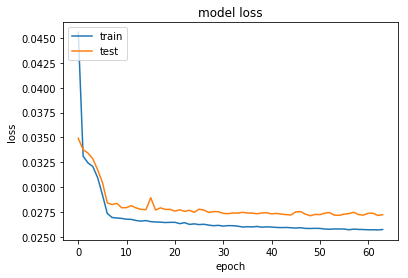

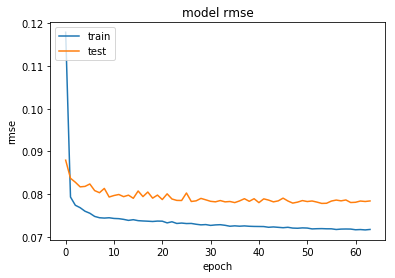

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [16]:
model.load_weights(experiment_name+'.hdf5')

In [17]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = decode_sequence(encoder_input)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  359.1348714828491 s =  5.985581203301748 min =  0.09975968685415056 h


## Evaluate performance on validation data to improve model

## Evaluate metrics

In [18]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.12246507510647141
Delay 100 ms: 0.020789156059224392
Delay 200 ms: 0.04252129556535806
Delay 300 ms: 0.0609952445938429
Delay 400 ms: 0.09096302626770131
Delay 500 ms: 0.1059911025724635
Delay 600 ms: 0.13359541358413585
Delay 700 ms: 0.15229654917395724
Delay 800 ms: 0.18064373026592606
Delay 900 ms: 0.19905886034635628
Delay 1000 ms: 0.23779637263574885

RMSE
Average rmse: 0.20163424435218333
Delay 100 ms: 0.03585912991511414
Delay 200 ms: 0.06692763261408975
Delay 300 ms: 0.09321121457646035
Delay 400 ms: 0.1390199409097276
Delay 500 ms: 0.15767731877391977
Delay 600 ms: 0.19342658156600004
Delay 700 ms: 0.2220368351465131
Delay 800 ms: 0.26160444978882985
Delay 900 ms: 0.2839088518052991
Delay 1000 ms: 0.33430023575307344

SMAPE
Average smape: 24.19093060795987
Delay 100 ms: 8.058265656619701
Delay 200 ms: 13.634915951508658
Delay 300 ms: 17.331024258631093
Delay 400 ms: 21.39579394423131
Delay 500 ms: 23.688327069859792
Delay 600 ms: 27.22579251318511
Delay 700 

(5116, 25, 3) (5116, 10, 3)


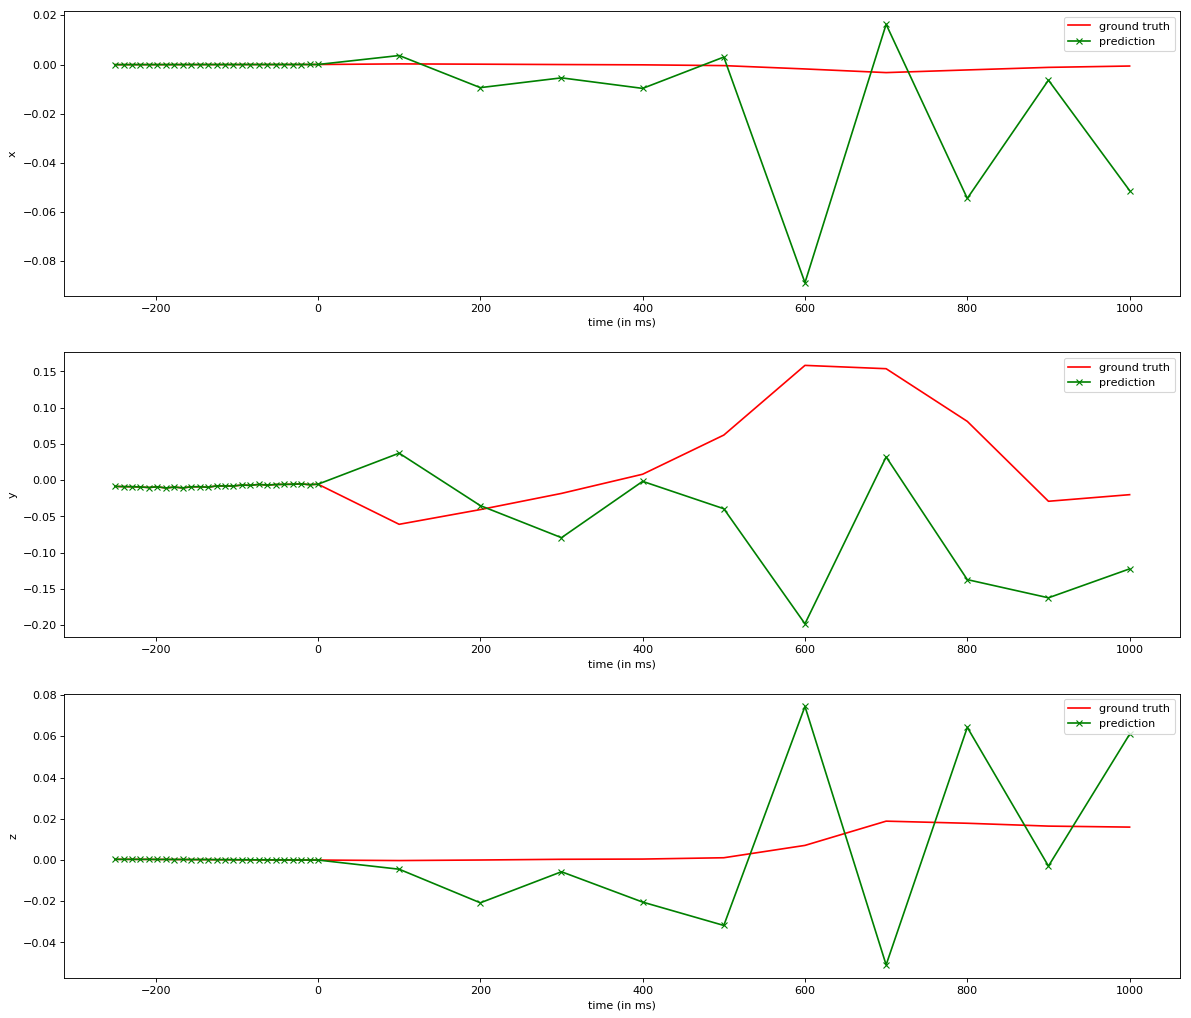

In [19]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)

Y_pred = decode_sequence(encoder_input)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')